##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
!pip install -q tf-models-official

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [5]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

    8192/84125825 [..............................] - ETA: 22:57

   24576/84125825 [..............................] - ETA: 15:18

   40960/84125825 [..............................] - ETA: 13:50

   73728/84125825 [..............................] - ETA: 10:14

  106496/84125825 [..............................] - ETA: 8:50 

  122880/84125825 [..............................] - ETA: 9:11

  172032/84125825 [..............................] - ETA: 7:39

  221184/84125825 [..............................] - ETA: 6:47

  286720/84125825 [..............................] - ETA: 5:54

  368640/84125825 [..............................] - ETA: 5:05

  483328/84125825 [..............................] - ETA: 4:15

  614400/84125825 [..............................] - ETA: 3:39

  794624/84125825 [..............................] - ETA: 3:03

 1040384/84125825 [..............................] - ETA: 2:30

 1335296/84125825 [..............................] - ETA: 2:05

 1646592/84125825 [..............................] - ETA: 1:47

 2039808/84125825 [..............................] - ETA: 1:32

 2514944/84125825 [..............................] - ETA: 1:16

 2629632/84125825 [..............................] - ETA: 1:15

 3088384/84125825 [>.............................] - ETA: 1:05

 3293184/84125825 [>.............................] - ETA: 1:02

 3809280/84125825 [>.............................] - ETA: 55s 

 3940352/84125825 [>.............................] - ETA: 54s

 4677632/84125825 [>.............................] - ETA: 47s

 5709824/84125825 [=>............................] - ETA: 39s

 5832704/84125825 [=>............................] - ETA: 39s

 7004160/84125825 [=>............................] - ETA: 33s

 7151616/84125825 [=>............................] - ETA: 33s

 8577024/84125825 [==>...........................] - ETA: 28s

10477568/84125825 [==>...........................] - ETA: 23s

10674176/84125825 [==>...........................] - ETA: 23s

12738560/84125825 [===>..........................] - ETA: 19s

15458304/84125825 [====>.........................] - ETA: 16s

17883136/84125825 [=====>........................] - ETA: 13s

18423808/84125825 [=====>........................] - ETA: 13s

21012480/84125825 [======>.......................] - ETA: 11s

21536768/84125825 [======>.......................] - ETA: 11s

24453120/84125825 [=======>......................] - ETA: 9s 

24649728/84125825 [=======>......................] - ETA: 9s

27705344/84125825 [========>.....................] - ETA: 8s

27779072/84125825 [========>.....................] - ETA: 8s

30826496/84125825 [=========>....................] - ETA: 7s

30908416/84125825 [==========>...................] - ETA: 7s

33726464/84125825 [===========>..................] - ETA: 6s

34021376/84125825 [===========>..................] - ETA: 6s

36233216/84125825 [===========>..................] - ETA: 5s

37052416/84125825 [============>.................] - ETA: 5s

39346176/84125825 [=============>................] - ETA: 5s

40181760/84125825 [=============>................] - ETA: 5s

42082304/84125825 [==============>...............] - ETA: 4s

43294720/84125825 [==============>...............] - ETA: 4s

44769280/84125825 [==============>...............] - ETA: 4s

46145536/84125825 [===============>..............] - ETA: 4s

47800320/84125825 [================>.............] - ETA: 3s

49291264/84125825 [================>.............] - ETA: 3s

50929664/84125825 [=================>............] - ETA: 3s

52420608/84125825 [=================>............] - ETA: 3s

54026240/84125825 [==================>...........] - ETA: 2s

55566336/84125825 [==================>...........] - ETA: 2s

57155584/84125825 [===================>..........] - ETA: 2s

58695680/84125825 [===================>..........] - ETA: 2s

59711488/84125825 [====================>.........] - ETA: 2s

61825024/84125825 [=====================>........] - ETA: 2s

62758912/84125825 [=====================>........] - ETA: 1s

64970752/84125825 [======================>.......] - ETA: 1s

65871872/84125825 [======================>.......] - ETA: 1s

68034560/84125825 [=======================>......] - ETA: 1s

69001216/84125825 [=======================>......] - ETA: 1s

71163904/84125825 [========================>.....] - ETA: 1s

72032256/84125825 [========================>.....] - ETA: 1s

74063872/84125825 [=========================>....] - ETA: 0s

75096064/84125825 [=========================>....] - ETA: 0s

77144064/84125825 [==========================>...] - ETA: 0s

78094336/84125825 [==========================>...] - ETA: 0s

79912960/84125825 [===========================>..] - ETA: 0s

81043456/84125825 [===========================>..] - ETA: 0s

82894848/84125825 [============================>.] - ETA: 0s

83992576/84125825 [============================>.] - ETA: 0s

84131840/84125825 [==============================] - 7s 0us/step


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [8]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.9928097  -0.18611881  0.36673862  0.15233737  0.6550447
  0.9681153  -0.9486272   0.00216161 -0.9877732   0.06842697 -0.9763058 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946346  0.34321272  0.33231515 ...  0.21300808  0.71020764
  -0.05771098]
 [-0.28742087  0.31980985 -0.23018607 ...  0.58455014 -0.21329728
   0.72692114]
 [-0.6615697   0.6887685  -0.87432986 ...  0.10877222 -0.2617324
   0.4785539 ]
 ...
 [-0.22561133 -0.2892562  -0.07064445 ...  0.47565985  0.83277136
   0.40025374]
 [-0.29824236 -0.27473187 -0.05450562 ...  0.48849723  1.0955356
   0.1816333 ]
 [-0.4437813   0.00930756  0.07223685 ...  0.17290069  1.1833248
   0.07897997]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [14]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6391119]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

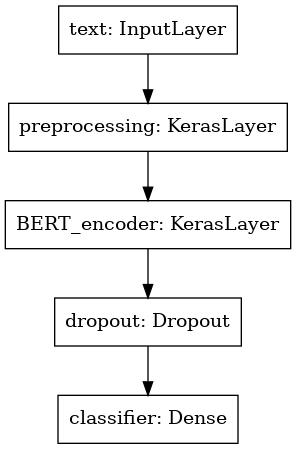

In [15]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [17]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [18]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [19]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


  1/625 [..............................] - ETA: 55:51 - loss: 0.7133 - binary_accuracy: 0.7500

  2/625 [..............................] - ETA: 1:15 - loss: 0.7350 - binary_accuracy: 0.6406 

  3/625 [..............................] - ETA: 1:13 - loss: 0.7416 - binary_accuracy: 0.5833

  4/625 [..............................] - ETA: 1:11 - loss: 0.7434 - binary_accuracy: 0.5625

  5/625 [..............................] - ETA: 1:10 - loss: 0.7445 - binary_accuracy: 0.5488

  6/625 [..............................] - ETA: 1:11 - loss: 0.7455 - binary_accuracy: 0.5424

  7/625 [..............................] - ETA: 1:10 - loss: 0.7451 - binary_accuracy: 0.5414

  8/625 [..............................] - ETA: 1:10 - loss: 0.7457 - binary_accuracy: 0.5401

  9/625 [..............................] - ETA: 1:10 - loss: 0.7461 - binary_accuracy: 0.5388

 10/625 [..............................] - ETA: 1:10 - loss: 0.7453 - binary_accuracy: 0.5371

 11/625 [..............................] - ETA: 1:09 - loss: 0.7440 - binary_accuracy: 0.5350

 12/625 [..............................] - ETA: 1:09 - loss: 0.7431 - binary_accuracy: 0.5330

 13/625 [..............................] - ETA: 1:09 - loss: 0.7422 - binary_accuracy: 0.5313

 14/625 [..............................] - ETA: 1:09 - loss: 0.7412 - binary_accuracy: 0.5302

 15/625 [..............................] - ETA: 1:09 - loss: 0.7400 - binary_accuracy: 0.5297

 16/625 [..............................] - ETA: 1:09 - loss: 0.7392 - binary_accuracy: 0.5298

 17/625 [..............................] - ETA: 1:08 - loss: 0.7384 - binary_accuracy: 0.5298

 18/625 [..............................] - ETA: 1:08 - loss: 0.7376 - binary_accuracy: 0.5298

 19/625 [..............................] - ETA: 1:08 - loss: 0.7370 - binary_accuracy: 0.5292

 20/625 [..............................] - ETA: 1:08 - loss: 0.7366 - binary_accuracy: 0.5286

 21/625 [>.............................] - ETA: 1:08 - loss: 0.7363 - binary_accuracy: 0.5280

 22/625 [>.............................] - ETA: 1:08 - loss: 0.7359 - binary_accuracy: 0.5275

 23/625 [>.............................] - ETA: 1:08 - loss: 0.7356 - binary_accuracy: 0.5270

 24/625 [>.............................] - ETA: 1:07 - loss: 0.7352 - binary_accuracy: 0.5267

 25/625 [>.............................] - ETA: 1:07 - loss: 0.7348 - binary_accuracy: 0.5264

 26/625 [>.............................] - ETA: 1:07 - loss: 0.7345 - binary_accuracy: 0.5261

 27/625 [>.............................] - ETA: 1:07 - loss: 0.7341 - binary_accuracy: 0.5255

 28/625 [>.............................] - ETA: 1:07 - loss: 0.7338 - binary_accuracy: 0.5251

 29/625 [>.............................] - ETA: 1:07 - loss: 0.7335 - binary_accuracy: 0.5247

 30/625 [>.............................] - ETA: 1:07 - loss: 0.7331 - binary_accuracy: 0.5244

 31/625 [>.............................] - ETA: 1:07 - loss: 0.7327 - binary_accuracy: 0.5242

 32/625 [>.............................] - ETA: 1:06 - loss: 0.7323 - binary_accuracy: 0.5242

 33/625 [>.............................] - ETA: 1:06 - loss: 0.7318 - binary_accuracy: 0.5242

 34/625 [>.............................] - ETA: 1:06 - loss: 0.7314 - binary_accuracy: 0.5243

 35/625 [>.............................] - ETA: 1:06 - loss: 0.7309 - binary_accuracy: 0.5245

 36/625 [>.............................] - ETA: 1:06 - loss: 0.7304 - binary_accuracy: 0.5247

 37/625 [>.............................] - ETA: 1:06 - loss: 0.7299 - binary_accuracy: 0.5249

 38/625 [>.............................] - ETA: 1:06 - loss: 0.7293 - binary_accuracy: 0.5251

 39/625 [>.............................] - ETA: 1:06 - loss: 0.7288 - binary_accuracy: 0.5252

 40/625 [>.............................] - ETA: 1:05 - loss: 0.7284 - binary_accuracy: 0.5252

 41/625 [>.............................] - ETA: 1:05 - loss: 0.7280 - binary_accuracy: 0.5254

 42/625 [=>............................] - ETA: 1:05 - loss: 0.7276 - binary_accuracy: 0.5255

 43/625 [=>............................] - ETA: 1:05 - loss: 0.7272 - binary_accuracy: 0.5257

 44/625 [=>............................] - ETA: 1:05 - loss: 0.7268 - binary_accuracy: 0.5258

 45/625 [=>............................] - ETA: 1:05 - loss: 0.7264 - binary_accuracy: 0.5260

 46/625 [=>............................] - ETA: 1:05 - loss: 0.7260 - binary_accuracy: 0.5262

 47/625 [=>............................] - ETA: 1:05 - loss: 0.7256 - binary_accuracy: 0.5264

 48/625 [=>............................] - ETA: 1:05 - loss: 0.7252 - binary_accuracy: 0.5266

 49/625 [=>............................] - ETA: 1:04 - loss: 0.7248 - binary_accuracy: 0.5269

 50/625 [=>............................] - ETA: 1:04 - loss: 0.7244 - binary_accuracy: 0.5272

 51/625 [=>............................] - ETA: 1:04 - loss: 0.7240 - binary_accuracy: 0.5275

 52/625 [=>............................] - ETA: 1:04 - loss: 0.7237 - binary_accuracy: 0.5277

 53/625 [=>............................] - ETA: 1:04 - loss: 0.7233 - binary_accuracy: 0.5279

 54/625 [=>............................] - ETA: 1:04 - loss: 0.7230 - binary_accuracy: 0.5281

 55/625 [=>............................] - ETA: 1:04 - loss: 0.7227 - binary_accuracy: 0.5283

 56/625 [=>............................] - ETA: 1:03 - loss: 0.7223 - binary_accuracy: 0.5285

 57/625 [=>............................] - ETA: 1:03 - loss: 0.7220 - binary_accuracy: 0.5287

 58/625 [=>............................] - ETA: 1:03 - loss: 0.7217 - binary_accuracy: 0.5288

 59/625 [=>............................] - ETA: 1:03 - loss: 0.7214 - binary_accuracy: 0.5290

 60/625 [=>............................] - ETA: 1:03 - loss: 0.7211 - binary_accuracy: 0.5293

 61/625 [=>............................] - ETA: 1:03 - loss: 0.7207 - binary_accuracy: 0.5295

 62/625 [=>............................] - ETA: 1:03 - loss: 0.7204 - binary_accuracy: 0.5298

 63/625 [==>...........................] - ETA: 1:03 - loss: 0.7201 - binary_accuracy: 0.5300

 64/625 [==>...........................] - ETA: 1:02 - loss: 0.7198 - binary_accuracy: 0.5302

 65/625 [==>...........................] - ETA: 1:02 - loss: 0.7195 - binary_accuracy: 0.5305

 66/625 [==>...........................] - ETA: 1:02 - loss: 0.7192 - binary_accuracy: 0.5307

 67/625 [==>...........................] - ETA: 1:02 - loss: 0.7189 - binary_accuracy: 0.5309

 68/625 [==>...........................] - ETA: 1:02 - loss: 0.7186 - binary_accuracy: 0.5312

 69/625 [==>...........................] - ETA: 1:02 - loss: 0.7183 - binary_accuracy: 0.5315

 70/625 [==>...........................] - ETA: 1:02 - loss: 0.7180 - binary_accuracy: 0.5317

 71/625 [==>...........................] - ETA: 1:02 - loss: 0.7177 - binary_accuracy: 0.5320

 72/625 [==>...........................] - ETA: 1:02 - loss: 0.7174 - binary_accuracy: 0.5322

 73/625 [==>...........................] - ETA: 1:02 - loss: 0.7171 - binary_accuracy: 0.5324

 74/625 [==>...........................] - ETA: 1:01 - loss: 0.7168 - binary_accuracy: 0.5327

 75/625 [==>...........................] - ETA: 1:01 - loss: 0.7166 - binary_accuracy: 0.5328

 76/625 [==>...........................] - ETA: 1:01 - loss: 0.7163 - binary_accuracy: 0.5330

 77/625 [==>...........................] - ETA: 1:01 - loss: 0.7160 - binary_accuracy: 0.5332

 78/625 [==>...........................] - ETA: 1:01 - loss: 0.7157 - binary_accuracy: 0.5333

 79/625 [==>...........................] - ETA: 1:01 - loss: 0.7154 - binary_accuracy: 0.5335

 80/625 [==>...........................] - ETA: 1:01 - loss: 0.7151 - binary_accuracy: 0.5337

 81/625 [==>...........................] - ETA: 1:01 - loss: 0.7148 - binary_accuracy: 0.5339

 82/625 [==>...........................] - ETA: 1:01 - loss: 0.7145 - binary_accuracy: 0.5342

 83/625 [==>...........................] - ETA: 1:00 - loss: 0.7141 - binary_accuracy: 0.5344

 84/625 [===>..........................] - ETA: 1:00 - loss: 0.7138 - binary_accuracy: 0.5346

 85/625 [===>..........................] - ETA: 1:00 - loss: 0.7135 - binary_accuracy: 0.5348

 86/625 [===>..........................] - ETA: 1:00 - loss: 0.7132 - binary_accuracy: 0.5351

 87/625 [===>..........................] - ETA: 1:00 - loss: 0.7129 - binary_accuracy: 0.5354

 88/625 [===>..........................] - ETA: 1:00 - loss: 0.7126 - binary_accuracy: 0.5356

 89/625 [===>..........................] - ETA: 1:00 - loss: 0.7122 - binary_accuracy: 0.5359

 90/625 [===>..........................] - ETA: 1:00 - loss: 0.7119 - binary_accuracy: 0.5361

 91/625 [===>..........................] - ETA: 1:00 - loss: 0.7116 - binary_accuracy: 0.5364

 92/625 [===>..........................] - ETA: 59s - loss: 0.7113 - binary_accuracy: 0.5366 

 93/625 [===>..........................] - ETA: 59s - loss: 0.7110 - binary_accuracy: 0.5369

 94/625 [===>..........................] - ETA: 59s - loss: 0.7107 - binary_accuracy: 0.5372

 95/625 [===>..........................] - ETA: 59s - loss: 0.7104 - binary_accuracy: 0.5374

 96/625 [===>..........................] - ETA: 59s - loss: 0.7101 - binary_accuracy: 0.5377

 97/625 [===>..........................] - ETA: 59s - loss: 0.7097 - binary_accuracy: 0.5380

 98/625 [===>..........................] - ETA: 59s - loss: 0.7094 - binary_accuracy: 0.5383

 99/625 [===>..........................] - ETA: 59s - loss: 0.7091 - binary_accuracy: 0.5386

100/625 [===>..........................] - ETA: 59s - loss: 0.7088 - binary_accuracy: 0.5389

101/625 [===>..........................] - ETA: 58s - loss: 0.7085 - binary_accuracy: 0.5391

102/625 [===>..........................] - ETA: 58s - loss: 0.7081 - binary_accuracy: 0.5394

103/625 [===>..........................] - ETA: 58s - loss: 0.7078 - binary_accuracy: 0.5397

104/625 [===>..........................] - ETA: 58s - loss: 0.7074 - binary_accuracy: 0.5401

105/625 [====>.........................] - ETA: 58s - loss: 0.7071 - binary_accuracy: 0.5404

106/625 [====>.........................] - ETA: 58s - loss: 0.7068 - binary_accuracy: 0.5407

107/625 [====>.........................] - ETA: 58s - loss: 0.7064 - binary_accuracy: 0.5410

108/625 [====>.........................] - ETA: 58s - loss: 0.7061 - binary_accuracy: 0.5414

109/625 [====>.........................] - ETA: 58s - loss: 0.7057 - binary_accuracy: 0.5417

110/625 [====>.........................] - ETA: 57s - loss: 0.7054 - binary_accuracy: 0.5420

111/625 [====>.........................] - ETA: 57s - loss: 0.7050 - binary_accuracy: 0.5423

112/625 [====>.........................] - ETA: 57s - loss: 0.7047 - binary_accuracy: 0.5426

113/625 [====>.........................] - ETA: 57s - loss: 0.7043 - binary_accuracy: 0.5430

114/625 [====>.........................] - ETA: 57s - loss: 0.7040 - binary_accuracy: 0.5433

115/625 [====>.........................] - ETA: 57s - loss: 0.7037 - binary_accuracy: 0.5436

116/625 [====>.........................] - ETA: 57s - loss: 0.7033 - binary_accuracy: 0.5439

117/625 [====>.........................] - ETA: 57s - loss: 0.7030 - binary_accuracy: 0.5442

118/625 [====>.........................] - ETA: 57s - loss: 0.7027 - binary_accuracy: 0.5445

119/625 [====>.........................] - ETA: 56s - loss: 0.7023 - binary_accuracy: 0.5448

120/625 [====>.........................] - ETA: 56s - loss: 0.7020 - binary_accuracy: 0.5451

121/625 [====>.........................] - ETA: 56s - loss: 0.7017 - binary_accuracy: 0.5454

122/625 [====>.........................] - ETA: 56s - loss: 0.7013 - binary_accuracy: 0.5457

123/625 [====>.........................] - ETA: 56s - loss: 0.7010 - binary_accuracy: 0.5460

124/625 [====>.........................] - ETA: 56s - loss: 0.7006 - binary_accuracy: 0.5463

125/625 [=====>........................] - ETA: 56s - loss: 0.7003 - binary_accuracy: 0.5467

126/625 [=====>........................] - ETA: 56s - loss: 0.7000 - binary_accuracy: 0.5470

127/625 [=====>........................] - ETA: 56s - loss: 0.6996 - binary_accuracy: 0.5473

128/625 [=====>........................] - ETA: 55s - loss: 0.6993 - binary_accuracy: 0.5476

129/625 [=====>........................] - ETA: 55s - loss: 0.6989 - binary_accuracy: 0.5480

130/625 [=====>........................] - ETA: 55s - loss: 0.6986 - binary_accuracy: 0.5483

131/625 [=====>........................] - ETA: 55s - loss: 0.6982 - binary_accuracy: 0.5486

132/625 [=====>........................] - ETA: 55s - loss: 0.6979 - binary_accuracy: 0.5490

133/625 [=====>........................] - ETA: 55s - loss: 0.6976 - binary_accuracy: 0.5493

134/625 [=====>........................] - ETA: 55s - loss: 0.6972 - binary_accuracy: 0.5497

135/625 [=====>........................] - ETA: 55s - loss: 0.6969 - binary_accuracy: 0.5500

136/625 [=====>........................] - ETA: 55s - loss: 0.6965 - binary_accuracy: 0.5503

137/625 [=====>........................] - ETA: 54s - loss: 0.6962 - binary_accuracy: 0.5507

138/625 [=====>........................] - ETA: 54s - loss: 0.6958 - binary_accuracy: 0.5510

139/625 [=====>........................] - ETA: 54s - loss: 0.6955 - binary_accuracy: 0.5514

140/625 [=====>........................] - ETA: 54s - loss: 0.6951 - binary_accuracy: 0.5517

141/625 [=====>........................] - ETA: 54s - loss: 0.6947 - binary_accuracy: 0.5521

142/625 [=====>........................] - ETA: 54s - loss: 0.6944 - binary_accuracy: 0.5524

143/625 [=====>........................] - ETA: 54s - loss: 0.6940 - binary_accuracy: 0.5528

144/625 [=====>........................] - ETA: 54s - loss: 0.6937 - binary_accuracy: 0.5531

145/625 [=====>........................] - ETA: 54s - loss: 0.6933 - binary_accuracy: 0.5535

146/625 [======>.......................] - ETA: 53s - loss: 0.6929 - binary_accuracy: 0.5538

147/625 [======>.......................] - ETA: 53s - loss: 0.6926 - binary_accuracy: 0.5542

148/625 [======>.......................] - ETA: 53s - loss: 0.6922 - binary_accuracy: 0.5545

149/625 [======>.......................] - ETA: 53s - loss: 0.6919 - binary_accuracy: 0.5549

150/625 [======>.......................] - ETA: 53s - loss: 0.6915 - binary_accuracy: 0.5552

151/625 [======>.......................] - ETA: 53s - loss: 0.6911 - binary_accuracy: 0.5556

152/625 [======>.......................] - ETA: 53s - loss: 0.6908 - binary_accuracy: 0.5559

153/625 [======>.......................] - ETA: 53s - loss: 0.6904 - binary_accuracy: 0.5563

154/625 [======>.......................] - ETA: 53s - loss: 0.6901 - binary_accuracy: 0.5566

155/625 [======>.......................] - ETA: 52s - loss: 0.6897 - binary_accuracy: 0.5570

156/625 [======>.......................] - ETA: 52s - loss: 0.6893 - binary_accuracy: 0.5573

157/625 [======>.......................] - ETA: 52s - loss: 0.6890 - binary_accuracy: 0.5577

158/625 [======>.......................] - ETA: 52s - loss: 0.6886 - binary_accuracy: 0.5580

159/625 [======>.......................] - ETA: 52s - loss: 0.6883 - binary_accuracy: 0.5584

160/625 [======>.......................] - ETA: 52s - loss: 0.6879 - binary_accuracy: 0.5587

161/625 [======>.......................] - ETA: 52s - loss: 0.6875 - binary_accuracy: 0.5591

162/625 [======>.......................] - ETA: 52s - loss: 0.6872 - binary_accuracy: 0.5594

163/625 [======>.......................] - ETA: 52s - loss: 0.6868 - binary_accuracy: 0.5598

164/625 [======>.......................] - ETA: 51s - loss: 0.6865 - binary_accuracy: 0.5601

165/625 [======>.......................] - ETA: 51s - loss: 0.6861 - binary_accuracy: 0.5605

166/625 [======>.......................] - ETA: 51s - loss: 0.6857 - binary_accuracy: 0.5608

167/625 [=======>......................] - ETA: 51s - loss: 0.6854 - binary_accuracy: 0.5612

168/625 [=======>......................] - ETA: 51s - loss: 0.6850 - binary_accuracy: 0.5615

169/625 [=======>......................] - ETA: 51s - loss: 0.6846 - binary_accuracy: 0.5619

170/625 [=======>......................] - ETA: 51s - loss: 0.6843 - binary_accuracy: 0.5622

171/625 [=======>......................] - ETA: 51s - loss: 0.6839 - binary_accuracy: 0.5626

172/625 [=======>......................] - ETA: 50s - loss: 0.6835 - binary_accuracy: 0.5629

173/625 [=======>......................] - ETA: 50s - loss: 0.6831 - binary_accuracy: 0.5633

174/625 [=======>......................] - ETA: 50s - loss: 0.6828 - binary_accuracy: 0.5637

175/625 [=======>......................] - ETA: 50s - loss: 0.6824 - binary_accuracy: 0.5640

176/625 [=======>......................] - ETA: 50s - loss: 0.6820 - binary_accuracy: 0.5644

177/625 [=======>......................] - ETA: 50s - loss: 0.6817 - binary_accuracy: 0.5647

178/625 [=======>......................] - ETA: 50s - loss: 0.6813 - binary_accuracy: 0.5651

179/625 [=======>......................] - ETA: 50s - loss: 0.6809 - binary_accuracy: 0.5655

180/625 [=======>......................] - ETA: 50s - loss: 0.6805 - binary_accuracy: 0.5658

181/625 [=======>......................] - ETA: 49s - loss: 0.6802 - binary_accuracy: 0.5662

182/625 [=======>......................] - ETA: 49s - loss: 0.6798 - binary_accuracy: 0.5665

183/625 [=======>......................] - ETA: 49s - loss: 0.6794 - binary_accuracy: 0.5669

184/625 [=======>......................] - ETA: 49s - loss: 0.6790 - binary_accuracy: 0.5672

185/625 [=======>......................] - ETA: 49s - loss: 0.6787 - binary_accuracy: 0.5676

186/625 [=======>......................] - ETA: 49s - loss: 0.6783 - binary_accuracy: 0.5679

187/625 [=======>......................] - ETA: 49s - loss: 0.6779 - binary_accuracy: 0.5683

188/625 [========>.....................] - ETA: 49s - loss: 0.6775 - binary_accuracy: 0.5686

189/625 [========>.....................] - ETA: 49s - loss: 0.6772 - binary_accuracy: 0.5690

190/625 [========>.....................] - ETA: 48s - loss: 0.6768 - binary_accuracy: 0.5694

191/625 [========>.....................] - ETA: 48s - loss: 0.6764 - binary_accuracy: 0.5697

192/625 [========>.....................] - ETA: 48s - loss: 0.6760 - binary_accuracy: 0.5701

193/625 [========>.....................] - ETA: 48s - loss: 0.6756 - binary_accuracy: 0.5704

194/625 [========>.....................] - ETA: 48s - loss: 0.6753 - binary_accuracy: 0.5708

195/625 [========>.....................] - ETA: 48s - loss: 0.6749 - binary_accuracy: 0.5712

196/625 [========>.....................] - ETA: 48s - loss: 0.6745 - binary_accuracy: 0.5715

197/625 [========>.....................] - ETA: 48s - loss: 0.6742 - binary_accuracy: 0.5719

198/625 [========>.....................] - ETA: 48s - loss: 0.6738 - binary_accuracy: 0.5722

199/625 [========>.....................] - ETA: 47s - loss: 0.6734 - binary_accuracy: 0.5726

200/625 [========>.....................] - ETA: 47s - loss: 0.6731 - binary_accuracy: 0.5729

201/625 [========>.....................] - ETA: 47s - loss: 0.6727 - binary_accuracy: 0.5733

202/625 [========>.....................] - ETA: 47s - loss: 0.6723 - binary_accuracy: 0.5736

203/625 [========>.....................] - ETA: 47s - loss: 0.6720 - binary_accuracy: 0.5740

204/625 [========>.....................] - ETA: 47s - loss: 0.6716 - binary_accuracy: 0.5743

205/625 [========>.....................] - ETA: 47s - loss: 0.6713 - binary_accuracy: 0.5746

206/625 [========>.....................] - ETA: 47s - loss: 0.6709 - binary_accuracy: 0.5750

207/625 [========>.....................] - ETA: 47s - loss: 0.6705 - binary_accuracy: 0.5753

208/625 [========>.....................] - ETA: 46s - loss: 0.6702 - binary_accuracy: 0.5757

209/625 [=========>....................] - ETA: 46s - loss: 0.6698 - binary_accuracy: 0.5760

210/625 [=========>....................] - ETA: 46s - loss: 0.6695 - binary_accuracy: 0.5764

211/625 [=========>....................] - ETA: 46s - loss: 0.6691 - binary_accuracy: 0.5767

212/625 [=========>....................] - ETA: 46s - loss: 0.6687 - binary_accuracy: 0.5770

213/625 [=========>....................] - ETA: 46s - loss: 0.6684 - binary_accuracy: 0.5774

214/625 [=========>....................] - ETA: 46s - loss: 0.6680 - binary_accuracy: 0.5777

215/625 [=========>....................] - ETA: 46s - loss: 0.6677 - binary_accuracy: 0.5780

216/625 [=========>....................] - ETA: 46s - loss: 0.6673 - binary_accuracy: 0.5784

217/625 [=========>....................] - ETA: 45s - loss: 0.6670 - binary_accuracy: 0.5787

218/625 [=========>....................] - ETA: 45s - loss: 0.6666 - binary_accuracy: 0.5790

219/625 [=========>....................] - ETA: 45s - loss: 0.6663 - binary_accuracy: 0.5794

220/625 [=========>....................] - ETA: 45s - loss: 0.6659 - binary_accuracy: 0.5797

221/625 [=========>....................] - ETA: 45s - loss: 0.6656 - binary_accuracy: 0.5801

222/625 [=========>....................] - ETA: 45s - loss: 0.6652 - binary_accuracy: 0.5804

223/625 [=========>....................] - ETA: 45s - loss: 0.6649 - binary_accuracy: 0.5807

224/625 [=========>....................] - ETA: 45s - loss: 0.6645 - binary_accuracy: 0.5811

225/625 [=========>....................] - ETA: 45s - loss: 0.6642 - binary_accuracy: 0.5814

226/625 [=========>....................] - ETA: 44s - loss: 0.6638 - binary_accuracy: 0.5817

227/625 [=========>....................] - ETA: 44s - loss: 0.6635 - binary_accuracy: 0.5820

228/625 [=========>....................] - ETA: 44s - loss: 0.6631 - binary_accuracy: 0.5824

229/625 [=========>....................] - ETA: 44s - loss: 0.6628 - binary_accuracy: 0.5827

230/625 [==========>...................] - ETA: 44s - loss: 0.6624 - binary_accuracy: 0.5830

231/625 [==========>...................] - ETA: 44s - loss: 0.6621 - binary_accuracy: 0.5834

232/625 [==========>...................] - ETA: 44s - loss: 0.6617 - binary_accuracy: 0.5837

233/625 [==========>...................] - ETA: 44s - loss: 0.6614 - binary_accuracy: 0.5840

234/625 [==========>...................] - ETA: 44s - loss: 0.6610 - binary_accuracy: 0.5844

235/625 [==========>...................] - ETA: 43s - loss: 0.6607 - binary_accuracy: 0.5847

236/625 [==========>...................] - ETA: 43s - loss: 0.6604 - binary_accuracy: 0.5850

237/625 [==========>...................] - ETA: 43s - loss: 0.6600 - binary_accuracy: 0.5853

238/625 [==========>...................] - ETA: 43s - loss: 0.6597 - binary_accuracy: 0.5857

239/625 [==========>...................] - ETA: 43s - loss: 0.6593 - binary_accuracy: 0.5860

240/625 [==========>...................] - ETA: 43s - loss: 0.6590 - binary_accuracy: 0.5863

241/625 [==========>...................] - ETA: 43s - loss: 0.6586 - binary_accuracy: 0.5866

242/625 [==========>...................] - ETA: 43s - loss: 0.6583 - binary_accuracy: 0.5870

243/625 [==========>...................] - ETA: 43s - loss: 0.6579 - binary_accuracy: 0.5873

244/625 [==========>...................] - ETA: 42s - loss: 0.6576 - binary_accuracy: 0.5876

245/625 [==========>...................] - ETA: 42s - loss: 0.6572 - binary_accuracy: 0.5879

246/625 [==========>...................] - ETA: 42s - loss: 0.6569 - binary_accuracy: 0.5883

247/625 [==========>...................] - ETA: 42s - loss: 0.6565 - binary_accuracy: 0.5886

248/625 [==========>...................] - ETA: 42s - loss: 0.6562 - binary_accuracy: 0.5889

249/625 [==========>...................] - ETA: 42s - loss: 0.6559 - binary_accuracy: 0.5892

250/625 [===========>..................] - ETA: 42s - loss: 0.6555 - binary_accuracy: 0.5895

251/625 [===========>..................] - ETA: 42s - loss: 0.6552 - binary_accuracy: 0.5899

252/625 [===========>..................] - ETA: 42s - loss: 0.6549 - binary_accuracy: 0.5902

253/625 [===========>..................] - ETA: 41s - loss: 0.6545 - binary_accuracy: 0.5905

254/625 [===========>..................] - ETA: 41s - loss: 0.6542 - binary_accuracy: 0.5908

255/625 [===========>..................] - ETA: 41s - loss: 0.6538 - binary_accuracy: 0.5911

256/625 [===========>..................] - ETA: 41s - loss: 0.6535 - binary_accuracy: 0.5914

257/625 [===========>..................] - ETA: 41s - loss: 0.6532 - binary_accuracy: 0.5917

258/625 [===========>..................] - ETA: 41s - loss: 0.6529 - binary_accuracy: 0.5920

259/625 [===========>..................] - ETA: 41s - loss: 0.6525 - binary_accuracy: 0.5923

260/625 [===========>..................] - ETA: 41s - loss: 0.6522 - binary_accuracy: 0.5927

261/625 [===========>..................] - ETA: 41s - loss: 0.6519 - binary_accuracy: 0.5930

262/625 [===========>..................] - ETA: 40s - loss: 0.6515 - binary_accuracy: 0.5933

263/625 [===========>..................] - ETA: 40s - loss: 0.6512 - binary_accuracy: 0.5936

264/625 [===========>..................] - ETA: 40s - loss: 0.6509 - binary_accuracy: 0.5939

265/625 [===========>..................] - ETA: 40s - loss: 0.6506 - binary_accuracy: 0.5942

266/625 [===========>..................] - ETA: 40s - loss: 0.6502 - binary_accuracy: 0.5945

267/625 [===========>..................] - ETA: 40s - loss: 0.6499 - binary_accuracy: 0.5948

268/625 [===========>..................] - ETA: 40s - loss: 0.6496 - binary_accuracy: 0.5951

269/625 [===========>..................] - ETA: 40s - loss: 0.6493 - binary_accuracy: 0.5954

270/625 [===========>..................] - ETA: 40s - loss: 0.6489 - binary_accuracy: 0.5957

271/625 [============>.................] - ETA: 39s - loss: 0.6486 - binary_accuracy: 0.5960

272/625 [============>.................] - ETA: 39s - loss: 0.6483 - binary_accuracy: 0.5963

273/625 [============>.................] - ETA: 39s - loss: 0.6480 - binary_accuracy: 0.5966

274/625 [============>.................] - ETA: 39s - loss: 0.6476 - binary_accuracy: 0.5969

275/625 [============>.................] - ETA: 39s - loss: 0.6473 - binary_accuracy: 0.5972

276/625 [============>.................] - ETA: 39s - loss: 0.6470 - binary_accuracy: 0.5975

277/625 [============>.................] - ETA: 39s - loss: 0.6467 - binary_accuracy: 0.5978

278/625 [============>.................] - ETA: 39s - loss: 0.6464 - binary_accuracy: 0.5981

279/625 [============>.................] - ETA: 39s - loss: 0.6461 - binary_accuracy: 0.5984

280/625 [============>.................] - ETA: 38s - loss: 0.6457 - binary_accuracy: 0.5987

281/625 [============>.................] - ETA: 38s - loss: 0.6454 - binary_accuracy: 0.5990

282/625 [============>.................] - ETA: 38s - loss: 0.6451 - binary_accuracy: 0.5993

283/625 [============>.................] - ETA: 38s - loss: 0.6448 - binary_accuracy: 0.5996

284/625 [============>.................] - ETA: 38s - loss: 0.6445 - binary_accuracy: 0.5999

285/625 [============>.................] - ETA: 38s - loss: 0.6442 - binary_accuracy: 0.6001

286/625 [============>.................] - ETA: 38s - loss: 0.6438 - binary_accuracy: 0.6004

287/625 [============>.................] - ETA: 38s - loss: 0.6435 - binary_accuracy: 0.6007

288/625 [============>.................] - ETA: 38s - loss: 0.6432 - binary_accuracy: 0.6010

289/625 [============>.................] - ETA: 37s - loss: 0.6429 - binary_accuracy: 0.6013

290/625 [============>.................] - ETA: 37s - loss: 0.6426 - binary_accuracy: 0.6016

291/625 [============>.................] - ETA: 37s - loss: 0.6423 - binary_accuracy: 0.6019

292/625 [=============>................] - ETA: 37s - loss: 0.6420 - binary_accuracy: 0.6021

293/625 [=============>................] - ETA: 37s - loss: 0.6417 - binary_accuracy: 0.6024

294/625 [=============>................] - ETA: 37s - loss: 0.6414 - binary_accuracy: 0.6027

295/625 [=============>................] - ETA: 37s - loss: 0.6411 - binary_accuracy: 0.6030

296/625 [=============>................] - ETA: 37s - loss: 0.6408 - binary_accuracy: 0.6033

297/625 [=============>................] - ETA: 37s - loss: 0.6405 - binary_accuracy: 0.6035

298/625 [=============>................] - ETA: 36s - loss: 0.6402 - binary_accuracy: 0.6038

299/625 [=============>................] - ETA: 36s - loss: 0.6399 - binary_accuracy: 0.6041

300/625 [=============>................] - ETA: 36s - loss: 0.6397 - binary_accuracy: 0.6044

301/625 [=============>................] - ETA: 36s - loss: 0.6394 - binary_accuracy: 0.6046

302/625 [=============>................] - ETA: 36s - loss: 0.6391 - binary_accuracy: 0.6049

303/625 [=============>................] - ETA: 36s - loss: 0.6388 - binary_accuracy: 0.6052

304/625 [=============>................] - ETA: 36s - loss: 0.6385 - binary_accuracy: 0.6055

305/625 [=============>................] - ETA: 36s - loss: 0.6382 - binary_accuracy: 0.6057

306/625 [=============>................] - ETA: 36s - loss: 0.6379 - binary_accuracy: 0.6060

307/625 [=============>................] - ETA: 35s - loss: 0.6376 - binary_accuracy: 0.6063

308/625 [=============>................] - ETA: 35s - loss: 0.6373 - binary_accuracy: 0.6066

309/625 [=============>................] - ETA: 35s - loss: 0.6370 - binary_accuracy: 0.6068

310/625 [=============>................] - ETA: 35s - loss: 0.6368 - binary_accuracy: 0.6071

311/625 [=============>................] - ETA: 35s - loss: 0.6365 - binary_accuracy: 0.6073

312/625 [=============>................] - ETA: 35s - loss: 0.6362 - binary_accuracy: 0.6076

313/625 [==============>...............] - ETA: 35s - loss: 0.6359 - binary_accuracy: 0.6079

314/625 [==============>...............] - ETA: 35s - loss: 0.6356 - binary_accuracy: 0.6081

315/625 [==============>...............] - ETA: 35s - loss: 0.6354 - binary_accuracy: 0.6084

316/625 [==============>...............] - ETA: 34s - loss: 0.6351 - binary_accuracy: 0.6087

317/625 [==============>...............] - ETA: 34s - loss: 0.6348 - binary_accuracy: 0.6089

318/625 [==============>...............] - ETA: 34s - loss: 0.6345 - binary_accuracy: 0.6092

319/625 [==============>...............] - ETA: 34s - loss: 0.6342 - binary_accuracy: 0.6094

320/625 [==============>...............] - ETA: 34s - loss: 0.6340 - binary_accuracy: 0.6097

321/625 [==============>...............] - ETA: 34s - loss: 0.6337 - binary_accuracy: 0.6100

322/625 [==============>...............] - ETA: 34s - loss: 0.6334 - binary_accuracy: 0.6102

323/625 [==============>...............] - ETA: 34s - loss: 0.6331 - binary_accuracy: 0.6105

324/625 [==============>...............] - ETA: 34s - loss: 0.6329 - binary_accuracy: 0.6107

325/625 [==============>...............] - ETA: 33s - loss: 0.6326 - binary_accuracy: 0.6110

326/625 [==============>...............] - ETA: 33s - loss: 0.6323 - binary_accuracy: 0.6113

327/625 [==============>...............] - ETA: 33s - loss: 0.6320 - binary_accuracy: 0.6115

328/625 [==============>...............] - ETA: 33s - loss: 0.6318 - binary_accuracy: 0.6118

329/625 [==============>...............] - ETA: 33s - loss: 0.6315 - binary_accuracy: 0.6120

330/625 [==============>...............] - ETA: 33s - loss: 0.6312 - binary_accuracy: 0.6123

331/625 [==============>...............] - ETA: 33s - loss: 0.6310 - binary_accuracy: 0.6125

332/625 [==============>...............] - ETA: 33s - loss: 0.6307 - binary_accuracy: 0.6128

333/625 [==============>...............] - ETA: 33s - loss: 0.6304 - binary_accuracy: 0.6130

334/625 [===============>..............] - ETA: 32s - loss: 0.6302 - binary_accuracy: 0.6133

335/625 [===============>..............] - ETA: 32s - loss: 0.6299 - binary_accuracy: 0.6135

336/625 [===============>..............] - ETA: 32s - loss: 0.6297 - binary_accuracy: 0.6138

337/625 [===============>..............] - ETA: 32s - loss: 0.6294 - binary_accuracy: 0.6140

338/625 [===============>..............] - ETA: 32s - loss: 0.6291 - binary_accuracy: 0.6143

339/625 [===============>..............] - ETA: 32s - loss: 0.6289 - binary_accuracy: 0.6145

340/625 [===============>..............] - ETA: 32s - loss: 0.6286 - binary_accuracy: 0.6148

341/625 [===============>..............] - ETA: 32s - loss: 0.6284 - binary_accuracy: 0.6150

342/625 [===============>..............] - ETA: 32s - loss: 0.6281 - binary_accuracy: 0.6153

343/625 [===============>..............] - ETA: 31s - loss: 0.6279 - binary_accuracy: 0.6155

344/625 [===============>..............] - ETA: 31s - loss: 0.6276 - binary_accuracy: 0.6157

345/625 [===============>..............] - ETA: 31s - loss: 0.6273 - binary_accuracy: 0.6160

346/625 [===============>..............] - ETA: 31s - loss: 0.6271 - binary_accuracy: 0.6162

347/625 [===============>..............] - ETA: 31s - loss: 0.6268 - binary_accuracy: 0.6164

348/625 [===============>..............] - ETA: 31s - loss: 0.6266 - binary_accuracy: 0.6167

349/625 [===============>..............] - ETA: 31s - loss: 0.6263 - binary_accuracy: 0.6169

350/625 [===============>..............] - ETA: 31s - loss: 0.6261 - binary_accuracy: 0.6172

351/625 [===============>..............] - ETA: 30s - loss: 0.6258 - binary_accuracy: 0.6174

352/625 [===============>..............] - ETA: 30s - loss: 0.6256 - binary_accuracy: 0.6176

353/625 [===============>..............] - ETA: 30s - loss: 0.6253 - binary_accuracy: 0.6179

354/625 [===============>..............] - ETA: 30s - loss: 0.6251 - binary_accuracy: 0.6181

355/625 [================>.............] - ETA: 30s - loss: 0.6249 - binary_accuracy: 0.6183

356/625 [================>.............] - ETA: 30s - loss: 0.6246 - binary_accuracy: 0.6186

357/625 [================>.............] - ETA: 30s - loss: 0.6244 - binary_accuracy: 0.6188

358/625 [================>.............] - ETA: 30s - loss: 0.6241 - binary_accuracy: 0.6190

359/625 [================>.............] - ETA: 30s - loss: 0.6239 - binary_accuracy: 0.6192

360/625 [================>.............] - ETA: 29s - loss: 0.6236 - binary_accuracy: 0.6195

361/625 [================>.............] - ETA: 29s - loss: 0.6234 - binary_accuracy: 0.6197

362/625 [================>.............] - ETA: 29s - loss: 0.6231 - binary_accuracy: 0.6199

363/625 [================>.............] - ETA: 29s - loss: 0.6229 - binary_accuracy: 0.6202

364/625 [================>.............] - ETA: 29s - loss: 0.6226 - binary_accuracy: 0.6204

365/625 [================>.............] - ETA: 29s - loss: 0.6224 - binary_accuracy: 0.6206

366/625 [================>.............] - ETA: 29s - loss: 0.6221 - binary_accuracy: 0.6209

367/625 [================>.............] - ETA: 29s - loss: 0.6219 - binary_accuracy: 0.6211

368/625 [================>.............] - ETA: 29s - loss: 0.6216 - binary_accuracy: 0.6213

369/625 [================>.............] - ETA: 28s - loss: 0.6214 - binary_accuracy: 0.6215

370/625 [================>.............] - ETA: 28s - loss: 0.6212 - binary_accuracy: 0.6218

371/625 [================>.............] - ETA: 28s - loss: 0.6209 - binary_accuracy: 0.6220

372/625 [================>.............] - ETA: 28s - loss: 0.6207 - binary_accuracy: 0.6222

373/625 [================>.............] - ETA: 28s - loss: 0.6204 - binary_accuracy: 0.6224

374/625 [================>.............] - ETA: 28s - loss: 0.6202 - binary_accuracy: 0.6227

375/625 [=================>............] - ETA: 28s - loss: 0.6199 - binary_accuracy: 0.6229

376/625 [=================>............] - ETA: 28s - loss: 0.6197 - binary_accuracy: 0.6231

377/625 [=================>............] - ETA: 28s - loss: 0.6194 - binary_accuracy: 0.6233

378/625 [=================>............] - ETA: 27s - loss: 0.6192 - binary_accuracy: 0.6236

379/625 [=================>............] - ETA: 27s - loss: 0.6190 - binary_accuracy: 0.6238

380/625 [=================>............] - ETA: 27s - loss: 0.6187 - binary_accuracy: 0.6240

381/625 [=================>............] - ETA: 27s - loss: 0.6185 - binary_accuracy: 0.6242

382/625 [=================>............] - ETA: 27s - loss: 0.6182 - binary_accuracy: 0.6245

383/625 [=================>............] - ETA: 27s - loss: 0.6180 - binary_accuracy: 0.6247

384/625 [=================>............] - ETA: 27s - loss: 0.6178 - binary_accuracy: 0.6249

385/625 [=================>............] - ETA: 27s - loss: 0.6175 - binary_accuracy: 0.6251

386/625 [=================>............] - ETA: 27s - loss: 0.6173 - binary_accuracy: 0.6253

387/625 [=================>............] - ETA: 26s - loss: 0.6170 - binary_accuracy: 0.6256

388/625 [=================>............] - ETA: 26s - loss: 0.6168 - binary_accuracy: 0.6258

389/625 [=================>............] - ETA: 26s - loss: 0.6166 - binary_accuracy: 0.6260

390/625 [=================>............] - ETA: 26s - loss: 0.6163 - binary_accuracy: 0.6262

391/625 [=================>............] - ETA: 26s - loss: 0.6161 - binary_accuracy: 0.6264

392/625 [=================>............] - ETA: 26s - loss: 0.6158 - binary_accuracy: 0.6266

393/625 [=================>............] - ETA: 26s - loss: 0.6156 - binary_accuracy: 0.6269

394/625 [=================>............] - ETA: 26s - loss: 0.6154 - binary_accuracy: 0.6271

395/625 [=================>............] - ETA: 26s - loss: 0.6151 - binary_accuracy: 0.6273

396/625 [==================>...........] - ETA: 25s - loss: 0.6149 - binary_accuracy: 0.6275

397/625 [==================>...........] - ETA: 25s - loss: 0.6147 - binary_accuracy: 0.6277

398/625 [==================>...........] - ETA: 25s - loss: 0.6144 - binary_accuracy: 0.6279

399/625 [==================>...........] - ETA: 25s - loss: 0.6142 - binary_accuracy: 0.6281

400/625 [==================>...........] - ETA: 25s - loss: 0.6140 - binary_accuracy: 0.6283

401/625 [==================>...........] - ETA: 25s - loss: 0.6137 - binary_accuracy: 0.6286

402/625 [==================>...........] - ETA: 25s - loss: 0.6135 - binary_accuracy: 0.6288

403/625 [==================>...........] - ETA: 25s - loss: 0.6133 - binary_accuracy: 0.6290

404/625 [==================>...........] - ETA: 25s - loss: 0.6130 - binary_accuracy: 0.6292

405/625 [==================>...........] - ETA: 24s - loss: 0.6128 - binary_accuracy: 0.6294

406/625 [==================>...........] - ETA: 24s - loss: 0.6126 - binary_accuracy: 0.6296

407/625 [==================>...........] - ETA: 24s - loss: 0.6124 - binary_accuracy: 0.6298

408/625 [==================>...........] - ETA: 24s - loss: 0.6121 - binary_accuracy: 0.6300

409/625 [==================>...........] - ETA: 24s - loss: 0.6119 - binary_accuracy: 0.6302

410/625 [==================>...........] - ETA: 24s - loss: 0.6117 - binary_accuracy: 0.6304

411/625 [==================>...........] - ETA: 24s - loss: 0.6115 - binary_accuracy: 0.6306

412/625 [==================>...........] - ETA: 24s - loss: 0.6112 - binary_accuracy: 0.6308

413/625 [==================>...........] - ETA: 23s - loss: 0.6110 - binary_accuracy: 0.6310

414/625 [==================>...........] - ETA: 23s - loss: 0.6108 - binary_accuracy: 0.6312

415/625 [==================>...........] - ETA: 23s - loss: 0.6106 - binary_accuracy: 0.6315

416/625 [==================>...........] - ETA: 23s - loss: 0.6103 - binary_accuracy: 0.6317

417/625 [===================>..........] - ETA: 23s - loss: 0.6101 - binary_accuracy: 0.6319

418/625 [===================>..........] - ETA: 23s - loss: 0.6099 - binary_accuracy: 0.6321

419/625 [===================>..........] - ETA: 23s - loss: 0.6097 - binary_accuracy: 0.6323

420/625 [===================>..........] - ETA: 23s - loss: 0.6095 - binary_accuracy: 0.6325

421/625 [===================>..........] - ETA: 23s - loss: 0.6092 - binary_accuracy: 0.6327

422/625 [===================>..........] - ETA: 22s - loss: 0.6090 - binary_accuracy: 0.6329

423/625 [===================>..........] - ETA: 22s - loss: 0.6088 - binary_accuracy: 0.6330

424/625 [===================>..........] - ETA: 22s - loss: 0.6086 - binary_accuracy: 0.6332

425/625 [===================>..........] - ETA: 22s - loss: 0.6084 - binary_accuracy: 0.6334

426/625 [===================>..........] - ETA: 22s - loss: 0.6082 - binary_accuracy: 0.6336

427/625 [===================>..........] - ETA: 22s - loss: 0.6079 - binary_accuracy: 0.6338

428/625 [===================>..........] - ETA: 22s - loss: 0.6077 - binary_accuracy: 0.6340

429/625 [===================>..........] - ETA: 22s - loss: 0.6075 - binary_accuracy: 0.6342

430/625 [===================>..........] - ETA: 22s - loss: 0.6073 - binary_accuracy: 0.6344

431/625 [===================>..........] - ETA: 21s - loss: 0.6071 - binary_accuracy: 0.6346

432/625 [===================>..........] - ETA: 21s - loss: 0.6069 - binary_accuracy: 0.6348

433/625 [===================>..........] - ETA: 21s - loss: 0.6067 - binary_accuracy: 0.6350

434/625 [===================>..........] - ETA: 21s - loss: 0.6065 - binary_accuracy: 0.6352

435/625 [===================>..........] - ETA: 21s - loss: 0.6062 - binary_accuracy: 0.6354

436/625 [===================>..........] - ETA: 21s - loss: 0.6060 - binary_accuracy: 0.6356

437/625 [===================>..........] - ETA: 21s - loss: 0.6058 - binary_accuracy: 0.6358

438/625 [====================>.........] - ETA: 21s - loss: 0.6056 - binary_accuracy: 0.6360

439/625 [====================>.........] - ETA: 21s - loss: 0.6054 - binary_accuracy: 0.6361

440/625 [====================>.........] - ETA: 20s - loss: 0.6052 - binary_accuracy: 0.6363

441/625 [====================>.........] - ETA: 20s - loss: 0.6050 - binary_accuracy: 0.6365

442/625 [====================>.........] - ETA: 20s - loss: 0.6048 - binary_accuracy: 0.6367

443/625 [====================>.........] - ETA: 20s - loss: 0.6046 - binary_accuracy: 0.6369

444/625 [====================>.........] - ETA: 20s - loss: 0.6044 - binary_accuracy: 0.6371

445/625 [====================>.........] - ETA: 20s - loss: 0.6042 - binary_accuracy: 0.6373

446/625 [====================>.........] - ETA: 20s - loss: 0.6039 - binary_accuracy: 0.6375

447/625 [====================>.........] - ETA: 20s - loss: 0.6037 - binary_accuracy: 0.6377

448/625 [====================>.........] - ETA: 20s - loss: 0.6035 - binary_accuracy: 0.6378

449/625 [====================>.........] - ETA: 19s - loss: 0.6033 - binary_accuracy: 0.6380

450/625 [====================>.........] - ETA: 19s - loss: 0.6031 - binary_accuracy: 0.6382

451/625 [====================>.........] - ETA: 19s - loss: 0.6029 - binary_accuracy: 0.6384

452/625 [====================>.........] - ETA: 19s - loss: 0.6027 - binary_accuracy: 0.6386

453/625 [====================>.........] - ETA: 19s - loss: 0.6025 - binary_accuracy: 0.6388

454/625 [====================>.........] - ETA: 19s - loss: 0.6023 - binary_accuracy: 0.6390

455/625 [====================>.........] - ETA: 19s - loss: 0.6021 - binary_accuracy: 0.6391

456/625 [====================>.........] - ETA: 19s - loss: 0.6019 - binary_accuracy: 0.6393

457/625 [====================>.........] - ETA: 19s - loss: 0.6017 - binary_accuracy: 0.6395

458/625 [====================>.........] - ETA: 18s - loss: 0.6015 - binary_accuracy: 0.6397

459/625 [=====================>........] - ETA: 18s - loss: 0.6013 - binary_accuracy: 0.6399

460/625 [=====================>........] - ETA: 18s - loss: 0.6011 - binary_accuracy: 0.6401

461/625 [=====================>........] - ETA: 18s - loss: 0.6009 - binary_accuracy: 0.6403

462/625 [=====================>........] - ETA: 18s - loss: 0.6007 - binary_accuracy: 0.6404

463/625 [=====================>........] - ETA: 18s - loss: 0.6005 - binary_accuracy: 0.6406

464/625 [=====================>........] - ETA: 18s - loss: 0.6003 - binary_accuracy: 0.6408

465/625 [=====================>........] - ETA: 18s - loss: 0.6001 - binary_accuracy: 0.6410

466/625 [=====================>........] - ETA: 17s - loss: 0.5999 - binary_accuracy: 0.6412

467/625 [=====================>........] - ETA: 17s - loss: 0.5997 - binary_accuracy: 0.6414

468/625 [=====================>........] - ETA: 17s - loss: 0.5995 - binary_accuracy: 0.6415

469/625 [=====================>........] - ETA: 17s - loss: 0.5993 - binary_accuracy: 0.6417

470/625 [=====================>........] - ETA: 17s - loss: 0.5991 - binary_accuracy: 0.6419

471/625 [=====================>........] - ETA: 17s - loss: 0.5989 - binary_accuracy: 0.6421

472/625 [=====================>........] - ETA: 17s - loss: 0.5987 - binary_accuracy: 0.6423

473/625 [=====================>........] - ETA: 17s - loss: 0.5985 - binary_accuracy: 0.6424

474/625 [=====================>........] - ETA: 17s - loss: 0.5983 - binary_accuracy: 0.6426

475/625 [=====================>........] - ETA: 16s - loss: 0.5981 - binary_accuracy: 0.6428

476/625 [=====================>........] - ETA: 16s - loss: 0.5979 - binary_accuracy: 0.6430

477/625 [=====================>........] - ETA: 16s - loss: 0.5977 - binary_accuracy: 0.6432

478/625 [=====================>........] - ETA: 16s - loss: 0.5975 - binary_accuracy: 0.6433

479/625 [=====================>........] - ETA: 16s - loss: 0.5973 - binary_accuracy: 0.6435

480/625 [======================>.......] - ETA: 16s - loss: 0.5971 - binary_accuracy: 0.6437

481/625 [======================>.......] - ETA: 16s - loss: 0.5969 - binary_accuracy: 0.6439

482/625 [======================>.......] - ETA: 16s - loss: 0.5967 - binary_accuracy: 0.6440

483/625 [======================>.......] - ETA: 16s - loss: 0.5965 - binary_accuracy: 0.6442

484/625 [======================>.......] - ETA: 15s - loss: 0.5963 - binary_accuracy: 0.6444

485/625 [======================>.......] - ETA: 15s - loss: 0.5961 - binary_accuracy: 0.6446

486/625 [======================>.......] - ETA: 15s - loss: 0.5959 - binary_accuracy: 0.6447

487/625 [======================>.......] - ETA: 15s - loss: 0.5957 - binary_accuracy: 0.6449

488/625 [======================>.......] - ETA: 15s - loss: 0.5956 - binary_accuracy: 0.6451

489/625 [======================>.......] - ETA: 15s - loss: 0.5954 - binary_accuracy: 0.6452

490/625 [======================>.......] - ETA: 15s - loss: 0.5952 - binary_accuracy: 0.6454

491/625 [======================>.......] - ETA: 15s - loss: 0.5950 - binary_accuracy: 0.6456

492/625 [======================>.......] - ETA: 15s - loss: 0.5948 - binary_accuracy: 0.6458

493/625 [======================>.......] - ETA: 14s - loss: 0.5946 - binary_accuracy: 0.6459

494/625 [======================>.......] - ETA: 14s - loss: 0.5944 - binary_accuracy: 0.6461

495/625 [======================>.......] - ETA: 14s - loss: 0.5942 - binary_accuracy: 0.6463

496/625 [======================>.......] - ETA: 14s - loss: 0.5940 - binary_accuracy: 0.6465

497/625 [======================>.......] - ETA: 14s - loss: 0.5938 - binary_accuracy: 0.6466

498/625 [======================>.......] - ETA: 14s - loss: 0.5936 - binary_accuracy: 0.6468

499/625 [======================>.......] - ETA: 14s - loss: 0.5934 - binary_accuracy: 0.6470

500/625 [=======================>......] - ETA: 14s - loss: 0.5932 - binary_accuracy: 0.6471

501/625 [=======================>......] - ETA: 14s - loss: 0.5931 - binary_accuracy: 0.6473

502/625 [=======================>......] - ETA: 13s - loss: 0.5929 - binary_accuracy: 0.6475

503/625 [=======================>......] - ETA: 13s - loss: 0.5927 - binary_accuracy: 0.6477

504/625 [=======================>......] - ETA: 13s - loss: 0.5925 - binary_accuracy: 0.6478

505/625 [=======================>......] - ETA: 13s - loss: 0.5923 - binary_accuracy: 0.6480

506/625 [=======================>......] - ETA: 13s - loss: 0.5921 - binary_accuracy: 0.6482

507/625 [=======================>......] - ETA: 13s - loss: 0.5919 - binary_accuracy: 0.6483

508/625 [=======================>......] - ETA: 13s - loss: 0.5917 - binary_accuracy: 0.6485

509/625 [=======================>......] - ETA: 13s - loss: 0.5915 - binary_accuracy: 0.6487

510/625 [=======================>......] - ETA: 13s - loss: 0.5913 - binary_accuracy: 0.6488

511/625 [=======================>......] - ETA: 12s - loss: 0.5911 - binary_accuracy: 0.6490

512/625 [=======================>......] - ETA: 12s - loss: 0.5910 - binary_accuracy: 0.6492

513/625 [=======================>......] - ETA: 12s - loss: 0.5908 - binary_accuracy: 0.6493

514/625 [=======================>......] - ETA: 12s - loss: 0.5906 - binary_accuracy: 0.6495

515/625 [=======================>......] - ETA: 12s - loss: 0.5904 - binary_accuracy: 0.6497

516/625 [=======================>......] - ETA: 12s - loss: 0.5902 - binary_accuracy: 0.6498

517/625 [=======================>......] - ETA: 12s - loss: 0.5900 - binary_accuracy: 0.6500

518/625 [=======================>......] - ETA: 12s - loss: 0.5898 - binary_accuracy: 0.6502

519/625 [=======================>......] - ETA: 11s - loss: 0.5897 - binary_accuracy: 0.6503

520/625 [=======================>......] - ETA: 11s - loss: 0.5895 - binary_accuracy: 0.6505

521/625 [========================>.....] - ETA: 11s - loss: 0.5893 - binary_accuracy: 0.6507

522/625 [========================>.....] - ETA: 11s - loss: 0.5891 - binary_accuracy: 0.6508

523/625 [========================>.....] - ETA: 11s - loss: 0.5889 - binary_accuracy: 0.6510

524/625 [========================>.....] - ETA: 11s - loss: 0.5887 - binary_accuracy: 0.6511

525/625 [========================>.....] - ETA: 11s - loss: 0.5885 - binary_accuracy: 0.6513

526/625 [========================>.....] - ETA: 11s - loss: 0.5884 - binary_accuracy: 0.6515

527/625 [========================>.....] - ETA: 11s - loss: 0.5882 - binary_accuracy: 0.6516

528/625 [========================>.....] - ETA: 10s - loss: 0.5880 - binary_accuracy: 0.6518

529/625 [========================>.....] - ETA: 10s - loss: 0.5878 - binary_accuracy: 0.6519

530/625 [========================>.....] - ETA: 10s - loss: 0.5876 - binary_accuracy: 0.6521

531/625 [========================>.....] - ETA: 10s - loss: 0.5875 - binary_accuracy: 0.6523

532/625 [========================>.....] - ETA: 10s - loss: 0.5873 - binary_accuracy: 0.6524

533/625 [========================>.....] - ETA: 10s - loss: 0.5871 - binary_accuracy: 0.6526

534/625 [========================>.....] - ETA: 10s - loss: 0.5869 - binary_accuracy: 0.6527

535/625 [========================>.....] - ETA: 10s - loss: 0.5868 - binary_accuracy: 0.6529

536/625 [========================>.....] - ETA: 10s - loss: 0.5866 - binary_accuracy: 0.6530

537/625 [========================>.....] - ETA: 9s - loss: 0.5864 - binary_accuracy: 0.6532 

538/625 [========================>.....] - ETA: 9s - loss: 0.5862 - binary_accuracy: 0.6534

539/625 [========================>.....] - ETA: 9s - loss: 0.5860 - binary_accuracy: 0.6535

540/625 [========================>.....] - ETA: 9s - loss: 0.5859 - binary_accuracy: 0.6537

541/625 [========================>.....] - ETA: 9s - loss: 0.5857 - binary_accuracy: 0.6538

542/625 [=========================>....] - ETA: 9s - loss: 0.5855 - binary_accuracy: 0.6540

543/625 [=========================>....] - ETA: 9s - loss: 0.5853 - binary_accuracy: 0.6541

544/625 [=========================>....] - ETA: 9s - loss: 0.5852 - binary_accuracy: 0.6543

545/625 [=========================>....] - ETA: 9s - loss: 0.5850 - binary_accuracy: 0.6544

546/625 [=========================>....] - ETA: 8s - loss: 0.5848 - binary_accuracy: 0.6546

547/625 [=========================>....] - ETA: 8s - loss: 0.5847 - binary_accuracy: 0.6547

548/625 [=========================>....] - ETA: 8s - loss: 0.5845 - binary_accuracy: 0.6549

549/625 [=========================>....] - ETA: 8s - loss: 0.5843 - binary_accuracy: 0.6550

550/625 [=========================>....] - ETA: 8s - loss: 0.5841 - binary_accuracy: 0.6552

551/625 [=========================>....] - ETA: 8s - loss: 0.5840 - binary_accuracy: 0.6553

552/625 [=========================>....] - ETA: 8s - loss: 0.5838 - binary_accuracy: 0.6555

553/625 [=========================>....] - ETA: 8s - loss: 0.5836 - binary_accuracy: 0.6556

554/625 [=========================>....] - ETA: 8s - loss: 0.5835 - binary_accuracy: 0.6558

555/625 [=========================>....] - ETA: 7s - loss: 0.5833 - binary_accuracy: 0.6559

556/625 [=========================>....] - ETA: 7s - loss: 0.5831 - binary_accuracy: 0.6561

557/625 [=========================>....] - ETA: 7s - loss: 0.5830 - binary_accuracy: 0.6562

558/625 [=========================>....] - ETA: 7s - loss: 0.5828 - binary_accuracy: 0.6564

559/625 [=========================>....] - ETA: 7s - loss: 0.5826 - binary_accuracy: 0.6565

560/625 [=========================>....] - ETA: 7s - loss: 0.5825 - binary_accuracy: 0.6567

561/625 [=========================>....] - ETA: 7s - loss: 0.5823 - binary_accuracy: 0.6568

562/625 [=========================>....] - ETA: 7s - loss: 0.5821 - binary_accuracy: 0.6570

563/625 [==========================>...] - ETA: 7s - loss: 0.5820 - binary_accuracy: 0.6571

564/625 [==========================>...] - ETA: 6s - loss: 0.5818 - binary_accuracy: 0.6573

565/625 [==========================>...] - ETA: 6s - loss: 0.5816 - binary_accuracy: 0.6574

566/625 [==========================>...] - ETA: 6s - loss: 0.5815 - binary_accuracy: 0.6576

567/625 [==========================>...] - ETA: 6s - loss: 0.5813 - binary_accuracy: 0.6577

568/625 [==========================>...] - ETA: 6s - loss: 0.5811 - binary_accuracy: 0.6578

569/625 [==========================>...] - ETA: 6s - loss: 0.5810 - binary_accuracy: 0.6580

570/625 [==========================>...] - ETA: 6s - loss: 0.5808 - binary_accuracy: 0.6581

571/625 [==========================>...] - ETA: 6s - loss: 0.5806 - binary_accuracy: 0.6583

572/625 [==========================>...] - ETA: 5s - loss: 0.5805 - binary_accuracy: 0.6584

573/625 [==========================>...] - ETA: 5s - loss: 0.5803 - binary_accuracy: 0.6586

574/625 [==========================>...] - ETA: 5s - loss: 0.5802 - binary_accuracy: 0.6587

575/625 [==========================>...] - ETA: 5s - loss: 0.5800 - binary_accuracy: 0.6588

576/625 [==========================>...] - ETA: 5s - loss: 0.5798 - binary_accuracy: 0.6590

577/625 [==========================>...] - ETA: 5s - loss: 0.5797 - binary_accuracy: 0.6591

578/625 [==========================>...] - ETA: 5s - loss: 0.5795 - binary_accuracy: 0.6593

579/625 [==========================>...] - ETA: 5s - loss: 0.5794 - binary_accuracy: 0.6594

580/625 [==========================>...] - ETA: 5s - loss: 0.5792 - binary_accuracy: 0.6595

581/625 [==========================>...] - ETA: 4s - loss: 0.5790 - binary_accuracy: 0.6597

582/625 [==========================>...] - ETA: 4s - loss: 0.5789 - binary_accuracy: 0.6598

583/625 [==========================>...] - ETA: 4s - loss: 0.5787 - binary_accuracy: 0.6600

584/625 [===========================>..] - ETA: 4s - loss: 0.5786 - binary_accuracy: 0.6601

585/625 [===========================>..] - ETA: 4s - loss: 0.5784 - binary_accuracy: 0.6602

586/625 [===========================>..] - ETA: 4s - loss: 0.5783 - binary_accuracy: 0.6604

587/625 [===========================>..] - ETA: 4s - loss: 0.5781 - binary_accuracy: 0.6605

588/625 [===========================>..] - ETA: 4s - loss: 0.5779 - binary_accuracy: 0.6606

589/625 [===========================>..] - ETA: 4s - loss: 0.5778 - binary_accuracy: 0.6608

590/625 [===========================>..] - ETA: 3s - loss: 0.5776 - binary_accuracy: 0.6609

591/625 [===========================>..] - ETA: 3s - loss: 0.5775 - binary_accuracy: 0.6610

592/625 [===========================>..] - ETA: 3s - loss: 0.5773 - binary_accuracy: 0.6612

593/625 [===========================>..] - ETA: 3s - loss: 0.5772 - binary_accuracy: 0.6613

594/625 [===========================>..] - ETA: 3s - loss: 0.5770 - binary_accuracy: 0.6614

595/625 [===========================>..] - ETA: 3s - loss: 0.5769 - binary_accuracy: 0.6616

596/625 [===========================>..] - ETA: 3s - loss: 0.5767 - binary_accuracy: 0.6617

597/625 [===========================>..] - ETA: 3s - loss: 0.5766 - binary_accuracy: 0.6618

598/625 [===========================>..] - ETA: 3s - loss: 0.5764 - binary_accuracy: 0.6620

599/625 [===========================>..] - ETA: 2s - loss: 0.5763 - binary_accuracy: 0.6621

600/625 [===========================>..] - ETA: 2s - loss: 0.5761 - binary_accuracy: 0.6622

601/625 [===========================>..] - ETA: 2s - loss: 0.5760 - binary_accuracy: 0.6624

602/625 [===========================>..] - ETA: 2s - loss: 0.5758 - binary_accuracy: 0.6625

603/625 [===========================>..] - ETA: 2s - loss: 0.5756 - binary_accuracy: 0.6626

604/625 [===========================>..] - ETA: 2s - loss: 0.5755 - binary_accuracy: 0.6628

605/625 [============================>.] - ETA: 2s - loss: 0.5753 - binary_accuracy: 0.6629

606/625 [============================>.] - ETA: 2s - loss: 0.5752 - binary_accuracy: 0.6630

607/625 [============================>.] - ETA: 2s - loss: 0.5750 - binary_accuracy: 0.6632

608/625 [============================>.] - ETA: 1s - loss: 0.5749 - binary_accuracy: 0.6633

609/625 [============================>.] - ETA: 1s - loss: 0.5747 - binary_accuracy: 0.6634

610/625 [============================>.] - ETA: 1s - loss: 0.5746 - binary_accuracy: 0.6636

611/625 [============================>.] - ETA: 1s - loss: 0.5744 - binary_accuracy: 0.6637

612/625 [============================>.] - ETA: 1s - loss: 0.5743 - binary_accuracy: 0.6638

613/625 [============================>.] - ETA: 1s - loss: 0.5741 - binary_accuracy: 0.6640

614/625 [============================>.] - ETA: 1s - loss: 0.5740 - binary_accuracy: 0.6641

615/625 [============================>.] - ETA: 1s - loss: 0.5738 - binary_accuracy: 0.6642

616/625 [============================>.] - ETA: 1s - loss: 0.5737 - binary_accuracy: 0.6643

617/625 [============================>.] - ETA: 0s - loss: 0.5735 - binary_accuracy: 0.6645

618/625 [============================>.] - ETA: 0s - loss: 0.5734 - binary_accuracy: 0.6646

619/625 [============================>.] - ETA: 0s - loss: 0.5733 - binary_accuracy: 0.6647

620/625 [============================>.] - ETA: 0s - loss: 0.5731 - binary_accuracy: 0.6649

621/625 [============================>.] - ETA: 0s - loss: 0.5730 - binary_accuracy: 0.6650

622/625 [============================>.] - ETA: 0s - loss: 0.5728 - binary_accuracy: 0.6651

623/625 [============================>.] - ETA: 0s - loss: 0.5727 - binary_accuracy: 0.6652

624/625 [============================>.] - ETA: 0s - loss: 0.5725 - binary_accuracy: 0.6654

625/625 [==============================] - ETA: 0s - loss: 0.5724 - binary_accuracy: 0.6655

625/625 [==============================] - 88s 133ms/step - loss: 0.5722 - binary_accuracy: 0.6656 - val_loss: 0.3858 - val_binary_accuracy: 0.8352


Epoch 2/5
  1/625 [..............................] - ETA: 1:20 - loss: 0.6731 - binary_accuracy: 0.7500

  2/625 [..............................] - ETA: 1:15 - loss: 0.6179 - binary_accuracy: 0.7656

  3/625 [..............................] - ETA: 1:14 - loss: 0.5739 - binary_accuracy: 0.7812

  4/625 [..............................] - ETA: 1:12 - loss: 0.5394 - binary_accuracy: 0.7949

  5/625 [..............................] - ETA: 1:11 - loss: 0.5132 - binary_accuracy: 0.8059

  6/625 [..............................] - ETA: 1:12 - loss: 0.4958 - binary_accuracy: 0.8131

  7/625 [..............................] - ETA: 1:12 - loss: 0.4818 - binary_accuracy: 0.8175

  8/625 [..............................] - ETA: 1:11 - loss: 0.4726 - binary_accuracy: 0.8193

  9/625 [..............................] - ETA: 1:11 - loss: 0.4680 - binary_accuracy: 0.8185

 10/625 [..............................] - ETA: 1:11 - loss: 0.4648 - binary_accuracy: 0.8170

 11/625 [..............................] - ETA: 1:11 - loss: 0.4622 - binary_accuracy: 0.8148

 12/625 [..............................] - ETA: 1:10 - loss: 0.4591 - binary_accuracy: 0.8137

 13/625 [..............................] - ETA: 1:10 - loss: 0.4565 - binary_accuracy: 0.8127

 14/625 [..............................] - ETA: 1:10 - loss: 0.4542 - binary_accuracy: 0.8119

 15/625 [..............................] - ETA: 1:09 - loss: 0.4515 - binary_accuracy: 0.8114

 16/625 [..............................] - ETA: 1:09 - loss: 0.4494 - binary_accuracy: 0.8111

 17/625 [..............................] - ETA: 1:09 - loss: 0.4470 - binary_accuracy: 0.8110

 18/625 [..............................] - ETA: 1:09 - loss: 0.4450 - binary_accuracy: 0.8106

 19/625 [..............................] - ETA: 1:09 - loss: 0.4440 - binary_accuracy: 0.8099

 20/625 [..............................] - ETA: 1:09 - loss: 0.4428 - binary_accuracy: 0.8094

 21/625 [>.............................] - ETA: 1:08 - loss: 0.4416 - binary_accuracy: 0.8090

 22/625 [>.............................] - ETA: 1:08 - loss: 0.4407 - binary_accuracy: 0.8085

 23/625 [>.............................] - ETA: 1:08 - loss: 0.4397 - binary_accuracy: 0.8082

 24/625 [>.............................] - ETA: 1:08 - loss: 0.4383 - binary_accuracy: 0.8082

 25/625 [>.............................] - ETA: 1:08 - loss: 0.4369 - binary_accuracy: 0.8080

 26/625 [>.............................] - ETA: 1:08 - loss: 0.4361 - binary_accuracy: 0.8077

 27/625 [>.............................] - ETA: 1:07 - loss: 0.4353 - binary_accuracy: 0.8075

 28/625 [>.............................] - ETA: 1:07 - loss: 0.4344 - binary_accuracy: 0.8073

 29/625 [>.............................] - ETA: 1:07 - loss: 0.4335 - binary_accuracy: 0.8072

 30/625 [>.............................] - ETA: 1:07 - loss: 0.4327 - binary_accuracy: 0.8071

 31/625 [>.............................] - ETA: 1:07 - loss: 0.4319 - binary_accuracy: 0.8071

 32/625 [>.............................] - ETA: 1:07 - loss: 0.4309 - binary_accuracy: 0.8072

 33/625 [>.............................] - ETA: 1:07 - loss: 0.4299 - binary_accuracy: 0.8074

 34/625 [>.............................] - ETA: 1:07 - loss: 0.4290 - binary_accuracy: 0.8075

 35/625 [>.............................] - ETA: 1:06 - loss: 0.4281 - binary_accuracy: 0.8077

 36/625 [>.............................] - ETA: 1:06 - loss: 0.4272 - binary_accuracy: 0.8079

 37/625 [>.............................] - ETA: 1:06 - loss: 0.4263 - binary_accuracy: 0.8081

 38/625 [>.............................] - ETA: 1:06 - loss: 0.4254 - binary_accuracy: 0.8084

 39/625 [>.............................] - ETA: 1:06 - loss: 0.4245 - binary_accuracy: 0.8086

 40/625 [>.............................] - ETA: 1:06 - loss: 0.4235 - binary_accuracy: 0.8088

 41/625 [>.............................] - ETA: 1:06 - loss: 0.4226 - binary_accuracy: 0.8091

 42/625 [=>............................] - ETA: 1:05 - loss: 0.4218 - binary_accuracy: 0.8095

 43/625 [=>............................] - ETA: 1:05 - loss: 0.4210 - binary_accuracy: 0.8097

 44/625 [=>............................] - ETA: 1:05 - loss: 0.4204 - binary_accuracy: 0.8100

 45/625 [=>............................] - ETA: 1:05 - loss: 0.4197 - binary_accuracy: 0.8102

 46/625 [=>............................] - ETA: 1:05 - loss: 0.4190 - binary_accuracy: 0.8104

 47/625 [=>............................] - ETA: 1:05 - loss: 0.4184 - binary_accuracy: 0.8107

 48/625 [=>............................] - ETA: 1:05 - loss: 0.4177 - binary_accuracy: 0.8109

 49/625 [=>............................] - ETA: 1:05 - loss: 0.4171 - binary_accuracy: 0.8111

 50/625 [=>............................] - ETA: 1:04 - loss: 0.4164 - binary_accuracy: 0.8113

 51/625 [=>............................] - ETA: 1:04 - loss: 0.4158 - binary_accuracy: 0.8115

 52/625 [=>............................] - ETA: 1:04 - loss: 0.4152 - binary_accuracy: 0.8118

 53/625 [=>............................] - ETA: 1:04 - loss: 0.4146 - binary_accuracy: 0.8120

 54/625 [=>............................] - ETA: 1:04 - loss: 0.4140 - binary_accuracy: 0.8122

 55/625 [=>............................] - ETA: 1:04 - loss: 0.4135 - binary_accuracy: 0.8125

 56/625 [=>............................] - ETA: 1:04 - loss: 0.4130 - binary_accuracy: 0.8127

 57/625 [=>............................] - ETA: 1:04 - loss: 0.4125 - binary_accuracy: 0.8129

 58/625 [=>............................] - ETA: 1:03 - loss: 0.4119 - binary_accuracy: 0.8131

 59/625 [=>............................] - ETA: 1:03 - loss: 0.4114 - binary_accuracy: 0.8133

 60/625 [=>............................] - ETA: 1:03 - loss: 0.4109 - binary_accuracy: 0.8135

 61/625 [=>............................] - ETA: 1:03 - loss: 0.4104 - binary_accuracy: 0.8137

 62/625 [=>............................] - ETA: 1:03 - loss: 0.4099 - binary_accuracy: 0.8139

 63/625 [==>...........................] - ETA: 1:03 - loss: 0.4094 - binary_accuracy: 0.8141

 64/625 [==>...........................] - ETA: 1:03 - loss: 0.4089 - binary_accuracy: 0.8142

 65/625 [==>...........................] - ETA: 1:03 - loss: 0.4085 - binary_accuracy: 0.8144

 66/625 [==>...........................] - ETA: 1:03 - loss: 0.4080 - binary_accuracy: 0.8146

 67/625 [==>...........................] - ETA: 1:02 - loss: 0.4076 - binary_accuracy: 0.8148

 68/625 [==>...........................] - ETA: 1:02 - loss: 0.4072 - binary_accuracy: 0.8149

 69/625 [==>...........................] - ETA: 1:02 - loss: 0.4067 - binary_accuracy: 0.8151

 70/625 [==>...........................] - ETA: 1:02 - loss: 0.4063 - binary_accuracy: 0.8153

 71/625 [==>...........................] - ETA: 1:02 - loss: 0.4059 - binary_accuracy: 0.8154

 72/625 [==>...........................] - ETA: 1:02 - loss: 0.4055 - binary_accuracy: 0.8156

 73/625 [==>...........................] - ETA: 1:02 - loss: 0.4051 - binary_accuracy: 0.8157

 74/625 [==>...........................] - ETA: 1:02 - loss: 0.4048 - binary_accuracy: 0.8159

 75/625 [==>...........................] - ETA: 1:01 - loss: 0.4044 - binary_accuracy: 0.8160

 76/625 [==>...........................] - ETA: 1:01 - loss: 0.4041 - binary_accuracy: 0.8161

 77/625 [==>...........................] - ETA: 1:01 - loss: 0.4038 - binary_accuracy: 0.8162

 78/625 [==>...........................] - ETA: 1:01 - loss: 0.4034 - binary_accuracy: 0.8164

 79/625 [==>...........................] - ETA: 1:01 - loss: 0.4031 - binary_accuracy: 0.8165

 80/625 [==>...........................] - ETA: 1:01 - loss: 0.4028 - binary_accuracy: 0.8167

 81/625 [==>...........................] - ETA: 1:01 - loss: 0.4024 - binary_accuracy: 0.8169

 82/625 [==>...........................] - ETA: 1:01 - loss: 0.4020 - binary_accuracy: 0.8170

 83/625 [==>...........................] - ETA: 1:00 - loss: 0.4017 - binary_accuracy: 0.8172

 84/625 [===>..........................] - ETA: 1:00 - loss: 0.4013 - binary_accuracy: 0.8174

 85/625 [===>..........................] - ETA: 1:00 - loss: 0.4010 - binary_accuracy: 0.8175

 86/625 [===>..........................] - ETA: 1:00 - loss: 0.4006 - binary_accuracy: 0.8177

 87/625 [===>..........................] - ETA: 1:00 - loss: 0.4003 - binary_accuracy: 0.8179

 88/625 [===>..........................] - ETA: 1:00 - loss: 0.3999 - binary_accuracy: 0.8180

 89/625 [===>..........................] - ETA: 1:00 - loss: 0.3996 - binary_accuracy: 0.8182

 90/625 [===>..........................] - ETA: 1:00 - loss: 0.3993 - binary_accuracy: 0.8183

 91/625 [===>..........................] - ETA: 1:00 - loss: 0.3991 - binary_accuracy: 0.8184

 92/625 [===>..........................] - ETA: 59s - loss: 0.3988 - binary_accuracy: 0.8185 

 93/625 [===>..........................] - ETA: 59s - loss: 0.3985 - binary_accuracy: 0.8186

 94/625 [===>..........................] - ETA: 59s - loss: 0.3983 - binary_accuracy: 0.8187

 95/625 [===>..........................] - ETA: 59s - loss: 0.3980 - binary_accuracy: 0.8188

 96/625 [===>..........................] - ETA: 59s - loss: 0.3978 - binary_accuracy: 0.8189

 97/625 [===>..........................] - ETA: 59s - loss: 0.3976 - binary_accuracy: 0.8190

 98/625 [===>..........................] - ETA: 59s - loss: 0.3973 - binary_accuracy: 0.8191

 99/625 [===>..........................] - ETA: 59s - loss: 0.3971 - binary_accuracy: 0.8193

100/625 [===>..........................] - ETA: 59s - loss: 0.3969 - binary_accuracy: 0.8194

101/625 [===>..........................] - ETA: 58s - loss: 0.3966 - binary_accuracy: 0.8195

102/625 [===>..........................] - ETA: 58s - loss: 0.3964 - binary_accuracy: 0.8196

103/625 [===>..........................] - ETA: 58s - loss: 0.3962 - binary_accuracy: 0.8197

104/625 [===>..........................] - ETA: 58s - loss: 0.3960 - binary_accuracy: 0.8198

105/625 [====>.........................] - ETA: 58s - loss: 0.3958 - binary_accuracy: 0.8199

106/625 [====>.........................] - ETA: 58s - loss: 0.3956 - binary_accuracy: 0.8200

107/625 [====>.........................] - ETA: 58s - loss: 0.3954 - binary_accuracy: 0.8200

108/625 [====>.........................] - ETA: 58s - loss: 0.3952 - binary_accuracy: 0.8201

109/625 [====>.........................] - ETA: 58s - loss: 0.3950 - binary_accuracy: 0.8202

110/625 [====>.........................] - ETA: 57s - loss: 0.3949 - binary_accuracy: 0.8203

111/625 [====>.........................] - ETA: 57s - loss: 0.3947 - binary_accuracy: 0.8204

112/625 [====>.........................] - ETA: 57s - loss: 0.3945 - binary_accuracy: 0.8205

113/625 [====>.........................] - ETA: 57s - loss: 0.3943 - binary_accuracy: 0.8206

114/625 [====>.........................] - ETA: 57s - loss: 0.3941 - binary_accuracy: 0.8206

115/625 [====>.........................] - ETA: 57s - loss: 0.3939 - binary_accuracy: 0.8207

116/625 [====>.........................] - ETA: 57s - loss: 0.3937 - binary_accuracy: 0.8208

117/625 [====>.........................] - ETA: 57s - loss: 0.3936 - binary_accuracy: 0.8209

118/625 [====>.........................] - ETA: 57s - loss: 0.3934 - binary_accuracy: 0.8210

119/625 [====>.........................] - ETA: 56s - loss: 0.3932 - binary_accuracy: 0.8210

120/625 [====>.........................] - ETA: 56s - loss: 0.3931 - binary_accuracy: 0.8211

121/625 [====>.........................] - ETA: 56s - loss: 0.3929 - binary_accuracy: 0.8212

122/625 [====>.........................] - ETA: 56s - loss: 0.3927 - binary_accuracy: 0.8213

123/625 [====>.........................] - ETA: 56s - loss: 0.3926 - binary_accuracy: 0.8213

124/625 [====>.........................] - ETA: 56s - loss: 0.3925 - binary_accuracy: 0.8214

125/625 [=====>........................] - ETA: 56s - loss: 0.3923 - binary_accuracy: 0.8215

126/625 [=====>........................] - ETA: 56s - loss: 0.3922 - binary_accuracy: 0.8215

127/625 [=====>........................] - ETA: 56s - loss: 0.3920 - binary_accuracy: 0.8216

128/625 [=====>........................] - ETA: 55s - loss: 0.3918 - binary_accuracy: 0.8217

129/625 [=====>........................] - ETA: 55s - loss: 0.3917 - binary_accuracy: 0.8218

130/625 [=====>........................] - ETA: 55s - loss: 0.3915 - binary_accuracy: 0.8219

131/625 [=====>........................] - ETA: 55s - loss: 0.3914 - binary_accuracy: 0.8219

132/625 [=====>........................] - ETA: 55s - loss: 0.3912 - binary_accuracy: 0.8220

133/625 [=====>........................] - ETA: 55s - loss: 0.3911 - binary_accuracy: 0.8221

134/625 [=====>........................] - ETA: 55s - loss: 0.3909 - binary_accuracy: 0.8221

135/625 [=====>........................] - ETA: 55s - loss: 0.3908 - binary_accuracy: 0.8222

136/625 [=====>........................] - ETA: 54s - loss: 0.3906 - binary_accuracy: 0.8223

137/625 [=====>........................] - ETA: 54s - loss: 0.3905 - binary_accuracy: 0.8224

138/625 [=====>........................] - ETA: 54s - loss: 0.3903 - binary_accuracy: 0.8225

139/625 [=====>........................] - ETA: 54s - loss: 0.3901 - binary_accuracy: 0.8225

140/625 [=====>........................] - ETA: 54s - loss: 0.3900 - binary_accuracy: 0.8226

141/625 [=====>........................] - ETA: 54s - loss: 0.3898 - binary_accuracy: 0.8227

142/625 [=====>........................] - ETA: 54s - loss: 0.3897 - binary_accuracy: 0.8228

143/625 [=====>........................] - ETA: 54s - loss: 0.3895 - binary_accuracy: 0.8229

144/625 [=====>........................] - ETA: 54s - loss: 0.3894 - binary_accuracy: 0.8229

145/625 [=====>........................] - ETA: 53s - loss: 0.3892 - binary_accuracy: 0.8230

146/625 [======>.......................] - ETA: 53s - loss: 0.3891 - binary_accuracy: 0.8231

147/625 [======>.......................] - ETA: 53s - loss: 0.3890 - binary_accuracy: 0.8231

148/625 [======>.......................] - ETA: 53s - loss: 0.3888 - binary_accuracy: 0.8232

149/625 [======>.......................] - ETA: 53s - loss: 0.3887 - binary_accuracy: 0.8233

150/625 [======>.......................] - ETA: 53s - loss: 0.3886 - binary_accuracy: 0.8234

151/625 [======>.......................] - ETA: 53s - loss: 0.3884 - binary_accuracy: 0.8234

152/625 [======>.......................] - ETA: 53s - loss: 0.3883 - binary_accuracy: 0.8235

153/625 [======>.......................] - ETA: 52s - loss: 0.3882 - binary_accuracy: 0.8236

154/625 [======>.......................] - ETA: 52s - loss: 0.3881 - binary_accuracy: 0.8236

155/625 [======>.......................] - ETA: 52s - loss: 0.3880 - binary_accuracy: 0.8237

156/625 [======>.......................] - ETA: 52s - loss: 0.3878 - binary_accuracy: 0.8238

157/625 [======>.......................] - ETA: 52s - loss: 0.3877 - binary_accuracy: 0.8238

158/625 [======>.......................] - ETA: 52s - loss: 0.3876 - binary_accuracy: 0.8239

159/625 [======>.......................] - ETA: 52s - loss: 0.3875 - binary_accuracy: 0.8240

160/625 [======>.......................] - ETA: 52s - loss: 0.3874 - binary_accuracy: 0.8240

161/625 [======>.......................] - ETA: 52s - loss: 0.3872 - binary_accuracy: 0.8241

162/625 [======>.......................] - ETA: 51s - loss: 0.3871 - binary_accuracy: 0.8242

163/625 [======>.......................] - ETA: 51s - loss: 0.3870 - binary_accuracy: 0.8242

164/625 [======>.......................] - ETA: 51s - loss: 0.3869 - binary_accuracy: 0.8243

165/625 [======>.......................] - ETA: 51s - loss: 0.3867 - binary_accuracy: 0.8244

166/625 [======>.......................] - ETA: 51s - loss: 0.3866 - binary_accuracy: 0.8244

167/625 [=======>......................] - ETA: 51s - loss: 0.3865 - binary_accuracy: 0.8245

168/625 [=======>......................] - ETA: 51s - loss: 0.3863 - binary_accuracy: 0.8246

169/625 [=======>......................] - ETA: 51s - loss: 0.3862 - binary_accuracy: 0.8246

170/625 [=======>......................] - ETA: 51s - loss: 0.3861 - binary_accuracy: 0.8247

171/625 [=======>......................] - ETA: 50s - loss: 0.3860 - binary_accuracy: 0.8248

172/625 [=======>......................] - ETA: 50s - loss: 0.3858 - binary_accuracy: 0.8248

173/625 [=======>......................] - ETA: 50s - loss: 0.3857 - binary_accuracy: 0.8249

174/625 [=======>......................] - ETA: 50s - loss: 0.3856 - binary_accuracy: 0.8250

175/625 [=======>......................] - ETA: 50s - loss: 0.3854 - binary_accuracy: 0.8250

176/625 [=======>......................] - ETA: 50s - loss: 0.3853 - binary_accuracy: 0.8251

177/625 [=======>......................] - ETA: 50s - loss: 0.3852 - binary_accuracy: 0.8251

178/625 [=======>......................] - ETA: 50s - loss: 0.3851 - binary_accuracy: 0.8252

179/625 [=======>......................] - ETA: 50s - loss: 0.3850 - binary_accuracy: 0.8253

180/625 [=======>......................] - ETA: 49s - loss: 0.3849 - binary_accuracy: 0.8253

181/625 [=======>......................] - ETA: 49s - loss: 0.3848 - binary_accuracy: 0.8254

182/625 [=======>......................] - ETA: 49s - loss: 0.3846 - binary_accuracy: 0.8254

183/625 [=======>......................] - ETA: 49s - loss: 0.3845 - binary_accuracy: 0.8255

184/625 [=======>......................] - ETA: 49s - loss: 0.3844 - binary_accuracy: 0.8255

185/625 [=======>......................] - ETA: 49s - loss: 0.3843 - binary_accuracy: 0.8256

186/625 [=======>......................] - ETA: 49s - loss: 0.3842 - binary_accuracy: 0.8256

187/625 [=======>......................] - ETA: 49s - loss: 0.3841 - binary_accuracy: 0.8257

188/625 [========>.....................] - ETA: 49s - loss: 0.3840 - binary_accuracy: 0.8257

189/625 [========>.....................] - ETA: 48s - loss: 0.3838 - binary_accuracy: 0.8258

190/625 [========>.....................] - ETA: 48s - loss: 0.3837 - binary_accuracy: 0.8259

191/625 [========>.....................] - ETA: 48s - loss: 0.3836 - binary_accuracy: 0.8259

192/625 [========>.....................] - ETA: 48s - loss: 0.3835 - binary_accuracy: 0.8260

193/625 [========>.....................] - ETA: 48s - loss: 0.3834 - binary_accuracy: 0.8260

194/625 [========>.....................] - ETA: 48s - loss: 0.3833 - binary_accuracy: 0.8261

195/625 [========>.....................] - ETA: 48s - loss: 0.3832 - binary_accuracy: 0.8261

196/625 [========>.....................] - ETA: 48s - loss: 0.3831 - binary_accuracy: 0.8262

197/625 [========>.....................] - ETA: 48s - loss: 0.3830 - binary_accuracy: 0.8262

198/625 [========>.....................] - ETA: 47s - loss: 0.3829 - binary_accuracy: 0.8263

199/625 [========>.....................] - ETA: 47s - loss: 0.3829 - binary_accuracy: 0.8263

200/625 [========>.....................] - ETA: 47s - loss: 0.3828 - binary_accuracy: 0.8264

201/625 [========>.....................] - ETA: 47s - loss: 0.3827 - binary_accuracy: 0.8264

202/625 [========>.....................] - ETA: 47s - loss: 0.3826 - binary_accuracy: 0.8264

203/625 [========>.....................] - ETA: 47s - loss: 0.3825 - binary_accuracy: 0.8265

204/625 [========>.....................] - ETA: 47s - loss: 0.3824 - binary_accuracy: 0.8265

205/625 [========>.....................] - ETA: 47s - loss: 0.3824 - binary_accuracy: 0.8266

206/625 [========>.....................] - ETA: 47s - loss: 0.3823 - binary_accuracy: 0.8266

207/625 [========>.....................] - ETA: 46s - loss: 0.3822 - binary_accuracy: 0.8266

208/625 [========>.....................] - ETA: 46s - loss: 0.3821 - binary_accuracy: 0.8267

209/625 [=========>....................] - ETA: 46s - loss: 0.3820 - binary_accuracy: 0.8267

210/625 [=========>....................] - ETA: 46s - loss: 0.3820 - binary_accuracy: 0.8268

211/625 [=========>....................] - ETA: 46s - loss: 0.3819 - binary_accuracy: 0.8268

212/625 [=========>....................] - ETA: 46s - loss: 0.3818 - binary_accuracy: 0.8268

213/625 [=========>....................] - ETA: 46s - loss: 0.3818 - binary_accuracy: 0.8269

214/625 [=========>....................] - ETA: 46s - loss: 0.3817 - binary_accuracy: 0.8269

215/625 [=========>....................] - ETA: 46s - loss: 0.3816 - binary_accuracy: 0.8269

216/625 [=========>....................] - ETA: 45s - loss: 0.3815 - binary_accuracy: 0.8270

217/625 [=========>....................] - ETA: 45s - loss: 0.3815 - binary_accuracy: 0.8270

218/625 [=========>....................] - ETA: 45s - loss: 0.3814 - binary_accuracy: 0.8271

219/625 [=========>....................] - ETA: 45s - loss: 0.3813 - binary_accuracy: 0.8271

220/625 [=========>....................] - ETA: 45s - loss: 0.3813 - binary_accuracy: 0.8271

221/625 [=========>....................] - ETA: 45s - loss: 0.3812 - binary_accuracy: 0.8272

222/625 [=========>....................] - ETA: 45s - loss: 0.3811 - binary_accuracy: 0.8272

223/625 [=========>....................] - ETA: 45s - loss: 0.3810 - binary_accuracy: 0.8272

224/625 [=========>....................] - ETA: 45s - loss: 0.3810 - binary_accuracy: 0.8273

225/625 [=========>....................] - ETA: 44s - loss: 0.3809 - binary_accuracy: 0.8273

226/625 [=========>....................] - ETA: 44s - loss: 0.3808 - binary_accuracy: 0.8273

227/625 [=========>....................] - ETA: 44s - loss: 0.3807 - binary_accuracy: 0.8274

228/625 [=========>....................] - ETA: 44s - loss: 0.3807 - binary_accuracy: 0.8274

229/625 [=========>....................] - ETA: 44s - loss: 0.3806 - binary_accuracy: 0.8275

230/625 [==========>...................] - ETA: 44s - loss: 0.3805 - binary_accuracy: 0.8275

231/625 [==========>...................] - ETA: 44s - loss: 0.3804 - binary_accuracy: 0.8275

232/625 [==========>...................] - ETA: 44s - loss: 0.3804 - binary_accuracy: 0.8276

233/625 [==========>...................] - ETA: 44s - loss: 0.3803 - binary_accuracy: 0.8276

234/625 [==========>...................] - ETA: 43s - loss: 0.3802 - binary_accuracy: 0.8276

235/625 [==========>...................] - ETA: 43s - loss: 0.3801 - binary_accuracy: 0.8277

236/625 [==========>...................] - ETA: 43s - loss: 0.3801 - binary_accuracy: 0.8277

237/625 [==========>...................] - ETA: 43s - loss: 0.3800 - binary_accuracy: 0.8278

238/625 [==========>...................] - ETA: 43s - loss: 0.3799 - binary_accuracy: 0.8278

239/625 [==========>...................] - ETA: 43s - loss: 0.3798 - binary_accuracy: 0.8278

240/625 [==========>...................] - ETA: 43s - loss: 0.3798 - binary_accuracy: 0.8279

241/625 [==========>...................] - ETA: 43s - loss: 0.3797 - binary_accuracy: 0.8279

242/625 [==========>...................] - ETA: 43s - loss: 0.3796 - binary_accuracy: 0.8279

243/625 [==========>...................] - ETA: 42s - loss: 0.3795 - binary_accuracy: 0.8280

244/625 [==========>...................] - ETA: 42s - loss: 0.3795 - binary_accuracy: 0.8280

245/625 [==========>...................] - ETA: 42s - loss: 0.3794 - binary_accuracy: 0.8281

246/625 [==========>...................] - ETA: 42s - loss: 0.3793 - binary_accuracy: 0.8281

247/625 [==========>...................] - ETA: 42s - loss: 0.3792 - binary_accuracy: 0.8281

248/625 [==========>...................] - ETA: 42s - loss: 0.3791 - binary_accuracy: 0.8282

249/625 [==========>...................] - ETA: 42s - loss: 0.3791 - binary_accuracy: 0.8282

250/625 [===========>..................] - ETA: 42s - loss: 0.3790 - binary_accuracy: 0.8282

251/625 [===========>..................] - ETA: 42s - loss: 0.3789 - binary_accuracy: 0.8283

252/625 [===========>..................] - ETA: 41s - loss: 0.3788 - binary_accuracy: 0.8283

253/625 [===========>..................] - ETA: 41s - loss: 0.3788 - binary_accuracy: 0.8283

254/625 [===========>..................] - ETA: 41s - loss: 0.3787 - binary_accuracy: 0.8284

255/625 [===========>..................] - ETA: 41s - loss: 0.3786 - binary_accuracy: 0.8284

256/625 [===========>..................] - ETA: 41s - loss: 0.3785 - binary_accuracy: 0.8285

257/625 [===========>..................] - ETA: 41s - loss: 0.3785 - binary_accuracy: 0.8285

258/625 [===========>..................] - ETA: 41s - loss: 0.3784 - binary_accuracy: 0.8285

259/625 [===========>..................] - ETA: 41s - loss: 0.3783 - binary_accuracy: 0.8286

260/625 [===========>..................] - ETA: 40s - loss: 0.3782 - binary_accuracy: 0.8286

261/625 [===========>..................] - ETA: 40s - loss: 0.3782 - binary_accuracy: 0.8286

262/625 [===========>..................] - ETA: 40s - loss: 0.3781 - binary_accuracy: 0.8287

263/625 [===========>..................] - ETA: 40s - loss: 0.3780 - binary_accuracy: 0.8287

264/625 [===========>..................] - ETA: 40s - loss: 0.3780 - binary_accuracy: 0.8288

265/625 [===========>..................] - ETA: 40s - loss: 0.3779 - binary_accuracy: 0.8288

266/625 [===========>..................] - ETA: 40s - loss: 0.3778 - binary_accuracy: 0.8288

267/625 [===========>..................] - ETA: 40s - loss: 0.3777 - binary_accuracy: 0.8289

268/625 [===========>..................] - ETA: 40s - loss: 0.3777 - binary_accuracy: 0.8289

269/625 [===========>..................] - ETA: 39s - loss: 0.3776 - binary_accuracy: 0.8289

270/625 [===========>..................] - ETA: 39s - loss: 0.3775 - binary_accuracy: 0.8290

271/625 [============>.................] - ETA: 39s - loss: 0.3774 - binary_accuracy: 0.8290

272/625 [============>.................] - ETA: 39s - loss: 0.3774 - binary_accuracy: 0.8291

273/625 [============>.................] - ETA: 39s - loss: 0.3773 - binary_accuracy: 0.8291

274/625 [============>.................] - ETA: 39s - loss: 0.3772 - binary_accuracy: 0.8291

275/625 [============>.................] - ETA: 39s - loss: 0.3771 - binary_accuracy: 0.8292

276/625 [============>.................] - ETA: 39s - loss: 0.3771 - binary_accuracy: 0.8292

277/625 [============>.................] - ETA: 39s - loss: 0.3770 - binary_accuracy: 0.8292

278/625 [============>.................] - ETA: 39s - loss: 0.3769 - binary_accuracy: 0.8293

279/625 [============>.................] - ETA: 38s - loss: 0.3769 - binary_accuracy: 0.8293

280/625 [============>.................] - ETA: 38s - loss: 0.3768 - binary_accuracy: 0.8294

281/625 [============>.................] - ETA: 38s - loss: 0.3767 - binary_accuracy: 0.8294

282/625 [============>.................] - ETA: 38s - loss: 0.3766 - binary_accuracy: 0.8294

283/625 [============>.................] - ETA: 38s - loss: 0.3766 - binary_accuracy: 0.8295

284/625 [============>.................] - ETA: 38s - loss: 0.3765 - binary_accuracy: 0.8295

285/625 [============>.................] - ETA: 38s - loss: 0.3764 - binary_accuracy: 0.8296

286/625 [============>.................] - ETA: 38s - loss: 0.3764 - binary_accuracy: 0.8296

287/625 [============>.................] - ETA: 37s - loss: 0.3763 - binary_accuracy: 0.8296

288/625 [============>.................] - ETA: 37s - loss: 0.3762 - binary_accuracy: 0.8297

289/625 [============>.................] - ETA: 37s - loss: 0.3761 - binary_accuracy: 0.8297

290/625 [============>.................] - ETA: 37s - loss: 0.3761 - binary_accuracy: 0.8297

291/625 [============>.................] - ETA: 37s - loss: 0.3760 - binary_accuracy: 0.8298

292/625 [=============>................] - ETA: 37s - loss: 0.3759 - binary_accuracy: 0.8298

293/625 [=============>................] - ETA: 37s - loss: 0.3759 - binary_accuracy: 0.8298

294/625 [=============>................] - ETA: 37s - loss: 0.3758 - binary_accuracy: 0.8299

295/625 [=============>................] - ETA: 37s - loss: 0.3757 - binary_accuracy: 0.8299

296/625 [=============>................] - ETA: 36s - loss: 0.3757 - binary_accuracy: 0.8300

297/625 [=============>................] - ETA: 36s - loss: 0.3756 - binary_accuracy: 0.8300

298/625 [=============>................] - ETA: 36s - loss: 0.3755 - binary_accuracy: 0.8300

299/625 [=============>................] - ETA: 36s - loss: 0.3755 - binary_accuracy: 0.8301

300/625 [=============>................] - ETA: 36s - loss: 0.3754 - binary_accuracy: 0.8301

301/625 [=============>................] - ETA: 36s - loss: 0.3753 - binary_accuracy: 0.8302

302/625 [=============>................] - ETA: 36s - loss: 0.3753 - binary_accuracy: 0.8302

303/625 [=============>................] - ETA: 36s - loss: 0.3752 - binary_accuracy: 0.8302

304/625 [=============>................] - ETA: 36s - loss: 0.3751 - binary_accuracy: 0.8303

305/625 [=============>................] - ETA: 35s - loss: 0.3751 - binary_accuracy: 0.8303

306/625 [=============>................] - ETA: 35s - loss: 0.3750 - binary_accuracy: 0.8304

307/625 [=============>................] - ETA: 35s - loss: 0.3749 - binary_accuracy: 0.8304

308/625 [=============>................] - ETA: 35s - loss: 0.3749 - binary_accuracy: 0.8304

309/625 [=============>................] - ETA: 35s - loss: 0.3748 - binary_accuracy: 0.8305

310/625 [=============>................] - ETA: 35s - loss: 0.3747 - binary_accuracy: 0.8305

311/625 [=============>................] - ETA: 35s - loss: 0.3747 - binary_accuracy: 0.8305

312/625 [=============>................] - ETA: 35s - loss: 0.3746 - binary_accuracy: 0.8306

313/625 [==============>...............] - ETA: 35s - loss: 0.3745 - binary_accuracy: 0.8306

314/625 [==============>...............] - ETA: 34s - loss: 0.3745 - binary_accuracy: 0.8307

315/625 [==============>...............] - ETA: 34s - loss: 0.3744 - binary_accuracy: 0.8307

316/625 [==============>...............] - ETA: 34s - loss: 0.3743 - binary_accuracy: 0.8307

317/625 [==============>...............] - ETA: 34s - loss: 0.3743 - binary_accuracy: 0.8308

318/625 [==============>...............] - ETA: 34s - loss: 0.3742 - binary_accuracy: 0.8308

319/625 [==============>...............] - ETA: 34s - loss: 0.3741 - binary_accuracy: 0.8309

320/625 [==============>...............] - ETA: 34s - loss: 0.3741 - binary_accuracy: 0.8309

321/625 [==============>...............] - ETA: 34s - loss: 0.3740 - binary_accuracy: 0.8309

322/625 [==============>...............] - ETA: 34s - loss: 0.3739 - binary_accuracy: 0.8310

323/625 [==============>...............] - ETA: 33s - loss: 0.3739 - binary_accuracy: 0.8310

324/625 [==============>...............] - ETA: 33s - loss: 0.3738 - binary_accuracy: 0.8311

325/625 [==============>...............] - ETA: 33s - loss: 0.3737 - binary_accuracy: 0.8311

326/625 [==============>...............] - ETA: 33s - loss: 0.3737 - binary_accuracy: 0.8311

327/625 [==============>...............] - ETA: 33s - loss: 0.3736 - binary_accuracy: 0.8312

328/625 [==============>...............] - ETA: 33s - loss: 0.3735 - binary_accuracy: 0.8312

329/625 [==============>...............] - ETA: 33s - loss: 0.3735 - binary_accuracy: 0.8312

330/625 [==============>...............] - ETA: 33s - loss: 0.3734 - binary_accuracy: 0.8313

331/625 [==============>...............] - ETA: 33s - loss: 0.3733 - binary_accuracy: 0.8313

332/625 [==============>...............] - ETA: 32s - loss: 0.3733 - binary_accuracy: 0.8314

333/625 [==============>...............] - ETA: 32s - loss: 0.3732 - binary_accuracy: 0.8314

334/625 [===============>..............] - ETA: 32s - loss: 0.3731 - binary_accuracy: 0.8314

335/625 [===============>..............] - ETA: 32s - loss: 0.3731 - binary_accuracy: 0.8315

336/625 [===============>..............] - ETA: 32s - loss: 0.3730 - binary_accuracy: 0.8315

337/625 [===============>..............] - ETA: 32s - loss: 0.3730 - binary_accuracy: 0.8315

338/625 [===============>..............] - ETA: 32s - loss: 0.3729 - binary_accuracy: 0.8316

339/625 [===============>..............] - ETA: 32s - loss: 0.3728 - binary_accuracy: 0.8316

340/625 [===============>..............] - ETA: 32s - loss: 0.3728 - binary_accuracy: 0.8316

341/625 [===============>..............] - ETA: 31s - loss: 0.3727 - binary_accuracy: 0.8317

342/625 [===============>..............] - ETA: 31s - loss: 0.3727 - binary_accuracy: 0.8317

343/625 [===============>..............] - ETA: 31s - loss: 0.3726 - binary_accuracy: 0.8317

344/625 [===============>..............] - ETA: 31s - loss: 0.3726 - binary_accuracy: 0.8318

345/625 [===============>..............] - ETA: 31s - loss: 0.3725 - binary_accuracy: 0.8318

346/625 [===============>..............] - ETA: 31s - loss: 0.3724 - binary_accuracy: 0.8318

347/625 [===============>..............] - ETA: 31s - loss: 0.3724 - binary_accuracy: 0.8319

348/625 [===============>..............] - ETA: 31s - loss: 0.3723 - binary_accuracy: 0.8319

349/625 [===============>..............] - ETA: 31s - loss: 0.3723 - binary_accuracy: 0.8319

350/625 [===============>..............] - ETA: 30s - loss: 0.3722 - binary_accuracy: 0.8320

351/625 [===============>..............] - ETA: 30s - loss: 0.3722 - binary_accuracy: 0.8320

352/625 [===============>..............] - ETA: 30s - loss: 0.3721 - binary_accuracy: 0.8320

353/625 [===============>..............] - ETA: 30s - loss: 0.3720 - binary_accuracy: 0.8321

354/625 [===============>..............] - ETA: 30s - loss: 0.3720 - binary_accuracy: 0.8321

355/625 [================>.............] - ETA: 30s - loss: 0.3719 - binary_accuracy: 0.8321

356/625 [================>.............] - ETA: 30s - loss: 0.3719 - binary_accuracy: 0.8322

357/625 [================>.............] - ETA: 30s - loss: 0.3718 - binary_accuracy: 0.8322

358/625 [================>.............] - ETA: 30s - loss: 0.3718 - binary_accuracy: 0.8322

359/625 [================>.............] - ETA: 29s - loss: 0.3717 - binary_accuracy: 0.8323

360/625 [================>.............] - ETA: 29s - loss: 0.3716 - binary_accuracy: 0.8323

361/625 [================>.............] - ETA: 29s - loss: 0.3716 - binary_accuracy: 0.8323

362/625 [================>.............] - ETA: 29s - loss: 0.3715 - binary_accuracy: 0.8323

363/625 [================>.............] - ETA: 29s - loss: 0.3715 - binary_accuracy: 0.8324

364/625 [================>.............] - ETA: 29s - loss: 0.3714 - binary_accuracy: 0.8324

365/625 [================>.............] - ETA: 29s - loss: 0.3714 - binary_accuracy: 0.8324

366/625 [================>.............] - ETA: 29s - loss: 0.3713 - binary_accuracy: 0.8325

367/625 [================>.............] - ETA: 29s - loss: 0.3712 - binary_accuracy: 0.8325

368/625 [================>.............] - ETA: 28s - loss: 0.3712 - binary_accuracy: 0.8325

369/625 [================>.............] - ETA: 28s - loss: 0.3711 - binary_accuracy: 0.8326

370/625 [================>.............] - ETA: 28s - loss: 0.3711 - binary_accuracy: 0.8326

371/625 [================>.............] - ETA: 28s - loss: 0.3710 - binary_accuracy: 0.8326

372/625 [================>.............] - ETA: 28s - loss: 0.3709 - binary_accuracy: 0.8327

373/625 [================>.............] - ETA: 28s - loss: 0.3709 - binary_accuracy: 0.8327

374/625 [================>.............] - ETA: 28s - loss: 0.3708 - binary_accuracy: 0.8327

375/625 [=================>............] - ETA: 28s - loss: 0.3707 - binary_accuracy: 0.8328

376/625 [=================>............] - ETA: 28s - loss: 0.3707 - binary_accuracy: 0.8328

377/625 [=================>............] - ETA: 27s - loss: 0.3706 - binary_accuracy: 0.8328

378/625 [=================>............] - ETA: 27s - loss: 0.3706 - binary_accuracy: 0.8329

379/625 [=================>............] - ETA: 27s - loss: 0.3705 - binary_accuracy: 0.8329

380/625 [=================>............] - ETA: 27s - loss: 0.3704 - binary_accuracy: 0.8329

381/625 [=================>............] - ETA: 27s - loss: 0.3704 - binary_accuracy: 0.8330

382/625 [=================>............] - ETA: 27s - loss: 0.3703 - binary_accuracy: 0.8330

383/625 [=================>............] - ETA: 27s - loss: 0.3702 - binary_accuracy: 0.8330

384/625 [=================>............] - ETA: 27s - loss: 0.3702 - binary_accuracy: 0.8331

385/625 [=================>............] - ETA: 27s - loss: 0.3701 - binary_accuracy: 0.8331

386/625 [=================>............] - ETA: 26s - loss: 0.3700 - binary_accuracy: 0.8331

387/625 [=================>............] - ETA: 26s - loss: 0.3700 - binary_accuracy: 0.8332

388/625 [=================>............] - ETA: 26s - loss: 0.3699 - binary_accuracy: 0.8332

389/625 [=================>............] - ETA: 26s - loss: 0.3699 - binary_accuracy: 0.8333

390/625 [=================>............] - ETA: 26s - loss: 0.3698 - binary_accuracy: 0.8333

391/625 [=================>............] - ETA: 26s - loss: 0.3697 - binary_accuracy: 0.8333

392/625 [=================>............] - ETA: 26s - loss: 0.3697 - binary_accuracy: 0.8334

393/625 [=================>............] - ETA: 26s - loss: 0.3696 - binary_accuracy: 0.8334

394/625 [=================>............] - ETA: 25s - loss: 0.3695 - binary_accuracy: 0.8334

395/625 [=================>............] - ETA: 25s - loss: 0.3695 - binary_accuracy: 0.8335

396/625 [==================>...........] - ETA: 25s - loss: 0.3694 - binary_accuracy: 0.8335

397/625 [==================>...........] - ETA: 25s - loss: 0.3693 - binary_accuracy: 0.8335

398/625 [==================>...........] - ETA: 25s - loss: 0.3693 - binary_accuracy: 0.8336

399/625 [==================>...........] - ETA: 25s - loss: 0.3692 - binary_accuracy: 0.8336

400/625 [==================>...........] - ETA: 25s - loss: 0.3691 - binary_accuracy: 0.8336

401/625 [==================>...........] - ETA: 25s - loss: 0.3691 - binary_accuracy: 0.8337

402/625 [==================>...........] - ETA: 25s - loss: 0.3690 - binary_accuracy: 0.8337

403/625 [==================>...........] - ETA: 24s - loss: 0.3689 - binary_accuracy: 0.8337

404/625 [==================>...........] - ETA: 24s - loss: 0.3689 - binary_accuracy: 0.8338

405/625 [==================>...........] - ETA: 24s - loss: 0.3688 - binary_accuracy: 0.8338

406/625 [==================>...........] - ETA: 24s - loss: 0.3688 - binary_accuracy: 0.8338

407/625 [==================>...........] - ETA: 24s - loss: 0.3687 - binary_accuracy: 0.8339

408/625 [==================>...........] - ETA: 24s - loss: 0.3686 - binary_accuracy: 0.8339

409/625 [==================>...........] - ETA: 24s - loss: 0.3686 - binary_accuracy: 0.8339

410/625 [==================>...........] - ETA: 24s - loss: 0.3685 - binary_accuracy: 0.8340

411/625 [==================>...........] - ETA: 24s - loss: 0.3684 - binary_accuracy: 0.8340

412/625 [==================>...........] - ETA: 23s - loss: 0.3684 - binary_accuracy: 0.8340

413/625 [==================>...........] - ETA: 23s - loss: 0.3683 - binary_accuracy: 0.8341

414/625 [==================>...........] - ETA: 23s - loss: 0.3683 - binary_accuracy: 0.8341

415/625 [==================>...........] - ETA: 23s - loss: 0.3682 - binary_accuracy: 0.8341

416/625 [==================>...........] - ETA: 23s - loss: 0.3681 - binary_accuracy: 0.8341

417/625 [===================>..........] - ETA: 23s - loss: 0.3681 - binary_accuracy: 0.8342

418/625 [===================>..........] - ETA: 23s - loss: 0.3680 - binary_accuracy: 0.8342

419/625 [===================>..........] - ETA: 23s - loss: 0.3680 - binary_accuracy: 0.8342

420/625 [===================>..........] - ETA: 23s - loss: 0.3679 - binary_accuracy: 0.8343

421/625 [===================>..........] - ETA: 22s - loss: 0.3679 - binary_accuracy: 0.8343

422/625 [===================>..........] - ETA: 22s - loss: 0.3678 - binary_accuracy: 0.8343

423/625 [===================>..........] - ETA: 22s - loss: 0.3677 - binary_accuracy: 0.8344

424/625 [===================>..........] - ETA: 22s - loss: 0.3677 - binary_accuracy: 0.8344

425/625 [===================>..........] - ETA: 22s - loss: 0.3676 - binary_accuracy: 0.8344

426/625 [===================>..........] - ETA: 22s - loss: 0.3676 - binary_accuracy: 0.8345

427/625 [===================>..........] - ETA: 22s - loss: 0.3675 - binary_accuracy: 0.8345

428/625 [===================>..........] - ETA: 22s - loss: 0.3674 - binary_accuracy: 0.8345

429/625 [===================>..........] - ETA: 22s - loss: 0.3674 - binary_accuracy: 0.8345

430/625 [===================>..........] - ETA: 21s - loss: 0.3673 - binary_accuracy: 0.8346

431/625 [===================>..........] - ETA: 21s - loss: 0.3673 - binary_accuracy: 0.8346

432/625 [===================>..........] - ETA: 21s - loss: 0.3672 - binary_accuracy: 0.8346

433/625 [===================>..........] - ETA: 21s - loss: 0.3672 - binary_accuracy: 0.8347

434/625 [===================>..........] - ETA: 21s - loss: 0.3671 - binary_accuracy: 0.8347

435/625 [===================>..........] - ETA: 21s - loss: 0.3670 - binary_accuracy: 0.8347

436/625 [===================>..........] - ETA: 21s - loss: 0.3670 - binary_accuracy: 0.8348

437/625 [===================>..........] - ETA: 21s - loss: 0.3669 - binary_accuracy: 0.8348

438/625 [====================>.........] - ETA: 21s - loss: 0.3669 - binary_accuracy: 0.8348

439/625 [====================>.........] - ETA: 20s - loss: 0.3668 - binary_accuracy: 0.8349

440/625 [====================>.........] - ETA: 20s - loss: 0.3668 - binary_accuracy: 0.8349

441/625 [====================>.........] - ETA: 20s - loss: 0.3667 - binary_accuracy: 0.8349

442/625 [====================>.........] - ETA: 20s - loss: 0.3666 - binary_accuracy: 0.8349

443/625 [====================>.........] - ETA: 20s - loss: 0.3666 - binary_accuracy: 0.8350

444/625 [====================>.........] - ETA: 20s - loss: 0.3665 - binary_accuracy: 0.8350

445/625 [====================>.........] - ETA: 20s - loss: 0.3665 - binary_accuracy: 0.8350

446/625 [====================>.........] - ETA: 20s - loss: 0.3664 - binary_accuracy: 0.8351

447/625 [====================>.........] - ETA: 20s - loss: 0.3663 - binary_accuracy: 0.8351

448/625 [====================>.........] - ETA: 19s - loss: 0.3663 - binary_accuracy: 0.8351

449/625 [====================>.........] - ETA: 19s - loss: 0.3662 - binary_accuracy: 0.8352

450/625 [====================>.........] - ETA: 19s - loss: 0.3662 - binary_accuracy: 0.8352

451/625 [====================>.........] - ETA: 19s - loss: 0.3661 - binary_accuracy: 0.8352

452/625 [====================>.........] - ETA: 19s - loss: 0.3661 - binary_accuracy: 0.8352

453/625 [====================>.........] - ETA: 19s - loss: 0.3660 - binary_accuracy: 0.8353

454/625 [====================>.........] - ETA: 19s - loss: 0.3659 - binary_accuracy: 0.8353

455/625 [====================>.........] - ETA: 19s - loss: 0.3659 - binary_accuracy: 0.8353

456/625 [====================>.........] - ETA: 18s - loss: 0.3658 - binary_accuracy: 0.8354

457/625 [====================>.........] - ETA: 18s - loss: 0.3658 - binary_accuracy: 0.8354

458/625 [====================>.........] - ETA: 18s - loss: 0.3657 - binary_accuracy: 0.8354

459/625 [=====================>........] - ETA: 18s - loss: 0.3657 - binary_accuracy: 0.8355

460/625 [=====================>........] - ETA: 18s - loss: 0.3656 - binary_accuracy: 0.8355

461/625 [=====================>........] - ETA: 18s - loss: 0.3655 - binary_accuracy: 0.8355

462/625 [=====================>........] - ETA: 18s - loss: 0.3655 - binary_accuracy: 0.8355

463/625 [=====================>........] - ETA: 18s - loss: 0.3654 - binary_accuracy: 0.8356

464/625 [=====================>........] - ETA: 18s - loss: 0.3654 - binary_accuracy: 0.8356

465/625 [=====================>........] - ETA: 17s - loss: 0.3653 - binary_accuracy: 0.8356

466/625 [=====================>........] - ETA: 17s - loss: 0.3653 - binary_accuracy: 0.8357

467/625 [=====================>........] - ETA: 17s - loss: 0.3652 - binary_accuracy: 0.8357

468/625 [=====================>........] - ETA: 17s - loss: 0.3652 - binary_accuracy: 0.8357

469/625 [=====================>........] - ETA: 17s - loss: 0.3651 - binary_accuracy: 0.8357

470/625 [=====================>........] - ETA: 17s - loss: 0.3650 - binary_accuracy: 0.8358

471/625 [=====================>........] - ETA: 17s - loss: 0.3650 - binary_accuracy: 0.8358

472/625 [=====================>........] - ETA: 17s - loss: 0.3649 - binary_accuracy: 0.8358

473/625 [=====================>........] - ETA: 17s - loss: 0.3649 - binary_accuracy: 0.8359

474/625 [=====================>........] - ETA: 16s - loss: 0.3648 - binary_accuracy: 0.8359

475/625 [=====================>........] - ETA: 16s - loss: 0.3648 - binary_accuracy: 0.8359

476/625 [=====================>........] - ETA: 16s - loss: 0.3647 - binary_accuracy: 0.8359

477/625 [=====================>........] - ETA: 16s - loss: 0.3647 - binary_accuracy: 0.8360

478/625 [=====================>........] - ETA: 16s - loss: 0.3646 - binary_accuracy: 0.8360

479/625 [=====================>........] - ETA: 16s - loss: 0.3645 - binary_accuracy: 0.8360

480/625 [======================>.......] - ETA: 16s - loss: 0.3645 - binary_accuracy: 0.8361

481/625 [======================>.......] - ETA: 16s - loss: 0.3644 - binary_accuracy: 0.8361

482/625 [======================>.......] - ETA: 16s - loss: 0.3644 - binary_accuracy: 0.8361

483/625 [======================>.......] - ETA: 15s - loss: 0.3643 - binary_accuracy: 0.8361

484/625 [======================>.......] - ETA: 15s - loss: 0.3643 - binary_accuracy: 0.8362

485/625 [======================>.......] - ETA: 15s - loss: 0.3642 - binary_accuracy: 0.8362

486/625 [======================>.......] - ETA: 15s - loss: 0.3642 - binary_accuracy: 0.8362

487/625 [======================>.......] - ETA: 15s - loss: 0.3641 - binary_accuracy: 0.8363

488/625 [======================>.......] - ETA: 15s - loss: 0.3641 - binary_accuracy: 0.8363

489/625 [======================>.......] - ETA: 15s - loss: 0.3640 - binary_accuracy: 0.8363

490/625 [======================>.......] - ETA: 15s - loss: 0.3640 - binary_accuracy: 0.8363

491/625 [======================>.......] - ETA: 15s - loss: 0.3639 - binary_accuracy: 0.8364

492/625 [======================>.......] - ETA: 14s - loss: 0.3638 - binary_accuracy: 0.8364

493/625 [======================>.......] - ETA: 14s - loss: 0.3638 - binary_accuracy: 0.8364

494/625 [======================>.......] - ETA: 14s - loss: 0.3637 - binary_accuracy: 0.8365

495/625 [======================>.......] - ETA: 14s - loss: 0.3637 - binary_accuracy: 0.8365

496/625 [======================>.......] - ETA: 14s - loss: 0.3636 - binary_accuracy: 0.8365

497/625 [======================>.......] - ETA: 14s - loss: 0.3636 - binary_accuracy: 0.8365

498/625 [======================>.......] - ETA: 14s - loss: 0.3635 - binary_accuracy: 0.8366

499/625 [======================>.......] - ETA: 14s - loss: 0.3634 - binary_accuracy: 0.8366

500/625 [=======================>......] - ETA: 14s - loss: 0.3634 - binary_accuracy: 0.8366

501/625 [=======================>......] - ETA: 13s - loss: 0.3633 - binary_accuracy: 0.8367

502/625 [=======================>......] - ETA: 13s - loss: 0.3633 - binary_accuracy: 0.8367

503/625 [=======================>......] - ETA: 13s - loss: 0.3632 - binary_accuracy: 0.8367

504/625 [=======================>......] - ETA: 13s - loss: 0.3632 - binary_accuracy: 0.8367

505/625 [=======================>......] - ETA: 13s - loss: 0.3631 - binary_accuracy: 0.8368

506/625 [=======================>......] - ETA: 13s - loss: 0.3630 - binary_accuracy: 0.8368

507/625 [=======================>......] - ETA: 13s - loss: 0.3630 - binary_accuracy: 0.8368

508/625 [=======================>......] - ETA: 13s - loss: 0.3629 - binary_accuracy: 0.8369

509/625 [=======================>......] - ETA: 13s - loss: 0.3629 - binary_accuracy: 0.8369

510/625 [=======================>......] - ETA: 12s - loss: 0.3628 - binary_accuracy: 0.8369

511/625 [=======================>......] - ETA: 12s - loss: 0.3628 - binary_accuracy: 0.8369

512/625 [=======================>......] - ETA: 12s - loss: 0.3627 - binary_accuracy: 0.8370

513/625 [=======================>......] - ETA: 12s - loss: 0.3626 - binary_accuracy: 0.8370

514/625 [=======================>......] - ETA: 12s - loss: 0.3626 - binary_accuracy: 0.8370

515/625 [=======================>......] - ETA: 12s - loss: 0.3625 - binary_accuracy: 0.8371

516/625 [=======================>......] - ETA: 12s - loss: 0.3625 - binary_accuracy: 0.8371

517/625 [=======================>......] - ETA: 12s - loss: 0.3624 - binary_accuracy: 0.8371

518/625 [=======================>......] - ETA: 12s - loss: 0.3624 - binary_accuracy: 0.8371

519/625 [=======================>......] - ETA: 11s - loss: 0.3623 - binary_accuracy: 0.8372

520/625 [=======================>......] - ETA: 11s - loss: 0.3622 - binary_accuracy: 0.8372

521/625 [========================>.....] - ETA: 11s - loss: 0.3622 - binary_accuracy: 0.8372

522/625 [========================>.....] - ETA: 11s - loss: 0.3621 - binary_accuracy: 0.8373

523/625 [========================>.....] - ETA: 11s - loss: 0.3621 - binary_accuracy: 0.8373

524/625 [========================>.....] - ETA: 11s - loss: 0.3620 - binary_accuracy: 0.8373

525/625 [========================>.....] - ETA: 11s - loss: 0.3620 - binary_accuracy: 0.8373

526/625 [========================>.....] - ETA: 11s - loss: 0.3619 - binary_accuracy: 0.8374

527/625 [========================>.....] - ETA: 11s - loss: 0.3618 - binary_accuracy: 0.8374

528/625 [========================>.....] - ETA: 10s - loss: 0.3618 - binary_accuracy: 0.8374

529/625 [========================>.....] - ETA: 10s - loss: 0.3617 - binary_accuracy: 0.8374

530/625 [========================>.....] - ETA: 10s - loss: 0.3617 - binary_accuracy: 0.8375

531/625 [========================>.....] - ETA: 10s - loss: 0.3616 - binary_accuracy: 0.8375

532/625 [========================>.....] - ETA: 10s - loss: 0.3616 - binary_accuracy: 0.8375

533/625 [========================>.....] - ETA: 10s - loss: 0.3615 - binary_accuracy: 0.8376

534/625 [========================>.....] - ETA: 10s - loss: 0.3615 - binary_accuracy: 0.8376

535/625 [========================>.....] - ETA: 10s - loss: 0.3614 - binary_accuracy: 0.8376

536/625 [========================>.....] - ETA: 9s - loss: 0.3614 - binary_accuracy: 0.8376 

537/625 [========================>.....] - ETA: 9s - loss: 0.3613 - binary_accuracy: 0.8377

538/625 [========================>.....] - ETA: 9s - loss: 0.3612 - binary_accuracy: 0.8377

539/625 [========================>.....] - ETA: 9s - loss: 0.3612 - binary_accuracy: 0.8377

540/625 [========================>.....] - ETA: 9s - loss: 0.3611 - binary_accuracy: 0.8377

541/625 [========================>.....] - ETA: 9s - loss: 0.3611 - binary_accuracy: 0.8378

542/625 [=========================>....] - ETA: 9s - loss: 0.3610 - binary_accuracy: 0.8378

543/625 [=========================>....] - ETA: 9s - loss: 0.3610 - binary_accuracy: 0.8378

544/625 [=========================>....] - ETA: 9s - loss: 0.3609 - binary_accuracy: 0.8379

545/625 [=========================>....] - ETA: 8s - loss: 0.3609 - binary_accuracy: 0.8379

546/625 [=========================>....] - ETA: 8s - loss: 0.3608 - binary_accuracy: 0.8379

547/625 [=========================>....] - ETA: 8s - loss: 0.3608 - binary_accuracy: 0.8379

548/625 [=========================>....] - ETA: 8s - loss: 0.3607 - binary_accuracy: 0.8380

549/625 [=========================>....] - ETA: 8s - loss: 0.3607 - binary_accuracy: 0.8380

550/625 [=========================>....] - ETA: 8s - loss: 0.3606 - binary_accuracy: 0.8380

551/625 [=========================>....] - ETA: 8s - loss: 0.3605 - binary_accuracy: 0.8380

552/625 [=========================>....] - ETA: 8s - loss: 0.3605 - binary_accuracy: 0.8381

553/625 [=========================>....] - ETA: 8s - loss: 0.3604 - binary_accuracy: 0.8381

554/625 [=========================>....] - ETA: 7s - loss: 0.3604 - binary_accuracy: 0.8381

555/625 [=========================>....] - ETA: 7s - loss: 0.3603 - binary_accuracy: 0.8382

556/625 [=========================>....] - ETA: 7s - loss: 0.3603 - binary_accuracy: 0.8382

557/625 [=========================>....] - ETA: 7s - loss: 0.3602 - binary_accuracy: 0.8382

558/625 [=========================>....] - ETA: 7s - loss: 0.3602 - binary_accuracy: 0.8382

559/625 [=========================>....] - ETA: 7s - loss: 0.3601 - binary_accuracy: 0.8383

560/625 [=========================>....] - ETA: 7s - loss: 0.3601 - binary_accuracy: 0.8383

561/625 [=========================>....] - ETA: 7s - loss: 0.3600 - binary_accuracy: 0.8383

562/625 [=========================>....] - ETA: 7s - loss: 0.3600 - binary_accuracy: 0.8383

563/625 [==========================>...] - ETA: 6s - loss: 0.3599 - binary_accuracy: 0.8384

564/625 [==========================>...] - ETA: 6s - loss: 0.3599 - binary_accuracy: 0.8384

565/625 [==========================>...] - ETA: 6s - loss: 0.3598 - binary_accuracy: 0.8384

566/625 [==========================>...] - ETA: 6s - loss: 0.3598 - binary_accuracy: 0.8384

567/625 [==========================>...] - ETA: 6s - loss: 0.3597 - binary_accuracy: 0.8385

568/625 [==========================>...] - ETA: 6s - loss: 0.3597 - binary_accuracy: 0.8385

569/625 [==========================>...] - ETA: 6s - loss: 0.3596 - binary_accuracy: 0.8385

570/625 [==========================>...] - ETA: 6s - loss: 0.3596 - binary_accuracy: 0.8385

571/625 [==========================>...] - ETA: 6s - loss: 0.3595 - binary_accuracy: 0.8386

572/625 [==========================>...] - ETA: 5s - loss: 0.3595 - binary_accuracy: 0.8386

573/625 [==========================>...] - ETA: 5s - loss: 0.3594 - binary_accuracy: 0.8386

574/625 [==========================>...] - ETA: 5s - loss: 0.3594 - binary_accuracy: 0.8386

575/625 [==========================>...] - ETA: 5s - loss: 0.3593 - binary_accuracy: 0.8387

576/625 [==========================>...] - ETA: 5s - loss: 0.3593 - binary_accuracy: 0.8387

577/625 [==========================>...] - ETA: 5s - loss: 0.3592 - binary_accuracy: 0.8387

578/625 [==========================>...] - ETA: 5s - loss: 0.3592 - binary_accuracy: 0.8387

579/625 [==========================>...] - ETA: 5s - loss: 0.3591 - binary_accuracy: 0.8387

580/625 [==========================>...] - ETA: 5s - loss: 0.3591 - binary_accuracy: 0.8388

581/625 [==========================>...] - ETA: 4s - loss: 0.3590 - binary_accuracy: 0.8388

582/625 [==========================>...] - ETA: 4s - loss: 0.3590 - binary_accuracy: 0.8388

583/625 [==========================>...] - ETA: 4s - loss: 0.3589 - binary_accuracy: 0.8388

584/625 [===========================>..] - ETA: 4s - loss: 0.3589 - binary_accuracy: 0.8389

585/625 [===========================>..] - ETA: 4s - loss: 0.3589 - binary_accuracy: 0.8389

586/625 [===========================>..] - ETA: 4s - loss: 0.3588 - binary_accuracy: 0.8389

587/625 [===========================>..] - ETA: 4s - loss: 0.3588 - binary_accuracy: 0.8389

588/625 [===========================>..] - ETA: 4s - loss: 0.3587 - binary_accuracy: 0.8390

589/625 [===========================>..] - ETA: 4s - loss: 0.3587 - binary_accuracy: 0.8390

590/625 [===========================>..] - ETA: 3s - loss: 0.3586 - binary_accuracy: 0.8390

591/625 [===========================>..] - ETA: 3s - loss: 0.3586 - binary_accuracy: 0.8390

592/625 [===========================>..] - ETA: 3s - loss: 0.3585 - binary_accuracy: 0.8390

593/625 [===========================>..] - ETA: 3s - loss: 0.3585 - binary_accuracy: 0.8391

594/625 [===========================>..] - ETA: 3s - loss: 0.3584 - binary_accuracy: 0.8391

595/625 [===========================>..] - ETA: 3s - loss: 0.3584 - binary_accuracy: 0.8391

596/625 [===========================>..] - ETA: 3s - loss: 0.3583 - binary_accuracy: 0.8391

597/625 [===========================>..] - ETA: 3s - loss: 0.3583 - binary_accuracy: 0.8392

598/625 [===========================>..] - ETA: 3s - loss: 0.3582 - binary_accuracy: 0.8392

599/625 [===========================>..] - ETA: 2s - loss: 0.3582 - binary_accuracy: 0.8392

600/625 [===========================>..] - ETA: 2s - loss: 0.3582 - binary_accuracy: 0.8392

601/625 [===========================>..] - ETA: 2s - loss: 0.3581 - binary_accuracy: 0.8392

602/625 [===========================>..] - ETA: 2s - loss: 0.3581 - binary_accuracy: 0.8393

603/625 [===========================>..] - ETA: 2s - loss: 0.3580 - binary_accuracy: 0.8393

604/625 [===========================>..] - ETA: 2s - loss: 0.3580 - binary_accuracy: 0.8393

605/625 [============================>.] - ETA: 2s - loss: 0.3579 - binary_accuracy: 0.8393

606/625 [============================>.] - ETA: 2s - loss: 0.3579 - binary_accuracy: 0.8394

607/625 [============================>.] - ETA: 2s - loss: 0.3578 - binary_accuracy: 0.8394

608/625 [============================>.] - ETA: 1s - loss: 0.3578 - binary_accuracy: 0.8394

609/625 [============================>.] - ETA: 1s - loss: 0.3577 - binary_accuracy: 0.8394

610/625 [============================>.] - ETA: 1s - loss: 0.3577 - binary_accuracy: 0.8394

611/625 [============================>.] - ETA: 1s - loss: 0.3577 - binary_accuracy: 0.8395

612/625 [============================>.] - ETA: 1s - loss: 0.3576 - binary_accuracy: 0.8395

613/625 [============================>.] - ETA: 1s - loss: 0.3576 - binary_accuracy: 0.8395

614/625 [============================>.] - ETA: 1s - loss: 0.3575 - binary_accuracy: 0.8395

615/625 [============================>.] - ETA: 1s - loss: 0.3575 - binary_accuracy: 0.8396

616/625 [============================>.] - ETA: 1s - loss: 0.3574 - binary_accuracy: 0.8396

617/625 [============================>.] - ETA: 0s - loss: 0.3574 - binary_accuracy: 0.8396

618/625 [============================>.] - ETA: 0s - loss: 0.3573 - binary_accuracy: 0.8396

619/625 [============================>.] - ETA: 0s - loss: 0.3573 - binary_accuracy: 0.8396

620/625 [============================>.] - ETA: 0s - loss: 0.3572 - binary_accuracy: 0.8397

621/625 [============================>.] - ETA: 0s - loss: 0.3572 - binary_accuracy: 0.8397

622/625 [============================>.] - ETA: 0s - loss: 0.3572 - binary_accuracy: 0.8397

623/625 [============================>.] - ETA: 0s - loss: 0.3571 - binary_accuracy: 0.8397

624/625 [============================>.] - ETA: 0s - loss: 0.3571 - binary_accuracy: 0.8398

625/625 [==============================] - ETA: 0s - loss: 0.3570 - binary_accuracy: 0.8398

625/625 [==============================] - 81s 130ms/step - loss: 0.3570 - binary_accuracy: 0.8398 - val_loss: 0.3737 - val_binary_accuracy: 0.8472


Epoch 3/5
  1/625 [..............................] - ETA: 1:18 - loss: 0.4388 - binary_accuracy: 0.8125

  2/625 [..............................] - ETA: 1:16 - loss: 0.4014 - binary_accuracy: 0.8438

  3/625 [..............................] - ETA: 1:13 - loss: 0.3891 - binary_accuracy: 0.8542

  4/625 [..............................] - ETA: 1:11 - loss: 0.3714 - binary_accuracy: 0.8613

  5/625 [..............................] - ETA: 1:10 - loss: 0.3526 - binary_accuracy: 0.8703

  6/625 [..............................] - ETA: 1:10 - loss: 0.3393 - binary_accuracy: 0.8772

  7/625 [..............................] - ETA: 1:10 - loss: 0.3274 - binary_accuracy: 0.8826

  8/625 [..............................] - ETA: 1:10 - loss: 0.3206 - binary_accuracy: 0.8851

  9/625 [..............................] - ETA: 1:09 - loss: 0.3177 - binary_accuracy: 0.8859

 10/625 [..............................] - ETA: 1:09 - loss: 0.3157 - binary_accuracy: 0.8867

 11/625 [..............................] - ETA: 1:09 - loss: 0.3149 - binary_accuracy: 0.8861

 12/625 [..............................] - ETA: 1:09 - loss: 0.3132 - binary_accuracy: 0.8858

 13/625 [..............................] - ETA: 1:08 - loss: 0.3119 - binary_accuracy: 0.8856

 14/625 [..............................] - ETA: 1:08 - loss: 0.3111 - binary_accuracy: 0.8848

 15/625 [..............................] - ETA: 1:08 - loss: 0.3099 - binary_accuracy: 0.8843

 16/625 [..............................] - ETA: 1:08 - loss: 0.3091 - binary_accuracy: 0.8837

 17/625 [..............................] - ETA: 1:08 - loss: 0.3079 - binary_accuracy: 0.8834

 18/625 [..............................] - ETA: 1:08 - loss: 0.3070 - binary_accuracy: 0.8829

 19/625 [..............................] - ETA: 1:08 - loss: 0.3068 - binary_accuracy: 0.8820

 20/625 [..............................] - ETA: 1:08 - loss: 0.3065 - binary_accuracy: 0.8812

 21/625 [>.............................] - ETA: 1:07 - loss: 0.3062 - binary_accuracy: 0.8804

 22/625 [>.............................] - ETA: 1:07 - loss: 0.3062 - binary_accuracy: 0.8795

 23/625 [>.............................] - ETA: 1:07 - loss: 0.3059 - binary_accuracy: 0.8789

 24/625 [>.............................] - ETA: 1:07 - loss: 0.3052 - binary_accuracy: 0.8786

 25/625 [>.............................] - ETA: 1:07 - loss: 0.3044 - binary_accuracy: 0.8782

 26/625 [>.............................] - ETA: 1:07 - loss: 0.3042 - binary_accuracy: 0.8778

 27/625 [>.............................] - ETA: 1:07 - loss: 0.3038 - binary_accuracy: 0.8774

 28/625 [>.............................] - ETA: 1:07 - loss: 0.3035 - binary_accuracy: 0.8771

 29/625 [>.............................] - ETA: 1:07 - loss: 0.3033 - binary_accuracy: 0.8768

 30/625 [>.............................] - ETA: 1:06 - loss: 0.3030 - binary_accuracy: 0.8765

 31/625 [>.............................] - ETA: 1:06 - loss: 0.3028 - binary_accuracy: 0.8763

 32/625 [>.............................] - ETA: 1:06 - loss: 0.3025 - binary_accuracy: 0.8762

 33/625 [>.............................] - ETA: 1:06 - loss: 0.3022 - binary_accuracy: 0.8761

 34/625 [>.............................] - ETA: 1:06 - loss: 0.3018 - binary_accuracy: 0.8760

 35/625 [>.............................] - ETA: 1:06 - loss: 0.3015 - binary_accuracy: 0.8759

 36/625 [>.............................] - ETA: 1:06 - loss: 0.3012 - binary_accuracy: 0.8758

 37/625 [>.............................] - ETA: 1:06 - loss: 0.3009 - binary_accuracy: 0.8758

 38/625 [>.............................] - ETA: 1:06 - loss: 0.3006 - binary_accuracy: 0.8757

 39/625 [>.............................] - ETA: 1:06 - loss: 0.3004 - binary_accuracy: 0.8756

 40/625 [>.............................] - ETA: 1:06 - loss: 0.3001 - binary_accuracy: 0.8756

 41/625 [>.............................] - ETA: 1:05 - loss: 0.2997 - binary_accuracy: 0.8756

 42/625 [=>............................] - ETA: 1:05 - loss: 0.2994 - binary_accuracy: 0.8756

 43/625 [=>............................] - ETA: 1:05 - loss: 0.2992 - binary_accuracy: 0.8756

 44/625 [=>............................] - ETA: 1:05 - loss: 0.2991 - binary_accuracy: 0.8756

 45/625 [=>............................] - ETA: 1:05 - loss: 0.2990 - binary_accuracy: 0.8756

 46/625 [=>............................] - ETA: 1:05 - loss: 0.2988 - binary_accuracy: 0.8756

 47/625 [=>............................] - ETA: 1:05 - loss: 0.2985 - binary_accuracy: 0.8756

 48/625 [=>............................] - ETA: 1:05 - loss: 0.2983 - binary_accuracy: 0.8756

 49/625 [=>............................] - ETA: 1:04 - loss: 0.2981 - binary_accuracy: 0.8756

 50/625 [=>............................] - ETA: 1:04 - loss: 0.2978 - binary_accuracy: 0.8757

 51/625 [=>............................] - ETA: 1:04 - loss: 0.2977 - binary_accuracy: 0.8757

 52/625 [=>............................] - ETA: 1:04 - loss: 0.2975 - binary_accuracy: 0.8757

 53/625 [=>............................] - ETA: 1:04 - loss: 0.2975 - binary_accuracy: 0.8757

 54/625 [=>............................] - ETA: 1:04 - loss: 0.2974 - binary_accuracy: 0.8757

 55/625 [=>............................] - ETA: 1:04 - loss: 0.2972 - binary_accuracy: 0.8757

 56/625 [=>............................] - ETA: 1:04 - loss: 0.2971 - binary_accuracy: 0.8757

 57/625 [=>............................] - ETA: 1:03 - loss: 0.2970 - binary_accuracy: 0.8757

 58/625 [=>............................] - ETA: 1:03 - loss: 0.2968 - binary_accuracy: 0.8757

 59/625 [=>............................] - ETA: 1:03 - loss: 0.2967 - binary_accuracy: 0.8757

 60/625 [=>............................] - ETA: 1:03 - loss: 0.2965 - binary_accuracy: 0.8757

 61/625 [=>............................] - ETA: 1:03 - loss: 0.2964 - binary_accuracy: 0.8758

 62/625 [=>............................] - ETA: 1:03 - loss: 0.2962 - binary_accuracy: 0.8758

 63/625 [==>...........................] - ETA: 1:03 - loss: 0.2960 - binary_accuracy: 0.8758

 64/625 [==>...........................] - ETA: 1:03 - loss: 0.2958 - binary_accuracy: 0.8758

 65/625 [==>...........................] - ETA: 1:02 - loss: 0.2957 - binary_accuracy: 0.8758

 66/625 [==>...........................] - ETA: 1:02 - loss: 0.2956 - binary_accuracy: 0.8759

 67/625 [==>...........................] - ETA: 1:02 - loss: 0.2955 - binary_accuracy: 0.8759

 68/625 [==>...........................] - ETA: 1:02 - loss: 0.2953 - binary_accuracy: 0.8759

 69/625 [==>...........................] - ETA: 1:02 - loss: 0.2952 - binary_accuracy: 0.8759

 70/625 [==>...........................] - ETA: 1:02 - loss: 0.2951 - binary_accuracy: 0.8758

 71/625 [==>...........................] - ETA: 1:02 - loss: 0.2950 - binary_accuracy: 0.8758

 72/625 [==>...........................] - ETA: 1:02 - loss: 0.2948 - binary_accuracy: 0.8758

 73/625 [==>...........................] - ETA: 1:01 - loss: 0.2947 - binary_accuracy: 0.8758

 74/625 [==>...........................] - ETA: 1:01 - loss: 0.2945 - binary_accuracy: 0.8758

 75/625 [==>...........................] - ETA: 1:01 - loss: 0.2945 - binary_accuracy: 0.8757

 76/625 [==>...........................] - ETA: 1:01 - loss: 0.2944 - binary_accuracy: 0.8757

 77/625 [==>...........................] - ETA: 1:01 - loss: 0.2943 - binary_accuracy: 0.8757

 78/625 [==>...........................] - ETA: 1:01 - loss: 0.2942 - binary_accuracy: 0.8756

 79/625 [==>...........................] - ETA: 1:01 - loss: 0.2942 - binary_accuracy: 0.8756

 80/625 [==>...........................] - ETA: 1:01 - loss: 0.2941 - binary_accuracy: 0.8755

 81/625 [==>...........................] - ETA: 1:01 - loss: 0.2939 - binary_accuracy: 0.8755

 82/625 [==>...........................] - ETA: 1:00 - loss: 0.2938 - binary_accuracy: 0.8755

 83/625 [==>...........................] - ETA: 1:00 - loss: 0.2937 - binary_accuracy: 0.8755

 84/625 [===>..........................] - ETA: 1:00 - loss: 0.2936 - binary_accuracy: 0.8755

 85/625 [===>..........................] - ETA: 1:00 - loss: 0.2934 - binary_accuracy: 0.8755

 86/625 [===>..........................] - ETA: 1:00 - loss: 0.2933 - binary_accuracy: 0.8755

 87/625 [===>..........................] - ETA: 1:00 - loss: 0.2932 - binary_accuracy: 0.8755

 88/625 [===>..........................] - ETA: 1:00 - loss: 0.2930 - binary_accuracy: 0.8755

 89/625 [===>..........................] - ETA: 1:00 - loss: 0.2929 - binary_accuracy: 0.8755

 90/625 [===>..........................] - ETA: 1:00 - loss: 0.2928 - binary_accuracy: 0.8755

 91/625 [===>..........................] - ETA: 59s - loss: 0.2927 - binary_accuracy: 0.8755 

 92/625 [===>..........................] - ETA: 59s - loss: 0.2925 - binary_accuracy: 0.8755

 93/625 [===>..........................] - ETA: 59s - loss: 0.2924 - binary_accuracy: 0.8755

 94/625 [===>..........................] - ETA: 59s - loss: 0.2923 - binary_accuracy: 0.8755

 95/625 [===>..........................] - ETA: 59s - loss: 0.2921 - binary_accuracy: 0.8755

 96/625 [===>..........................] - ETA: 59s - loss: 0.2920 - binary_accuracy: 0.8756

 97/625 [===>..........................] - ETA: 59s - loss: 0.2919 - binary_accuracy: 0.8756

 98/625 [===>..........................] - ETA: 59s - loss: 0.2918 - binary_accuracy: 0.8756

 99/625 [===>..........................] - ETA: 58s - loss: 0.2917 - binary_accuracy: 0.8756

100/625 [===>..........................] - ETA: 58s - loss: 0.2915 - binary_accuracy: 0.8756

101/625 [===>..........................] - ETA: 58s - loss: 0.2914 - binary_accuracy: 0.8756

102/625 [===>..........................] - ETA: 58s - loss: 0.2913 - binary_accuracy: 0.8756

103/625 [===>..........................] - ETA: 58s - loss: 0.2912 - binary_accuracy: 0.8756

104/625 [===>..........................] - ETA: 58s - loss: 0.2911 - binary_accuracy: 0.8756

105/625 [====>.........................] - ETA: 58s - loss: 0.2910 - binary_accuracy: 0.8757

106/625 [====>.........................] - ETA: 58s - loss: 0.2909 - binary_accuracy: 0.8757

107/625 [====>.........................] - ETA: 58s - loss: 0.2907 - binary_accuracy: 0.8757

108/625 [====>.........................] - ETA: 57s - loss: 0.2906 - binary_accuracy: 0.8757

109/625 [====>.........................] - ETA: 57s - loss: 0.2905 - binary_accuracy: 0.8757

110/625 [====>.........................] - ETA: 57s - loss: 0.2904 - binary_accuracy: 0.8757

111/625 [====>.........................] - ETA: 57s - loss: 0.2903 - binary_accuracy: 0.8758

112/625 [====>.........................] - ETA: 57s - loss: 0.2902 - binary_accuracy: 0.8758

113/625 [====>.........................] - ETA: 57s - loss: 0.2901 - binary_accuracy: 0.8758

114/625 [====>.........................] - ETA: 57s - loss: 0.2900 - binary_accuracy: 0.8758

115/625 [====>.........................] - ETA: 57s - loss: 0.2899 - binary_accuracy: 0.8759

116/625 [====>.........................] - ETA: 57s - loss: 0.2898 - binary_accuracy: 0.8759

117/625 [====>.........................] - ETA: 57s - loss: 0.2897 - binary_accuracy: 0.8759

118/625 [====>.........................] - ETA: 56s - loss: 0.2896 - binary_accuracy: 0.8759

119/625 [====>.........................] - ETA: 56s - loss: 0.2895 - binary_accuracy: 0.8759

120/625 [====>.........................] - ETA: 56s - loss: 0.2894 - binary_accuracy: 0.8760

121/625 [====>.........................] - ETA: 56s - loss: 0.2893 - binary_accuracy: 0.8760

122/625 [====>.........................] - ETA: 56s - loss: 0.2893 - binary_accuracy: 0.8760

123/625 [====>.........................] - ETA: 56s - loss: 0.2892 - binary_accuracy: 0.8760

124/625 [====>.........................] - ETA: 56s - loss: 0.2891 - binary_accuracy: 0.8760

125/625 [=====>........................] - ETA: 56s - loss: 0.2891 - binary_accuracy: 0.8760

126/625 [=====>........................] - ETA: 56s - loss: 0.2890 - binary_accuracy: 0.8760

127/625 [=====>........................] - ETA: 55s - loss: 0.2889 - binary_accuracy: 0.8761

128/625 [=====>........................] - ETA: 55s - loss: 0.2888 - binary_accuracy: 0.8761

129/625 [=====>........................] - ETA: 55s - loss: 0.2887 - binary_accuracy: 0.8761

130/625 [=====>........................] - ETA: 55s - loss: 0.2886 - binary_accuracy: 0.8761

131/625 [=====>........................] - ETA: 55s - loss: 0.2886 - binary_accuracy: 0.8761

132/625 [=====>........................] - ETA: 55s - loss: 0.2885 - binary_accuracy: 0.8762

133/625 [=====>........................] - ETA: 55s - loss: 0.2884 - binary_accuracy: 0.8762

134/625 [=====>........................] - ETA: 55s - loss: 0.2883 - binary_accuracy: 0.8762

135/625 [=====>........................] - ETA: 54s - loss: 0.2882 - binary_accuracy: 0.8762

136/625 [=====>........................] - ETA: 54s - loss: 0.2882 - binary_accuracy: 0.8762

137/625 [=====>........................] - ETA: 54s - loss: 0.2881 - binary_accuracy: 0.8762

138/625 [=====>........................] - ETA: 54s - loss: 0.2880 - binary_accuracy: 0.8763

139/625 [=====>........................] - ETA: 54s - loss: 0.2879 - binary_accuracy: 0.8763

140/625 [=====>........................] - ETA: 54s - loss: 0.2878 - binary_accuracy: 0.8763

141/625 [=====>........................] - ETA: 54s - loss: 0.2877 - binary_accuracy: 0.8763

142/625 [=====>........................] - ETA: 54s - loss: 0.2876 - binary_accuracy: 0.8764

143/625 [=====>........................] - ETA: 54s - loss: 0.2875 - binary_accuracy: 0.8764

144/625 [=====>........................] - ETA: 53s - loss: 0.2874 - binary_accuracy: 0.8764

145/625 [=====>........................] - ETA: 53s - loss: 0.2874 - binary_accuracy: 0.8764

146/625 [======>.......................] - ETA: 53s - loss: 0.2873 - binary_accuracy: 0.8764

147/625 [======>.......................] - ETA: 53s - loss: 0.2872 - binary_accuracy: 0.8765

148/625 [======>.......................] - ETA: 53s - loss: 0.2871 - binary_accuracy: 0.8765

149/625 [======>.......................] - ETA: 53s - loss: 0.2871 - binary_accuracy: 0.8765

150/625 [======>.......................] - ETA: 53s - loss: 0.2870 - binary_accuracy: 0.8765

151/625 [======>.......................] - ETA: 53s - loss: 0.2869 - binary_accuracy: 0.8765

152/625 [======>.......................] - ETA: 53s - loss: 0.2869 - binary_accuracy: 0.8765

153/625 [======>.......................] - ETA: 52s - loss: 0.2868 - binary_accuracy: 0.8765

154/625 [======>.......................] - ETA: 52s - loss: 0.2867 - binary_accuracy: 0.8766

155/625 [======>.......................] - ETA: 52s - loss: 0.2867 - binary_accuracy: 0.8766

156/625 [======>.......................] - ETA: 52s - loss: 0.2866 - binary_accuracy: 0.8766

157/625 [======>.......................] - ETA: 52s - loss: 0.2865 - binary_accuracy: 0.8766

158/625 [======>.......................] - ETA: 52s - loss: 0.2865 - binary_accuracy: 0.8766

159/625 [======>.......................] - ETA: 52s - loss: 0.2864 - binary_accuracy: 0.8766

160/625 [======>.......................] - ETA: 52s - loss: 0.2863 - binary_accuracy: 0.8766

161/625 [======>.......................] - ETA: 52s - loss: 0.2863 - binary_accuracy: 0.8766

162/625 [======>.......................] - ETA: 51s - loss: 0.2862 - binary_accuracy: 0.8767

163/625 [======>.......................] - ETA: 51s - loss: 0.2861 - binary_accuracy: 0.8767

164/625 [======>.......................] - ETA: 51s - loss: 0.2861 - binary_accuracy: 0.8767

165/625 [======>.......................] - ETA: 51s - loss: 0.2860 - binary_accuracy: 0.8767

166/625 [======>.......................] - ETA: 51s - loss: 0.2859 - binary_accuracy: 0.8768

167/625 [=======>......................] - ETA: 51s - loss: 0.2858 - binary_accuracy: 0.8768

168/625 [=======>......................] - ETA: 51s - loss: 0.2858 - binary_accuracy: 0.8768

169/625 [=======>......................] - ETA: 51s - loss: 0.2857 - binary_accuracy: 0.8768

170/625 [=======>......................] - ETA: 50s - loss: 0.2856 - binary_accuracy: 0.8768

171/625 [=======>......................] - ETA: 50s - loss: 0.2855 - binary_accuracy: 0.8769

172/625 [=======>......................] - ETA: 50s - loss: 0.2854 - binary_accuracy: 0.8769

173/625 [=======>......................] - ETA: 50s - loss: 0.2854 - binary_accuracy: 0.8769

174/625 [=======>......................] - ETA: 50s - loss: 0.2853 - binary_accuracy: 0.8769

175/625 [=======>......................] - ETA: 50s - loss: 0.2852 - binary_accuracy: 0.8770

176/625 [=======>......................] - ETA: 50s - loss: 0.2851 - binary_accuracy: 0.8770

177/625 [=======>......................] - ETA: 50s - loss: 0.2850 - binary_accuracy: 0.8770

178/625 [=======>......................] - ETA: 50s - loss: 0.2849 - binary_accuracy: 0.8771

179/625 [=======>......................] - ETA: 49s - loss: 0.2849 - binary_accuracy: 0.8771

180/625 [=======>......................] - ETA: 49s - loss: 0.2848 - binary_accuracy: 0.8771

181/625 [=======>......................] - ETA: 49s - loss: 0.2847 - binary_accuracy: 0.8771

182/625 [=======>......................] - ETA: 49s - loss: 0.2846 - binary_accuracy: 0.8772

183/625 [=======>......................] - ETA: 49s - loss: 0.2845 - binary_accuracy: 0.8772

184/625 [=======>......................] - ETA: 49s - loss: 0.2844 - binary_accuracy: 0.8772

185/625 [=======>......................] - ETA: 49s - loss: 0.2844 - binary_accuracy: 0.8773

186/625 [=======>......................] - ETA: 49s - loss: 0.2843 - binary_accuracy: 0.8773

187/625 [=======>......................] - ETA: 49s - loss: 0.2842 - binary_accuracy: 0.8773

188/625 [========>.....................] - ETA: 48s - loss: 0.2841 - binary_accuracy: 0.8774

189/625 [========>.....................] - ETA: 48s - loss: 0.2840 - binary_accuracy: 0.8774

190/625 [========>.....................] - ETA: 48s - loss: 0.2839 - binary_accuracy: 0.8774

191/625 [========>.....................] - ETA: 48s - loss: 0.2838 - binary_accuracy: 0.8775

192/625 [========>.....................] - ETA: 48s - loss: 0.2837 - binary_accuracy: 0.8775

193/625 [========>.....................] - ETA: 48s - loss: 0.2837 - binary_accuracy: 0.8775

194/625 [========>.....................] - ETA: 48s - loss: 0.2836 - binary_accuracy: 0.8775

195/625 [========>.....................] - ETA: 48s - loss: 0.2835 - binary_accuracy: 0.8776

196/625 [========>.....................] - ETA: 48s - loss: 0.2834 - binary_accuracy: 0.8776

197/625 [========>.....................] - ETA: 48s - loss: 0.2834 - binary_accuracy: 0.8776

198/625 [========>.....................] - ETA: 47s - loss: 0.2833 - binary_accuracy: 0.8776

199/625 [========>.....................] - ETA: 47s - loss: 0.2832 - binary_accuracy: 0.8777

200/625 [========>.....................] - ETA: 47s - loss: 0.2832 - binary_accuracy: 0.8777

201/625 [========>.....................] - ETA: 47s - loss: 0.2831 - binary_accuracy: 0.8777

202/625 [========>.....................] - ETA: 47s - loss: 0.2831 - binary_accuracy: 0.8777

203/625 [========>.....................] - ETA: 47s - loss: 0.2830 - binary_accuracy: 0.8777

204/625 [========>.....................] - ETA: 47s - loss: 0.2829 - binary_accuracy: 0.8778

205/625 [========>.....................] - ETA: 47s - loss: 0.2829 - binary_accuracy: 0.8778

206/625 [========>.....................] - ETA: 47s - loss: 0.2828 - binary_accuracy: 0.8778

207/625 [========>.....................] - ETA: 46s - loss: 0.2828 - binary_accuracy: 0.8778

208/625 [========>.....................] - ETA: 46s - loss: 0.2827 - binary_accuracy: 0.8778

209/625 [=========>....................] - ETA: 46s - loss: 0.2827 - binary_accuracy: 0.8779

210/625 [=========>....................] - ETA: 46s - loss: 0.2826 - binary_accuracy: 0.8779

211/625 [=========>....................] - ETA: 46s - loss: 0.2826 - binary_accuracy: 0.8779

212/625 [=========>....................] - ETA: 46s - loss: 0.2825 - binary_accuracy: 0.8779

213/625 [=========>....................] - ETA: 46s - loss: 0.2825 - binary_accuracy: 0.8779

214/625 [=========>....................] - ETA: 46s - loss: 0.2824 - binary_accuracy: 0.8780

215/625 [=========>....................] - ETA: 46s - loss: 0.2824 - binary_accuracy: 0.8780

216/625 [=========>....................] - ETA: 45s - loss: 0.2823 - binary_accuracy: 0.8780

217/625 [=========>....................] - ETA: 45s - loss: 0.2823 - binary_accuracy: 0.8780

218/625 [=========>....................] - ETA: 45s - loss: 0.2822 - binary_accuracy: 0.8780

219/625 [=========>....................] - ETA: 45s - loss: 0.2822 - binary_accuracy: 0.8781

220/625 [=========>....................] - ETA: 45s - loss: 0.2821 - binary_accuracy: 0.8781

221/625 [=========>....................] - ETA: 45s - loss: 0.2821 - binary_accuracy: 0.8781

222/625 [=========>....................] - ETA: 45s - loss: 0.2820 - binary_accuracy: 0.8781

223/625 [=========>....................] - ETA: 45s - loss: 0.2820 - binary_accuracy: 0.8781

224/625 [=========>....................] - ETA: 45s - loss: 0.2819 - binary_accuracy: 0.8781

225/625 [=========>....................] - ETA: 44s - loss: 0.2819 - binary_accuracy: 0.8782

226/625 [=========>....................] - ETA: 44s - loss: 0.2818 - binary_accuracy: 0.8782

227/625 [=========>....................] - ETA: 44s - loss: 0.2818 - binary_accuracy: 0.8782

228/625 [=========>....................] - ETA: 44s - loss: 0.2817 - binary_accuracy: 0.8782

229/625 [=========>....................] - ETA: 44s - loss: 0.2817 - binary_accuracy: 0.8782

230/625 [==========>...................] - ETA: 44s - loss: 0.2816 - binary_accuracy: 0.8782

231/625 [==========>...................] - ETA: 44s - loss: 0.2816 - binary_accuracy: 0.8782

232/625 [==========>...................] - ETA: 44s - loss: 0.2815 - binary_accuracy: 0.8783

233/625 [==========>...................] - ETA: 44s - loss: 0.2815 - binary_accuracy: 0.8783

234/625 [==========>...................] - ETA: 43s - loss: 0.2814 - binary_accuracy: 0.8783

235/625 [==========>...................] - ETA: 43s - loss: 0.2814 - binary_accuracy: 0.8783

236/625 [==========>...................] - ETA: 43s - loss: 0.2813 - binary_accuracy: 0.8783

237/625 [==========>...................] - ETA: 43s - loss: 0.2813 - binary_accuracy: 0.8783

238/625 [==========>...................] - ETA: 43s - loss: 0.2812 - binary_accuracy: 0.8783

239/625 [==========>...................] - ETA: 43s - loss: 0.2811 - binary_accuracy: 0.8784

240/625 [==========>...................] - ETA: 43s - loss: 0.2811 - binary_accuracy: 0.8784

241/625 [==========>...................] - ETA: 43s - loss: 0.2810 - binary_accuracy: 0.8784

242/625 [==========>...................] - ETA: 43s - loss: 0.2810 - binary_accuracy: 0.8784

243/625 [==========>...................] - ETA: 42s - loss: 0.2809 - binary_accuracy: 0.8784

244/625 [==========>...................] - ETA: 42s - loss: 0.2809 - binary_accuracy: 0.8784

245/625 [==========>...................] - ETA: 42s - loss: 0.2808 - binary_accuracy: 0.8785

246/625 [==========>...................] - ETA: 42s - loss: 0.2808 - binary_accuracy: 0.8785

247/625 [==========>...................] - ETA: 42s - loss: 0.2807 - binary_accuracy: 0.8785

248/625 [==========>...................] - ETA: 42s - loss: 0.2807 - binary_accuracy: 0.8785

249/625 [==========>...................] - ETA: 42s - loss: 0.2806 - binary_accuracy: 0.8785

250/625 [===========>..................] - ETA: 42s - loss: 0.2806 - binary_accuracy: 0.8785

251/625 [===========>..................] - ETA: 42s - loss: 0.2805 - binary_accuracy: 0.8786

252/625 [===========>..................] - ETA: 41s - loss: 0.2805 - binary_accuracy: 0.8786

253/625 [===========>..................] - ETA: 41s - loss: 0.2804 - binary_accuracy: 0.8786

254/625 [===========>..................] - ETA: 41s - loss: 0.2804 - binary_accuracy: 0.8786

255/625 [===========>..................] - ETA: 41s - loss: 0.2803 - binary_accuracy: 0.8786

256/625 [===========>..................] - ETA: 41s - loss: 0.2803 - binary_accuracy: 0.8786

257/625 [===========>..................] - ETA: 41s - loss: 0.2802 - binary_accuracy: 0.8786

258/625 [===========>..................] - ETA: 41s - loss: 0.2802 - binary_accuracy: 0.8786

259/625 [===========>..................] - ETA: 41s - loss: 0.2801 - binary_accuracy: 0.8787

260/625 [===========>..................] - ETA: 41s - loss: 0.2801 - binary_accuracy: 0.8787

261/625 [===========>..................] - ETA: 40s - loss: 0.2801 - binary_accuracy: 0.8787

262/625 [===========>..................] - ETA: 40s - loss: 0.2800 - binary_accuracy: 0.8787

263/625 [===========>..................] - ETA: 40s - loss: 0.2800 - binary_accuracy: 0.8787

264/625 [===========>..................] - ETA: 40s - loss: 0.2799 - binary_accuracy: 0.8787

265/625 [===========>..................] - ETA: 40s - loss: 0.2799 - binary_accuracy: 0.8787

266/625 [===========>..................] - ETA: 40s - loss: 0.2799 - binary_accuracy: 0.8787

267/625 [===========>..................] - ETA: 40s - loss: 0.2798 - binary_accuracy: 0.8787

268/625 [===========>..................] - ETA: 40s - loss: 0.2798 - binary_accuracy: 0.8788

269/625 [===========>..................] - ETA: 40s - loss: 0.2797 - binary_accuracy: 0.8788

270/625 [===========>..................] - ETA: 39s - loss: 0.2797 - binary_accuracy: 0.8788

271/625 [============>.................] - ETA: 39s - loss: 0.2797 - binary_accuracy: 0.8788

272/625 [============>.................] - ETA: 39s - loss: 0.2796 - binary_accuracy: 0.8788

273/625 [============>.................] - ETA: 39s - loss: 0.2796 - binary_accuracy: 0.8788

274/625 [============>.................] - ETA: 39s - loss: 0.2795 - binary_accuracy: 0.8788

275/625 [============>.................] - ETA: 39s - loss: 0.2795 - binary_accuracy: 0.8788

276/625 [============>.................] - ETA: 39s - loss: 0.2795 - binary_accuracy: 0.8789

277/625 [============>.................] - ETA: 39s - loss: 0.2794 - binary_accuracy: 0.8789

278/625 [============>.................] - ETA: 39s - loss: 0.2794 - binary_accuracy: 0.8789

279/625 [============>.................] - ETA: 38s - loss: 0.2793 - binary_accuracy: 0.8789

280/625 [============>.................] - ETA: 38s - loss: 0.2793 - binary_accuracy: 0.8789

281/625 [============>.................] - ETA: 38s - loss: 0.2793 - binary_accuracy: 0.8789

282/625 [============>.................] - ETA: 38s - loss: 0.2792 - binary_accuracy: 0.8789

283/625 [============>.................] - ETA: 38s - loss: 0.2792 - binary_accuracy: 0.8790

284/625 [============>.................] - ETA: 38s - loss: 0.2791 - binary_accuracy: 0.8790

285/625 [============>.................] - ETA: 38s - loss: 0.2791 - binary_accuracy: 0.8790

286/625 [============>.................] - ETA: 38s - loss: 0.2790 - binary_accuracy: 0.8790

287/625 [============>.................] - ETA: 38s - loss: 0.2790 - binary_accuracy: 0.8790

288/625 [============>.................] - ETA: 37s - loss: 0.2790 - binary_accuracy: 0.8790

289/625 [============>.................] - ETA: 37s - loss: 0.2789 - binary_accuracy: 0.8790

290/625 [============>.................] - ETA: 37s - loss: 0.2789 - binary_accuracy: 0.8790

291/625 [============>.................] - ETA: 37s - loss: 0.2788 - binary_accuracy: 0.8791

292/625 [=============>................] - ETA: 37s - loss: 0.2788 - binary_accuracy: 0.8791

293/625 [=============>................] - ETA: 37s - loss: 0.2787 - binary_accuracy: 0.8791

294/625 [=============>................] - ETA: 37s - loss: 0.2787 - binary_accuracy: 0.8791

295/625 [=============>................] - ETA: 37s - loss: 0.2787 - binary_accuracy: 0.8791

296/625 [=============>................] - ETA: 37s - loss: 0.2786 - binary_accuracy: 0.8791

297/625 [=============>................] - ETA: 36s - loss: 0.2786 - binary_accuracy: 0.8791

298/625 [=============>................] - ETA: 36s - loss: 0.2785 - binary_accuracy: 0.8792

299/625 [=============>................] - ETA: 36s - loss: 0.2785 - binary_accuracy: 0.8792

300/625 [=============>................] - ETA: 36s - loss: 0.2784 - binary_accuracy: 0.8792

301/625 [=============>................] - ETA: 36s - loss: 0.2784 - binary_accuracy: 0.8792

302/625 [=============>................] - ETA: 36s - loss: 0.2783 - binary_accuracy: 0.8792

303/625 [=============>................] - ETA: 36s - loss: 0.2783 - binary_accuracy: 0.8792

304/625 [=============>................] - ETA: 36s - loss: 0.2783 - binary_accuracy: 0.8793

305/625 [=============>................] - ETA: 35s - loss: 0.2782 - binary_accuracy: 0.8793

306/625 [=============>................] - ETA: 35s - loss: 0.2782 - binary_accuracy: 0.8793

307/625 [=============>................] - ETA: 35s - loss: 0.2781 - binary_accuracy: 0.8793

308/625 [=============>................] - ETA: 35s - loss: 0.2781 - binary_accuracy: 0.8793

309/625 [=============>................] - ETA: 35s - loss: 0.2781 - binary_accuracy: 0.8793

310/625 [=============>................] - ETA: 35s - loss: 0.2780 - binary_accuracy: 0.8793

311/625 [=============>................] - ETA: 35s - loss: 0.2780 - binary_accuracy: 0.8794

312/625 [=============>................] - ETA: 35s - loss: 0.2779 - binary_accuracy: 0.8794

313/625 [==============>...............] - ETA: 35s - loss: 0.2779 - binary_accuracy: 0.8794

314/625 [==============>...............] - ETA: 34s - loss: 0.2779 - binary_accuracy: 0.8794

315/625 [==============>...............] - ETA: 34s - loss: 0.2778 - binary_accuracy: 0.8794

316/625 [==============>...............] - ETA: 34s - loss: 0.2778 - binary_accuracy: 0.8794

317/625 [==============>...............] - ETA: 34s - loss: 0.2777 - binary_accuracy: 0.8794

318/625 [==============>...............] - ETA: 34s - loss: 0.2777 - binary_accuracy: 0.8794

319/625 [==============>...............] - ETA: 34s - loss: 0.2776 - binary_accuracy: 0.8795

320/625 [==============>...............] - ETA: 34s - loss: 0.2776 - binary_accuracy: 0.8795

321/625 [==============>...............] - ETA: 34s - loss: 0.2776 - binary_accuracy: 0.8795

322/625 [==============>...............] - ETA: 34s - loss: 0.2775 - binary_accuracy: 0.8795

323/625 [==============>...............] - ETA: 33s - loss: 0.2775 - binary_accuracy: 0.8795

324/625 [==============>...............] - ETA: 33s - loss: 0.2774 - binary_accuracy: 0.8795

325/625 [==============>...............] - ETA: 33s - loss: 0.2774 - binary_accuracy: 0.8795

326/625 [==============>...............] - ETA: 33s - loss: 0.2774 - binary_accuracy: 0.8796

327/625 [==============>...............] - ETA: 33s - loss: 0.2773 - binary_accuracy: 0.8796

328/625 [==============>...............] - ETA: 33s - loss: 0.2773 - binary_accuracy: 0.8796

329/625 [==============>...............] - ETA: 33s - loss: 0.2772 - binary_accuracy: 0.8796

330/625 [==============>...............] - ETA: 33s - loss: 0.2772 - binary_accuracy: 0.8796

331/625 [==============>...............] - ETA: 33s - loss: 0.2772 - binary_accuracy: 0.8796

332/625 [==============>...............] - ETA: 32s - loss: 0.2771 - binary_accuracy: 0.8796

333/625 [==============>...............] - ETA: 32s - loss: 0.2771 - binary_accuracy: 0.8797

334/625 [===============>..............] - ETA: 32s - loss: 0.2770 - binary_accuracy: 0.8797

335/625 [===============>..............] - ETA: 32s - loss: 0.2770 - binary_accuracy: 0.8797

336/625 [===============>..............] - ETA: 32s - loss: 0.2770 - binary_accuracy: 0.8797

337/625 [===============>..............] - ETA: 32s - loss: 0.2769 - binary_accuracy: 0.8797

338/625 [===============>..............] - ETA: 32s - loss: 0.2769 - binary_accuracy: 0.8797

339/625 [===============>..............] - ETA: 32s - loss: 0.2769 - binary_accuracy: 0.8797

340/625 [===============>..............] - ETA: 32s - loss: 0.2768 - binary_accuracy: 0.8797

341/625 [===============>..............] - ETA: 31s - loss: 0.2768 - binary_accuracy: 0.8798

342/625 [===============>..............] - ETA: 31s - loss: 0.2768 - binary_accuracy: 0.8798

343/625 [===============>..............] - ETA: 31s - loss: 0.2767 - binary_accuracy: 0.8798

344/625 [===============>..............] - ETA: 31s - loss: 0.2767 - binary_accuracy: 0.8798

345/625 [===============>..............] - ETA: 31s - loss: 0.2766 - binary_accuracy: 0.8798

346/625 [===============>..............] - ETA: 31s - loss: 0.2766 - binary_accuracy: 0.8798

347/625 [===============>..............] - ETA: 31s - loss: 0.2766 - binary_accuracy: 0.8798

348/625 [===============>..............] - ETA: 31s - loss: 0.2765 - binary_accuracy: 0.8799

349/625 [===============>..............] - ETA: 31s - loss: 0.2765 - binary_accuracy: 0.8799

350/625 [===============>..............] - ETA: 30s - loss: 0.2765 - binary_accuracy: 0.8799

351/625 [===============>..............] - ETA: 30s - loss: 0.2764 - binary_accuracy: 0.8799

352/625 [===============>..............] - ETA: 30s - loss: 0.2764 - binary_accuracy: 0.8799

353/625 [===============>..............] - ETA: 30s - loss: 0.2763 - binary_accuracy: 0.8799

354/625 [===============>..............] - ETA: 30s - loss: 0.2763 - binary_accuracy: 0.8799

355/625 [================>.............] - ETA: 30s - loss: 0.2763 - binary_accuracy: 0.8800

356/625 [================>.............] - ETA: 30s - loss: 0.2762 - binary_accuracy: 0.8800

357/625 [================>.............] - ETA: 30s - loss: 0.2762 - binary_accuracy: 0.8800

358/625 [================>.............] - ETA: 30s - loss: 0.2762 - binary_accuracy: 0.8800

359/625 [================>.............] - ETA: 29s - loss: 0.2761 - binary_accuracy: 0.8800

360/625 [================>.............] - ETA: 29s - loss: 0.2761 - binary_accuracy: 0.8800

361/625 [================>.............] - ETA: 29s - loss: 0.2761 - binary_accuracy: 0.8800

362/625 [================>.............] - ETA: 29s - loss: 0.2760 - binary_accuracy: 0.8801

363/625 [================>.............] - ETA: 29s - loss: 0.2760 - binary_accuracy: 0.8801

364/625 [================>.............] - ETA: 29s - loss: 0.2759 - binary_accuracy: 0.8801

365/625 [================>.............] - ETA: 29s - loss: 0.2759 - binary_accuracy: 0.8801

366/625 [================>.............] - ETA: 29s - loss: 0.2759 - binary_accuracy: 0.8801

367/625 [================>.............] - ETA: 28s - loss: 0.2758 - binary_accuracy: 0.8801

368/625 [================>.............] - ETA: 28s - loss: 0.2758 - binary_accuracy: 0.8802

369/625 [================>.............] - ETA: 28s - loss: 0.2757 - binary_accuracy: 0.8802

370/625 [================>.............] - ETA: 28s - loss: 0.2757 - binary_accuracy: 0.8802

371/625 [================>.............] - ETA: 28s - loss: 0.2757 - binary_accuracy: 0.8802

372/625 [================>.............] - ETA: 28s - loss: 0.2756 - binary_accuracy: 0.8802

373/625 [================>.............] - ETA: 28s - loss: 0.2756 - binary_accuracy: 0.8802

374/625 [================>.............] - ETA: 28s - loss: 0.2755 - binary_accuracy: 0.8802

375/625 [=================>............] - ETA: 28s - loss: 0.2755 - binary_accuracy: 0.8803

376/625 [=================>............] - ETA: 27s - loss: 0.2754 - binary_accuracy: 0.8803

377/625 [=================>............] - ETA: 27s - loss: 0.2754 - binary_accuracy: 0.8803

378/625 [=================>............] - ETA: 27s - loss: 0.2754 - binary_accuracy: 0.8803

379/625 [=================>............] - ETA: 27s - loss: 0.2753 - binary_accuracy: 0.8803

380/625 [=================>............] - ETA: 27s - loss: 0.2753 - binary_accuracy: 0.8804

381/625 [=================>............] - ETA: 27s - loss: 0.2752 - binary_accuracy: 0.8804

382/625 [=================>............] - ETA: 27s - loss: 0.2752 - binary_accuracy: 0.8804

383/625 [=================>............] - ETA: 27s - loss: 0.2751 - binary_accuracy: 0.8804

384/625 [=================>............] - ETA: 27s - loss: 0.2751 - binary_accuracy: 0.8804

385/625 [=================>............] - ETA: 26s - loss: 0.2750 - binary_accuracy: 0.8804

386/625 [=================>............] - ETA: 26s - loss: 0.2750 - binary_accuracy: 0.8805

387/625 [=================>............] - ETA: 26s - loss: 0.2749 - binary_accuracy: 0.8805

388/625 [=================>............] - ETA: 26s - loss: 0.2749 - binary_accuracy: 0.8805

389/625 [=================>............] - ETA: 26s - loss: 0.2748 - binary_accuracy: 0.8805

390/625 [=================>............] - ETA: 26s - loss: 0.2748 - binary_accuracy: 0.8805

391/625 [=================>............] - ETA: 26s - loss: 0.2747 - binary_accuracy: 0.8806

392/625 [=================>............] - ETA: 26s - loss: 0.2747 - binary_accuracy: 0.8806

393/625 [=================>............] - ETA: 26s - loss: 0.2747 - binary_accuracy: 0.8806

394/625 [=================>............] - ETA: 25s - loss: 0.2746 - binary_accuracy: 0.8806

395/625 [=================>............] - ETA: 25s - loss: 0.2746 - binary_accuracy: 0.8806

396/625 [==================>...........] - ETA: 25s - loss: 0.2745 - binary_accuracy: 0.8807

397/625 [==================>...........] - ETA: 25s - loss: 0.2745 - binary_accuracy: 0.8807

398/625 [==================>...........] - ETA: 25s - loss: 0.2744 - binary_accuracy: 0.8807

399/625 [==================>...........] - ETA: 25s - loss: 0.2744 - binary_accuracy: 0.8807

400/625 [==================>...........] - ETA: 25s - loss: 0.2743 - binary_accuracy: 0.8807

401/625 [==================>...........] - ETA: 25s - loss: 0.2743 - binary_accuracy: 0.8808

402/625 [==================>...........] - ETA: 25s - loss: 0.2742 - binary_accuracy: 0.8808

403/625 [==================>...........] - ETA: 24s - loss: 0.2742 - binary_accuracy: 0.8808

404/625 [==================>...........] - ETA: 24s - loss: 0.2741 - binary_accuracy: 0.8808

405/625 [==================>...........] - ETA: 24s - loss: 0.2741 - binary_accuracy: 0.8808

406/625 [==================>...........] - ETA: 24s - loss: 0.2740 - binary_accuracy: 0.8808

407/625 [==================>...........] - ETA: 24s - loss: 0.2740 - binary_accuracy: 0.8809

408/625 [==================>...........] - ETA: 24s - loss: 0.2740 - binary_accuracy: 0.8809

409/625 [==================>...........] - ETA: 24s - loss: 0.2739 - binary_accuracy: 0.8809

410/625 [==================>...........] - ETA: 24s - loss: 0.2739 - binary_accuracy: 0.8809

411/625 [==================>...........] - ETA: 24s - loss: 0.2738 - binary_accuracy: 0.8809

412/625 [==================>...........] - ETA: 23s - loss: 0.2738 - binary_accuracy: 0.8809

413/625 [==================>...........] - ETA: 23s - loss: 0.2737 - binary_accuracy: 0.8810

414/625 [==================>...........] - ETA: 23s - loss: 0.2737 - binary_accuracy: 0.8810

415/625 [==================>...........] - ETA: 23s - loss: 0.2737 - binary_accuracy: 0.8810

416/625 [==================>...........] - ETA: 23s - loss: 0.2736 - binary_accuracy: 0.8810

417/625 [===================>..........] - ETA: 23s - loss: 0.2736 - binary_accuracy: 0.8810

418/625 [===================>..........] - ETA: 23s - loss: 0.2735 - binary_accuracy: 0.8810

419/625 [===================>..........] - ETA: 23s - loss: 0.2735 - binary_accuracy: 0.8811

420/625 [===================>..........] - ETA: 23s - loss: 0.2735 - binary_accuracy: 0.8811

421/625 [===================>..........] - ETA: 22s - loss: 0.2734 - binary_accuracy: 0.8811

422/625 [===================>..........] - ETA: 22s - loss: 0.2734 - binary_accuracy: 0.8811

423/625 [===================>..........] - ETA: 22s - loss: 0.2733 - binary_accuracy: 0.8811

424/625 [===================>..........] - ETA: 22s - loss: 0.2733 - binary_accuracy: 0.8811

425/625 [===================>..........] - ETA: 22s - loss: 0.2733 - binary_accuracy: 0.8812

426/625 [===================>..........] - ETA: 22s - loss: 0.2732 - binary_accuracy: 0.8812

427/625 [===================>..........] - ETA: 22s - loss: 0.2732 - binary_accuracy: 0.8812

428/625 [===================>..........] - ETA: 22s - loss: 0.2731 - binary_accuracy: 0.8812

429/625 [===================>..........] - ETA: 22s - loss: 0.2731 - binary_accuracy: 0.8812

430/625 [===================>..........] - ETA: 21s - loss: 0.2731 - binary_accuracy: 0.8812

431/625 [===================>..........] - ETA: 21s - loss: 0.2730 - binary_accuracy: 0.8812

432/625 [===================>..........] - ETA: 21s - loss: 0.2730 - binary_accuracy: 0.8813

433/625 [===================>..........] - ETA: 21s - loss: 0.2730 - binary_accuracy: 0.8813

434/625 [===================>..........] - ETA: 21s - loss: 0.2729 - binary_accuracy: 0.8813

435/625 [===================>..........] - ETA: 21s - loss: 0.2729 - binary_accuracy: 0.8813

436/625 [===================>..........] - ETA: 21s - loss: 0.2728 - binary_accuracy: 0.8813

437/625 [===================>..........] - ETA: 21s - loss: 0.2728 - binary_accuracy: 0.8813

438/625 [====================>.........] - ETA: 20s - loss: 0.2728 - binary_accuracy: 0.8813

439/625 [====================>.........] - ETA: 20s - loss: 0.2727 - binary_accuracy: 0.8814

440/625 [====================>.........] - ETA: 20s - loss: 0.2727 - binary_accuracy: 0.8814

441/625 [====================>.........] - ETA: 20s - loss: 0.2726 - binary_accuracy: 0.8814

442/625 [====================>.........] - ETA: 20s - loss: 0.2726 - binary_accuracy: 0.8814

443/625 [====================>.........] - ETA: 20s - loss: 0.2726 - binary_accuracy: 0.8814

444/625 [====================>.........] - ETA: 20s - loss: 0.2725 - binary_accuracy: 0.8814

445/625 [====================>.........] - ETA: 20s - loss: 0.2725 - binary_accuracy: 0.8815

446/625 [====================>.........] - ETA: 20s - loss: 0.2724 - binary_accuracy: 0.8815

447/625 [====================>.........] - ETA: 19s - loss: 0.2724 - binary_accuracy: 0.8815

448/625 [====================>.........] - ETA: 19s - loss: 0.2724 - binary_accuracy: 0.8815

449/625 [====================>.........] - ETA: 19s - loss: 0.2723 - binary_accuracy: 0.8815

450/625 [====================>.........] - ETA: 19s - loss: 0.2723 - binary_accuracy: 0.8815

451/625 [====================>.........] - ETA: 19s - loss: 0.2722 - binary_accuracy: 0.8815

452/625 [====================>.........] - ETA: 19s - loss: 0.2722 - binary_accuracy: 0.8816

453/625 [====================>.........] - ETA: 19s - loss: 0.2722 - binary_accuracy: 0.8816

454/625 [====================>.........] - ETA: 19s - loss: 0.2721 - binary_accuracy: 0.8816

455/625 [====================>.........] - ETA: 19s - loss: 0.2721 - binary_accuracy: 0.8816

456/625 [====================>.........] - ETA: 18s - loss: 0.2720 - binary_accuracy: 0.8816

457/625 [====================>.........] - ETA: 18s - loss: 0.2720 - binary_accuracy: 0.8816

458/625 [====================>.........] - ETA: 18s - loss: 0.2720 - binary_accuracy: 0.8817

459/625 [=====================>........] - ETA: 18s - loss: 0.2719 - binary_accuracy: 0.8817

460/625 [=====================>........] - ETA: 18s - loss: 0.2719 - binary_accuracy: 0.8817

461/625 [=====================>........] - ETA: 18s - loss: 0.2718 - binary_accuracy: 0.8817

462/625 [=====================>........] - ETA: 18s - loss: 0.2718 - binary_accuracy: 0.8817

463/625 [=====================>........] - ETA: 18s - loss: 0.2718 - binary_accuracy: 0.8817

464/625 [=====================>........] - ETA: 18s - loss: 0.2717 - binary_accuracy: 0.8818

465/625 [=====================>........] - ETA: 17s - loss: 0.2717 - binary_accuracy: 0.8818

466/625 [=====================>........] - ETA: 17s - loss: 0.2716 - binary_accuracy: 0.8818

467/625 [=====================>........] - ETA: 17s - loss: 0.2716 - binary_accuracy: 0.8818

468/625 [=====================>........] - ETA: 17s - loss: 0.2716 - binary_accuracy: 0.8818

469/625 [=====================>........] - ETA: 17s - loss: 0.2715 - binary_accuracy: 0.8818

470/625 [=====================>........] - ETA: 17s - loss: 0.2715 - binary_accuracy: 0.8819

471/625 [=====================>........] - ETA: 17s - loss: 0.2715 - binary_accuracy: 0.8819

472/625 [=====================>........] - ETA: 17s - loss: 0.2714 - binary_accuracy: 0.8819

473/625 [=====================>........] - ETA: 17s - loss: 0.2714 - binary_accuracy: 0.8819

474/625 [=====================>........] - ETA: 16s - loss: 0.2714 - binary_accuracy: 0.8819

475/625 [=====================>........] - ETA: 16s - loss: 0.2713 - binary_accuracy: 0.8819

476/625 [=====================>........] - ETA: 16s - loss: 0.2713 - binary_accuracy: 0.8819

477/625 [=====================>........] - ETA: 16s - loss: 0.2712 - binary_accuracy: 0.8820

478/625 [=====================>........] - ETA: 16s - loss: 0.2712 - binary_accuracy: 0.8820

479/625 [=====================>........] - ETA: 16s - loss: 0.2712 - binary_accuracy: 0.8820

480/625 [======================>.......] - ETA: 16s - loss: 0.2711 - binary_accuracy: 0.8820

481/625 [======================>.......] - ETA: 16s - loss: 0.2711 - binary_accuracy: 0.8820

482/625 [======================>.......] - ETA: 16s - loss: 0.2711 - binary_accuracy: 0.8820

483/625 [======================>.......] - ETA: 15s - loss: 0.2710 - binary_accuracy: 0.8821

484/625 [======================>.......] - ETA: 15s - loss: 0.2710 - binary_accuracy: 0.8821

485/625 [======================>.......] - ETA: 15s - loss: 0.2710 - binary_accuracy: 0.8821

486/625 [======================>.......] - ETA: 15s - loss: 0.2709 - binary_accuracy: 0.8821

487/625 [======================>.......] - ETA: 15s - loss: 0.2709 - binary_accuracy: 0.8821

488/625 [======================>.......] - ETA: 15s - loss: 0.2708 - binary_accuracy: 0.8821

489/625 [======================>.......] - ETA: 15s - loss: 0.2708 - binary_accuracy: 0.8821

490/625 [======================>.......] - ETA: 15s - loss: 0.2708 - binary_accuracy: 0.8822

491/625 [======================>.......] - ETA: 15s - loss: 0.2707 - binary_accuracy: 0.8822

492/625 [======================>.......] - ETA: 14s - loss: 0.2707 - binary_accuracy: 0.8822

493/625 [======================>.......] - ETA: 14s - loss: 0.2707 - binary_accuracy: 0.8822

494/625 [======================>.......] - ETA: 14s - loss: 0.2706 - binary_accuracy: 0.8822

495/625 [======================>.......] - ETA: 14s - loss: 0.2706 - binary_accuracy: 0.8822

496/625 [======================>.......] - ETA: 14s - loss: 0.2706 - binary_accuracy: 0.8823

497/625 [======================>.......] - ETA: 14s - loss: 0.2705 - binary_accuracy: 0.8823

498/625 [======================>.......] - ETA: 14s - loss: 0.2705 - binary_accuracy: 0.8823

499/625 [======================>.......] - ETA: 14s - loss: 0.2704 - binary_accuracy: 0.8823

500/625 [=======================>......] - ETA: 14s - loss: 0.2704 - binary_accuracy: 0.8823

501/625 [=======================>......] - ETA: 13s - loss: 0.2704 - binary_accuracy: 0.8823

502/625 [=======================>......] - ETA: 13s - loss: 0.2703 - binary_accuracy: 0.8824

503/625 [=======================>......] - ETA: 13s - loss: 0.2703 - binary_accuracy: 0.8824

504/625 [=======================>......] - ETA: 13s - loss: 0.2702 - binary_accuracy: 0.8824

505/625 [=======================>......] - ETA: 13s - loss: 0.2702 - binary_accuracy: 0.8824

506/625 [=======================>......] - ETA: 13s - loss: 0.2702 - binary_accuracy: 0.8824

507/625 [=======================>......] - ETA: 13s - loss: 0.2701 - binary_accuracy: 0.8825

508/625 [=======================>......] - ETA: 13s - loss: 0.2701 - binary_accuracy: 0.8825

509/625 [=======================>......] - ETA: 13s - loss: 0.2701 - binary_accuracy: 0.8825

510/625 [=======================>......] - ETA: 12s - loss: 0.2700 - binary_accuracy: 0.8825

511/625 [=======================>......] - ETA: 12s - loss: 0.2700 - binary_accuracy: 0.8825

512/625 [=======================>......] - ETA: 12s - loss: 0.2699 - binary_accuracy: 0.8825

513/625 [=======================>......] - ETA: 12s - loss: 0.2699 - binary_accuracy: 0.8826

514/625 [=======================>......] - ETA: 12s - loss: 0.2698 - binary_accuracy: 0.8826

515/625 [=======================>......] - ETA: 12s - loss: 0.2698 - binary_accuracy: 0.8826

516/625 [=======================>......] - ETA: 12s - loss: 0.2698 - binary_accuracy: 0.8826

517/625 [=======================>......] - ETA: 12s - loss: 0.2697 - binary_accuracy: 0.8826

518/625 [=======================>......] - ETA: 11s - loss: 0.2697 - binary_accuracy: 0.8827

519/625 [=======================>......] - ETA: 11s - loss: 0.2696 - binary_accuracy: 0.8827

520/625 [=======================>......] - ETA: 11s - loss: 0.2696 - binary_accuracy: 0.8827

521/625 [========================>.....] - ETA: 11s - loss: 0.2696 - binary_accuracy: 0.8827

522/625 [========================>.....] - ETA: 11s - loss: 0.2695 - binary_accuracy: 0.8827

523/625 [========================>.....] - ETA: 11s - loss: 0.2695 - binary_accuracy: 0.8827

524/625 [========================>.....] - ETA: 11s - loss: 0.2694 - binary_accuracy: 0.8828

525/625 [========================>.....] - ETA: 11s - loss: 0.2694 - binary_accuracy: 0.8828

526/625 [========================>.....] - ETA: 11s - loss: 0.2694 - binary_accuracy: 0.8828

527/625 [========================>.....] - ETA: 10s - loss: 0.2693 - binary_accuracy: 0.8828

528/625 [========================>.....] - ETA: 10s - loss: 0.2693 - binary_accuracy: 0.8828

529/625 [========================>.....] - ETA: 10s - loss: 0.2692 - binary_accuracy: 0.8829

530/625 [========================>.....] - ETA: 10s - loss: 0.2692 - binary_accuracy: 0.8829

531/625 [========================>.....] - ETA: 10s - loss: 0.2692 - binary_accuracy: 0.8829

532/625 [========================>.....] - ETA: 10s - loss: 0.2691 - binary_accuracy: 0.8829

533/625 [========================>.....] - ETA: 10s - loss: 0.2691 - binary_accuracy: 0.8829

534/625 [========================>.....] - ETA: 10s - loss: 0.2691 - binary_accuracy: 0.8829

535/625 [========================>.....] - ETA: 10s - loss: 0.2690 - binary_accuracy: 0.8830

536/625 [========================>.....] - ETA: 9s - loss: 0.2690 - binary_accuracy: 0.8830 

537/625 [========================>.....] - ETA: 9s - loss: 0.2690 - binary_accuracy: 0.8830

538/625 [========================>.....] - ETA: 9s - loss: 0.2689 - binary_accuracy: 0.8830

539/625 [========================>.....] - ETA: 9s - loss: 0.2689 - binary_accuracy: 0.8830

540/625 [========================>.....] - ETA: 9s - loss: 0.2689 - binary_accuracy: 0.8830

541/625 [========================>.....] - ETA: 9s - loss: 0.2688 - binary_accuracy: 0.8831

542/625 [=========================>....] - ETA: 9s - loss: 0.2688 - binary_accuracy: 0.8831

543/625 [=========================>....] - ETA: 9s - loss: 0.2687 - binary_accuracy: 0.8831

544/625 [=========================>....] - ETA: 9s - loss: 0.2687 - binary_accuracy: 0.8831

545/625 [=========================>....] - ETA: 8s - loss: 0.2687 - binary_accuracy: 0.8831

546/625 [=========================>....] - ETA: 8s - loss: 0.2686 - binary_accuracy: 0.8831

547/625 [=========================>....] - ETA: 8s - loss: 0.2686 - binary_accuracy: 0.8832

548/625 [=========================>....] - ETA: 8s - loss: 0.2686 - binary_accuracy: 0.8832

549/625 [=========================>....] - ETA: 8s - loss: 0.2685 - binary_accuracy: 0.8832

550/625 [=========================>....] - ETA: 8s - loss: 0.2685 - binary_accuracy: 0.8832

551/625 [=========================>....] - ETA: 8s - loss: 0.2685 - binary_accuracy: 0.8832

552/625 [=========================>....] - ETA: 8s - loss: 0.2684 - binary_accuracy: 0.8832

553/625 [=========================>....] - ETA: 8s - loss: 0.2684 - binary_accuracy: 0.8833

554/625 [=========================>....] - ETA: 7s - loss: 0.2684 - binary_accuracy: 0.8833

555/625 [=========================>....] - ETA: 7s - loss: 0.2683 - binary_accuracy: 0.8833

556/625 [=========================>....] - ETA: 7s - loss: 0.2683 - binary_accuracy: 0.8833

557/625 [=========================>....] - ETA: 7s - loss: 0.2683 - binary_accuracy: 0.8833

558/625 [=========================>....] - ETA: 7s - loss: 0.2682 - binary_accuracy: 0.8833

559/625 [=========================>....] - ETA: 7s - loss: 0.2682 - binary_accuracy: 0.8834

560/625 [=========================>....] - ETA: 7s - loss: 0.2682 - binary_accuracy: 0.8834

561/625 [=========================>....] - ETA: 7s - loss: 0.2681 - binary_accuracy: 0.8834

562/625 [=========================>....] - ETA: 7s - loss: 0.2681 - binary_accuracy: 0.8834

563/625 [==========================>...] - ETA: 6s - loss: 0.2681 - binary_accuracy: 0.8834

564/625 [==========================>...] - ETA: 6s - loss: 0.2680 - binary_accuracy: 0.8834

565/625 [==========================>...] - ETA: 6s - loss: 0.2680 - binary_accuracy: 0.8835

566/625 [==========================>...] - ETA: 6s - loss: 0.2680 - binary_accuracy: 0.8835

567/625 [==========================>...] - ETA: 6s - loss: 0.2679 - binary_accuracy: 0.8835

568/625 [==========================>...] - ETA: 6s - loss: 0.2679 - binary_accuracy: 0.8835

569/625 [==========================>...] - ETA: 6s - loss: 0.2679 - binary_accuracy: 0.8835

570/625 [==========================>...] - ETA: 6s - loss: 0.2678 - binary_accuracy: 0.8835

571/625 [==========================>...] - ETA: 6s - loss: 0.2678 - binary_accuracy: 0.8836

572/625 [==========================>...] - ETA: 5s - loss: 0.2678 - binary_accuracy: 0.8836

573/625 [==========================>...] - ETA: 5s - loss: 0.2677 - binary_accuracy: 0.8836

574/625 [==========================>...] - ETA: 5s - loss: 0.2677 - binary_accuracy: 0.8836

575/625 [==========================>...] - ETA: 5s - loss: 0.2677 - binary_accuracy: 0.8836

576/625 [==========================>...] - ETA: 5s - loss: 0.2677 - binary_accuracy: 0.8836

577/625 [==========================>...] - ETA: 5s - loss: 0.2676 - binary_accuracy: 0.8836

578/625 [==========================>...] - ETA: 5s - loss: 0.2676 - binary_accuracy: 0.8837

579/625 [==========================>...] - ETA: 5s - loss: 0.2676 - binary_accuracy: 0.8837

580/625 [==========================>...] - ETA: 5s - loss: 0.2675 - binary_accuracy: 0.8837

581/625 [==========================>...] - ETA: 4s - loss: 0.2675 - binary_accuracy: 0.8837

582/625 [==========================>...] - ETA: 4s - loss: 0.2675 - binary_accuracy: 0.8837

583/625 [==========================>...] - ETA: 4s - loss: 0.2674 - binary_accuracy: 0.8837

584/625 [===========================>..] - ETA: 4s - loss: 0.2674 - binary_accuracy: 0.8838

585/625 [===========================>..] - ETA: 4s - loss: 0.2674 - binary_accuracy: 0.8838

586/625 [===========================>..] - ETA: 4s - loss: 0.2674 - binary_accuracy: 0.8838

587/625 [===========================>..] - ETA: 4s - loss: 0.2673 - binary_accuracy: 0.8838

588/625 [===========================>..] - ETA: 4s - loss: 0.2673 - binary_accuracy: 0.8838

589/625 [===========================>..] - ETA: 4s - loss: 0.2673 - binary_accuracy: 0.8838

590/625 [===========================>..] - ETA: 3s - loss: 0.2673 - binary_accuracy: 0.8838

591/625 [===========================>..] - ETA: 3s - loss: 0.2672 - binary_accuracy: 0.8838

592/625 [===========================>..] - ETA: 3s - loss: 0.2672 - binary_accuracy: 0.8839

593/625 [===========================>..] - ETA: 3s - loss: 0.2672 - binary_accuracy: 0.8839

594/625 [===========================>..] - ETA: 3s - loss: 0.2671 - binary_accuracy: 0.8839

595/625 [===========================>..] - ETA: 3s - loss: 0.2671 - binary_accuracy: 0.8839

596/625 [===========================>..] - ETA: 3s - loss: 0.2671 - binary_accuracy: 0.8839

597/625 [===========================>..] - ETA: 3s - loss: 0.2671 - binary_accuracy: 0.8839

598/625 [===========================>..] - ETA: 3s - loss: 0.2670 - binary_accuracy: 0.8839

599/625 [===========================>..] - ETA: 2s - loss: 0.2670 - binary_accuracy: 0.8840

600/625 [===========================>..] - ETA: 2s - loss: 0.2670 - binary_accuracy: 0.8840

601/625 [===========================>..] - ETA: 2s - loss: 0.2670 - binary_accuracy: 0.8840

602/625 [===========================>..] - ETA: 2s - loss: 0.2669 - binary_accuracy: 0.8840

603/625 [===========================>..] - ETA: 2s - loss: 0.2669 - binary_accuracy: 0.8840

604/625 [===========================>..] - ETA: 2s - loss: 0.2669 - binary_accuracy: 0.8840

605/625 [============================>.] - ETA: 2s - loss: 0.2668 - binary_accuracy: 0.8840

606/625 [============================>.] - ETA: 2s - loss: 0.2668 - binary_accuracy: 0.8841

607/625 [============================>.] - ETA: 2s - loss: 0.2668 - binary_accuracy: 0.8841

608/625 [============================>.] - ETA: 1s - loss: 0.2668 - binary_accuracy: 0.8841

609/625 [============================>.] - ETA: 1s - loss: 0.2667 - binary_accuracy: 0.8841

610/625 [============================>.] - ETA: 1s - loss: 0.2667 - binary_accuracy: 0.8841

611/625 [============================>.] - ETA: 1s - loss: 0.2667 - binary_accuracy: 0.8841

612/625 [============================>.] - ETA: 1s - loss: 0.2667 - binary_accuracy: 0.8841

613/625 [============================>.] - ETA: 1s - loss: 0.2666 - binary_accuracy: 0.8841

614/625 [============================>.] - ETA: 1s - loss: 0.2666 - binary_accuracy: 0.8842

615/625 [============================>.] - ETA: 1s - loss: 0.2666 - binary_accuracy: 0.8842

616/625 [============================>.] - ETA: 1s - loss: 0.2666 - binary_accuracy: 0.8842

617/625 [============================>.] - ETA: 0s - loss: 0.2665 - binary_accuracy: 0.8842

618/625 [============================>.] - ETA: 0s - loss: 0.2665 - binary_accuracy: 0.8842

619/625 [============================>.] - ETA: 0s - loss: 0.2665 - binary_accuracy: 0.8842

620/625 [============================>.] - ETA: 0s - loss: 0.2665 - binary_accuracy: 0.8842

621/625 [============================>.] - ETA: 0s - loss: 0.2664 - binary_accuracy: 0.8842

622/625 [============================>.] - ETA: 0s - loss: 0.2664 - binary_accuracy: 0.8843

623/625 [============================>.] - ETA: 0s - loss: 0.2664 - binary_accuracy: 0.8843

624/625 [============================>.] - ETA: 0s - loss: 0.2664 - binary_accuracy: 0.8843

625/625 [==============================] - ETA: 0s - loss: 0.2663 - binary_accuracy: 0.8843

625/625 [==============================] - 81s 130ms/step - loss: 0.2663 - binary_accuracy: 0.8843 - val_loss: 0.3903 - val_binary_accuracy: 0.8502


Epoch 4/5
  1/625 [..............................] - ETA: 1:12 - loss: 0.3738 - binary_accuracy: 0.8750

  2/625 [..............................] - ETA: 1:13 - loss: 0.3375 - binary_accuracy: 0.8906

  3/625 [..............................] - ETA: 1:12 - loss: 0.3193 - binary_accuracy: 0.8958

  4/625 [..............................] - ETA: 1:10 - loss: 0.2970 - binary_accuracy: 0.9023

  5/625 [..............................] - ETA: 1:10 - loss: 0.2793 - binary_accuracy: 0.9069

  6/625 [..............................] - ETA: 1:10 - loss: 0.2686 - binary_accuracy: 0.9102

  7/625 [..............................] - ETA: 1:09 - loss: 0.2599 - binary_accuracy: 0.9122

  8/625 [..............................] - ETA: 1:09 - loss: 0.2549 - binary_accuracy: 0.9120

  9/625 [..............................] - ETA: 1:09 - loss: 0.2512 - binary_accuracy: 0.9117

 10/625 [..............................] - ETA: 1:08 - loss: 0.2483 - binary_accuracy: 0.9115

 11/625 [..............................] - ETA: 1:08 - loss: 0.2465 - binary_accuracy: 0.9105

 12/625 [..............................] - ETA: 1:08 - loss: 0.2442 - binary_accuracy: 0.9101

 13/625 [..............................] - ETA: 1:08 - loss: 0.2421 - binary_accuracy: 0.9100

 14/625 [..............................] - ETA: 1:08 - loss: 0.2406 - binary_accuracy: 0.9098

 15/625 [..............................] - ETA: 1:08 - loss: 0.2390 - binary_accuracy: 0.9095

 16/625 [..............................] - ETA: 1:07 - loss: 0.2378 - binary_accuracy: 0.9094

 17/625 [..............................] - ETA: 1:07 - loss: 0.2364 - binary_accuracy: 0.9095

 18/625 [..............................] - ETA: 1:07 - loss: 0.2356 - binary_accuracy: 0.9093

 19/625 [..............................] - ETA: 1:07 - loss: 0.2361 - binary_accuracy: 0.9088

 20/625 [..............................] - ETA: 1:07 - loss: 0.2362 - binary_accuracy: 0.9086

 21/625 [>.............................] - ETA: 1:07 - loss: 0.2363 - binary_accuracy: 0.9084

 22/625 [>.............................] - ETA: 1:07 - loss: 0.2363 - binary_accuracy: 0.9084

 23/625 [>.............................] - ETA: 1:07 - loss: 0.2360 - binary_accuracy: 0.9084

 24/625 [>.............................] - ETA: 1:07 - loss: 0.2355 - binary_accuracy: 0.9086

 25/625 [>.............................] - ETA: 1:07 - loss: 0.2350 - binary_accuracy: 0.9089

 26/625 [>.............................] - ETA: 1:06 - loss: 0.2349 - binary_accuracy: 0.9090

 27/625 [>.............................] - ETA: 1:06 - loss: 0.2348 - binary_accuracy: 0.9091

 28/625 [>.............................] - ETA: 1:06 - loss: 0.2347 - binary_accuracy: 0.9093

 29/625 [>.............................] - ETA: 1:06 - loss: 0.2346 - binary_accuracy: 0.9094

 30/625 [>.............................] - ETA: 1:06 - loss: 0.2345 - binary_accuracy: 0.9094

 31/625 [>.............................] - ETA: 1:06 - loss: 0.2345 - binary_accuracy: 0.9094

 32/625 [>.............................] - ETA: 1:06 - loss: 0.2344 - binary_accuracy: 0.9095

 33/625 [>.............................] - ETA: 1:06 - loss: 0.2342 - binary_accuracy: 0.9096

 34/625 [>.............................] - ETA: 1:06 - loss: 0.2339 - binary_accuracy: 0.9097

 35/625 [>.............................] - ETA: 1:06 - loss: 0.2337 - binary_accuracy: 0.9097

 36/625 [>.............................] - ETA: 1:05 - loss: 0.2335 - binary_accuracy: 0.9096

 37/625 [>.............................] - ETA: 1:05 - loss: 0.2331 - binary_accuracy: 0.9097

 38/625 [>.............................] - ETA: 1:05 - loss: 0.2328 - binary_accuracy: 0.9098

 39/625 [>.............................] - ETA: 1:05 - loss: 0.2324 - binary_accuracy: 0.9098

 40/625 [>.............................] - ETA: 1:05 - loss: 0.2320 - binary_accuracy: 0.9099

 41/625 [>.............................] - ETA: 1:05 - loss: 0.2316 - binary_accuracy: 0.9101

 42/625 [=>............................] - ETA: 1:05 - loss: 0.2312 - binary_accuracy: 0.9102

 43/625 [=>............................] - ETA: 1:05 - loss: 0.2308 - binary_accuracy: 0.9103

 44/625 [=>............................] - ETA: 1:05 - loss: 0.2306 - binary_accuracy: 0.9103

 45/625 [=>............................] - ETA: 1:04 - loss: 0.2303 - binary_accuracy: 0.9104

 46/625 [=>............................] - ETA: 1:04 - loss: 0.2299 - binary_accuracy: 0.9106

 47/625 [=>............................] - ETA: 1:04 - loss: 0.2296 - binary_accuracy: 0.9107

 48/625 [=>............................] - ETA: 1:04 - loss: 0.2293 - binary_accuracy: 0.9108

 49/625 [=>............................] - ETA: 1:04 - loss: 0.2290 - binary_accuracy: 0.9109

 50/625 [=>............................] - ETA: 1:04 - loss: 0.2288 - binary_accuracy: 0.9109

 51/625 [=>............................] - ETA: 1:04 - loss: 0.2286 - binary_accuracy: 0.9110

 52/625 [=>............................] - ETA: 1:04 - loss: 0.2285 - binary_accuracy: 0.9110

 53/625 [=>............................] - ETA: 1:04 - loss: 0.2283 - binary_accuracy: 0.9110

 54/625 [=>............................] - ETA: 1:03 - loss: 0.2282 - binary_accuracy: 0.9110

 55/625 [=>............................] - ETA: 1:03 - loss: 0.2280 - binary_accuracy: 0.9110

 56/625 [=>............................] - ETA: 1:03 - loss: 0.2279 - binary_accuracy: 0.9110

 57/625 [=>............................] - ETA: 1:03 - loss: 0.2277 - binary_accuracy: 0.9110

 58/625 [=>............................] - ETA: 1:03 - loss: 0.2275 - binary_accuracy: 0.9110

 59/625 [=>............................] - ETA: 1:03 - loss: 0.2273 - binary_accuracy: 0.9110

 60/625 [=>............................] - ETA: 1:03 - loss: 0.2272 - binary_accuracy: 0.9111

 61/625 [=>............................] - ETA: 1:03 - loss: 0.2270 - binary_accuracy: 0.9111

 62/625 [=>............................] - ETA: 1:03 - loss: 0.2268 - binary_accuracy: 0.9111

 63/625 [==>...........................] - ETA: 1:03 - loss: 0.2266 - binary_accuracy: 0.9111

 64/625 [==>...........................] - ETA: 1:02 - loss: 0.2265 - binary_accuracy: 0.9111

 65/625 [==>...........................] - ETA: 1:02 - loss: 0.2264 - binary_accuracy: 0.9111

 66/625 [==>...........................] - ETA: 1:02 - loss: 0.2263 - binary_accuracy: 0.9111

 67/625 [==>...........................] - ETA: 1:02 - loss: 0.2262 - binary_accuracy: 0.9111

 68/625 [==>...........................] - ETA: 1:02 - loss: 0.2261 - binary_accuracy: 0.9112

 69/625 [==>...........................] - ETA: 1:02 - loss: 0.2261 - binary_accuracy: 0.9112

 70/625 [==>...........................] - ETA: 1:02 - loss: 0.2260 - binary_accuracy: 0.9112

 71/625 [==>...........................] - ETA: 1:02 - loss: 0.2259 - binary_accuracy: 0.9112

 72/625 [==>...........................] - ETA: 1:02 - loss: 0.2258 - binary_accuracy: 0.9112

 73/625 [==>...........................] - ETA: 1:01 - loss: 0.2257 - binary_accuracy: 0.9112

 74/625 [==>...........................] - ETA: 1:01 - loss: 0.2256 - binary_accuracy: 0.9112

 75/625 [==>...........................] - ETA: 1:01 - loss: 0.2255 - binary_accuracy: 0.9112

 76/625 [==>...........................] - ETA: 1:01 - loss: 0.2255 - binary_accuracy: 0.9111

 77/625 [==>...........................] - ETA: 1:01 - loss: 0.2255 - binary_accuracy: 0.9111

 78/625 [==>...........................] - ETA: 1:01 - loss: 0.2254 - binary_accuracy: 0.9111

 79/625 [==>...........................] - ETA: 1:01 - loss: 0.2254 - binary_accuracy: 0.9111

 80/625 [==>...........................] - ETA: 1:01 - loss: 0.2253 - binary_accuracy: 0.9111

 81/625 [==>...........................] - ETA: 1:00 - loss: 0.2252 - binary_accuracy: 0.9111

 82/625 [==>...........................] - ETA: 1:00 - loss: 0.2251 - binary_accuracy: 0.9111

 83/625 [==>...........................] - ETA: 1:00 - loss: 0.2250 - binary_accuracy: 0.9112

 84/625 [===>..........................] - ETA: 1:00 - loss: 0.2249 - binary_accuracy: 0.9112

 85/625 [===>..........................] - ETA: 1:00 - loss: 0.2248 - binary_accuracy: 0.9112

 86/625 [===>..........................] - ETA: 1:00 - loss: 0.2247 - binary_accuracy: 0.9112

 87/625 [===>..........................] - ETA: 1:00 - loss: 0.2246 - binary_accuracy: 0.9112

 88/625 [===>..........................] - ETA: 1:00 - loss: 0.2245 - binary_accuracy: 0.9112

 89/625 [===>..........................] - ETA: 1:00 - loss: 0.2244 - binary_accuracy: 0.9113

 90/625 [===>..........................] - ETA: 59s - loss: 0.2243 - binary_accuracy: 0.9113 

 91/625 [===>..........................] - ETA: 59s - loss: 0.2242 - binary_accuracy: 0.9113

 92/625 [===>..........................] - ETA: 59s - loss: 0.2241 - binary_accuracy: 0.9113

 93/625 [===>..........................] - ETA: 59s - loss: 0.2239 - binary_accuracy: 0.9114

 94/625 [===>..........................] - ETA: 59s - loss: 0.2238 - binary_accuracy: 0.9114

 95/625 [===>..........................] - ETA: 59s - loss: 0.2237 - binary_accuracy: 0.9115

 96/625 [===>..........................] - ETA: 59s - loss: 0.2236 - binary_accuracy: 0.9115

 97/625 [===>..........................] - ETA: 59s - loss: 0.2235 - binary_accuracy: 0.9115

 98/625 [===>..........................] - ETA: 58s - loss: 0.2234 - binary_accuracy: 0.9115

 99/625 [===>..........................] - ETA: 58s - loss: 0.2233 - binary_accuracy: 0.9116

100/625 [===>..........................] - ETA: 58s - loss: 0.2232 - binary_accuracy: 0.9116

101/625 [===>..........................] - ETA: 58s - loss: 0.2231 - binary_accuracy: 0.9116

102/625 [===>..........................] - ETA: 58s - loss: 0.2231 - binary_accuracy: 0.9116

103/625 [===>..........................] - ETA: 58s - loss: 0.2230 - binary_accuracy: 0.9116

104/625 [===>..........................] - ETA: 58s - loss: 0.2229 - binary_accuracy: 0.9116

105/625 [====>.........................] - ETA: 58s - loss: 0.2228 - binary_accuracy: 0.9117

106/625 [====>.........................] - ETA: 58s - loss: 0.2228 - binary_accuracy: 0.9117

107/625 [====>.........................] - ETA: 57s - loss: 0.2227 - binary_accuracy: 0.9117

108/625 [====>.........................] - ETA: 57s - loss: 0.2226 - binary_accuracy: 0.9117

109/625 [====>.........................] - ETA: 57s - loss: 0.2225 - binary_accuracy: 0.9118

110/625 [====>.........................] - ETA: 57s - loss: 0.2224 - binary_accuracy: 0.9118

111/625 [====>.........................] - ETA: 57s - loss: 0.2223 - binary_accuracy: 0.9118

112/625 [====>.........................] - ETA: 57s - loss: 0.2222 - binary_accuracy: 0.9119

113/625 [====>.........................] - ETA: 57s - loss: 0.2222 - binary_accuracy: 0.9119

114/625 [====>.........................] - ETA: 57s - loss: 0.2221 - binary_accuracy: 0.9119

115/625 [====>.........................] - ETA: 57s - loss: 0.2220 - binary_accuracy: 0.9120

116/625 [====>.........................] - ETA: 56s - loss: 0.2220 - binary_accuracy: 0.9120

117/625 [====>.........................] - ETA: 56s - loss: 0.2219 - binary_accuracy: 0.9120

118/625 [====>.........................] - ETA: 56s - loss: 0.2218 - binary_accuracy: 0.9121

119/625 [====>.........................] - ETA: 56s - loss: 0.2218 - binary_accuracy: 0.9121

120/625 [====>.........................] - ETA: 56s - loss: 0.2217 - binary_accuracy: 0.9121

121/625 [====>.........................] - ETA: 56s - loss: 0.2216 - binary_accuracy: 0.9122

122/625 [====>.........................] - ETA: 56s - loss: 0.2215 - binary_accuracy: 0.9122

123/625 [====>.........................] - ETA: 56s - loss: 0.2215 - binary_accuracy: 0.9122

124/625 [====>.........................] - ETA: 56s - loss: 0.2214 - binary_accuracy: 0.9122

125/625 [=====>........................] - ETA: 55s - loss: 0.2213 - binary_accuracy: 0.9123

126/625 [=====>........................] - ETA: 55s - loss: 0.2213 - binary_accuracy: 0.9123

127/625 [=====>........................] - ETA: 55s - loss: 0.2212 - binary_accuracy: 0.9123

128/625 [=====>........................] - ETA: 55s - loss: 0.2211 - binary_accuracy: 0.9123

129/625 [=====>........................] - ETA: 55s - loss: 0.2210 - binary_accuracy: 0.9124

130/625 [=====>........................] - ETA: 55s - loss: 0.2210 - binary_accuracy: 0.9124

131/625 [=====>........................] - ETA: 55s - loss: 0.2209 - binary_accuracy: 0.9124

132/625 [=====>........................] - ETA: 55s - loss: 0.2208 - binary_accuracy: 0.9124

133/625 [=====>........................] - ETA: 55s - loss: 0.2207 - binary_accuracy: 0.9125

134/625 [=====>........................] - ETA: 54s - loss: 0.2207 - binary_accuracy: 0.9125

135/625 [=====>........................] - ETA: 54s - loss: 0.2206 - binary_accuracy: 0.9125

136/625 [=====>........................] - ETA: 54s - loss: 0.2205 - binary_accuracy: 0.9125

137/625 [=====>........................] - ETA: 54s - loss: 0.2205 - binary_accuracy: 0.9126

138/625 [=====>........................] - ETA: 54s - loss: 0.2204 - binary_accuracy: 0.9126

139/625 [=====>........................] - ETA: 54s - loss: 0.2203 - binary_accuracy: 0.9126

140/625 [=====>........................] - ETA: 54s - loss: 0.2202 - binary_accuracy: 0.9127

141/625 [=====>........................] - ETA: 54s - loss: 0.2202 - binary_accuracy: 0.9127

142/625 [=====>........................] - ETA: 53s - loss: 0.2201 - binary_accuracy: 0.9127

143/625 [=====>........................] - ETA: 53s - loss: 0.2200 - binary_accuracy: 0.9127

144/625 [=====>........................] - ETA: 53s - loss: 0.2200 - binary_accuracy: 0.9127

145/625 [=====>........................] - ETA: 53s - loss: 0.2199 - binary_accuracy: 0.9128

146/625 [======>.......................] - ETA: 53s - loss: 0.2199 - binary_accuracy: 0.9128

147/625 [======>.......................] - ETA: 53s - loss: 0.2198 - binary_accuracy: 0.9128

148/625 [======>.......................] - ETA: 53s - loss: 0.2198 - binary_accuracy: 0.9128

149/625 [======>.......................] - ETA: 53s - loss: 0.2198 - binary_accuracy: 0.9128

150/625 [======>.......................] - ETA: 53s - loss: 0.2197 - binary_accuracy: 0.9128

151/625 [======>.......................] - ETA: 52s - loss: 0.2197 - binary_accuracy: 0.9128

152/625 [======>.......................] - ETA: 52s - loss: 0.2197 - binary_accuracy: 0.9128

153/625 [======>.......................] - ETA: 52s - loss: 0.2197 - binary_accuracy: 0.9128

154/625 [======>.......................] - ETA: 52s - loss: 0.2196 - binary_accuracy: 0.9128

155/625 [======>.......................] - ETA: 52s - loss: 0.2196 - binary_accuracy: 0.9128

156/625 [======>.......................] - ETA: 52s - loss: 0.2196 - binary_accuracy: 0.9128

157/625 [======>.......................] - ETA: 52s - loss: 0.2195 - binary_accuracy: 0.9128

158/625 [======>.......................] - ETA: 52s - loss: 0.2195 - binary_accuracy: 0.9128

159/625 [======>.......................] - ETA: 52s - loss: 0.2194 - binary_accuracy: 0.9129

160/625 [======>.......................] - ETA: 51s - loss: 0.2194 - binary_accuracy: 0.9129

161/625 [======>.......................] - ETA: 51s - loss: 0.2194 - binary_accuracy: 0.9129

162/625 [======>.......................] - ETA: 51s - loss: 0.2193 - binary_accuracy: 0.9129

163/625 [======>.......................] - ETA: 51s - loss: 0.2193 - binary_accuracy: 0.9129

164/625 [======>.......................] - ETA: 51s - loss: 0.2192 - binary_accuracy: 0.9129

165/625 [======>.......................] - ETA: 51s - loss: 0.2192 - binary_accuracy: 0.9129

166/625 [======>.......................] - ETA: 51s - loss: 0.2191 - binary_accuracy: 0.9129

167/625 [=======>......................] - ETA: 51s - loss: 0.2191 - binary_accuracy: 0.9129

168/625 [=======>......................] - ETA: 51s - loss: 0.2191 - binary_accuracy: 0.9130

169/625 [=======>......................] - ETA: 50s - loss: 0.2190 - binary_accuracy: 0.9130

170/625 [=======>......................] - ETA: 50s - loss: 0.2190 - binary_accuracy: 0.9130

171/625 [=======>......................] - ETA: 50s - loss: 0.2189 - binary_accuracy: 0.9130

172/625 [=======>......................] - ETA: 50s - loss: 0.2189 - binary_accuracy: 0.9130

173/625 [=======>......................] - ETA: 50s - loss: 0.2188 - binary_accuracy: 0.9130

174/625 [=======>......................] - ETA: 50s - loss: 0.2188 - binary_accuracy: 0.9130

175/625 [=======>......................] - ETA: 50s - loss: 0.2187 - binary_accuracy: 0.9131

176/625 [=======>......................] - ETA: 50s - loss: 0.2186 - binary_accuracy: 0.9131

177/625 [=======>......................] - ETA: 50s - loss: 0.2186 - binary_accuracy: 0.9131

178/625 [=======>......................] - ETA: 49s - loss: 0.2185 - binary_accuracy: 0.9131

179/625 [=======>......................] - ETA: 49s - loss: 0.2185 - binary_accuracy: 0.9131

180/625 [=======>......................] - ETA: 49s - loss: 0.2184 - binary_accuracy: 0.9131

181/625 [=======>......................] - ETA: 49s - loss: 0.2184 - binary_accuracy: 0.9132

182/625 [=======>......................] - ETA: 49s - loss: 0.2183 - binary_accuracy: 0.9132

183/625 [=======>......................] - ETA: 49s - loss: 0.2183 - binary_accuracy: 0.9132

184/625 [=======>......................] - ETA: 49s - loss: 0.2182 - binary_accuracy: 0.9132

185/625 [=======>......................] - ETA: 49s - loss: 0.2182 - binary_accuracy: 0.9132

186/625 [=======>......................] - ETA: 49s - loss: 0.2181 - binary_accuracy: 0.9133

187/625 [=======>......................] - ETA: 48s - loss: 0.2180 - binary_accuracy: 0.9133

188/625 [========>.....................] - ETA: 48s - loss: 0.2180 - binary_accuracy: 0.9133

189/625 [========>.....................] - ETA: 48s - loss: 0.2179 - binary_accuracy: 0.9133

190/625 [========>.....................] - ETA: 48s - loss: 0.2178 - binary_accuracy: 0.9134

191/625 [========>.....................] - ETA: 48s - loss: 0.2178 - binary_accuracy: 0.9134

192/625 [========>.....................] - ETA: 48s - loss: 0.2177 - binary_accuracy: 0.9134

193/625 [========>.....................] - ETA: 48s - loss: 0.2176 - binary_accuracy: 0.9134

194/625 [========>.....................] - ETA: 48s - loss: 0.2176 - binary_accuracy: 0.9134

195/625 [========>.....................] - ETA: 47s - loss: 0.2175 - binary_accuracy: 0.9135

196/625 [========>.....................] - ETA: 47s - loss: 0.2175 - binary_accuracy: 0.9135

197/625 [========>.....................] - ETA: 47s - loss: 0.2175 - binary_accuracy: 0.9135

198/625 [========>.....................] - ETA: 47s - loss: 0.2174 - binary_accuracy: 0.9135

199/625 [========>.....................] - ETA: 47s - loss: 0.2174 - binary_accuracy: 0.9135

200/625 [========>.....................] - ETA: 47s - loss: 0.2173 - binary_accuracy: 0.9136

201/625 [========>.....................] - ETA: 47s - loss: 0.2173 - binary_accuracy: 0.9136

202/625 [========>.....................] - ETA: 47s - loss: 0.2173 - binary_accuracy: 0.9136

203/625 [========>.....................] - ETA: 47s - loss: 0.2172 - binary_accuracy: 0.9136

204/625 [========>.....................] - ETA: 46s - loss: 0.2172 - binary_accuracy: 0.9136

205/625 [========>.....................] - ETA: 46s - loss: 0.2172 - binary_accuracy: 0.9136

206/625 [========>.....................] - ETA: 46s - loss: 0.2171 - binary_accuracy: 0.9136

207/625 [========>.....................] - ETA: 46s - loss: 0.2171 - binary_accuracy: 0.9137

208/625 [========>.....................] - ETA: 46s - loss: 0.2171 - binary_accuracy: 0.9137

209/625 [=========>....................] - ETA: 46s - loss: 0.2170 - binary_accuracy: 0.9137

210/625 [=========>....................] - ETA: 46s - loss: 0.2170 - binary_accuracy: 0.9137

211/625 [=========>....................] - ETA: 46s - loss: 0.2170 - binary_accuracy: 0.9137

212/625 [=========>....................] - ETA: 46s - loss: 0.2170 - binary_accuracy: 0.9137

213/625 [=========>....................] - ETA: 45s - loss: 0.2169 - binary_accuracy: 0.9137

214/625 [=========>....................] - ETA: 45s - loss: 0.2169 - binary_accuracy: 0.9137

215/625 [=========>....................] - ETA: 45s - loss: 0.2169 - binary_accuracy: 0.9138

216/625 [=========>....................] - ETA: 45s - loss: 0.2169 - binary_accuracy: 0.9138

217/625 [=========>....................] - ETA: 45s - loss: 0.2168 - binary_accuracy: 0.9138

218/625 [=========>....................] - ETA: 45s - loss: 0.2168 - binary_accuracy: 0.9138

219/625 [=========>....................] - ETA: 45s - loss: 0.2167 - binary_accuracy: 0.9138

220/625 [=========>....................] - ETA: 45s - loss: 0.2167 - binary_accuracy: 0.9139

221/625 [=========>....................] - ETA: 45s - loss: 0.2167 - binary_accuracy: 0.9139

222/625 [=========>....................] - ETA: 44s - loss: 0.2166 - binary_accuracy: 0.9139

223/625 [=========>....................] - ETA: 44s - loss: 0.2166 - binary_accuracy: 0.9139

224/625 [=========>....................] - ETA: 44s - loss: 0.2166 - binary_accuracy: 0.9139

225/625 [=========>....................] - ETA: 44s - loss: 0.2165 - binary_accuracy: 0.9139

226/625 [=========>....................] - ETA: 44s - loss: 0.2165 - binary_accuracy: 0.9140

227/625 [=========>....................] - ETA: 44s - loss: 0.2165 - binary_accuracy: 0.9140

228/625 [=========>....................] - ETA: 44s - loss: 0.2164 - binary_accuracy: 0.9140

229/625 [=========>....................] - ETA: 44s - loss: 0.2164 - binary_accuracy: 0.9140

230/625 [==========>...................] - ETA: 44s - loss: 0.2164 - binary_accuracy: 0.9140

231/625 [==========>...................] - ETA: 43s - loss: 0.2163 - binary_accuracy: 0.9141

232/625 [==========>...................] - ETA: 43s - loss: 0.2163 - binary_accuracy: 0.9141

233/625 [==========>...................] - ETA: 43s - loss: 0.2162 - binary_accuracy: 0.9141

234/625 [==========>...................] - ETA: 43s - loss: 0.2162 - binary_accuracy: 0.9141

235/625 [==========>...................] - ETA: 43s - loss: 0.2162 - binary_accuracy: 0.9141

236/625 [==========>...................] - ETA: 43s - loss: 0.2161 - binary_accuracy: 0.9142

237/625 [==========>...................] - ETA: 43s - loss: 0.2161 - binary_accuracy: 0.9142

238/625 [==========>...................] - ETA: 43s - loss: 0.2160 - binary_accuracy: 0.9142

239/625 [==========>...................] - ETA: 43s - loss: 0.2160 - binary_accuracy: 0.9142

240/625 [==========>...................] - ETA: 42s - loss: 0.2160 - binary_accuracy: 0.9142

241/625 [==========>...................] - ETA: 42s - loss: 0.2159 - binary_accuracy: 0.9143

242/625 [==========>...................] - ETA: 42s - loss: 0.2159 - binary_accuracy: 0.9143

243/625 [==========>...................] - ETA: 42s - loss: 0.2158 - binary_accuracy: 0.9143

244/625 [==========>...................] - ETA: 42s - loss: 0.2158 - binary_accuracy: 0.9143

245/625 [==========>...................] - ETA: 42s - loss: 0.2157 - binary_accuracy: 0.9144

246/625 [==========>...................] - ETA: 42s - loss: 0.2157 - binary_accuracy: 0.9144

247/625 [==========>...................] - ETA: 42s - loss: 0.2156 - binary_accuracy: 0.9144

248/625 [==========>...................] - ETA: 42s - loss: 0.2156 - binary_accuracy: 0.9144

249/625 [==========>...................] - ETA: 41s - loss: 0.2156 - binary_accuracy: 0.9144

250/625 [===========>..................] - ETA: 41s - loss: 0.2155 - binary_accuracy: 0.9145

251/625 [===========>..................] - ETA: 41s - loss: 0.2155 - binary_accuracy: 0.9145

252/625 [===========>..................] - ETA: 41s - loss: 0.2154 - binary_accuracy: 0.9145

253/625 [===========>..................] - ETA: 41s - loss: 0.2154 - binary_accuracy: 0.9145

254/625 [===========>..................] - ETA: 41s - loss: 0.2153 - binary_accuracy: 0.9145

255/625 [===========>..................] - ETA: 41s - loss: 0.2153 - binary_accuracy: 0.9146

256/625 [===========>..................] - ETA: 41s - loss: 0.2153 - binary_accuracy: 0.9146

257/625 [===========>..................] - ETA: 41s - loss: 0.2152 - binary_accuracy: 0.9146

258/625 [===========>..................] - ETA: 40s - loss: 0.2152 - binary_accuracy: 0.9146

259/625 [===========>..................] - ETA: 40s - loss: 0.2152 - binary_accuracy: 0.9146

260/625 [===========>..................] - ETA: 40s - loss: 0.2151 - binary_accuracy: 0.9147

261/625 [===========>..................] - ETA: 40s - loss: 0.2151 - binary_accuracy: 0.9147

262/625 [===========>..................] - ETA: 40s - loss: 0.2151 - binary_accuracy: 0.9147

263/625 [===========>..................] - ETA: 40s - loss: 0.2150 - binary_accuracy: 0.9147

264/625 [===========>..................] - ETA: 40s - loss: 0.2150 - binary_accuracy: 0.9147

265/625 [===========>..................] - ETA: 40s - loss: 0.2150 - binary_accuracy: 0.9147

266/625 [===========>..................] - ETA: 40s - loss: 0.2149 - binary_accuracy: 0.9148

267/625 [===========>..................] - ETA: 39s - loss: 0.2149 - binary_accuracy: 0.9148

268/625 [===========>..................] - ETA: 39s - loss: 0.2148 - binary_accuracy: 0.9148

269/625 [===========>..................] - ETA: 39s - loss: 0.2148 - binary_accuracy: 0.9148

270/625 [===========>..................] - ETA: 39s - loss: 0.2148 - binary_accuracy: 0.9148

271/625 [============>.................] - ETA: 39s - loss: 0.2147 - binary_accuracy: 0.9149

272/625 [============>.................] - ETA: 39s - loss: 0.2147 - binary_accuracy: 0.9149

273/625 [============>.................] - ETA: 39s - loss: 0.2146 - binary_accuracy: 0.9149

274/625 [============>.................] - ETA: 39s - loss: 0.2146 - binary_accuracy: 0.9149

275/625 [============>.................] - ETA: 39s - loss: 0.2146 - binary_accuracy: 0.9149

276/625 [============>.................] - ETA: 38s - loss: 0.2145 - binary_accuracy: 0.9149

277/625 [============>.................] - ETA: 38s - loss: 0.2145 - binary_accuracy: 0.9150

278/625 [============>.................] - ETA: 38s - loss: 0.2145 - binary_accuracy: 0.9150

279/625 [============>.................] - ETA: 38s - loss: 0.2144 - binary_accuracy: 0.9150

280/625 [============>.................] - ETA: 38s - loss: 0.2144 - binary_accuracy: 0.9150

281/625 [============>.................] - ETA: 38s - loss: 0.2143 - binary_accuracy: 0.9150

282/625 [============>.................] - ETA: 38s - loss: 0.2143 - binary_accuracy: 0.9150

283/625 [============>.................] - ETA: 38s - loss: 0.2143 - binary_accuracy: 0.9151

284/625 [============>.................] - ETA: 38s - loss: 0.2142 - binary_accuracy: 0.9151

285/625 [============>.................] - ETA: 37s - loss: 0.2142 - binary_accuracy: 0.9151

286/625 [============>.................] - ETA: 37s - loss: 0.2141 - binary_accuracy: 0.9151

287/625 [============>.................] - ETA: 37s - loss: 0.2141 - binary_accuracy: 0.9151

288/625 [============>.................] - ETA: 37s - loss: 0.2141 - binary_accuracy: 0.9151

289/625 [============>.................] - ETA: 37s - loss: 0.2140 - binary_accuracy: 0.9152

290/625 [============>.................] - ETA: 37s - loss: 0.2140 - binary_accuracy: 0.9152

291/625 [============>.................] - ETA: 37s - loss: 0.2140 - binary_accuracy: 0.9152

292/625 [=============>................] - ETA: 37s - loss: 0.2139 - binary_accuracy: 0.9152

293/625 [=============>................] - ETA: 37s - loss: 0.2139 - binary_accuracy: 0.9152

294/625 [=============>................] - ETA: 36s - loss: 0.2138 - binary_accuracy: 0.9152

295/625 [=============>................] - ETA: 36s - loss: 0.2138 - binary_accuracy: 0.9153

296/625 [=============>................] - ETA: 36s - loss: 0.2138 - binary_accuracy: 0.9153

297/625 [=============>................] - ETA: 36s - loss: 0.2137 - binary_accuracy: 0.9153

298/625 [=============>................] - ETA: 36s - loss: 0.2137 - binary_accuracy: 0.9153

299/625 [=============>................] - ETA: 36s - loss: 0.2136 - binary_accuracy: 0.9153

300/625 [=============>................] - ETA: 36s - loss: 0.2136 - binary_accuracy: 0.9153

301/625 [=============>................] - ETA: 36s - loss: 0.2135 - binary_accuracy: 0.9154

302/625 [=============>................] - ETA: 36s - loss: 0.2135 - binary_accuracy: 0.9154

303/625 [=============>................] - ETA: 35s - loss: 0.2135 - binary_accuracy: 0.9154

304/625 [=============>................] - ETA: 35s - loss: 0.2134 - binary_accuracy: 0.9154

305/625 [=============>................] - ETA: 35s - loss: 0.2134 - binary_accuracy: 0.9154

306/625 [=============>................] - ETA: 35s - loss: 0.2133 - binary_accuracy: 0.9155

307/625 [=============>................] - ETA: 35s - loss: 0.2133 - binary_accuracy: 0.9155

308/625 [=============>................] - ETA: 35s - loss: 0.2133 - binary_accuracy: 0.9155

309/625 [=============>................] - ETA: 35s - loss: 0.2132 - binary_accuracy: 0.9155

310/625 [=============>................] - ETA: 35s - loss: 0.2132 - binary_accuracy: 0.9155

311/625 [=============>................] - ETA: 35s - loss: 0.2131 - binary_accuracy: 0.9156

312/625 [=============>................] - ETA: 34s - loss: 0.2131 - binary_accuracy: 0.9156

313/625 [==============>...............] - ETA: 34s - loss: 0.2130 - binary_accuracy: 0.9156

314/625 [==============>...............] - ETA: 34s - loss: 0.2130 - binary_accuracy: 0.9156

315/625 [==============>...............] - ETA: 34s - loss: 0.2130 - binary_accuracy: 0.9156

316/625 [==============>...............] - ETA: 34s - loss: 0.2129 - binary_accuracy: 0.9156

317/625 [==============>...............] - ETA: 34s - loss: 0.2129 - binary_accuracy: 0.9157

318/625 [==============>...............] - ETA: 34s - loss: 0.2128 - binary_accuracy: 0.9157

319/625 [==============>...............] - ETA: 34s - loss: 0.2128 - binary_accuracy: 0.9157

320/625 [==============>...............] - ETA: 34s - loss: 0.2128 - binary_accuracy: 0.9157

321/625 [==============>...............] - ETA: 33s - loss: 0.2127 - binary_accuracy: 0.9157

322/625 [==============>...............] - ETA: 33s - loss: 0.2127 - binary_accuracy: 0.9158

323/625 [==============>...............] - ETA: 33s - loss: 0.2126 - binary_accuracy: 0.9158

324/625 [==============>...............] - ETA: 33s - loss: 0.2126 - binary_accuracy: 0.9158

325/625 [==============>...............] - ETA: 33s - loss: 0.2126 - binary_accuracy: 0.9158

326/625 [==============>...............] - ETA: 33s - loss: 0.2125 - binary_accuracy: 0.9158

327/625 [==============>...............] - ETA: 33s - loss: 0.2125 - binary_accuracy: 0.9158

328/625 [==============>...............] - ETA: 33s - loss: 0.2124 - binary_accuracy: 0.9159

329/625 [==============>...............] - ETA: 33s - loss: 0.2124 - binary_accuracy: 0.9159

330/625 [==============>...............] - ETA: 32s - loss: 0.2124 - binary_accuracy: 0.9159

331/625 [==============>...............] - ETA: 32s - loss: 0.2123 - binary_accuracy: 0.9159

332/625 [==============>...............] - ETA: 32s - loss: 0.2123 - binary_accuracy: 0.9159

333/625 [==============>...............] - ETA: 32s - loss: 0.2123 - binary_accuracy: 0.9160

334/625 [===============>..............] - ETA: 32s - loss: 0.2122 - binary_accuracy: 0.9160

335/625 [===============>..............] - ETA: 32s - loss: 0.2122 - binary_accuracy: 0.9160

336/625 [===============>..............] - ETA: 32s - loss: 0.2121 - binary_accuracy: 0.9160

337/625 [===============>..............] - ETA: 32s - loss: 0.2121 - binary_accuracy: 0.9160

338/625 [===============>..............] - ETA: 32s - loss: 0.2121 - binary_accuracy: 0.9160

339/625 [===============>..............] - ETA: 31s - loss: 0.2120 - binary_accuracy: 0.9161

340/625 [===============>..............] - ETA: 31s - loss: 0.2120 - binary_accuracy: 0.9161

341/625 [===============>..............] - ETA: 31s - loss: 0.2120 - binary_accuracy: 0.9161

342/625 [===============>..............] - ETA: 31s - loss: 0.2119 - binary_accuracy: 0.9161

343/625 [===============>..............] - ETA: 31s - loss: 0.2119 - binary_accuracy: 0.9161

344/625 [===============>..............] - ETA: 31s - loss: 0.2119 - binary_accuracy: 0.9162

345/625 [===============>..............] - ETA: 31s - loss: 0.2118 - binary_accuracy: 0.9162

346/625 [===============>..............] - ETA: 31s - loss: 0.2118 - binary_accuracy: 0.9162

347/625 [===============>..............] - ETA: 31s - loss: 0.2118 - binary_accuracy: 0.9162

348/625 [===============>..............] - ETA: 30s - loss: 0.2118 - binary_accuracy: 0.9162

349/625 [===============>..............] - ETA: 30s - loss: 0.2117 - binary_accuracy: 0.9162

350/625 [===============>..............] - ETA: 30s - loss: 0.2117 - binary_accuracy: 0.9163

351/625 [===============>..............] - ETA: 30s - loss: 0.2117 - binary_accuracy: 0.9163

352/625 [===============>..............] - ETA: 30s - loss: 0.2116 - binary_accuracy: 0.9163

353/625 [===============>..............] - ETA: 30s - loss: 0.2116 - binary_accuracy: 0.9163

354/625 [===============>..............] - ETA: 30s - loss: 0.2116 - binary_accuracy: 0.9163

355/625 [================>.............] - ETA: 30s - loss: 0.2115 - binary_accuracy: 0.9163

356/625 [================>.............] - ETA: 30s - loss: 0.2115 - binary_accuracy: 0.9164

357/625 [================>.............] - ETA: 29s - loss: 0.2115 - binary_accuracy: 0.9164

358/625 [================>.............] - ETA: 29s - loss: 0.2114 - binary_accuracy: 0.9164

359/625 [================>.............] - ETA: 29s - loss: 0.2114 - binary_accuracy: 0.9164

360/625 [================>.............] - ETA: 29s - loss: 0.2114 - binary_accuracy: 0.9164

361/625 [================>.............] - ETA: 29s - loss: 0.2113 - binary_accuracy: 0.9164

362/625 [================>.............] - ETA: 29s - loss: 0.2113 - binary_accuracy: 0.9165

363/625 [================>.............] - ETA: 29s - loss: 0.2113 - binary_accuracy: 0.9165

364/625 [================>.............] - ETA: 29s - loss: 0.2112 - binary_accuracy: 0.9165

365/625 [================>.............] - ETA: 29s - loss: 0.2112 - binary_accuracy: 0.9165

366/625 [================>.............] - ETA: 28s - loss: 0.2112 - binary_accuracy: 0.9165

367/625 [================>.............] - ETA: 28s - loss: 0.2111 - binary_accuracy: 0.9165

368/625 [================>.............] - ETA: 28s - loss: 0.2111 - binary_accuracy: 0.9166

369/625 [================>.............] - ETA: 28s - loss: 0.2111 - binary_accuracy: 0.9166

370/625 [================>.............] - ETA: 28s - loss: 0.2110 - binary_accuracy: 0.9166

371/625 [================>.............] - ETA: 28s - loss: 0.2110 - binary_accuracy: 0.9166

372/625 [================>.............] - ETA: 28s - loss: 0.2110 - binary_accuracy: 0.9166

373/625 [================>.............] - ETA: 28s - loss: 0.2109 - binary_accuracy: 0.9166

374/625 [================>.............] - ETA: 28s - loss: 0.2109 - binary_accuracy: 0.9167

375/625 [=================>............] - ETA: 27s - loss: 0.2108 - binary_accuracy: 0.9167

376/625 [=================>............] - ETA: 27s - loss: 0.2108 - binary_accuracy: 0.9167

377/625 [=================>............] - ETA: 27s - loss: 0.2108 - binary_accuracy: 0.9167

378/625 [=================>............] - ETA: 27s - loss: 0.2107 - binary_accuracy: 0.9167

379/625 [=================>............] - ETA: 27s - loss: 0.2107 - binary_accuracy: 0.9168

380/625 [=================>............] - ETA: 27s - loss: 0.2106 - binary_accuracy: 0.9168

381/625 [=================>............] - ETA: 27s - loss: 0.2106 - binary_accuracy: 0.9168

382/625 [=================>............] - ETA: 27s - loss: 0.2106 - binary_accuracy: 0.9168

383/625 [=================>............] - ETA: 27s - loss: 0.2105 - binary_accuracy: 0.9168

384/625 [=================>............] - ETA: 26s - loss: 0.2105 - binary_accuracy: 0.9169

385/625 [=================>............] - ETA: 26s - loss: 0.2104 - binary_accuracy: 0.9169

386/625 [=================>............] - ETA: 26s - loss: 0.2104 - binary_accuracy: 0.9169

387/625 [=================>............] - ETA: 26s - loss: 0.2104 - binary_accuracy: 0.9169

388/625 [=================>............] - ETA: 26s - loss: 0.2103 - binary_accuracy: 0.9169

389/625 [=================>............] - ETA: 26s - loss: 0.2103 - binary_accuracy: 0.9170

390/625 [=================>............] - ETA: 26s - loss: 0.2102 - binary_accuracy: 0.9170

391/625 [=================>............] - ETA: 26s - loss: 0.2102 - binary_accuracy: 0.9170

392/625 [=================>............] - ETA: 26s - loss: 0.2101 - binary_accuracy: 0.9170

393/625 [=================>............] - ETA: 25s - loss: 0.2101 - binary_accuracy: 0.9170

394/625 [=================>............] - ETA: 25s - loss: 0.2101 - binary_accuracy: 0.9171

395/625 [=================>............] - ETA: 25s - loss: 0.2100 - binary_accuracy: 0.9171

396/625 [==================>...........] - ETA: 25s - loss: 0.2100 - binary_accuracy: 0.9171

397/625 [==================>...........] - ETA: 25s - loss: 0.2099 - binary_accuracy: 0.9171

398/625 [==================>...........] - ETA: 25s - loss: 0.2099 - binary_accuracy: 0.9172

399/625 [==================>...........] - ETA: 25s - loss: 0.2099 - binary_accuracy: 0.9172

400/625 [==================>...........] - ETA: 25s - loss: 0.2098 - binary_accuracy: 0.9172

401/625 [==================>...........] - ETA: 25s - loss: 0.2098 - binary_accuracy: 0.9172

402/625 [==================>...........] - ETA: 24s - loss: 0.2097 - binary_accuracy: 0.9172

403/625 [==================>...........] - ETA: 24s - loss: 0.2097 - binary_accuracy: 0.9173

404/625 [==================>...........] - ETA: 24s - loss: 0.2097 - binary_accuracy: 0.9173

405/625 [==================>...........] - ETA: 24s - loss: 0.2096 - binary_accuracy: 0.9173

406/625 [==================>...........] - ETA: 24s - loss: 0.2096 - binary_accuracy: 0.9173

407/625 [==================>...........] - ETA: 24s - loss: 0.2095 - binary_accuracy: 0.9173

408/625 [==================>...........] - ETA: 24s - loss: 0.2095 - binary_accuracy: 0.9173

409/625 [==================>...........] - ETA: 24s - loss: 0.2095 - binary_accuracy: 0.9174

410/625 [==================>...........] - ETA: 24s - loss: 0.2094 - binary_accuracy: 0.9174

411/625 [==================>...........] - ETA: 23s - loss: 0.2094 - binary_accuracy: 0.9174

412/625 [==================>...........] - ETA: 23s - loss: 0.2093 - binary_accuracy: 0.9174

413/625 [==================>...........] - ETA: 23s - loss: 0.2093 - binary_accuracy: 0.9174

414/625 [==================>...........] - ETA: 23s - loss: 0.2093 - binary_accuracy: 0.9175

415/625 [==================>...........] - ETA: 23s - loss: 0.2092 - binary_accuracy: 0.9175

416/625 [==================>...........] - ETA: 23s - loss: 0.2092 - binary_accuracy: 0.9175

417/625 [===================>..........] - ETA: 23s - loss: 0.2092 - binary_accuracy: 0.9175

418/625 [===================>..........] - ETA: 23s - loss: 0.2091 - binary_accuracy: 0.9175

419/625 [===================>..........] - ETA: 23s - loss: 0.2091 - binary_accuracy: 0.9175

420/625 [===================>..........] - ETA: 22s - loss: 0.2090 - binary_accuracy: 0.9176

421/625 [===================>..........] - ETA: 22s - loss: 0.2090 - binary_accuracy: 0.9176

422/625 [===================>..........] - ETA: 22s - loss: 0.2090 - binary_accuracy: 0.9176

423/625 [===================>..........] - ETA: 22s - loss: 0.2089 - binary_accuracy: 0.9176

424/625 [===================>..........] - ETA: 22s - loss: 0.2089 - binary_accuracy: 0.9176

425/625 [===================>..........] - ETA: 22s - loss: 0.2089 - binary_accuracy: 0.9176

426/625 [===================>..........] - ETA: 22s - loss: 0.2088 - binary_accuracy: 0.9177

427/625 [===================>..........] - ETA: 22s - loss: 0.2088 - binary_accuracy: 0.9177

428/625 [===================>..........] - ETA: 22s - loss: 0.2088 - binary_accuracy: 0.9177

429/625 [===================>..........] - ETA: 21s - loss: 0.2087 - binary_accuracy: 0.9177

430/625 [===================>..........] - ETA: 21s - loss: 0.2087 - binary_accuracy: 0.9177

431/625 [===================>..........] - ETA: 21s - loss: 0.2087 - binary_accuracy: 0.9177

432/625 [===================>..........] - ETA: 21s - loss: 0.2086 - binary_accuracy: 0.9178

433/625 [===================>..........] - ETA: 21s - loss: 0.2086 - binary_accuracy: 0.9178

434/625 [===================>..........] - ETA: 21s - loss: 0.2086 - binary_accuracy: 0.9178

435/625 [===================>..........] - ETA: 21s - loss: 0.2085 - binary_accuracy: 0.9178

436/625 [===================>..........] - ETA: 21s - loss: 0.2085 - binary_accuracy: 0.9178

437/625 [===================>..........] - ETA: 21s - loss: 0.2085 - binary_accuracy: 0.9178

438/625 [====================>.........] - ETA: 20s - loss: 0.2084 - binary_accuracy: 0.9179

439/625 [====================>.........] - ETA: 20s - loss: 0.2084 - binary_accuracy: 0.9179

440/625 [====================>.........] - ETA: 20s - loss: 0.2084 - binary_accuracy: 0.9179

441/625 [====================>.........] - ETA: 20s - loss: 0.2083 - binary_accuracy: 0.9179

442/625 [====================>.........] - ETA: 20s - loss: 0.2083 - binary_accuracy: 0.9179

443/625 [====================>.........] - ETA: 20s - loss: 0.2083 - binary_accuracy: 0.9179

444/625 [====================>.........] - ETA: 20s - loss: 0.2082 - binary_accuracy: 0.9180

445/625 [====================>.........] - ETA: 20s - loss: 0.2082 - binary_accuracy: 0.9180

446/625 [====================>.........] - ETA: 20s - loss: 0.2082 - binary_accuracy: 0.9180

447/625 [====================>.........] - ETA: 19s - loss: 0.2081 - binary_accuracy: 0.9180

448/625 [====================>.........] - ETA: 19s - loss: 0.2081 - binary_accuracy: 0.9180

449/625 [====================>.........] - ETA: 19s - loss: 0.2080 - binary_accuracy: 0.9180

450/625 [====================>.........] - ETA: 19s - loss: 0.2080 - binary_accuracy: 0.9181

451/625 [====================>.........] - ETA: 19s - loss: 0.2080 - binary_accuracy: 0.9181

452/625 [====================>.........] - ETA: 19s - loss: 0.2079 - binary_accuracy: 0.9181

453/625 [====================>.........] - ETA: 19s - loss: 0.2079 - binary_accuracy: 0.9181

454/625 [====================>.........] - ETA: 19s - loss: 0.2079 - binary_accuracy: 0.9181

455/625 [====================>.........] - ETA: 18s - loss: 0.2078 - binary_accuracy: 0.9181

456/625 [====================>.........] - ETA: 18s - loss: 0.2078 - binary_accuracy: 0.9181

457/625 [====================>.........] - ETA: 18s - loss: 0.2078 - binary_accuracy: 0.9182

458/625 [====================>.........] - ETA: 18s - loss: 0.2077 - binary_accuracy: 0.9182

459/625 [=====================>........] - ETA: 18s - loss: 0.2077 - binary_accuracy: 0.9182

460/625 [=====================>........] - ETA: 18s - loss: 0.2077 - binary_accuracy: 0.9182

461/625 [=====================>........] - ETA: 18s - loss: 0.2076 - binary_accuracy: 0.9182

462/625 [=====================>........] - ETA: 18s - loss: 0.2076 - binary_accuracy: 0.9182

463/625 [=====================>........] - ETA: 18s - loss: 0.2076 - binary_accuracy: 0.9183

464/625 [=====================>........] - ETA: 17s - loss: 0.2075 - binary_accuracy: 0.9183

465/625 [=====================>........] - ETA: 17s - loss: 0.2075 - binary_accuracy: 0.9183

466/625 [=====================>........] - ETA: 17s - loss: 0.2075 - binary_accuracy: 0.9183

467/625 [=====================>........] - ETA: 17s - loss: 0.2074 - binary_accuracy: 0.9183

468/625 [=====================>........] - ETA: 17s - loss: 0.2074 - binary_accuracy: 0.9183

469/625 [=====================>........] - ETA: 17s - loss: 0.2074 - binary_accuracy: 0.9184

470/625 [=====================>........] - ETA: 17s - loss: 0.2073 - binary_accuracy: 0.9184

471/625 [=====================>........] - ETA: 17s - loss: 0.2073 - binary_accuracy: 0.9184

472/625 [=====================>........] - ETA: 17s - loss: 0.2073 - binary_accuracy: 0.9184

473/625 [=====================>........] - ETA: 16s - loss: 0.2072 - binary_accuracy: 0.9184

474/625 [=====================>........] - ETA: 16s - loss: 0.2072 - binary_accuracy: 0.9184

475/625 [=====================>........] - ETA: 16s - loss: 0.2072 - binary_accuracy: 0.9184

476/625 [=====================>........] - ETA: 16s - loss: 0.2071 - binary_accuracy: 0.9185

477/625 [=====================>........] - ETA: 16s - loss: 0.2071 - binary_accuracy: 0.9185

478/625 [=====================>........] - ETA: 16s - loss: 0.2071 - binary_accuracy: 0.9185

479/625 [=====================>........] - ETA: 16s - loss: 0.2070 - binary_accuracy: 0.9185

480/625 [======================>.......] - ETA: 16s - loss: 0.2070 - binary_accuracy: 0.9185

481/625 [======================>.......] - ETA: 16s - loss: 0.2070 - binary_accuracy: 0.9185

482/625 [======================>.......] - ETA: 15s - loss: 0.2069 - binary_accuracy: 0.9185

483/625 [======================>.......] - ETA: 15s - loss: 0.2069 - binary_accuracy: 0.9186

484/625 [======================>.......] - ETA: 15s - loss: 0.2069 - binary_accuracy: 0.9186

485/625 [======================>.......] - ETA: 15s - loss: 0.2068 - binary_accuracy: 0.9186

486/625 [======================>.......] - ETA: 15s - loss: 0.2068 - binary_accuracy: 0.9186

487/625 [======================>.......] - ETA: 15s - loss: 0.2068 - binary_accuracy: 0.9186

488/625 [======================>.......] - ETA: 15s - loss: 0.2068 - binary_accuracy: 0.9186

489/625 [======================>.......] - ETA: 15s - loss: 0.2067 - binary_accuracy: 0.9186

490/625 [======================>.......] - ETA: 15s - loss: 0.2067 - binary_accuracy: 0.9187

491/625 [======================>.......] - ETA: 14s - loss: 0.2067 - binary_accuracy: 0.9187

492/625 [======================>.......] - ETA: 14s - loss: 0.2066 - binary_accuracy: 0.9187

493/625 [======================>.......] - ETA: 14s - loss: 0.2066 - binary_accuracy: 0.9187

494/625 [======================>.......] - ETA: 14s - loss: 0.2066 - binary_accuracy: 0.9187

495/625 [======================>.......] - ETA: 14s - loss: 0.2065 - binary_accuracy: 0.9187

496/625 [======================>.......] - ETA: 14s - loss: 0.2065 - binary_accuracy: 0.9187

497/625 [======================>.......] - ETA: 14s - loss: 0.2065 - binary_accuracy: 0.9188

498/625 [======================>.......] - ETA: 14s - loss: 0.2064 - binary_accuracy: 0.9188

499/625 [======================>.......] - ETA: 14s - loss: 0.2064 - binary_accuracy: 0.9188

500/625 [=======================>......] - ETA: 13s - loss: 0.2064 - binary_accuracy: 0.9188

501/625 [=======================>......] - ETA: 13s - loss: 0.2063 - binary_accuracy: 0.9188

502/625 [=======================>......] - ETA: 13s - loss: 0.2063 - binary_accuracy: 0.9188

503/625 [=======================>......] - ETA: 13s - loss: 0.2063 - binary_accuracy: 0.9189

504/625 [=======================>......] - ETA: 13s - loss: 0.2062 - binary_accuracy: 0.9189

505/625 [=======================>......] - ETA: 13s - loss: 0.2062 - binary_accuracy: 0.9189

506/625 [=======================>......] - ETA: 13s - loss: 0.2061 - binary_accuracy: 0.9189

507/625 [=======================>......] - ETA: 13s - loss: 0.2061 - binary_accuracy: 0.9189

508/625 [=======================>......] - ETA: 13s - loss: 0.2061 - binary_accuracy: 0.9189

509/625 [=======================>......] - ETA: 12s - loss: 0.2060 - binary_accuracy: 0.9189

510/625 [=======================>......] - ETA: 12s - loss: 0.2060 - binary_accuracy: 0.9190

511/625 [=======================>......] - ETA: 12s - loss: 0.2060 - binary_accuracy: 0.9190

512/625 [=======================>......] - ETA: 12s - loss: 0.2059 - binary_accuracy: 0.9190

513/625 [=======================>......] - ETA: 12s - loss: 0.2059 - binary_accuracy: 0.9190

514/625 [=======================>......] - ETA: 12s - loss: 0.2059 - binary_accuracy: 0.9190

515/625 [=======================>......] - ETA: 12s - loss: 0.2058 - binary_accuracy: 0.9190

516/625 [=======================>......] - ETA: 12s - loss: 0.2058 - binary_accuracy: 0.9191

517/625 [=======================>......] - ETA: 12s - loss: 0.2058 - binary_accuracy: 0.9191

518/625 [=======================>......] - ETA: 11s - loss: 0.2057 - binary_accuracy: 0.9191

519/625 [=======================>......] - ETA: 11s - loss: 0.2057 - binary_accuracy: 0.9191

520/625 [=======================>......] - ETA: 11s - loss: 0.2057 - binary_accuracy: 0.9191

521/625 [========================>.....] - ETA: 11s - loss: 0.2056 - binary_accuracy: 0.9191

522/625 [========================>.....] - ETA: 11s - loss: 0.2056 - binary_accuracy: 0.9192

523/625 [========================>.....] - ETA: 11s - loss: 0.2056 - binary_accuracy: 0.9192

524/625 [========================>.....] - ETA: 11s - loss: 0.2055 - binary_accuracy: 0.9192

525/625 [========================>.....] - ETA: 11s - loss: 0.2055 - binary_accuracy: 0.9192

526/625 [========================>.....] - ETA: 11s - loss: 0.2055 - binary_accuracy: 0.9192

527/625 [========================>.....] - ETA: 10s - loss: 0.2054 - binary_accuracy: 0.9192

528/625 [========================>.....] - ETA: 10s - loss: 0.2054 - binary_accuracy: 0.9192

529/625 [========================>.....] - ETA: 10s - loss: 0.2054 - binary_accuracy: 0.9193

530/625 [========================>.....] - ETA: 10s - loss: 0.2053 - binary_accuracy: 0.9193

531/625 [========================>.....] - ETA: 10s - loss: 0.2053 - binary_accuracy: 0.9193

532/625 [========================>.....] - ETA: 10s - loss: 0.2053 - binary_accuracy: 0.9193

533/625 [========================>.....] - ETA: 10s - loss: 0.2052 - binary_accuracy: 0.9193

534/625 [========================>.....] - ETA: 10s - loss: 0.2052 - binary_accuracy: 0.9193

535/625 [========================>.....] - ETA: 10s - loss: 0.2052 - binary_accuracy: 0.9194

536/625 [========================>.....] - ETA: 9s - loss: 0.2052 - binary_accuracy: 0.9194 

537/625 [========================>.....] - ETA: 9s - loss: 0.2051 - binary_accuracy: 0.9194

538/625 [========================>.....] - ETA: 9s - loss: 0.2051 - binary_accuracy: 0.9194

539/625 [========================>.....] - ETA: 9s - loss: 0.2051 - binary_accuracy: 0.9194

540/625 [========================>.....] - ETA: 9s - loss: 0.2050 - binary_accuracy: 0.9194

541/625 [========================>.....] - ETA: 9s - loss: 0.2050 - binary_accuracy: 0.9194

542/625 [=========================>....] - ETA: 9s - loss: 0.2050 - binary_accuracy: 0.9194

543/625 [=========================>....] - ETA: 9s - loss: 0.2049 - binary_accuracy: 0.9195

544/625 [=========================>....] - ETA: 9s - loss: 0.2049 - binary_accuracy: 0.9195

545/625 [=========================>....] - ETA: 8s - loss: 0.2049 - binary_accuracy: 0.9195

546/625 [=========================>....] - ETA: 8s - loss: 0.2049 - binary_accuracy: 0.9195

547/625 [=========================>....] - ETA: 8s - loss: 0.2048 - binary_accuracy: 0.9195

548/625 [=========================>....] - ETA: 8s - loss: 0.2048 - binary_accuracy: 0.9195

549/625 [=========================>....] - ETA: 8s - loss: 0.2048 - binary_accuracy: 0.9195

550/625 [=========================>....] - ETA: 8s - loss: 0.2047 - binary_accuracy: 0.9196

551/625 [=========================>....] - ETA: 8s - loss: 0.2047 - binary_accuracy: 0.9196

552/625 [=========================>....] - ETA: 8s - loss: 0.2047 - binary_accuracy: 0.9196

553/625 [=========================>....] - ETA: 8s - loss: 0.2047 - binary_accuracy: 0.9196

554/625 [=========================>....] - ETA: 7s - loss: 0.2046 - binary_accuracy: 0.9196

555/625 [=========================>....] - ETA: 7s - loss: 0.2046 - binary_accuracy: 0.9196

556/625 [=========================>....] - ETA: 7s - loss: 0.2046 - binary_accuracy: 0.9196

557/625 [=========================>....] - ETA: 7s - loss: 0.2045 - binary_accuracy: 0.9196

558/625 [=========================>....] - ETA: 7s - loss: 0.2045 - binary_accuracy: 0.9197

559/625 [=========================>....] - ETA: 7s - loss: 0.2045 - binary_accuracy: 0.9197

560/625 [=========================>....] - ETA: 7s - loss: 0.2045 - binary_accuracy: 0.9197

561/625 [=========================>....] - ETA: 7s - loss: 0.2044 - binary_accuracy: 0.9197

562/625 [=========================>....] - ETA: 7s - loss: 0.2044 - binary_accuracy: 0.9197

563/625 [==========================>...] - ETA: 6s - loss: 0.2044 - binary_accuracy: 0.9197

564/625 [==========================>...] - ETA: 6s - loss: 0.2044 - binary_accuracy: 0.9197

565/625 [==========================>...] - ETA: 6s - loss: 0.2043 - binary_accuracy: 0.9197

566/625 [==========================>...] - ETA: 6s - loss: 0.2043 - binary_accuracy: 0.9198

567/625 [==========================>...] - ETA: 6s - loss: 0.2043 - binary_accuracy: 0.9198

568/625 [==========================>...] - ETA: 6s - loss: 0.2043 - binary_accuracy: 0.9198

569/625 [==========================>...] - ETA: 6s - loss: 0.2042 - binary_accuracy: 0.9198

570/625 [==========================>...] - ETA: 6s - loss: 0.2042 - binary_accuracy: 0.9198

571/625 [==========================>...] - ETA: 6s - loss: 0.2042 - binary_accuracy: 0.9198

572/625 [==========================>...] - ETA: 5s - loss: 0.2042 - binary_accuracy: 0.9198

573/625 [==========================>...] - ETA: 5s - loss: 0.2041 - binary_accuracy: 0.9198

574/625 [==========================>...] - ETA: 5s - loss: 0.2041 - binary_accuracy: 0.9199

575/625 [==========================>...] - ETA: 5s - loss: 0.2041 - binary_accuracy: 0.9199

576/625 [==========================>...] - ETA: 5s - loss: 0.2041 - binary_accuracy: 0.9199

577/625 [==========================>...] - ETA: 5s - loss: 0.2040 - binary_accuracy: 0.9199

578/625 [==========================>...] - ETA: 5s - loss: 0.2040 - binary_accuracy: 0.9199

579/625 [==========================>...] - ETA: 5s - loss: 0.2040 - binary_accuracy: 0.9199

580/625 [==========================>...] - ETA: 5s - loss: 0.2040 - binary_accuracy: 0.9199

581/625 [==========================>...] - ETA: 4s - loss: 0.2039 - binary_accuracy: 0.9199

582/625 [==========================>...] - ETA: 4s - loss: 0.2039 - binary_accuracy: 0.9199

583/625 [==========================>...] - ETA: 4s - loss: 0.2039 - binary_accuracy: 0.9200

584/625 [===========================>..] - ETA: 4s - loss: 0.2039 - binary_accuracy: 0.9200

585/625 [===========================>..] - ETA: 4s - loss: 0.2038 - binary_accuracy: 0.9200

586/625 [===========================>..] - ETA: 4s - loss: 0.2038 - binary_accuracy: 0.9200

587/625 [===========================>..] - ETA: 4s - loss: 0.2038 - binary_accuracy: 0.9200

588/625 [===========================>..] - ETA: 4s - loss: 0.2038 - binary_accuracy: 0.9200

589/625 [===========================>..] - ETA: 4s - loss: 0.2038 - binary_accuracy: 0.9200

590/625 [===========================>..] - ETA: 3s - loss: 0.2037 - binary_accuracy: 0.9200

591/625 [===========================>..] - ETA: 3s - loss: 0.2037 - binary_accuracy: 0.9200

592/625 [===========================>..] - ETA: 3s - loss: 0.2037 - binary_accuracy: 0.9200

593/625 [===========================>..] - ETA: 3s - loss: 0.2037 - binary_accuracy: 0.9201

594/625 [===========================>..] - ETA: 3s - loss: 0.2036 - binary_accuracy: 0.9201

595/625 [===========================>..] - ETA: 3s - loss: 0.2036 - binary_accuracy: 0.9201

596/625 [===========================>..] - ETA: 3s - loss: 0.2036 - binary_accuracy: 0.9201

597/625 [===========================>..] - ETA: 3s - loss: 0.2036 - binary_accuracy: 0.9201

598/625 [===========================>..] - ETA: 3s - loss: 0.2036 - binary_accuracy: 0.9201

599/625 [===========================>..] - ETA: 2s - loss: 0.2035 - binary_accuracy: 0.9201

600/625 [===========================>..] - ETA: 2s - loss: 0.2035 - binary_accuracy: 0.9201

601/625 [===========================>..] - ETA: 2s - loss: 0.2035 - binary_accuracy: 0.9201

602/625 [===========================>..] - ETA: 2s - loss: 0.2035 - binary_accuracy: 0.9201

603/625 [===========================>..] - ETA: 2s - loss: 0.2034 - binary_accuracy: 0.9202

604/625 [===========================>..] - ETA: 2s - loss: 0.2034 - binary_accuracy: 0.9202

605/625 [============================>.] - ETA: 2s - loss: 0.2034 - binary_accuracy: 0.9202

606/625 [============================>.] - ETA: 2s - loss: 0.2034 - binary_accuracy: 0.9202

607/625 [============================>.] - ETA: 2s - loss: 0.2034 - binary_accuracy: 0.9202

608/625 [============================>.] - ETA: 1s - loss: 0.2033 - binary_accuracy: 0.9202

609/625 [============================>.] - ETA: 1s - loss: 0.2033 - binary_accuracy: 0.9202

610/625 [============================>.] - ETA: 1s - loss: 0.2033 - binary_accuracy: 0.9202

611/625 [============================>.] - ETA: 1s - loss: 0.2033 - binary_accuracy: 0.9202

612/625 [============================>.] - ETA: 1s - loss: 0.2033 - binary_accuracy: 0.9202

613/625 [============================>.] - ETA: 1s - loss: 0.2032 - binary_accuracy: 0.9202

614/625 [============================>.] - ETA: 1s - loss: 0.2032 - binary_accuracy: 0.9203

615/625 [============================>.] - ETA: 1s - loss: 0.2032 - binary_accuracy: 0.9203

616/625 [============================>.] - ETA: 1s - loss: 0.2032 - binary_accuracy: 0.9203

617/625 [============================>.] - ETA: 0s - loss: 0.2031 - binary_accuracy: 0.9203

618/625 [============================>.] - ETA: 0s - loss: 0.2031 - binary_accuracy: 0.9203

619/625 [============================>.] - ETA: 0s - loss: 0.2031 - binary_accuracy: 0.9203

620/625 [============================>.] - ETA: 0s - loss: 0.2031 - binary_accuracy: 0.9203

621/625 [============================>.] - ETA: 0s - loss: 0.2031 - binary_accuracy: 0.9203

622/625 [============================>.] - ETA: 0s - loss: 0.2030 - binary_accuracy: 0.9203

623/625 [============================>.] - ETA: 0s - loss: 0.2030 - binary_accuracy: 0.9203

624/625 [============================>.] - ETA: 0s - loss: 0.2030 - binary_accuracy: 0.9203

625/625 [==============================] - ETA: 0s - loss: 0.2030 - binary_accuracy: 0.9203

625/625 [==============================] - 81s 129ms/step - loss: 0.2030 - binary_accuracy: 0.9204 - val_loss: 0.4328 - val_binary_accuracy: 0.8512


Epoch 5/5
  1/625 [..............................] - ETA: 1:13 - loss: 0.2834 - binary_accuracy: 0.9375

  2/625 [..............................] - ETA: 1:13 - loss: 0.2509 - binary_accuracy: 0.9453

  3/625 [..............................] - ETA: 1:11 - loss: 0.2511 - binary_accuracy: 0.9358

  4/625 [..............................] - ETA: 1:10 - loss: 0.2367 - binary_accuracy: 0.9362

  5/625 [..............................] - ETA: 1:09 - loss: 0.2223 - binary_accuracy: 0.9390

  6/625 [..............................] - ETA: 1:09 - loss: 0.2146 - binary_accuracy: 0.9405

  7/625 [..............................] - ETA: 1:09 - loss: 0.2099 - binary_accuracy: 0.9400

  8/625 [..............................] - ETA: 1:08 - loss: 0.2082 - binary_accuracy: 0.9387

  9/625 [..............................] - ETA: 1:08 - loss: 0.2067 - binary_accuracy: 0.9371

 10/625 [..............................] - ETA: 1:08 - loss: 0.2061 - binary_accuracy: 0.9352

 11/625 [..............................] - ETA: 1:08 - loss: 0.2055 - binary_accuracy: 0.9339

 12/625 [..............................] - ETA: 1:08 - loss: 0.2040 - binary_accuracy: 0.9333

 13/625 [..............................] - ETA: 1:08 - loss: 0.2026 - binary_accuracy: 0.9329

 14/625 [..............................] - ETA: 1:07 - loss: 0.2026 - binary_accuracy: 0.9321

 15/625 [..............................] - ETA: 1:07 - loss: 0.2021 - binary_accuracy: 0.9315

 16/625 [..............................] - ETA: 1:07 - loss: 0.2014 - binary_accuracy: 0.9309

 17/625 [..............................] - ETA: 1:07 - loss: 0.2004 - binary_accuracy: 0.9306

 18/625 [..............................] - ETA: 1:07 - loss: 0.1994 - binary_accuracy: 0.9304

 19/625 [..............................] - ETA: 1:07 - loss: 0.1995 - binary_accuracy: 0.9299

 20/625 [..............................] - ETA: 1:07 - loss: 0.1993 - binary_accuracy: 0.9297

 21/625 [>.............................] - ETA: 1:07 - loss: 0.1990 - binary_accuracy: 0.9295

 22/625 [>.............................] - ETA: 1:06 - loss: 0.1990 - binary_accuracy: 0.9291

 23/625 [>.............................] - ETA: 1:06 - loss: 0.1987 - binary_accuracy: 0.9289

 24/625 [>.............................] - ETA: 1:06 - loss: 0.1981 - binary_accuracy: 0.9288

 25/625 [>.............................] - ETA: 1:06 - loss: 0.1974 - binary_accuracy: 0.9287

 26/625 [>.............................] - ETA: 1:06 - loss: 0.1975 - binary_accuracy: 0.9285

 27/625 [>.............................] - ETA: 1:06 - loss: 0.1976 - binary_accuracy: 0.9283

 28/625 [>.............................] - ETA: 1:06 - loss: 0.1977 - binary_accuracy: 0.9281

 29/625 [>.............................] - ETA: 1:06 - loss: 0.1979 - binary_accuracy: 0.9278

 30/625 [>.............................] - ETA: 1:06 - loss: 0.1981 - binary_accuracy: 0.9276

 31/625 [>.............................] - ETA: 1:06 - loss: 0.1985 - binary_accuracy: 0.9273

 32/625 [>.............................] - ETA: 1:05 - loss: 0.1988 - binary_accuracy: 0.9270

 33/625 [>.............................] - ETA: 1:05 - loss: 0.1990 - binary_accuracy: 0.9269

 34/625 [>.............................] - ETA: 1:05 - loss: 0.1990 - binary_accuracy: 0.9268

 35/625 [>.............................] - ETA: 1:05 - loss: 0.1992 - binary_accuracy: 0.9265

 36/625 [>.............................] - ETA: 1:05 - loss: 0.1993 - binary_accuracy: 0.9264

 37/625 [>.............................] - ETA: 1:05 - loss: 0.1993 - binary_accuracy: 0.9263

 38/625 [>.............................] - ETA: 1:05 - loss: 0.1993 - binary_accuracy: 0.9262

 39/625 [>.............................] - ETA: 1:05 - loss: 0.1992 - binary_accuracy: 0.9262

 40/625 [>.............................] - ETA: 1:05 - loss: 0.1990 - binary_accuracy: 0.9262

 41/625 [>.............................] - ETA: 1:05 - loss: 0.1988 - binary_accuracy: 0.9262

 42/625 [=>............................] - ETA: 1:05 - loss: 0.1986 - binary_accuracy: 0.9262

 43/625 [=>............................] - ETA: 1:04 - loss: 0.1984 - binary_accuracy: 0.9263

 44/625 [=>............................] - ETA: 1:04 - loss: 0.1982 - binary_accuracy: 0.9263

 45/625 [=>............................] - ETA: 1:04 - loss: 0.1980 - binary_accuracy: 0.9263

 46/625 [=>............................] - ETA: 1:04 - loss: 0.1977 - binary_accuracy: 0.9264

 47/625 [=>............................] - ETA: 1:04 - loss: 0.1975 - binary_accuracy: 0.9265

 48/625 [=>............................] - ETA: 1:04 - loss: 0.1972 - binary_accuracy: 0.9265

 49/625 [=>............................] - ETA: 1:04 - loss: 0.1970 - binary_accuracy: 0.9265

 50/625 [=>............................] - ETA: 1:04 - loss: 0.1967 - binary_accuracy: 0.9266

 51/625 [=>............................] - ETA: 1:03 - loss: 0.1966 - binary_accuracy: 0.9266

 52/625 [=>............................] - ETA: 1:03 - loss: 0.1964 - binary_accuracy: 0.9266

 53/625 [=>............................] - ETA: 1:03 - loss: 0.1963 - binary_accuracy: 0.9266

 54/625 [=>............................] - ETA: 1:03 - loss: 0.1961 - binary_accuracy: 0.9267

 55/625 [=>............................] - ETA: 1:03 - loss: 0.1960 - binary_accuracy: 0.9267

 56/625 [=>............................] - ETA: 1:03 - loss: 0.1958 - binary_accuracy: 0.9267

 57/625 [=>............................] - ETA: 1:03 - loss: 0.1956 - binary_accuracy: 0.9267

 58/625 [=>............................] - ETA: 1:03 - loss: 0.1954 - binary_accuracy: 0.9267

 59/625 [=>............................] - ETA: 1:02 - loss: 0.1951 - binary_accuracy: 0.9267

 60/625 [=>............................] - ETA: 1:02 - loss: 0.1949 - binary_accuracy: 0.9268

 61/625 [=>............................] - ETA: 1:02 - loss: 0.1947 - binary_accuracy: 0.9268

 62/625 [=>............................] - ETA: 1:02 - loss: 0.1945 - binary_accuracy: 0.9268

 63/625 [==>...........................] - ETA: 1:02 - loss: 0.1942 - binary_accuracy: 0.9269

 64/625 [==>...........................] - ETA: 1:02 - loss: 0.1940 - binary_accuracy: 0.9269

 65/625 [==>...........................] - ETA: 1:02 - loss: 0.1938 - binary_accuracy: 0.9269

 66/625 [==>...........................] - ETA: 1:02 - loss: 0.1936 - binary_accuracy: 0.9269

 67/625 [==>...........................] - ETA: 1:01 - loss: 0.1935 - binary_accuracy: 0.9270

 68/625 [==>...........................] - ETA: 1:01 - loss: 0.1933 - binary_accuracy: 0.9270

 69/625 [==>...........................] - ETA: 1:01 - loss: 0.1931 - binary_accuracy: 0.9270

 70/625 [==>...........................] - ETA: 1:01 - loss: 0.1929 - binary_accuracy: 0.9271

 71/625 [==>...........................] - ETA: 1:01 - loss: 0.1928 - binary_accuracy: 0.9271

 72/625 [==>...........................] - ETA: 1:01 - loss: 0.1926 - binary_accuracy: 0.9271

 73/625 [==>...........................] - ETA: 1:01 - loss: 0.1924 - binary_accuracy: 0.9272

 74/625 [==>...........................] - ETA: 1:01 - loss: 0.1923 - binary_accuracy: 0.9272

 75/625 [==>...........................] - ETA: 1:01 - loss: 0.1921 - binary_accuracy: 0.9272

 76/625 [==>...........................] - ETA: 1:00 - loss: 0.1920 - binary_accuracy: 0.9272

 77/625 [==>...........................] - ETA: 1:00 - loss: 0.1919 - binary_accuracy: 0.9272

 78/625 [==>...........................] - ETA: 1:00 - loss: 0.1918 - binary_accuracy: 0.9272

 79/625 [==>...........................] - ETA: 1:00 - loss: 0.1916 - binary_accuracy: 0.9272

 80/625 [==>...........................] - ETA: 1:00 - loss: 0.1915 - binary_accuracy: 0.9272

 81/625 [==>...........................] - ETA: 1:00 - loss: 0.1913 - binary_accuracy: 0.9272

 82/625 [==>...........................] - ETA: 1:00 - loss: 0.1911 - binary_accuracy: 0.9272

 83/625 [==>...........................] - ETA: 1:00 - loss: 0.1909 - binary_accuracy: 0.9272

 84/625 [===>..........................] - ETA: 1:00 - loss: 0.1908 - binary_accuracy: 0.9273

 85/625 [===>..........................] - ETA: 1:00 - loss: 0.1906 - binary_accuracy: 0.9273

 86/625 [===>..........................] - ETA: 59s - loss: 0.1904 - binary_accuracy: 0.9273 

 87/625 [===>..........................] - ETA: 59s - loss: 0.1902 - binary_accuracy: 0.9273

 88/625 [===>..........................] - ETA: 59s - loss: 0.1900 - binary_accuracy: 0.9274

 89/625 [===>..........................] - ETA: 59s - loss: 0.1898 - binary_accuracy: 0.9274

 90/625 [===>..........................] - ETA: 59s - loss: 0.1897 - binary_accuracy: 0.9274

 91/625 [===>..........................] - ETA: 59s - loss: 0.1895 - binary_accuracy: 0.9274

 92/625 [===>..........................] - ETA: 59s - loss: 0.1893 - binary_accuracy: 0.9275

 93/625 [===>..........................] - ETA: 59s - loss: 0.1891 - binary_accuracy: 0.9275

 94/625 [===>..........................] - ETA: 59s - loss: 0.1889 - binary_accuracy: 0.9275

 95/625 [===>..........................] - ETA: 58s - loss: 0.1888 - binary_accuracy: 0.9275

 96/625 [===>..........................] - ETA: 58s - loss: 0.1886 - binary_accuracy: 0.9275

 97/625 [===>..........................] - ETA: 58s - loss: 0.1885 - binary_accuracy: 0.9276

 98/625 [===>..........................] - ETA: 58s - loss: 0.1883 - binary_accuracy: 0.9276

 99/625 [===>..........................] - ETA: 58s - loss: 0.1881 - binary_accuracy: 0.9276

100/625 [===>..........................] - ETA: 58s - loss: 0.1880 - binary_accuracy: 0.9277

101/625 [===>..........................] - ETA: 58s - loss: 0.1878 - binary_accuracy: 0.9277

102/625 [===>..........................] - ETA: 58s - loss: 0.1877 - binary_accuracy: 0.9277

103/625 [===>..........................] - ETA: 58s - loss: 0.1875 - binary_accuracy: 0.9278

104/625 [===>..........................] - ETA: 58s - loss: 0.1874 - binary_accuracy: 0.9278

105/625 [====>.........................] - ETA: 58s - loss: 0.1873 - binary_accuracy: 0.9278

106/625 [====>.........................] - ETA: 57s - loss: 0.1871 - binary_accuracy: 0.9279

107/625 [====>.........................] - ETA: 57s - loss: 0.1870 - binary_accuracy: 0.9279

108/625 [====>.........................] - ETA: 57s - loss: 0.1869 - binary_accuracy: 0.9280

109/625 [====>.........................] - ETA: 57s - loss: 0.1867 - binary_accuracy: 0.9280

110/625 [====>.........................] - ETA: 57s - loss: 0.1866 - binary_accuracy: 0.9280

111/625 [====>.........................] - ETA: 57s - loss: 0.1865 - binary_accuracy: 0.9281

112/625 [====>.........................] - ETA: 57s - loss: 0.1863 - binary_accuracy: 0.9281

113/625 [====>.........................] - ETA: 57s - loss: 0.1862 - binary_accuracy: 0.9281

114/625 [====>.........................] - ETA: 57s - loss: 0.1861 - binary_accuracy: 0.9282

115/625 [====>.........................] - ETA: 57s - loss: 0.1860 - binary_accuracy: 0.9282

116/625 [====>.........................] - ETA: 57s - loss: 0.1859 - binary_accuracy: 0.9282

117/625 [====>.........................] - ETA: 56s - loss: 0.1858 - binary_accuracy: 0.9283

118/625 [====>.........................] - ETA: 56s - loss: 0.1857 - binary_accuracy: 0.9283

119/625 [====>.........................] - ETA: 56s - loss: 0.1856 - binary_accuracy: 0.9283

120/625 [====>.........................] - ETA: 56s - loss: 0.1855 - binary_accuracy: 0.9283

121/625 [====>.........................] - ETA: 56s - loss: 0.1854 - binary_accuracy: 0.9284

122/625 [====>.........................] - ETA: 56s - loss: 0.1853 - binary_accuracy: 0.9284

123/625 [====>.........................] - ETA: 56s - loss: 0.1852 - binary_accuracy: 0.9284

124/625 [====>.........................] - ETA: 56s - loss: 0.1851 - binary_accuracy: 0.9285

125/625 [=====>........................] - ETA: 56s - loss: 0.1850 - binary_accuracy: 0.9285

126/625 [=====>........................] - ETA: 56s - loss: 0.1849 - binary_accuracy: 0.9285

127/625 [=====>........................] - ETA: 56s - loss: 0.1848 - binary_accuracy: 0.9286

128/625 [=====>........................] - ETA: 55s - loss: 0.1847 - binary_accuracy: 0.9286

129/625 [=====>........................] - ETA: 55s - loss: 0.1845 - binary_accuracy: 0.9286

130/625 [=====>........................] - ETA: 55s - loss: 0.1844 - binary_accuracy: 0.9287

131/625 [=====>........................] - ETA: 55s - loss: 0.1843 - binary_accuracy: 0.9287

132/625 [=====>........................] - ETA: 55s - loss: 0.1842 - binary_accuracy: 0.9287

133/625 [=====>........................] - ETA: 55s - loss: 0.1841 - binary_accuracy: 0.9288

134/625 [=====>........................] - ETA: 55s - loss: 0.1840 - binary_accuracy: 0.9288

135/625 [=====>........................] - ETA: 55s - loss: 0.1839 - binary_accuracy: 0.9288

136/625 [=====>........................] - ETA: 55s - loss: 0.1838 - binary_accuracy: 0.9288

137/625 [=====>........................] - ETA: 55s - loss: 0.1837 - binary_accuracy: 0.9289

138/625 [=====>........................] - ETA: 54s - loss: 0.1836 - binary_accuracy: 0.9289

139/625 [=====>........................] - ETA: 54s - loss: 0.1835 - binary_accuracy: 0.9289

140/625 [=====>........................] - ETA: 54s - loss: 0.1834 - binary_accuracy: 0.9289

141/625 [=====>........................] - ETA: 54s - loss: 0.1833 - binary_accuracy: 0.9290

142/625 [=====>........................] - ETA: 54s - loss: 0.1832 - binary_accuracy: 0.9290

143/625 [=====>........................] - ETA: 54s - loss: 0.1831 - binary_accuracy: 0.9290

144/625 [=====>........................] - ETA: 54s - loss: 0.1830 - binary_accuracy: 0.9291

145/625 [=====>........................] - ETA: 54s - loss: 0.1829 - binary_accuracy: 0.9291

146/625 [======>.......................] - ETA: 54s - loss: 0.1828 - binary_accuracy: 0.9291

147/625 [======>.......................] - ETA: 54s - loss: 0.1828 - binary_accuracy: 0.9291

148/625 [======>.......................] - ETA: 53s - loss: 0.1827 - binary_accuracy: 0.9291

149/625 [======>.......................] - ETA: 53s - loss: 0.1826 - binary_accuracy: 0.9291

150/625 [======>.......................] - ETA: 53s - loss: 0.1825 - binary_accuracy: 0.9292

151/625 [======>.......................] - ETA: 53s - loss: 0.1825 - binary_accuracy: 0.9292

152/625 [======>.......................] - ETA: 53s - loss: 0.1824 - binary_accuracy: 0.9292

153/625 [======>.......................] - ETA: 53s - loss: 0.1823 - binary_accuracy: 0.9292

154/625 [======>.......................] - ETA: 53s - loss: 0.1823 - binary_accuracy: 0.9292

155/625 [======>.......................] - ETA: 53s - loss: 0.1822 - binary_accuracy: 0.9292

156/625 [======>.......................] - ETA: 53s - loss: 0.1821 - binary_accuracy: 0.9292

157/625 [======>.......................] - ETA: 52s - loss: 0.1820 - binary_accuracy: 0.9292

158/625 [======>.......................] - ETA: 52s - loss: 0.1820 - binary_accuracy: 0.9293

159/625 [======>.......................] - ETA: 52s - loss: 0.1819 - binary_accuracy: 0.9293

160/625 [======>.......................] - ETA: 52s - loss: 0.1818 - binary_accuracy: 0.9293

161/625 [======>.......................] - ETA: 52s - loss: 0.1817 - binary_accuracy: 0.9293

162/625 [======>.......................] - ETA: 52s - loss: 0.1817 - binary_accuracy: 0.9293

163/625 [======>.......................] - ETA: 52s - loss: 0.1816 - binary_accuracy: 0.9294

164/625 [======>.......................] - ETA: 52s - loss: 0.1815 - binary_accuracy: 0.9294

165/625 [======>.......................] - ETA: 52s - loss: 0.1814 - binary_accuracy: 0.9294

166/625 [======>.......................] - ETA: 52s - loss: 0.1813 - binary_accuracy: 0.9294

167/625 [=======>......................] - ETA: 51s - loss: 0.1812 - binary_accuracy: 0.9294

168/625 [=======>......................] - ETA: 51s - loss: 0.1812 - binary_accuracy: 0.9295

169/625 [=======>......................] - ETA: 51s - loss: 0.1811 - binary_accuracy: 0.9295

170/625 [=======>......................] - ETA: 51s - loss: 0.1810 - binary_accuracy: 0.9295

171/625 [=======>......................] - ETA: 51s - loss: 0.1809 - binary_accuracy: 0.9295

172/625 [=======>......................] - ETA: 51s - loss: 0.1808 - binary_accuracy: 0.9296

173/625 [=======>......................] - ETA: 51s - loss: 0.1807 - binary_accuracy: 0.9296

174/625 [=======>......................] - ETA: 51s - loss: 0.1806 - binary_accuracy: 0.9296

175/625 [=======>......................] - ETA: 51s - loss: 0.1806 - binary_accuracy: 0.9296

176/625 [=======>......................] - ETA: 50s - loss: 0.1805 - binary_accuracy: 0.9297

177/625 [=======>......................] - ETA: 50s - loss: 0.1804 - binary_accuracy: 0.9297

178/625 [=======>......................] - ETA: 50s - loss: 0.1803 - binary_accuracy: 0.9297

179/625 [=======>......................] - ETA: 50s - loss: 0.1802 - binary_accuracy: 0.9297

180/625 [=======>......................] - ETA: 50s - loss: 0.1801 - binary_accuracy: 0.9298

181/625 [=======>......................] - ETA: 50s - loss: 0.1800 - binary_accuracy: 0.9298

182/625 [=======>......................] - ETA: 50s - loss: 0.1800 - binary_accuracy: 0.9298

183/625 [=======>......................] - ETA: 50s - loss: 0.1799 - binary_accuracy: 0.9298

184/625 [=======>......................] - ETA: 50s - loss: 0.1798 - binary_accuracy: 0.9299

185/625 [=======>......................] - ETA: 49s - loss: 0.1797 - binary_accuracy: 0.9299

186/625 [=======>......................] - ETA: 49s - loss: 0.1796 - binary_accuracy: 0.9299

187/625 [=======>......................] - ETA: 49s - loss: 0.1795 - binary_accuracy: 0.9299

188/625 [========>.....................] - ETA: 49s - loss: 0.1795 - binary_accuracy: 0.9300

189/625 [========>.....................] - ETA: 49s - loss: 0.1794 - binary_accuracy: 0.9300

190/625 [========>.....................] - ETA: 49s - loss: 0.1793 - binary_accuracy: 0.9300

191/625 [========>.....................] - ETA: 49s - loss: 0.1792 - binary_accuracy: 0.9301

192/625 [========>.....................] - ETA: 49s - loss: 0.1791 - binary_accuracy: 0.9301

193/625 [========>.....................] - ETA: 49s - loss: 0.1791 - binary_accuracy: 0.9301

194/625 [========>.....................] - ETA: 48s - loss: 0.1790 - binary_accuracy: 0.9301

195/625 [========>.....................] - ETA: 48s - loss: 0.1789 - binary_accuracy: 0.9301

196/625 [========>.....................] - ETA: 48s - loss: 0.1789 - binary_accuracy: 0.9302

197/625 [========>.....................] - ETA: 48s - loss: 0.1788 - binary_accuracy: 0.9302

198/625 [========>.....................] - ETA: 48s - loss: 0.1787 - binary_accuracy: 0.9302

199/625 [========>.....................] - ETA: 48s - loss: 0.1787 - binary_accuracy: 0.9302

200/625 [========>.....................] - ETA: 48s - loss: 0.1786 - binary_accuracy: 0.9303

201/625 [========>.....................] - ETA: 48s - loss: 0.1785 - binary_accuracy: 0.9303

202/625 [========>.....................] - ETA: 47s - loss: 0.1785 - binary_accuracy: 0.9303

203/625 [========>.....................] - ETA: 47s - loss: 0.1784 - binary_accuracy: 0.9303

204/625 [========>.....................] - ETA: 47s - loss: 0.1783 - binary_accuracy: 0.9304

205/625 [========>.....................] - ETA: 47s - loss: 0.1783 - binary_accuracy: 0.9304

206/625 [========>.....................] - ETA: 47s - loss: 0.1782 - binary_accuracy: 0.9304

207/625 [========>.....................] - ETA: 47s - loss: 0.1781 - binary_accuracy: 0.9304

208/625 [========>.....................] - ETA: 47s - loss: 0.1781 - binary_accuracy: 0.9304

209/625 [=========>....................] - ETA: 47s - loss: 0.1780 - binary_accuracy: 0.9305

210/625 [=========>....................] - ETA: 47s - loss: 0.1780 - binary_accuracy: 0.9305

211/625 [=========>....................] - ETA: 46s - loss: 0.1779 - binary_accuracy: 0.9305

212/625 [=========>....................] - ETA: 46s - loss: 0.1779 - binary_accuracy: 0.9305

213/625 [=========>....................] - ETA: 46s - loss: 0.1778 - binary_accuracy: 0.9306

214/625 [=========>....................] - ETA: 46s - loss: 0.1778 - binary_accuracy: 0.9306

215/625 [=========>....................] - ETA: 46s - loss: 0.1777 - binary_accuracy: 0.9306

216/625 [=========>....................] - ETA: 46s - loss: 0.1776 - binary_accuracy: 0.9306

217/625 [=========>....................] - ETA: 46s - loss: 0.1776 - binary_accuracy: 0.9306

218/625 [=========>....................] - ETA: 46s - loss: 0.1775 - binary_accuracy: 0.9307

219/625 [=========>....................] - ETA: 45s - loss: 0.1775 - binary_accuracy: 0.9307

220/625 [=========>....................] - ETA: 45s - loss: 0.1774 - binary_accuracy: 0.9307

221/625 [=========>....................] - ETA: 45s - loss: 0.1773 - binary_accuracy: 0.9307

222/625 [=========>....................] - ETA: 45s - loss: 0.1773 - binary_accuracy: 0.9307

223/625 [=========>....................] - ETA: 45s - loss: 0.1772 - binary_accuracy: 0.9308

224/625 [=========>....................] - ETA: 45s - loss: 0.1772 - binary_accuracy: 0.9308

225/625 [=========>....................] - ETA: 45s - loss: 0.1771 - binary_accuracy: 0.9308

226/625 [=========>....................] - ETA: 45s - loss: 0.1771 - binary_accuracy: 0.9308

227/625 [=========>....................] - ETA: 45s - loss: 0.1770 - binary_accuracy: 0.9309

228/625 [=========>....................] - ETA: 44s - loss: 0.1769 - binary_accuracy: 0.9309

229/625 [=========>....................] - ETA: 44s - loss: 0.1769 - binary_accuracy: 0.9309

230/625 [==========>...................] - ETA: 44s - loss: 0.1768 - binary_accuracy: 0.9309

231/625 [==========>...................] - ETA: 44s - loss: 0.1768 - binary_accuracy: 0.9309

232/625 [==========>...................] - ETA: 44s - loss: 0.1767 - binary_accuracy: 0.9310

233/625 [==========>...................] - ETA: 44s - loss: 0.1766 - binary_accuracy: 0.9310

234/625 [==========>...................] - ETA: 44s - loss: 0.1766 - binary_accuracy: 0.9310

235/625 [==========>...................] - ETA: 44s - loss: 0.1765 - binary_accuracy: 0.9310

236/625 [==========>...................] - ETA: 43s - loss: 0.1765 - binary_accuracy: 0.9311

237/625 [==========>...................] - ETA: 43s - loss: 0.1764 - binary_accuracy: 0.9311

238/625 [==========>...................] - ETA: 43s - loss: 0.1764 - binary_accuracy: 0.9311

239/625 [==========>...................] - ETA: 43s - loss: 0.1763 - binary_accuracy: 0.9311

240/625 [==========>...................] - ETA: 43s - loss: 0.1762 - binary_accuracy: 0.9312

241/625 [==========>...................] - ETA: 43s - loss: 0.1762 - binary_accuracy: 0.9312

242/625 [==========>...................] - ETA: 43s - loss: 0.1761 - binary_accuracy: 0.9312

243/625 [==========>...................] - ETA: 43s - loss: 0.1761 - binary_accuracy: 0.9312

244/625 [==========>...................] - ETA: 43s - loss: 0.1760 - binary_accuracy: 0.9312

245/625 [==========>...................] - ETA: 42s - loss: 0.1760 - binary_accuracy: 0.9313

246/625 [==========>...................] - ETA: 42s - loss: 0.1759 - binary_accuracy: 0.9313

247/625 [==========>...................] - ETA: 42s - loss: 0.1758 - binary_accuracy: 0.9313

248/625 [==========>...................] - ETA: 42s - loss: 0.1758 - binary_accuracy: 0.9313

249/625 [==========>...................] - ETA: 42s - loss: 0.1757 - binary_accuracy: 0.9313

250/625 [===========>..................] - ETA: 42s - loss: 0.1757 - binary_accuracy: 0.9314

251/625 [===========>..................] - ETA: 42s - loss: 0.1756 - binary_accuracy: 0.9314

252/625 [===========>..................] - ETA: 42s - loss: 0.1756 - binary_accuracy: 0.9314

253/625 [===========>..................] - ETA: 42s - loss: 0.1755 - binary_accuracy: 0.9314

254/625 [===========>..................] - ETA: 41s - loss: 0.1755 - binary_accuracy: 0.9314

255/625 [===========>..................] - ETA: 41s - loss: 0.1754 - binary_accuracy: 0.9314

256/625 [===========>..................] - ETA: 41s - loss: 0.1754 - binary_accuracy: 0.9315

257/625 [===========>..................] - ETA: 41s - loss: 0.1753 - binary_accuracy: 0.9315

258/625 [===========>..................] - ETA: 41s - loss: 0.1753 - binary_accuracy: 0.9315

259/625 [===========>..................] - ETA: 41s - loss: 0.1752 - binary_accuracy: 0.9315

260/625 [===========>..................] - ETA: 41s - loss: 0.1752 - binary_accuracy: 0.9315

261/625 [===========>..................] - ETA: 41s - loss: 0.1752 - binary_accuracy: 0.9315

262/625 [===========>..................] - ETA: 41s - loss: 0.1751 - binary_accuracy: 0.9316

263/625 [===========>..................] - ETA: 40s - loss: 0.1751 - binary_accuracy: 0.9316

264/625 [===========>..................] - ETA: 40s - loss: 0.1750 - binary_accuracy: 0.9316

265/625 [===========>..................] - ETA: 40s - loss: 0.1750 - binary_accuracy: 0.9316

266/625 [===========>..................] - ETA: 40s - loss: 0.1750 - binary_accuracy: 0.9316

267/625 [===========>..................] - ETA: 40s - loss: 0.1749 - binary_accuracy: 0.9316

268/625 [===========>..................] - ETA: 40s - loss: 0.1749 - binary_accuracy: 0.9317

269/625 [===========>..................] - ETA: 40s - loss: 0.1748 - binary_accuracy: 0.9317

270/625 [===========>..................] - ETA: 40s - loss: 0.1748 - binary_accuracy: 0.9317

271/625 [============>.................] - ETA: 39s - loss: 0.1748 - binary_accuracy: 0.9317

272/625 [============>.................] - ETA: 39s - loss: 0.1747 - binary_accuracy: 0.9317

273/625 [============>.................] - ETA: 39s - loss: 0.1747 - binary_accuracy: 0.9318

274/625 [============>.................] - ETA: 39s - loss: 0.1747 - binary_accuracy: 0.9318

275/625 [============>.................] - ETA: 39s - loss: 0.1746 - binary_accuracy: 0.9318

276/625 [============>.................] - ETA: 39s - loss: 0.1746 - binary_accuracy: 0.9318

277/625 [============>.................] - ETA: 39s - loss: 0.1745 - binary_accuracy: 0.9318

278/625 [============>.................] - ETA: 39s - loss: 0.1745 - binary_accuracy: 0.9318

279/625 [============>.................] - ETA: 39s - loss: 0.1745 - binary_accuracy: 0.9318

280/625 [============>.................] - ETA: 38s - loss: 0.1744 - binary_accuracy: 0.9319

281/625 [============>.................] - ETA: 38s - loss: 0.1744 - binary_accuracy: 0.9319

282/625 [============>.................] - ETA: 38s - loss: 0.1743 - binary_accuracy: 0.9319

283/625 [============>.................] - ETA: 38s - loss: 0.1743 - binary_accuracy: 0.9319

284/625 [============>.................] - ETA: 38s - loss: 0.1743 - binary_accuracy: 0.9319

285/625 [============>.................] - ETA: 38s - loss: 0.1742 - binary_accuracy: 0.9319

286/625 [============>.................] - ETA: 38s - loss: 0.1742 - binary_accuracy: 0.9320

287/625 [============>.................] - ETA: 38s - loss: 0.1742 - binary_accuracy: 0.9320

288/625 [============>.................] - ETA: 38s - loss: 0.1741 - binary_accuracy: 0.9320

289/625 [============>.................] - ETA: 37s - loss: 0.1741 - binary_accuracy: 0.9320

290/625 [============>.................] - ETA: 37s - loss: 0.1740 - binary_accuracy: 0.9320

291/625 [============>.................] - ETA: 37s - loss: 0.1740 - binary_accuracy: 0.9320

292/625 [=============>................] - ETA: 37s - loss: 0.1739 - binary_accuracy: 0.9320

293/625 [=============>................] - ETA: 37s - loss: 0.1739 - binary_accuracy: 0.9321

294/625 [=============>................] - ETA: 37s - loss: 0.1739 - binary_accuracy: 0.9321

295/625 [=============>................] - ETA: 37s - loss: 0.1738 - binary_accuracy: 0.9321

296/625 [=============>................] - ETA: 37s - loss: 0.1738 - binary_accuracy: 0.9321

297/625 [=============>................] - ETA: 37s - loss: 0.1737 - binary_accuracy: 0.9321

298/625 [=============>................] - ETA: 36s - loss: 0.1737 - binary_accuracy: 0.9321

299/625 [=============>................] - ETA: 36s - loss: 0.1737 - binary_accuracy: 0.9322

300/625 [=============>................] - ETA: 36s - loss: 0.1736 - binary_accuracy: 0.9322

301/625 [=============>................] - ETA: 36s - loss: 0.1736 - binary_accuracy: 0.9322

302/625 [=============>................] - ETA: 36s - loss: 0.1735 - binary_accuracy: 0.9322

303/625 [=============>................] - ETA: 36s - loss: 0.1735 - binary_accuracy: 0.9322

304/625 [=============>................] - ETA: 36s - loss: 0.1734 - binary_accuracy: 0.9322

305/625 [=============>................] - ETA: 36s - loss: 0.1734 - binary_accuracy: 0.9323

306/625 [=============>................] - ETA: 36s - loss: 0.1734 - binary_accuracy: 0.9323

307/625 [=============>................] - ETA: 35s - loss: 0.1733 - binary_accuracy: 0.9323

308/625 [=============>................] - ETA: 35s - loss: 0.1733 - binary_accuracy: 0.9323

309/625 [=============>................] - ETA: 35s - loss: 0.1733 - binary_accuracy: 0.9323

310/625 [=============>................] - ETA: 35s - loss: 0.1732 - binary_accuracy: 0.9323

311/625 [=============>................] - ETA: 35s - loss: 0.1732 - binary_accuracy: 0.9324

312/625 [=============>................] - ETA: 35s - loss: 0.1731 - binary_accuracy: 0.9324

313/625 [==============>...............] - ETA: 35s - loss: 0.1731 - binary_accuracy: 0.9324

314/625 [==============>...............] - ETA: 35s - loss: 0.1731 - binary_accuracy: 0.9324

315/625 [==============>...............] - ETA: 35s - loss: 0.1730 - binary_accuracy: 0.9324

316/625 [==============>...............] - ETA: 34s - loss: 0.1730 - binary_accuracy: 0.9324

317/625 [==============>...............] - ETA: 34s - loss: 0.1729 - binary_accuracy: 0.9325

318/625 [==============>...............] - ETA: 34s - loss: 0.1729 - binary_accuracy: 0.9325

319/625 [==============>...............] - ETA: 34s - loss: 0.1729 - binary_accuracy: 0.9325

320/625 [==============>...............] - ETA: 34s - loss: 0.1728 - binary_accuracy: 0.9325

321/625 [==============>...............] - ETA: 34s - loss: 0.1728 - binary_accuracy: 0.9325

322/625 [==============>...............] - ETA: 34s - loss: 0.1727 - binary_accuracy: 0.9325

323/625 [==============>...............] - ETA: 34s - loss: 0.1727 - binary_accuracy: 0.9326

324/625 [==============>...............] - ETA: 33s - loss: 0.1727 - binary_accuracy: 0.9326

325/625 [==============>...............] - ETA: 33s - loss: 0.1726 - binary_accuracy: 0.9326

326/625 [==============>...............] - ETA: 33s - loss: 0.1726 - binary_accuracy: 0.9326

327/625 [==============>...............] - ETA: 33s - loss: 0.1725 - binary_accuracy: 0.9326

328/625 [==============>...............] - ETA: 33s - loss: 0.1725 - binary_accuracy: 0.9326

329/625 [==============>...............] - ETA: 33s - loss: 0.1725 - binary_accuracy: 0.9327

330/625 [==============>...............] - ETA: 33s - loss: 0.1724 - binary_accuracy: 0.9327

331/625 [==============>...............] - ETA: 33s - loss: 0.1724 - binary_accuracy: 0.9327

332/625 [==============>...............] - ETA: 33s - loss: 0.1723 - binary_accuracy: 0.9327

333/625 [==============>...............] - ETA: 32s - loss: 0.1723 - binary_accuracy: 0.9327

334/625 [===============>..............] - ETA: 32s - loss: 0.1723 - binary_accuracy: 0.9327

335/625 [===============>..............] - ETA: 32s - loss: 0.1722 - binary_accuracy: 0.9328

336/625 [===============>..............] - ETA: 32s - loss: 0.1722 - binary_accuracy: 0.9328

337/625 [===============>..............] - ETA: 32s - loss: 0.1722 - binary_accuracy: 0.9328

338/625 [===============>..............] - ETA: 32s - loss: 0.1721 - binary_accuracy: 0.9328

339/625 [===============>..............] - ETA: 32s - loss: 0.1721 - binary_accuracy: 0.9328

340/625 [===============>..............] - ETA: 32s - loss: 0.1721 - binary_accuracy: 0.9328

341/625 [===============>..............] - ETA: 32s - loss: 0.1720 - binary_accuracy: 0.9328

342/625 [===============>..............] - ETA: 31s - loss: 0.1720 - binary_accuracy: 0.9329

343/625 [===============>..............] - ETA: 31s - loss: 0.1720 - binary_accuracy: 0.9329

344/625 [===============>..............] - ETA: 31s - loss: 0.1719 - binary_accuracy: 0.9329

345/625 [===============>..............] - ETA: 31s - loss: 0.1719 - binary_accuracy: 0.9329

346/625 [===============>..............] - ETA: 31s - loss: 0.1719 - binary_accuracy: 0.9329

347/625 [===============>..............] - ETA: 31s - loss: 0.1718 - binary_accuracy: 0.9329

348/625 [===============>..............] - ETA: 31s - loss: 0.1718 - binary_accuracy: 0.9329

349/625 [===============>..............] - ETA: 31s - loss: 0.1718 - binary_accuracy: 0.9329

350/625 [===============>..............] - ETA: 31s - loss: 0.1718 - binary_accuracy: 0.9330

351/625 [===============>..............] - ETA: 30s - loss: 0.1717 - binary_accuracy: 0.9330

352/625 [===============>..............] - ETA: 30s - loss: 0.1717 - binary_accuracy: 0.9330

353/625 [===============>..............] - ETA: 30s - loss: 0.1717 - binary_accuracy: 0.9330

354/625 [===============>..............] - ETA: 30s - loss: 0.1716 - binary_accuracy: 0.9330

355/625 [================>.............] - ETA: 30s - loss: 0.1716 - binary_accuracy: 0.9330

356/625 [================>.............] - ETA: 30s - loss: 0.1716 - binary_accuracy: 0.9330

357/625 [================>.............] - ETA: 30s - loss: 0.1715 - binary_accuracy: 0.9330

358/625 [================>.............] - ETA: 30s - loss: 0.1715 - binary_accuracy: 0.9331

359/625 [================>.............] - ETA: 30s - loss: 0.1715 - binary_accuracy: 0.9331

360/625 [================>.............] - ETA: 29s - loss: 0.1714 - binary_accuracy: 0.9331

361/625 [================>.............] - ETA: 29s - loss: 0.1714 - binary_accuracy: 0.9331

362/625 [================>.............] - ETA: 29s - loss: 0.1714 - binary_accuracy: 0.9331

363/625 [================>.............] - ETA: 29s - loss: 0.1713 - binary_accuracy: 0.9331

364/625 [================>.............] - ETA: 29s - loss: 0.1713 - binary_accuracy: 0.9331

365/625 [================>.............] - ETA: 29s - loss: 0.1713 - binary_accuracy: 0.9332

366/625 [================>.............] - ETA: 29s - loss: 0.1712 - binary_accuracy: 0.9332

367/625 [================>.............] - ETA: 29s - loss: 0.1712 - binary_accuracy: 0.9332

368/625 [================>.............] - ETA: 29s - loss: 0.1712 - binary_accuracy: 0.9332

369/625 [================>.............] - ETA: 28s - loss: 0.1711 - binary_accuracy: 0.9332

370/625 [================>.............] - ETA: 28s - loss: 0.1711 - binary_accuracy: 0.9332

371/625 [================>.............] - ETA: 28s - loss: 0.1711 - binary_accuracy: 0.9332

372/625 [================>.............] - ETA: 28s - loss: 0.1710 - binary_accuracy: 0.9333

373/625 [================>.............] - ETA: 28s - loss: 0.1710 - binary_accuracy: 0.9333

374/625 [================>.............] - ETA: 28s - loss: 0.1710 - binary_accuracy: 0.9333

375/625 [=================>............] - ETA: 28s - loss: 0.1709 - binary_accuracy: 0.9333

376/625 [=================>............] - ETA: 28s - loss: 0.1709 - binary_accuracy: 0.9333

377/625 [=================>............] - ETA: 28s - loss: 0.1708 - binary_accuracy: 0.9333

378/625 [=================>............] - ETA: 27s - loss: 0.1708 - binary_accuracy: 0.9333

379/625 [=================>............] - ETA: 27s - loss: 0.1708 - binary_accuracy: 0.9334

380/625 [=================>............] - ETA: 27s - loss: 0.1707 - binary_accuracy: 0.9334

381/625 [=================>............] - ETA: 27s - loss: 0.1707 - binary_accuracy: 0.9334

382/625 [=================>............] - ETA: 27s - loss: 0.1706 - binary_accuracy: 0.9334

383/625 [=================>............] - ETA: 27s - loss: 0.1706 - binary_accuracy: 0.9334

384/625 [=================>............] - ETA: 27s - loss: 0.1706 - binary_accuracy: 0.9334

385/625 [=================>............] - ETA: 27s - loss: 0.1705 - binary_accuracy: 0.9335

386/625 [=================>............] - ETA: 26s - loss: 0.1705 - binary_accuracy: 0.9335

387/625 [=================>............] - ETA: 26s - loss: 0.1704 - binary_accuracy: 0.9335

388/625 [=================>............] - ETA: 26s - loss: 0.1704 - binary_accuracy: 0.9335

389/625 [=================>............] - ETA: 26s - loss: 0.1704 - binary_accuracy: 0.9335

390/625 [=================>............] - ETA: 26s - loss: 0.1703 - binary_accuracy: 0.9335

391/625 [=================>............] - ETA: 26s - loss: 0.1703 - binary_accuracy: 0.9336

392/625 [=================>............] - ETA: 26s - loss: 0.1702 - binary_accuracy: 0.9336

393/625 [=================>............] - ETA: 26s - loss: 0.1702 - binary_accuracy: 0.9336

394/625 [=================>............] - ETA: 26s - loss: 0.1702 - binary_accuracy: 0.9336

395/625 [=================>............] - ETA: 25s - loss: 0.1701 - binary_accuracy: 0.9336

396/625 [==================>...........] - ETA: 25s - loss: 0.1701 - binary_accuracy: 0.9336

397/625 [==================>...........] - ETA: 25s - loss: 0.1700 - binary_accuracy: 0.9337

398/625 [==================>...........] - ETA: 25s - loss: 0.1700 - binary_accuracy: 0.9337

399/625 [==================>...........] - ETA: 25s - loss: 0.1700 - binary_accuracy: 0.9337

400/625 [==================>...........] - ETA: 25s - loss: 0.1699 - binary_accuracy: 0.9337

401/625 [==================>...........] - ETA: 25s - loss: 0.1699 - binary_accuracy: 0.9337

402/625 [==================>...........] - ETA: 25s - loss: 0.1699 - binary_accuracy: 0.9337

403/625 [==================>...........] - ETA: 25s - loss: 0.1698 - binary_accuracy: 0.9338

404/625 [==================>...........] - ETA: 24s - loss: 0.1698 - binary_accuracy: 0.9338

405/625 [==================>...........] - ETA: 24s - loss: 0.1698 - binary_accuracy: 0.9338

406/625 [==================>...........] - ETA: 24s - loss: 0.1697 - binary_accuracy: 0.9338

407/625 [==================>...........] - ETA: 24s - loss: 0.1697 - binary_accuracy: 0.9338

408/625 [==================>...........] - ETA: 24s - loss: 0.1697 - binary_accuracy: 0.9338

409/625 [==================>...........] - ETA: 24s - loss: 0.1696 - binary_accuracy: 0.9338

410/625 [==================>...........] - ETA: 24s - loss: 0.1696 - binary_accuracy: 0.9339

411/625 [==================>...........] - ETA: 24s - loss: 0.1696 - binary_accuracy: 0.9339

412/625 [==================>...........] - ETA: 24s - loss: 0.1695 - binary_accuracy: 0.9339

413/625 [==================>...........] - ETA: 23s - loss: 0.1695 - binary_accuracy: 0.9339

414/625 [==================>...........] - ETA: 23s - loss: 0.1695 - binary_accuracy: 0.9339

415/625 [==================>...........] - ETA: 23s - loss: 0.1694 - binary_accuracy: 0.9339

416/625 [==================>...........] - ETA: 23s - loss: 0.1694 - binary_accuracy: 0.9339

417/625 [===================>..........] - ETA: 23s - loss: 0.1694 - binary_accuracy: 0.9340

418/625 [===================>..........] - ETA: 23s - loss: 0.1693 - binary_accuracy: 0.9340

419/625 [===================>..........] - ETA: 23s - loss: 0.1693 - binary_accuracy: 0.9340

420/625 [===================>..........] - ETA: 23s - loss: 0.1693 - binary_accuracy: 0.9340

421/625 [===================>..........] - ETA: 23s - loss: 0.1692 - binary_accuracy: 0.9340

422/625 [===================>..........] - ETA: 22s - loss: 0.1692 - binary_accuracy: 0.9340

423/625 [===================>..........] - ETA: 22s - loss: 0.1692 - binary_accuracy: 0.9340

424/625 [===================>..........] - ETA: 22s - loss: 0.1691 - binary_accuracy: 0.9340

425/625 [===================>..........] - ETA: 22s - loss: 0.1691 - binary_accuracy: 0.9341

426/625 [===================>..........] - ETA: 22s - loss: 0.1691 - binary_accuracy: 0.9341

427/625 [===================>..........] - ETA: 22s - loss: 0.1690 - binary_accuracy: 0.9341

428/625 [===================>..........] - ETA: 22s - loss: 0.1690 - binary_accuracy: 0.9341

429/625 [===================>..........] - ETA: 22s - loss: 0.1690 - binary_accuracy: 0.9341

430/625 [===================>..........] - ETA: 21s - loss: 0.1689 - binary_accuracy: 0.9341

431/625 [===================>..........] - ETA: 21s - loss: 0.1689 - binary_accuracy: 0.9341

432/625 [===================>..........] - ETA: 21s - loss: 0.1689 - binary_accuracy: 0.9341

433/625 [===================>..........] - ETA: 21s - loss: 0.1688 - binary_accuracy: 0.9342

434/625 [===================>..........] - ETA: 21s - loss: 0.1688 - binary_accuracy: 0.9342

435/625 [===================>..........] - ETA: 21s - loss: 0.1688 - binary_accuracy: 0.9342

436/625 [===================>..........] - ETA: 21s - loss: 0.1687 - binary_accuracy: 0.9342

437/625 [===================>..........] - ETA: 21s - loss: 0.1687 - binary_accuracy: 0.9342

438/625 [====================>.........] - ETA: 21s - loss: 0.1687 - binary_accuracy: 0.9342

439/625 [====================>.........] - ETA: 20s - loss: 0.1687 - binary_accuracy: 0.9342

440/625 [====================>.........] - ETA: 20s - loss: 0.1686 - binary_accuracy: 0.9343

441/625 [====================>.........] - ETA: 20s - loss: 0.1686 - binary_accuracy: 0.9343

442/625 [====================>.........] - ETA: 20s - loss: 0.1686 - binary_accuracy: 0.9343

443/625 [====================>.........] - ETA: 20s - loss: 0.1685 - binary_accuracy: 0.9343

444/625 [====================>.........] - ETA: 20s - loss: 0.1685 - binary_accuracy: 0.9343

445/625 [====================>.........] - ETA: 20s - loss: 0.1685 - binary_accuracy: 0.9343

446/625 [====================>.........] - ETA: 20s - loss: 0.1684 - binary_accuracy: 0.9343

447/625 [====================>.........] - ETA: 20s - loss: 0.1684 - binary_accuracy: 0.9343

448/625 [====================>.........] - ETA: 19s - loss: 0.1684 - binary_accuracy: 0.9344

449/625 [====================>.........] - ETA: 19s - loss: 0.1683 - binary_accuracy: 0.9344

450/625 [====================>.........] - ETA: 19s - loss: 0.1683 - binary_accuracy: 0.9344

451/625 [====================>.........] - ETA: 19s - loss: 0.1683 - binary_accuracy: 0.9344

452/625 [====================>.........] - ETA: 19s - loss: 0.1682 - binary_accuracy: 0.9344

453/625 [====================>.........] - ETA: 19s - loss: 0.1682 - binary_accuracy: 0.9344

454/625 [====================>.........] - ETA: 19s - loss: 0.1682 - binary_accuracy: 0.9344

455/625 [====================>.........] - ETA: 19s - loss: 0.1681 - binary_accuracy: 0.9345

456/625 [====================>.........] - ETA: 19s - loss: 0.1681 - binary_accuracy: 0.9345

457/625 [====================>.........] - ETA: 18s - loss: 0.1681 - binary_accuracy: 0.9345

458/625 [====================>.........] - ETA: 18s - loss: 0.1680 - binary_accuracy: 0.9345

459/625 [=====================>........] - ETA: 18s - loss: 0.1680 - binary_accuracy: 0.9345

460/625 [=====================>........] - ETA: 18s - loss: 0.1680 - binary_accuracy: 0.9345

461/625 [=====================>........] - ETA: 18s - loss: 0.1679 - binary_accuracy: 0.9345

462/625 [=====================>........] - ETA: 18s - loss: 0.1679 - binary_accuracy: 0.9346

463/625 [=====================>........] - ETA: 18s - loss: 0.1679 - binary_accuracy: 0.9346

464/625 [=====================>........] - ETA: 18s - loss: 0.1678 - binary_accuracy: 0.9346

465/625 [=====================>........] - ETA: 18s - loss: 0.1678 - binary_accuracy: 0.9346

466/625 [=====================>........] - ETA: 17s - loss: 0.1678 - binary_accuracy: 0.9346

467/625 [=====================>........] - ETA: 17s - loss: 0.1678 - binary_accuracy: 0.9346

468/625 [=====================>........] - ETA: 17s - loss: 0.1677 - binary_accuracy: 0.9346

469/625 [=====================>........] - ETA: 17s - loss: 0.1677 - binary_accuracy: 0.9346

470/625 [=====================>........] - ETA: 17s - loss: 0.1677 - binary_accuracy: 0.9347

471/625 [=====================>........] - ETA: 17s - loss: 0.1676 - binary_accuracy: 0.9347

472/625 [=====================>........] - ETA: 17s - loss: 0.1676 - binary_accuracy: 0.9347

473/625 [=====================>........] - ETA: 17s - loss: 0.1676 - binary_accuracy: 0.9347

474/625 [=====================>........] - ETA: 16s - loss: 0.1675 - binary_accuracy: 0.9347

475/625 [=====================>........] - ETA: 16s - loss: 0.1675 - binary_accuracy: 0.9347

476/625 [=====================>........] - ETA: 16s - loss: 0.1675 - binary_accuracy: 0.9347

477/625 [=====================>........] - ETA: 16s - loss: 0.1675 - binary_accuracy: 0.9347

478/625 [=====================>........] - ETA: 16s - loss: 0.1674 - binary_accuracy: 0.9348

479/625 [=====================>........] - ETA: 16s - loss: 0.1674 - binary_accuracy: 0.9348

480/625 [======================>.......] - ETA: 16s - loss: 0.1674 - binary_accuracy: 0.9348

481/625 [======================>.......] - ETA: 16s - loss: 0.1673 - binary_accuracy: 0.9348

482/625 [======================>.......] - ETA: 16s - loss: 0.1673 - binary_accuracy: 0.9348

483/625 [======================>.......] - ETA: 15s - loss: 0.1673 - binary_accuracy: 0.9348

484/625 [======================>.......] - ETA: 15s - loss: 0.1673 - binary_accuracy: 0.9348

485/625 [======================>.......] - ETA: 15s - loss: 0.1672 - binary_accuracy: 0.9348

486/625 [======================>.......] - ETA: 15s - loss: 0.1672 - binary_accuracy: 0.9348

487/625 [======================>.......] - ETA: 15s - loss: 0.1672 - binary_accuracy: 0.9349

488/625 [======================>.......] - ETA: 15s - loss: 0.1671 - binary_accuracy: 0.9349

489/625 [======================>.......] - ETA: 15s - loss: 0.1671 - binary_accuracy: 0.9349

490/625 [======================>.......] - ETA: 15s - loss: 0.1671 - binary_accuracy: 0.9349

491/625 [======================>.......] - ETA: 15s - loss: 0.1671 - binary_accuracy: 0.9349

492/625 [======================>.......] - ETA: 14s - loss: 0.1670 - binary_accuracy: 0.9349

493/625 [======================>.......] - ETA: 14s - loss: 0.1670 - binary_accuracy: 0.9349

494/625 [======================>.......] - ETA: 14s - loss: 0.1670 - binary_accuracy: 0.9349

495/625 [======================>.......] - ETA: 14s - loss: 0.1669 - binary_accuracy: 0.9350

496/625 [======================>.......] - ETA: 14s - loss: 0.1669 - binary_accuracy: 0.9350

497/625 [======================>.......] - ETA: 14s - loss: 0.1669 - binary_accuracy: 0.9350

498/625 [======================>.......] - ETA: 14s - loss: 0.1668 - binary_accuracy: 0.9350

499/625 [======================>.......] - ETA: 14s - loss: 0.1668 - binary_accuracy: 0.9350

500/625 [=======================>......] - ETA: 14s - loss: 0.1668 - binary_accuracy: 0.9350

501/625 [=======================>......] - ETA: 13s - loss: 0.1668 - binary_accuracy: 0.9350

502/625 [=======================>......] - ETA: 13s - loss: 0.1667 - binary_accuracy: 0.9350

503/625 [=======================>......] - ETA: 13s - loss: 0.1667 - binary_accuracy: 0.9351

504/625 [=======================>......] - ETA: 13s - loss: 0.1667 - binary_accuracy: 0.9351

505/625 [=======================>......] - ETA: 13s - loss: 0.1666 - binary_accuracy: 0.9351

506/625 [=======================>......] - ETA: 13s - loss: 0.1666 - binary_accuracy: 0.9351

507/625 [=======================>......] - ETA: 13s - loss: 0.1666 - binary_accuracy: 0.9351

508/625 [=======================>......] - ETA: 13s - loss: 0.1666 - binary_accuracy: 0.9351

509/625 [=======================>......] - ETA: 13s - loss: 0.1665 - binary_accuracy: 0.9351

510/625 [=======================>......] - ETA: 12s - loss: 0.1665 - binary_accuracy: 0.9351

511/625 [=======================>......] - ETA: 12s - loss: 0.1665 - binary_accuracy: 0.9351

512/625 [=======================>......] - ETA: 12s - loss: 0.1664 - binary_accuracy: 0.9352

513/625 [=======================>......] - ETA: 12s - loss: 0.1664 - binary_accuracy: 0.9352

514/625 [=======================>......] - ETA: 12s - loss: 0.1664 - binary_accuracy: 0.9352

515/625 [=======================>......] - ETA: 12s - loss: 0.1664 - binary_accuracy: 0.9352

516/625 [=======================>......] - ETA: 12s - loss: 0.1663 - binary_accuracy: 0.9352

517/625 [=======================>......] - ETA: 12s - loss: 0.1663 - binary_accuracy: 0.9352

518/625 [=======================>......] - ETA: 12s - loss: 0.1663 - binary_accuracy: 0.9352

519/625 [=======================>......] - ETA: 11s - loss: 0.1662 - binary_accuracy: 0.9352

520/625 [=======================>......] - ETA: 11s - loss: 0.1662 - binary_accuracy: 0.9353

521/625 [========================>.....] - ETA: 11s - loss: 0.1662 - binary_accuracy: 0.9353

522/625 [========================>.....] - ETA: 11s - loss: 0.1662 - binary_accuracy: 0.9353

523/625 [========================>.....] - ETA: 11s - loss: 0.1661 - binary_accuracy: 0.9353

524/625 [========================>.....] - ETA: 11s - loss: 0.1661 - binary_accuracy: 0.9353

525/625 [========================>.....] - ETA: 11s - loss: 0.1661 - binary_accuracy: 0.9353

526/625 [========================>.....] - ETA: 11s - loss: 0.1660 - binary_accuracy: 0.9353

527/625 [========================>.....] - ETA: 11s - loss: 0.1660 - binary_accuracy: 0.9353

528/625 [========================>.....] - ETA: 10s - loss: 0.1660 - binary_accuracy: 0.9354

529/625 [========================>.....] - ETA: 10s - loss: 0.1660 - binary_accuracy: 0.9354

530/625 [========================>.....] - ETA: 10s - loss: 0.1659 - binary_accuracy: 0.9354

531/625 [========================>.....] - ETA: 10s - loss: 0.1659 - binary_accuracy: 0.9354

532/625 [========================>.....] - ETA: 10s - loss: 0.1659 - binary_accuracy: 0.9354

533/625 [========================>.....] - ETA: 10s - loss: 0.1659 - binary_accuracy: 0.9354

534/625 [========================>.....] - ETA: 10s - loss: 0.1658 - binary_accuracy: 0.9354

535/625 [========================>.....] - ETA: 10s - loss: 0.1658 - binary_accuracy: 0.9354

536/625 [========================>.....] - ETA: 10s - loss: 0.1658 - binary_accuracy: 0.9354

537/625 [========================>.....] - ETA: 9s - loss: 0.1658 - binary_accuracy: 0.9355 

538/625 [========================>.....] - ETA: 9s - loss: 0.1657 - binary_accuracy: 0.9355

539/625 [========================>.....] - ETA: 9s - loss: 0.1657 - binary_accuracy: 0.9355

540/625 [========================>.....] - ETA: 9s - loss: 0.1657 - binary_accuracy: 0.9355

541/625 [========================>.....] - ETA: 9s - loss: 0.1657 - binary_accuracy: 0.9355

542/625 [=========================>....] - ETA: 9s - loss: 0.1656 - binary_accuracy: 0.9355

543/625 [=========================>....] - ETA: 9s - loss: 0.1656 - binary_accuracy: 0.9355

544/625 [=========================>....] - ETA: 9s - loss: 0.1656 - binary_accuracy: 0.9355

545/625 [=========================>....] - ETA: 9s - loss: 0.1656 - binary_accuracy: 0.9355

546/625 [=========================>....] - ETA: 8s - loss: 0.1655 - binary_accuracy: 0.9355

547/625 [=========================>....] - ETA: 8s - loss: 0.1655 - binary_accuracy: 0.9356

548/625 [=========================>....] - ETA: 8s - loss: 0.1655 - binary_accuracy: 0.9356

549/625 [=========================>....] - ETA: 8s - loss: 0.1655 - binary_accuracy: 0.9356

550/625 [=========================>....] - ETA: 8s - loss: 0.1655 - binary_accuracy: 0.9356

551/625 [=========================>....] - ETA: 8s - loss: 0.1654 - binary_accuracy: 0.9356

552/625 [=========================>....] - ETA: 8s - loss: 0.1654 - binary_accuracy: 0.9356

553/625 [=========================>....] - ETA: 8s - loss: 0.1654 - binary_accuracy: 0.9356

554/625 [=========================>....] - ETA: 8s - loss: 0.1654 - binary_accuracy: 0.9356

555/625 [=========================>....] - ETA: 7s - loss: 0.1653 - binary_accuracy: 0.9356

556/625 [=========================>....] - ETA: 7s - loss: 0.1653 - binary_accuracy: 0.9356

557/625 [=========================>....] - ETA: 7s - loss: 0.1653 - binary_accuracy: 0.9357

558/625 [=========================>....] - ETA: 7s - loss: 0.1653 - binary_accuracy: 0.9357

559/625 [=========================>....] - ETA: 7s - loss: 0.1653 - binary_accuracy: 0.9357

560/625 [=========================>....] - ETA: 7s - loss: 0.1652 - binary_accuracy: 0.9357

561/625 [=========================>....] - ETA: 7s - loss: 0.1652 - binary_accuracy: 0.9357

562/625 [=========================>....] - ETA: 7s - loss: 0.1652 - binary_accuracy: 0.9357

563/625 [==========================>...] - ETA: 6s - loss: 0.1652 - binary_accuracy: 0.9357

564/625 [==========================>...] - ETA: 6s - loss: 0.1651 - binary_accuracy: 0.9357

565/625 [==========================>...] - ETA: 6s - loss: 0.1651 - binary_accuracy: 0.9357

566/625 [==========================>...] - ETA: 6s - loss: 0.1651 - binary_accuracy: 0.9357

567/625 [==========================>...] - ETA: 6s - loss: 0.1651 - binary_accuracy: 0.9357

568/625 [==========================>...] - ETA: 6s - loss: 0.1651 - binary_accuracy: 0.9358

569/625 [==========================>...] - ETA: 6s - loss: 0.1650 - binary_accuracy: 0.9358

570/625 [==========================>...] - ETA: 6s - loss: 0.1650 - binary_accuracy: 0.9358

571/625 [==========================>...] - ETA: 6s - loss: 0.1650 - binary_accuracy: 0.9358

572/625 [==========================>...] - ETA: 5s - loss: 0.1650 - binary_accuracy: 0.9358

573/625 [==========================>...] - ETA: 5s - loss: 0.1650 - binary_accuracy: 0.9358

574/625 [==========================>...] - ETA: 5s - loss: 0.1649 - binary_accuracy: 0.9358

575/625 [==========================>...] - ETA: 5s - loss: 0.1649 - binary_accuracy: 0.9358

576/625 [==========================>...] - ETA: 5s - loss: 0.1649 - binary_accuracy: 0.9358

577/625 [==========================>...] - ETA: 5s - loss: 0.1649 - binary_accuracy: 0.9358

578/625 [==========================>...] - ETA: 5s - loss: 0.1649 - binary_accuracy: 0.9358

579/625 [==========================>...] - ETA: 5s - loss: 0.1648 - binary_accuracy: 0.9358

580/625 [==========================>...] - ETA: 5s - loss: 0.1648 - binary_accuracy: 0.9359

581/625 [==========================>...] - ETA: 4s - loss: 0.1648 - binary_accuracy: 0.9359

582/625 [==========================>...] - ETA: 4s - loss: 0.1648 - binary_accuracy: 0.9359

583/625 [==========================>...] - ETA: 4s - loss: 0.1648 - binary_accuracy: 0.9359

584/625 [===========================>..] - ETA: 4s - loss: 0.1647 - binary_accuracy: 0.9359

585/625 [===========================>..] - ETA: 4s - loss: 0.1647 - binary_accuracy: 0.9359

586/625 [===========================>..] - ETA: 4s - loss: 0.1647 - binary_accuracy: 0.9359

587/625 [===========================>..] - ETA: 4s - loss: 0.1647 - binary_accuracy: 0.9359

588/625 [===========================>..] - ETA: 4s - loss: 0.1647 - binary_accuracy: 0.9359

589/625 [===========================>..] - ETA: 4s - loss: 0.1647 - binary_accuracy: 0.9359

590/625 [===========================>..] - ETA: 3s - loss: 0.1646 - binary_accuracy: 0.9359

591/625 [===========================>..] - ETA: 3s - loss: 0.1646 - binary_accuracy: 0.9359

592/625 [===========================>..] - ETA: 3s - loss: 0.1646 - binary_accuracy: 0.9359

593/625 [===========================>..] - ETA: 3s - loss: 0.1646 - binary_accuracy: 0.9359

594/625 [===========================>..] - ETA: 3s - loss: 0.1646 - binary_accuracy: 0.9360

595/625 [===========================>..] - ETA: 3s - loss: 0.1645 - binary_accuracy: 0.9360

596/625 [===========================>..] - ETA: 3s - loss: 0.1645 - binary_accuracy: 0.9360

597/625 [===========================>..] - ETA: 3s - loss: 0.1645 - binary_accuracy: 0.9360

598/625 [===========================>..] - ETA: 3s - loss: 0.1645 - binary_accuracy: 0.9360

599/625 [===========================>..] - ETA: 2s - loss: 0.1645 - binary_accuracy: 0.9360

600/625 [===========================>..] - ETA: 2s - loss: 0.1645 - binary_accuracy: 0.9360

601/625 [===========================>..] - ETA: 2s - loss: 0.1644 - binary_accuracy: 0.9360

602/625 [===========================>..] - ETA: 2s - loss: 0.1644 - binary_accuracy: 0.9360

603/625 [===========================>..] - ETA: 2s - loss: 0.1644 - binary_accuracy: 0.9360

604/625 [===========================>..] - ETA: 2s - loss: 0.1644 - binary_accuracy: 0.9360

605/625 [============================>.] - ETA: 2s - loss: 0.1644 - binary_accuracy: 0.9360

606/625 [============================>.] - ETA: 2s - loss: 0.1644 - binary_accuracy: 0.9360

607/625 [============================>.] - ETA: 2s - loss: 0.1643 - binary_accuracy: 0.9360

608/625 [============================>.] - ETA: 1s - loss: 0.1643 - binary_accuracy: 0.9360

609/625 [============================>.] - ETA: 1s - loss: 0.1643 - binary_accuracy: 0.9361

610/625 [============================>.] - ETA: 1s - loss: 0.1643 - binary_accuracy: 0.9361

611/625 [============================>.] - ETA: 1s - loss: 0.1643 - binary_accuracy: 0.9361

612/625 [============================>.] - ETA: 1s - loss: 0.1643 - binary_accuracy: 0.9361

613/625 [============================>.] - ETA: 1s - loss: 0.1642 - binary_accuracy: 0.9361

614/625 [============================>.] - ETA: 1s - loss: 0.1642 - binary_accuracy: 0.9361

615/625 [============================>.] - ETA: 1s - loss: 0.1642 - binary_accuracy: 0.9361

616/625 [============================>.] - ETA: 1s - loss: 0.1642 - binary_accuracy: 0.9361

617/625 [============================>.] - ETA: 0s - loss: 0.1642 - binary_accuracy: 0.9361

618/625 [============================>.] - ETA: 0s - loss: 0.1642 - binary_accuracy: 0.9361

619/625 [============================>.] - ETA: 0s - loss: 0.1641 - binary_accuracy: 0.9361

620/625 [============================>.] - ETA: 0s - loss: 0.1641 - binary_accuracy: 0.9361

621/625 [============================>.] - ETA: 0s - loss: 0.1641 - binary_accuracy: 0.9361

622/625 [============================>.] - ETA: 0s - loss: 0.1641 - binary_accuracy: 0.9361

623/625 [============================>.] - ETA: 0s - loss: 0.1641 - binary_accuracy: 0.9361

624/625 [============================>.] - ETA: 0s - loss: 0.1641 - binary_accuracy: 0.9362

625/625 [==============================] - ETA: 0s - loss: 0.1641 - binary_accuracy: 0.9362

625/625 [==============================] - 82s 131ms/step - loss: 0.1640 - binary_accuracy: 0.9362 - val_loss: 0.4767 - val_binary_accuracy: 0.8540


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

  1/782 [..............................] - ETA: 1:17 - loss: 0.2322 - binary_accuracy: 0.9375

  2/782 [..............................] - ETA: 59s - loss: 0.4345 - binary_accuracy: 0.8750 

  3/782 [..............................] - ETA: 59s - loss: 0.3711 - binary_accuracy: 0.8958

  4/782 [..............................] - ETA: 1:00 - loss: 0.3376 - binary_accuracy: 0.9141

  5/782 [..............................] - ETA: 59s - loss: 0.4563 - binary_accuracy: 0.8875 

  6/782 [..............................] - ETA: 59s - loss: 0.4193 - binary_accuracy: 0.8906

  7/782 [..............................] - ETA: 59s - loss: 0.4143 - binary_accuracy: 0.8795

  8/782 [..............................] - ETA: 59s - loss: 0.4019 - binary_accuracy: 0.8789

  9/782 [..............................] - ETA: 59s - loss: 0.3869 - binary_accuracy: 0.8854

 10/782 [..............................] - ETA: 59s - loss: 0.3728 - binary_accuracy: 0.8875

 11/782 [..............................] - ETA: 59s - loss: 0.3805 - binary_accuracy: 0.8864

 12/782 [..............................] - ETA: 59s - loss: 0.3688 - binary_accuracy: 0.8932

 13/782 [..............................] - ETA: 59s - loss: 0.3774 - binary_accuracy: 0.8918

 14/782 [..............................] - ETA: 59s - loss: 0.3954 - binary_accuracy: 0.8884

 15/782 [..............................] - ETA: 59s - loss: 0.3974 - binary_accuracy: 0.8833

 16/782 [..............................] - ETA: 58s - loss: 0.3829 - binary_accuracy: 0.8867

 17/782 [..............................] - ETA: 58s - loss: 0.3810 - binary_accuracy: 0.8842

 18/782 [..............................] - ETA: 58s - loss: 0.3740 - binary_accuracy: 0.8837

 19/782 [..............................] - ETA: 58s - loss: 0.3843 - binary_accuracy: 0.8766

 20/782 [..............................] - ETA: 58s - loss: 0.3814 - binary_accuracy: 0.8766

 21/782 [..............................] - ETA: 58s - loss: 0.3677 - binary_accuracy: 0.8810

 22/782 [..............................] - ETA: 57s - loss: 0.3639 - binary_accuracy: 0.8793

 23/782 [..............................] - ETA: 57s - loss: 0.3858 - binary_accuracy: 0.8723

 24/782 [..............................] - ETA: 57s - loss: 0.4020 - binary_accuracy: 0.8672

 25/782 [..............................] - ETA: 57s - loss: 0.3972 - binary_accuracy: 0.8662

 26/782 [..............................] - ETA: 57s - loss: 0.3915 - binary_accuracy: 0.8666

 27/782 [>.............................] - ETA: 56s - loss: 0.3890 - binary_accuracy: 0.8646

 28/782 [>.............................] - ETA: 56s - loss: 0.3937 - binary_accuracy: 0.8650

 29/782 [>.............................] - ETA: 56s - loss: 0.3840 - binary_accuracy: 0.8685

 30/782 [>.............................] - ETA: 56s - loss: 0.3810 - binary_accuracy: 0.8698

 31/782 [>.............................] - ETA: 56s - loss: 0.4053 - binary_accuracy: 0.8639

 32/782 [>.............................] - ETA: 56s - loss: 0.4144 - binary_accuracy: 0.8623

 33/782 [>.............................] - ETA: 55s - loss: 0.4277 - binary_accuracy: 0.8608

 34/782 [>.............................] - ETA: 55s - loss: 0.4234 - binary_accuracy: 0.8631

 35/782 [>.............................] - ETA: 55s - loss: 0.4265 - binary_accuracy: 0.8643

 36/782 [>.............................] - ETA: 55s - loss: 0.4235 - binary_accuracy: 0.8637

 37/782 [>.............................] - ETA: 55s - loss: 0.4207 - binary_accuracy: 0.8640

 38/782 [>.............................] - ETA: 55s - loss: 0.4228 - binary_accuracy: 0.8627

 39/782 [>.............................] - ETA: 55s - loss: 0.4303 - binary_accuracy: 0.8614

 40/782 [>.............................] - ETA: 55s - loss: 0.4322 - binary_accuracy: 0.8609

 41/782 [>.............................] - ETA: 55s - loss: 0.4321 - binary_accuracy: 0.8613

 42/782 [>.............................] - ETA: 55s - loss: 0.4275 - binary_accuracy: 0.8609

 43/782 [>.............................] - ETA: 55s - loss: 0.4251 - binary_accuracy: 0.8605

 44/782 [>.............................] - ETA: 55s - loss: 0.4292 - binary_accuracy: 0.8580

 45/782 [>.............................] - ETA: 55s - loss: 0.4312 - binary_accuracy: 0.8590

 46/782 [>.............................] - ETA: 55s - loss: 0.4370 - binary_accuracy: 0.8573

 47/782 [>.............................] - ETA: 55s - loss: 0.4357 - binary_accuracy: 0.8577

 48/782 [>.............................] - ETA: 54s - loss: 0.4352 - binary_accuracy: 0.8587

 49/782 [>.............................] - ETA: 54s - loss: 0.4366 - binary_accuracy: 0.8584

 50/782 [>.............................] - ETA: 54s - loss: 0.4331 - binary_accuracy: 0.8600

 51/782 [>.............................] - ETA: 54s - loss: 0.4328 - binary_accuracy: 0.8597

 52/782 [>.............................] - ETA: 54s - loss: 0.4320 - binary_accuracy: 0.8594

 53/782 [=>............................] - ETA: 54s - loss: 0.4342 - binary_accuracy: 0.8597

 54/782 [=>............................] - ETA: 54s - loss: 0.4341 - binary_accuracy: 0.8605

 55/782 [=>............................] - ETA: 54s - loss: 0.4374 - binary_accuracy: 0.8597

 56/782 [=>............................] - ETA: 54s - loss: 0.4406 - binary_accuracy: 0.8588

 57/782 [=>............................] - ETA: 54s - loss: 0.4382 - binary_accuracy: 0.8580

 58/782 [=>............................] - ETA: 53s - loss: 0.4374 - binary_accuracy: 0.8578

 59/782 [=>............................] - ETA: 53s - loss: 0.4369 - binary_accuracy: 0.8575

 60/782 [=>............................] - ETA: 53s - loss: 0.4378 - binary_accuracy: 0.8568

 61/782 [=>............................] - ETA: 53s - loss: 0.4386 - binary_accuracy: 0.8566

 62/782 [=>............................] - ETA: 53s - loss: 0.4398 - binary_accuracy: 0.8569

 63/782 [=>............................] - ETA: 53s - loss: 0.4420 - binary_accuracy: 0.8562

 64/782 [=>............................] - ETA: 53s - loss: 0.4409 - binary_accuracy: 0.8564

 65/782 [=>............................] - ETA: 53s - loss: 0.4396 - binary_accuracy: 0.8562

 66/782 [=>............................] - ETA: 53s - loss: 0.4439 - binary_accuracy: 0.8546

 67/782 [=>............................] - ETA: 52s - loss: 0.4430 - binary_accuracy: 0.8554

 68/782 [=>............................] - ETA: 52s - loss: 0.4463 - binary_accuracy: 0.8548

 69/782 [=>............................] - ETA: 52s - loss: 0.4484 - binary_accuracy: 0.8551

 70/782 [=>............................] - ETA: 52s - loss: 0.4467 - binary_accuracy: 0.8549

 71/782 [=>............................] - ETA: 52s - loss: 0.4590 - binary_accuracy: 0.8526

 72/782 [=>............................] - ETA: 52s - loss: 0.4610 - binary_accuracy: 0.8516

 73/782 [=>............................] - ETA: 52s - loss: 0.4557 - binary_accuracy: 0.8532

 74/782 [=>............................] - ETA: 52s - loss: 0.4571 - binary_accuracy: 0.8514

 75/782 [=>............................] - ETA: 52s - loss: 0.4654 - binary_accuracy: 0.8492

 76/782 [=>............................] - ETA: 52s - loss: 0.4632 - binary_accuracy: 0.8499

 77/782 [=>............................] - ETA: 52s - loss: 0.4623 - binary_accuracy: 0.8502

 78/782 [=>............................] - ETA: 52s - loss: 0.4628 - binary_accuracy: 0.8506

 79/782 [==>...........................] - ETA: 52s - loss: 0.4603 - binary_accuracy: 0.8517

 80/782 [==>...........................] - ETA: 52s - loss: 0.4612 - binary_accuracy: 0.8516

 81/782 [==>...........................] - ETA: 52s - loss: 0.4587 - binary_accuracy: 0.8519

 82/782 [==>...........................] - ETA: 51s - loss: 0.4558 - binary_accuracy: 0.8529

 83/782 [==>...........................] - ETA: 51s - loss: 0.4566 - binary_accuracy: 0.8528

 84/782 [==>...........................] - ETA: 51s - loss: 0.4586 - binary_accuracy: 0.8519

 85/782 [==>...........................] - ETA: 51s - loss: 0.4558 - binary_accuracy: 0.8529

 86/782 [==>...........................] - ETA: 51s - loss: 0.4531 - binary_accuracy: 0.8536

 87/782 [==>...........................] - ETA: 51s - loss: 0.4531 - binary_accuracy: 0.8534

 88/782 [==>...........................] - ETA: 51s - loss: 0.4536 - binary_accuracy: 0.8533

 89/782 [==>...........................] - ETA: 51s - loss: 0.4540 - binary_accuracy: 0.8536

 90/782 [==>...........................] - ETA: 51s - loss: 0.4525 - binary_accuracy: 0.8535

 91/782 [==>...........................] - ETA: 51s - loss: 0.4573 - binary_accuracy: 0.8523

 92/782 [==>...........................] - ETA: 51s - loss: 0.4565 - binary_accuracy: 0.8526

 93/782 [==>...........................] - ETA: 50s - loss: 0.4543 - binary_accuracy: 0.8528

 94/782 [==>...........................] - ETA: 50s - loss: 0.4533 - binary_accuracy: 0.8531

 95/782 [==>...........................] - ETA: 50s - loss: 0.4538 - binary_accuracy: 0.8523

 96/782 [==>...........................] - ETA: 50s - loss: 0.4517 - binary_accuracy: 0.8529

 97/782 [==>...........................] - ETA: 50s - loss: 0.4491 - binary_accuracy: 0.8534

 98/782 [==>...........................] - ETA: 50s - loss: 0.4523 - binary_accuracy: 0.8524

 99/782 [==>...........................] - ETA: 50s - loss: 0.4497 - binary_accuracy: 0.8532

100/782 [==>...........................] - ETA: 50s - loss: 0.4464 - binary_accuracy: 0.8541

101/782 [==>...........................] - ETA: 50s - loss: 0.4456 - binary_accuracy: 0.8546

102/782 [==>...........................] - ETA: 50s - loss: 0.4434 - binary_accuracy: 0.8551

103/782 [==>...........................] - ETA: 50s - loss: 0.4417 - binary_accuracy: 0.8553

104/782 [==>...........................] - ETA: 50s - loss: 0.4460 - binary_accuracy: 0.8543

105/782 [===>..........................] - ETA: 50s - loss: 0.4474 - binary_accuracy: 0.8545

106/782 [===>..........................] - ETA: 49s - loss: 0.4504 - binary_accuracy: 0.8541

107/782 [===>..........................] - ETA: 49s - loss: 0.4499 - binary_accuracy: 0.8540

108/782 [===>..........................] - ETA: 49s - loss: 0.4503 - binary_accuracy: 0.8536

109/782 [===>..........................] - ETA: 49s - loss: 0.4506 - binary_accuracy: 0.8532

110/782 [===>..........................] - ETA: 49s - loss: 0.4528 - binary_accuracy: 0.8523

111/782 [===>..........................] - ETA: 49s - loss: 0.4535 - binary_accuracy: 0.8522

112/782 [===>..........................] - ETA: 49s - loss: 0.4509 - binary_accuracy: 0.8527

113/782 [===>..........................] - ETA: 49s - loss: 0.4495 - binary_accuracy: 0.8529

114/782 [===>..........................] - ETA: 49s - loss: 0.4475 - binary_accuracy: 0.8536

115/782 [===>..........................] - ETA: 49s - loss: 0.4454 - binary_accuracy: 0.8543

116/782 [===>..........................] - ETA: 49s - loss: 0.4443 - binary_accuracy: 0.8543

117/782 [===>..........................] - ETA: 49s - loss: 0.4423 - binary_accuracy: 0.8552

118/782 [===>..........................] - ETA: 48s - loss: 0.4418 - binary_accuracy: 0.8551

119/782 [===>..........................] - ETA: 48s - loss: 0.4395 - binary_accuracy: 0.8561

120/782 [===>..........................] - ETA: 48s - loss: 0.4399 - binary_accuracy: 0.8560

121/782 [===>..........................] - ETA: 48s - loss: 0.4377 - binary_accuracy: 0.8567

122/782 [===>..........................] - ETA: 48s - loss: 0.4388 - binary_accuracy: 0.8566

123/782 [===>..........................] - ETA: 48s - loss: 0.4394 - binary_accuracy: 0.8559

124/782 [===>..........................] - ETA: 48s - loss: 0.4393 - binary_accuracy: 0.8558

125/782 [===>..........................] - ETA: 48s - loss: 0.4383 - binary_accuracy: 0.8558

126/782 [===>..........................] - ETA: 48s - loss: 0.4377 - binary_accuracy: 0.8559

127/782 [===>..........................] - ETA: 48s - loss: 0.4355 - binary_accuracy: 0.8563

128/782 [===>..........................] - ETA: 48s - loss: 0.4344 - binary_accuracy: 0.8560

129/782 [===>..........................] - ETA: 48s - loss: 0.4329 - binary_accuracy: 0.8563

130/782 [===>..........................] - ETA: 48s - loss: 0.4336 - binary_accuracy: 0.8562

131/782 [====>.........................] - ETA: 48s - loss: 0.4323 - binary_accuracy: 0.8564

132/782 [====>.........................] - ETA: 48s - loss: 0.4337 - binary_accuracy: 0.8558

133/782 [====>.........................] - ETA: 48s - loss: 0.4310 - binary_accuracy: 0.8567

134/782 [====>.........................] - ETA: 48s - loss: 0.4300 - binary_accuracy: 0.8573

135/782 [====>.........................] - ETA: 48s - loss: 0.4307 - binary_accuracy: 0.8572

136/782 [====>.........................] - ETA: 47s - loss: 0.4315 - binary_accuracy: 0.8568

137/782 [====>.........................] - ETA: 47s - loss: 0.4341 - binary_accuracy: 0.8568

138/782 [====>.........................] - ETA: 47s - loss: 0.4343 - binary_accuracy: 0.8569

139/782 [====>.........................] - ETA: 47s - loss: 0.4362 - binary_accuracy: 0.8568

140/782 [====>.........................] - ETA: 47s - loss: 0.4354 - binary_accuracy: 0.8571

141/782 [====>.........................] - ETA: 47s - loss: 0.4376 - binary_accuracy: 0.8568

142/782 [====>.........................] - ETA: 47s - loss: 0.4391 - binary_accuracy: 0.8563

143/782 [====>.........................] - ETA: 47s - loss: 0.4401 - binary_accuracy: 0.8558

144/782 [====>.........................] - ETA: 47s - loss: 0.4386 - binary_accuracy: 0.8563

145/782 [====>.........................] - ETA: 47s - loss: 0.4401 - binary_accuracy: 0.8558

146/782 [====>.........................] - ETA: 47s - loss: 0.4399 - binary_accuracy: 0.8557

147/782 [====>.........................] - ETA: 47s - loss: 0.4409 - binary_accuracy: 0.8554

148/782 [====>.........................] - ETA: 47s - loss: 0.4412 - binary_accuracy: 0.8554

149/782 [====>.........................] - ETA: 47s - loss: 0.4432 - binary_accuracy: 0.8547

150/782 [====>.........................] - ETA: 46s - loss: 0.4419 - binary_accuracy: 0.8548

151/782 [====>.........................] - ETA: 46s - loss: 0.4430 - binary_accuracy: 0.8547

152/782 [====>.........................] - ETA: 46s - loss: 0.4465 - binary_accuracy: 0.8540

153/782 [====>.........................] - ETA: 46s - loss: 0.4473 - binary_accuracy: 0.8544

154/782 [====>.........................] - ETA: 46s - loss: 0.4471 - binary_accuracy: 0.8545

155/782 [====>.........................] - ETA: 46s - loss: 0.4463 - binary_accuracy: 0.8548

156/782 [====>.........................] - ETA: 46s - loss: 0.4446 - binary_accuracy: 0.8554

157/782 [=====>........................] - ETA: 46s - loss: 0.4441 - binary_accuracy: 0.8551

158/782 [=====>........................] - ETA: 46s - loss: 0.4448 - binary_accuracy: 0.8550

159/782 [=====>........................] - ETA: 46s - loss: 0.4434 - binary_accuracy: 0.8553

160/782 [=====>........................] - ETA: 46s - loss: 0.4440 - binary_accuracy: 0.8551

161/782 [=====>........................] - ETA: 46s - loss: 0.4426 - binary_accuracy: 0.8556

162/782 [=====>........................] - ETA: 46s - loss: 0.4429 - binary_accuracy: 0.8555

163/782 [=====>........................] - ETA: 45s - loss: 0.4444 - binary_accuracy: 0.8554

164/782 [=====>........................] - ETA: 45s - loss: 0.4425 - binary_accuracy: 0.8559

165/782 [=====>........................] - ETA: 45s - loss: 0.4410 - binary_accuracy: 0.8562

166/782 [=====>........................] - ETA: 45s - loss: 0.4391 - binary_accuracy: 0.8569

167/782 [=====>........................] - ETA: 45s - loss: 0.4421 - binary_accuracy: 0.8565

168/782 [=====>........................] - ETA: 45s - loss: 0.4411 - binary_accuracy: 0.8568

169/782 [=====>........................] - ETA: 45s - loss: 0.4395 - binary_accuracy: 0.8571

170/782 [=====>........................] - ETA: 45s - loss: 0.4405 - binary_accuracy: 0.8564

171/782 [=====>........................] - ETA: 45s - loss: 0.4392 - binary_accuracy: 0.8564

172/782 [=====>........................] - ETA: 45s - loss: 0.4386 - binary_accuracy: 0.8566

173/782 [=====>........................] - ETA: 45s - loss: 0.4387 - binary_accuracy: 0.8566

174/782 [=====>........................] - ETA: 45s - loss: 0.4377 - binary_accuracy: 0.8567

175/782 [=====>........................] - ETA: 45s - loss: 0.4390 - binary_accuracy: 0.8564

176/782 [=====>........................] - ETA: 44s - loss: 0.4383 - binary_accuracy: 0.8567

177/782 [=====>........................] - ETA: 44s - loss: 0.4393 - binary_accuracy: 0.8566

178/782 [=====>........................] - ETA: 44s - loss: 0.4399 - binary_accuracy: 0.8564

179/782 [=====>........................] - ETA: 44s - loss: 0.4380 - binary_accuracy: 0.8570

180/782 [=====>........................] - ETA: 44s - loss: 0.4372 - binary_accuracy: 0.8571

181/782 [=====>........................] - ETA: 44s - loss: 0.4375 - binary_accuracy: 0.8565

182/782 [=====>........................] - ETA: 44s - loss: 0.4371 - binary_accuracy: 0.8566

183/782 [======>.......................] - ETA: 44s - loss: 0.4400 - binary_accuracy: 0.8562

184/782 [======>.......................] - ETA: 44s - loss: 0.4394 - binary_accuracy: 0.8561

185/782 [======>.......................] - ETA: 44s - loss: 0.4393 - binary_accuracy: 0.8561

186/782 [======>.......................] - ETA: 44s - loss: 0.4380 - binary_accuracy: 0.8564

187/782 [======>.......................] - ETA: 44s - loss: 0.4373 - binary_accuracy: 0.8566

188/782 [======>.......................] - ETA: 44s - loss: 0.4373 - binary_accuracy: 0.8562

189/782 [======>.......................] - ETA: 44s - loss: 0.4362 - binary_accuracy: 0.8565

190/782 [======>.......................] - ETA: 44s - loss: 0.4372 - binary_accuracy: 0.8558

191/782 [======>.......................] - ETA: 43s - loss: 0.4373 - binary_accuracy: 0.8554

192/782 [======>.......................] - ETA: 43s - loss: 0.4374 - binary_accuracy: 0.8551

193/782 [======>.......................] - ETA: 43s - loss: 0.4374 - binary_accuracy: 0.8548

194/782 [======>.......................] - ETA: 43s - loss: 0.4367 - binary_accuracy: 0.8552

195/782 [======>.......................] - ETA: 43s - loss: 0.4381 - binary_accuracy: 0.8550

196/782 [======>.......................] - ETA: 43s - loss: 0.4389 - binary_accuracy: 0.8548

197/782 [======>.......................] - ETA: 43s - loss: 0.4369 - binary_accuracy: 0.8553

198/782 [======>.......................] - ETA: 43s - loss: 0.4374 - binary_accuracy: 0.8553

199/782 [======>.......................] - ETA: 43s - loss: 0.4367 - binary_accuracy: 0.8555

200/782 [======>.......................] - ETA: 43s - loss: 0.4369 - binary_accuracy: 0.8555

201/782 [======>.......................] - ETA: 43s - loss: 0.4379 - binary_accuracy: 0.8553

202/782 [======>.......................] - ETA: 43s - loss: 0.4388 - binary_accuracy: 0.8550

203/782 [======>.......................] - ETA: 43s - loss: 0.4385 - binary_accuracy: 0.8550

204/782 [======>.......................] - ETA: 43s - loss: 0.4395 - binary_accuracy: 0.8549

205/782 [======>.......................] - ETA: 42s - loss: 0.4410 - binary_accuracy: 0.8543

206/782 [======>.......................] - ETA: 42s - loss: 0.4426 - binary_accuracy: 0.8541

207/782 [======>.......................] - ETA: 42s - loss: 0.4413 - binary_accuracy: 0.8546

208/782 [======>.......................] - ETA: 42s - loss: 0.4409 - binary_accuracy: 0.8549

209/782 [=======>......................] - ETA: 42s - loss: 0.4403 - binary_accuracy: 0.8550

210/782 [=======>......................] - ETA: 42s - loss: 0.4399 - binary_accuracy: 0.8548

211/782 [=======>......................] - ETA: 42s - loss: 0.4381 - binary_accuracy: 0.8552

212/782 [=======>......................] - ETA: 42s - loss: 0.4374 - binary_accuracy: 0.8554

213/782 [=======>......................] - ETA: 42s - loss: 0.4384 - binary_accuracy: 0.8550

214/782 [=======>......................] - ETA: 42s - loss: 0.4372 - binary_accuracy: 0.8556

215/782 [=======>......................] - ETA: 42s - loss: 0.4373 - binary_accuracy: 0.8555

216/782 [=======>......................] - ETA: 42s - loss: 0.4374 - binary_accuracy: 0.8553

217/782 [=======>......................] - ETA: 42s - loss: 0.4386 - binary_accuracy: 0.8548

218/782 [=======>......................] - ETA: 41s - loss: 0.4407 - binary_accuracy: 0.8541

219/782 [=======>......................] - ETA: 41s - loss: 0.4407 - binary_accuracy: 0.8540

220/782 [=======>......................] - ETA: 41s - loss: 0.4401 - binary_accuracy: 0.8541

221/782 [=======>......................] - ETA: 41s - loss: 0.4393 - binary_accuracy: 0.8542

222/782 [=======>......................] - ETA: 41s - loss: 0.4386 - binary_accuracy: 0.8546

223/782 [=======>......................] - ETA: 41s - loss: 0.4412 - binary_accuracy: 0.8540

224/782 [=======>......................] - ETA: 41s - loss: 0.4420 - binary_accuracy: 0.8539

225/782 [=======>......................] - ETA: 41s - loss: 0.4428 - binary_accuracy: 0.8539

226/782 [=======>......................] - ETA: 41s - loss: 0.4458 - binary_accuracy: 0.8533

227/782 [=======>......................] - ETA: 41s - loss: 0.4463 - binary_accuracy: 0.8532

228/782 [=======>......................] - ETA: 41s - loss: 0.4471 - binary_accuracy: 0.8529

229/782 [=======>......................] - ETA: 41s - loss: 0.4460 - binary_accuracy: 0.8529

230/782 [=======>......................] - ETA: 41s - loss: 0.4450 - binary_accuracy: 0.8533

231/782 [=======>......................] - ETA: 40s - loss: 0.4457 - binary_accuracy: 0.8527

232/782 [=======>......................] - ETA: 40s - loss: 0.4470 - binary_accuracy: 0.8522

233/782 [=======>......................] - ETA: 40s - loss: 0.4468 - binary_accuracy: 0.8522

234/782 [=======>......................] - ETA: 40s - loss: 0.4466 - binary_accuracy: 0.8524

235/782 [========>.....................] - ETA: 40s - loss: 0.4475 - binary_accuracy: 0.8523

236/782 [========>.....................] - ETA: 40s - loss: 0.4471 - binary_accuracy: 0.8525

237/782 [========>.....................] - ETA: 40s - loss: 0.4486 - binary_accuracy: 0.8523

238/782 [========>.....................] - ETA: 40s - loss: 0.4485 - binary_accuracy: 0.8523

239/782 [========>.....................] - ETA: 40s - loss: 0.4485 - binary_accuracy: 0.8524

240/782 [========>.....................] - ETA: 40s - loss: 0.4470 - binary_accuracy: 0.8529

241/782 [========>.....................] - ETA: 40s - loss: 0.4460 - binary_accuracy: 0.8531

242/782 [========>.....................] - ETA: 40s - loss: 0.4460 - binary_accuracy: 0.8532

243/782 [========>.....................] - ETA: 40s - loss: 0.4458 - binary_accuracy: 0.8534

244/782 [========>.....................] - ETA: 39s - loss: 0.4455 - binary_accuracy: 0.8534

245/782 [========>.....................] - ETA: 39s - loss: 0.4457 - binary_accuracy: 0.8533

246/782 [========>.....................] - ETA: 39s - loss: 0.4478 - binary_accuracy: 0.8533

247/782 [========>.....................] - ETA: 39s - loss: 0.4484 - binary_accuracy: 0.8532

248/782 [========>.....................] - ETA: 39s - loss: 0.4479 - binary_accuracy: 0.8535

249/782 [========>.....................] - ETA: 39s - loss: 0.4481 - binary_accuracy: 0.8537

250/782 [========>.....................] - ETA: 39s - loss: 0.4496 - binary_accuracy: 0.8534

251/782 [========>.....................] - ETA: 39s - loss: 0.4491 - binary_accuracy: 0.8535

252/782 [========>.....................] - ETA: 39s - loss: 0.4490 - binary_accuracy: 0.8537

253/782 [========>.....................] - ETA: 39s - loss: 0.4486 - binary_accuracy: 0.8539

254/782 [========>.....................] - ETA: 39s - loss: 0.4494 - binary_accuracy: 0.8537

255/782 [========>.....................] - ETA: 39s - loss: 0.4494 - binary_accuracy: 0.8537

256/782 [========>.....................] - ETA: 39s - loss: 0.4511 - binary_accuracy: 0.8535

257/782 [========>.....................] - ETA: 38s - loss: 0.4516 - binary_accuracy: 0.8535

258/782 [========>.....................] - ETA: 38s - loss: 0.4507 - binary_accuracy: 0.8537

259/782 [========>.....................] - ETA: 38s - loss: 0.4493 - binary_accuracy: 0.8540

260/782 [========>.....................] - ETA: 38s - loss: 0.4489 - binary_accuracy: 0.8542

261/782 [=========>....................] - ETA: 38s - loss: 0.4485 - binary_accuracy: 0.8539

262/782 [=========>....................] - ETA: 38s - loss: 0.4496 - binary_accuracy: 0.8536

263/782 [=========>....................] - ETA: 38s - loss: 0.4502 - binary_accuracy: 0.8535

264/782 [=========>....................] - ETA: 38s - loss: 0.4518 - binary_accuracy: 0.8533

265/782 [=========>....................] - ETA: 38s - loss: 0.4508 - binary_accuracy: 0.8538

266/782 [=========>....................] - ETA: 38s - loss: 0.4530 - binary_accuracy: 0.8534

267/782 [=========>....................] - ETA: 38s - loss: 0.4540 - binary_accuracy: 0.8530

268/782 [=========>....................] - ETA: 38s - loss: 0.4527 - binary_accuracy: 0.8534

269/782 [=========>....................] - ETA: 38s - loss: 0.4544 - binary_accuracy: 0.8532

270/782 [=========>....................] - ETA: 37s - loss: 0.4534 - binary_accuracy: 0.8534

271/782 [=========>....................] - ETA: 37s - loss: 0.4532 - binary_accuracy: 0.8536

272/782 [=========>....................] - ETA: 37s - loss: 0.4525 - binary_accuracy: 0.8540

273/782 [=========>....................] - ETA: 37s - loss: 0.4522 - binary_accuracy: 0.8538

274/782 [=========>....................] - ETA: 37s - loss: 0.4515 - binary_accuracy: 0.8538

275/782 [=========>....................] - ETA: 37s - loss: 0.4507 - binary_accuracy: 0.8542

276/782 [=========>....................] - ETA: 37s - loss: 0.4510 - binary_accuracy: 0.8543

277/782 [=========>....................] - ETA: 37s - loss: 0.4514 - binary_accuracy: 0.8540

278/782 [=========>....................] - ETA: 37s - loss: 0.4502 - binary_accuracy: 0.8544

279/782 [=========>....................] - ETA: 37s - loss: 0.4496 - binary_accuracy: 0.8546

280/782 [=========>....................] - ETA: 37s - loss: 0.4494 - binary_accuracy: 0.8547

281/782 [=========>....................] - ETA: 37s - loss: 0.4490 - binary_accuracy: 0.8548

282/782 [=========>....................] - ETA: 37s - loss: 0.4493 - binary_accuracy: 0.8547

283/782 [=========>....................] - ETA: 36s - loss: 0.4495 - binary_accuracy: 0.8545

284/782 [=========>....................] - ETA: 36s - loss: 0.4499 - binary_accuracy: 0.8543

285/782 [=========>....................] - ETA: 36s - loss: 0.4509 - binary_accuracy: 0.8541

286/782 [=========>....................] - ETA: 36s - loss: 0.4533 - binary_accuracy: 0.8535

287/782 [==========>...................] - ETA: 36s - loss: 0.4540 - binary_accuracy: 0.8531

288/782 [==========>...................] - ETA: 36s - loss: 0.4535 - binary_accuracy: 0.8532

289/782 [==========>...................] - ETA: 36s - loss: 0.4539 - binary_accuracy: 0.8529

290/782 [==========>...................] - ETA: 36s - loss: 0.4546 - binary_accuracy: 0.8527

291/782 [==========>...................] - ETA: 36s - loss: 0.4540 - binary_accuracy: 0.8528

292/782 [==========>...................] - ETA: 36s - loss: 0.4528 - binary_accuracy: 0.8532

293/782 [==========>...................] - ETA: 36s - loss: 0.4530 - binary_accuracy: 0.8532

294/782 [==========>...................] - ETA: 36s - loss: 0.4529 - binary_accuracy: 0.8532

295/782 [==========>...................] - ETA: 36s - loss: 0.4557 - binary_accuracy: 0.8528

296/782 [==========>...................] - ETA: 35s - loss: 0.4553 - binary_accuracy: 0.8526

297/782 [==========>...................] - ETA: 35s - loss: 0.4558 - binary_accuracy: 0.8525

298/782 [==========>...................] - ETA: 35s - loss: 0.4563 - binary_accuracy: 0.8522

299/782 [==========>...................] - ETA: 35s - loss: 0.4572 - binary_accuracy: 0.8518

300/782 [==========>...................] - ETA: 35s - loss: 0.4565 - binary_accuracy: 0.8521

301/782 [==========>...................] - ETA: 35s - loss: 0.4552 - binary_accuracy: 0.8525

302/782 [==========>...................] - ETA: 35s - loss: 0.4541 - binary_accuracy: 0.8528

303/782 [==========>...................] - ETA: 35s - loss: 0.4547 - binary_accuracy: 0.8527

304/782 [==========>...................] - ETA: 35s - loss: 0.4536 - binary_accuracy: 0.8531

305/782 [==========>...................] - ETA: 35s - loss: 0.4545 - binary_accuracy: 0.8530

306/782 [==========>...................] - ETA: 35s - loss: 0.4547 - binary_accuracy: 0.8529

307/782 [==========>...................] - ETA: 35s - loss: 0.4556 - binary_accuracy: 0.8527

308/782 [==========>...................] - ETA: 35s - loss: 0.4561 - binary_accuracy: 0.8526

309/782 [==========>...................] - ETA: 34s - loss: 0.4557 - binary_accuracy: 0.8524

310/782 [==========>...................] - ETA: 34s - loss: 0.4555 - binary_accuracy: 0.8525

311/782 [==========>...................] - ETA: 34s - loss: 0.4548 - binary_accuracy: 0.8528

312/782 [==========>...................] - ETA: 34s - loss: 0.4555 - binary_accuracy: 0.8528

313/782 [===========>..................] - ETA: 34s - loss: 0.4555 - binary_accuracy: 0.8527

314/782 [===========>..................] - ETA: 34s - loss: 0.4550 - binary_accuracy: 0.8527

315/782 [===========>..................] - ETA: 34s - loss: 0.4550 - binary_accuracy: 0.8526

316/782 [===========>..................] - ETA: 34s - loss: 0.4538 - binary_accuracy: 0.8529

317/782 [===========>..................] - ETA: 34s - loss: 0.4541 - binary_accuracy: 0.8527

318/782 [===========>..................] - ETA: 34s - loss: 0.4545 - binary_accuracy: 0.8524

319/782 [===========>..................] - ETA: 34s - loss: 0.4559 - binary_accuracy: 0.8522

320/782 [===========>..................] - ETA: 34s - loss: 0.4565 - binary_accuracy: 0.8521

321/782 [===========>..................] - ETA: 34s - loss: 0.4557 - binary_accuracy: 0.8522

322/782 [===========>..................] - ETA: 33s - loss: 0.4564 - binary_accuracy: 0.8522

323/782 [===========>..................] - ETA: 33s - loss: 0.4553 - binary_accuracy: 0.8525

324/782 [===========>..................] - ETA: 33s - loss: 0.4561 - binary_accuracy: 0.8521

325/782 [===========>..................] - ETA: 33s - loss: 0.4550 - binary_accuracy: 0.8524

326/782 [===========>..................] - ETA: 33s - loss: 0.4558 - binary_accuracy: 0.8523

327/782 [===========>..................] - ETA: 33s - loss: 0.4547 - binary_accuracy: 0.8526

328/782 [===========>..................] - ETA: 33s - loss: 0.4548 - binary_accuracy: 0.8526

329/782 [===========>..................] - ETA: 33s - loss: 0.4555 - binary_accuracy: 0.8526

330/782 [===========>..................] - ETA: 33s - loss: 0.4562 - binary_accuracy: 0.8524

331/782 [===========>..................] - ETA: 33s - loss: 0.4557 - binary_accuracy: 0.8525

332/782 [===========>..................] - ETA: 33s - loss: 0.4552 - binary_accuracy: 0.8526

333/782 [===========>..................] - ETA: 33s - loss: 0.4559 - binary_accuracy: 0.8524

334/782 [===========>..................] - ETA: 33s - loss: 0.4555 - binary_accuracy: 0.8525

335/782 [===========>..................] - ETA: 33s - loss: 0.4557 - binary_accuracy: 0.8523

336/782 [===========>..................] - ETA: 32s - loss: 0.4564 - binary_accuracy: 0.8521

337/782 [===========>..................] - ETA: 32s - loss: 0.4564 - binary_accuracy: 0.8520

338/782 [===========>..................] - ETA: 32s - loss: 0.4564 - binary_accuracy: 0.8520

339/782 [============>.................] - ETA: 32s - loss: 0.4568 - binary_accuracy: 0.8519

340/782 [============>.................] - ETA: 32s - loss: 0.4573 - binary_accuracy: 0.8518

341/782 [============>.................] - ETA: 32s - loss: 0.4573 - binary_accuracy: 0.8520

342/782 [============>.................] - ETA: 32s - loss: 0.4584 - binary_accuracy: 0.8520

343/782 [============>.................] - ETA: 32s - loss: 0.4588 - binary_accuracy: 0.8519

344/782 [============>.................] - ETA: 32s - loss: 0.4580 - binary_accuracy: 0.8523

345/782 [============>.................] - ETA: 32s - loss: 0.4574 - binary_accuracy: 0.8524

346/782 [============>.................] - ETA: 32s - loss: 0.4567 - binary_accuracy: 0.8526

347/782 [============>.................] - ETA: 32s - loss: 0.4568 - binary_accuracy: 0.8527

348/782 [============>.................] - ETA: 32s - loss: 0.4570 - binary_accuracy: 0.8526

349/782 [============>.................] - ETA: 31s - loss: 0.4572 - binary_accuracy: 0.8527

350/782 [============>.................] - ETA: 31s - loss: 0.4585 - binary_accuracy: 0.8523

351/782 [============>.................] - ETA: 31s - loss: 0.4584 - binary_accuracy: 0.8522

352/782 [============>.................] - ETA: 31s - loss: 0.4587 - binary_accuracy: 0.8522

353/782 [============>.................] - ETA: 31s - loss: 0.4586 - binary_accuracy: 0.8522

354/782 [============>.................] - ETA: 31s - loss: 0.4590 - binary_accuracy: 0.8520

355/782 [============>.................] - ETA: 31s - loss: 0.4601 - binary_accuracy: 0.8516

356/782 [============>.................] - ETA: 31s - loss: 0.4600 - binary_accuracy: 0.8517

357/782 [============>.................] - ETA: 31s - loss: 0.4605 - binary_accuracy: 0.8516

358/782 [============>.................] - ETA: 31s - loss: 0.4603 - binary_accuracy: 0.8516

359/782 [============>.................] - ETA: 31s - loss: 0.4603 - binary_accuracy: 0.8514

360/782 [============>.................] - ETA: 31s - loss: 0.4606 - binary_accuracy: 0.8513

361/782 [============>.................] - ETA: 31s - loss: 0.4602 - binary_accuracy: 0.8515

362/782 [============>.................] - ETA: 30s - loss: 0.4601 - binary_accuracy: 0.8515

363/782 [============>.................] - ETA: 30s - loss: 0.4599 - binary_accuracy: 0.8516

364/782 [============>.................] - ETA: 30s - loss: 0.4590 - binary_accuracy: 0.8518

365/782 [=============>................] - ETA: 30s - loss: 0.4595 - binary_accuracy: 0.8518

366/782 [=============>................] - ETA: 30s - loss: 0.4591 - binary_accuracy: 0.8517

367/782 [=============>................] - ETA: 30s - loss: 0.4589 - binary_accuracy: 0.8517

368/782 [=============>................] - ETA: 30s - loss: 0.4589 - binary_accuracy: 0.8516

369/782 [=============>................] - ETA: 30s - loss: 0.4593 - binary_accuracy: 0.8515

370/782 [=============>................] - ETA: 30s - loss: 0.4596 - binary_accuracy: 0.8514

371/782 [=============>................] - ETA: 30s - loss: 0.4588 - binary_accuracy: 0.8516

372/782 [=============>................] - ETA: 30s - loss: 0.4588 - binary_accuracy: 0.8516

373/782 [=============>................] - ETA: 30s - loss: 0.4587 - binary_accuracy: 0.8515

374/782 [=============>................] - ETA: 30s - loss: 0.4587 - binary_accuracy: 0.8515

375/782 [=============>................] - ETA: 30s - loss: 0.4586 - binary_accuracy: 0.8515

376/782 [=============>................] - ETA: 29s - loss: 0.4583 - binary_accuracy: 0.8515

377/782 [=============>................] - ETA: 29s - loss: 0.4582 - binary_accuracy: 0.8515

378/782 [=============>................] - ETA: 29s - loss: 0.4574 - binary_accuracy: 0.8519

379/782 [=============>................] - ETA: 29s - loss: 0.4567 - binary_accuracy: 0.8521

380/782 [=============>................] - ETA: 29s - loss: 0.4564 - binary_accuracy: 0.8521

381/782 [=============>................] - ETA: 29s - loss: 0.4574 - binary_accuracy: 0.8519

382/782 [=============>................] - ETA: 29s - loss: 0.4585 - binary_accuracy: 0.8515

383/782 [=============>................] - ETA: 29s - loss: 0.4584 - binary_accuracy: 0.8516

384/782 [=============>................] - ETA: 29s - loss: 0.4589 - binary_accuracy: 0.8515

385/782 [=============>................] - ETA: 29s - loss: 0.4597 - binary_accuracy: 0.8511

386/782 [=============>................] - ETA: 29s - loss: 0.4594 - binary_accuracy: 0.8513

387/782 [=============>................] - ETA: 29s - loss: 0.4594 - binary_accuracy: 0.8513

388/782 [=============>................] - ETA: 29s - loss: 0.4595 - binary_accuracy: 0.8512

389/782 [=============>................] - ETA: 28s - loss: 0.4597 - binary_accuracy: 0.8509

390/782 [=============>................] - ETA: 28s - loss: 0.4602 - binary_accuracy: 0.8509

391/782 [==============>...............] - ETA: 28s - loss: 0.4608 - binary_accuracy: 0.8506

392/782 [==============>...............] - ETA: 28s - loss: 0.4617 - binary_accuracy: 0.8504

393/782 [==============>...............] - ETA: 28s - loss: 0.4623 - binary_accuracy: 0.8502

394/782 [==============>...............] - ETA: 28s - loss: 0.4627 - binary_accuracy: 0.8501

395/782 [==============>...............] - ETA: 28s - loss: 0.4625 - binary_accuracy: 0.8502

396/782 [==============>...............] - ETA: 28s - loss: 0.4626 - binary_accuracy: 0.8501

397/782 [==============>...............] - ETA: 28s - loss: 0.4631 - binary_accuracy: 0.8499

398/782 [==============>...............] - ETA: 28s - loss: 0.4624 - binary_accuracy: 0.8500

399/782 [==============>...............] - ETA: 28s - loss: 0.4617 - binary_accuracy: 0.8503

400/782 [==============>...............] - ETA: 28s - loss: 0.4619 - binary_accuracy: 0.8504

401/782 [==============>...............] - ETA: 28s - loss: 0.4631 - binary_accuracy: 0.8501

402/782 [==============>...............] - ETA: 28s - loss: 0.4630 - binary_accuracy: 0.8500

403/782 [==============>...............] - ETA: 27s - loss: 0.4627 - binary_accuracy: 0.8500

404/782 [==============>...............] - ETA: 27s - loss: 0.4623 - binary_accuracy: 0.8502

405/782 [==============>...............] - ETA: 27s - loss: 0.4622 - binary_accuracy: 0.8502

406/782 [==============>...............] - ETA: 27s - loss: 0.4622 - binary_accuracy: 0.8501

407/782 [==============>...............] - ETA: 27s - loss: 0.4617 - binary_accuracy: 0.8502

408/782 [==============>...............] - ETA: 27s - loss: 0.4619 - binary_accuracy: 0.8501

409/782 [==============>...............] - ETA: 27s - loss: 0.4620 - binary_accuracy: 0.8500

410/782 [==============>...............] - ETA: 27s - loss: 0.4629 - binary_accuracy: 0.8498

411/782 [==============>...............] - ETA: 27s - loss: 0.4619 - binary_accuracy: 0.8502

412/782 [==============>...............] - ETA: 27s - loss: 0.4623 - binary_accuracy: 0.8503

413/782 [==============>...............] - ETA: 27s - loss: 0.4625 - binary_accuracy: 0.8503

414/782 [==============>...............] - ETA: 27s - loss: 0.4638 - binary_accuracy: 0.8502

415/782 [==============>...............] - ETA: 27s - loss: 0.4638 - binary_accuracy: 0.8501

416/782 [==============>...............] - ETA: 26s - loss: 0.4634 - binary_accuracy: 0.8501

417/782 [==============>...............] - ETA: 26s - loss: 0.4632 - binary_accuracy: 0.8501

418/782 [===============>..............] - ETA: 26s - loss: 0.4626 - binary_accuracy: 0.8503

419/782 [===============>..............] - ETA: 26s - loss: 0.4637 - binary_accuracy: 0.8502

420/782 [===============>..............] - ETA: 26s - loss: 0.4628 - binary_accuracy: 0.8504

421/782 [===============>..............] - ETA: 26s - loss: 0.4634 - binary_accuracy: 0.8501

422/782 [===============>..............] - ETA: 26s - loss: 0.4641 - binary_accuracy: 0.8500

423/782 [===============>..............] - ETA: 26s - loss: 0.4644 - binary_accuracy: 0.8499

424/782 [===============>..............] - ETA: 26s - loss: 0.4635 - binary_accuracy: 0.8502

425/782 [===============>..............] - ETA: 26s - loss: 0.4634 - binary_accuracy: 0.8503

426/782 [===============>..............] - ETA: 26s - loss: 0.4632 - binary_accuracy: 0.8504

427/782 [===============>..............] - ETA: 26s - loss: 0.4624 - binary_accuracy: 0.8506

428/782 [===============>..............] - ETA: 26s - loss: 0.4622 - binary_accuracy: 0.8507

429/782 [===============>..............] - ETA: 25s - loss: 0.4620 - binary_accuracy: 0.8507

430/782 [===============>..............] - ETA: 25s - loss: 0.4613 - binary_accuracy: 0.8509

431/782 [===============>..............] - ETA: 25s - loss: 0.4606 - binary_accuracy: 0.8511

432/782 [===============>..............] - ETA: 25s - loss: 0.4599 - binary_accuracy: 0.8513

433/782 [===============>..............] - ETA: 25s - loss: 0.4606 - binary_accuracy: 0.8513

434/782 [===============>..............] - ETA: 25s - loss: 0.4602 - binary_accuracy: 0.8513

435/782 [===============>..............] - ETA: 25s - loss: 0.4596 - binary_accuracy: 0.8513

436/782 [===============>..............] - ETA: 25s - loss: 0.4589 - binary_accuracy: 0.8514

437/782 [===============>..............] - ETA: 25s - loss: 0.4587 - binary_accuracy: 0.8514

438/782 [===============>..............] - ETA: 25s - loss: 0.4588 - binary_accuracy: 0.8515

439/782 [===============>..............] - ETA: 25s - loss: 0.4592 - binary_accuracy: 0.8513

440/782 [===============>..............] - ETA: 25s - loss: 0.4589 - binary_accuracy: 0.8514

441/782 [===============>..............] - ETA: 25s - loss: 0.4585 - binary_accuracy: 0.8513

442/782 [===============>..............] - ETA: 25s - loss: 0.4581 - binary_accuracy: 0.8515

443/782 [===============>..............] - ETA: 24s - loss: 0.4579 - binary_accuracy: 0.8514

444/782 [================>.............] - ETA: 24s - loss: 0.4576 - binary_accuracy: 0.8514

445/782 [================>.............] - ETA: 24s - loss: 0.4579 - binary_accuracy: 0.8512

446/782 [================>.............] - ETA: 24s - loss: 0.4576 - binary_accuracy: 0.8512

447/782 [================>.............] - ETA: 24s - loss: 0.4574 - binary_accuracy: 0.8514

448/782 [================>.............] - ETA: 24s - loss: 0.4577 - binary_accuracy: 0.8513

449/782 [================>.............] - ETA: 24s - loss: 0.4569 - binary_accuracy: 0.8515

450/782 [================>.............] - ETA: 24s - loss: 0.4575 - binary_accuracy: 0.8512

451/782 [================>.............] - ETA: 24s - loss: 0.4579 - binary_accuracy: 0.8513

452/782 [================>.............] - ETA: 24s - loss: 0.4577 - binary_accuracy: 0.8512

453/782 [================>.............] - ETA: 24s - loss: 0.4573 - binary_accuracy: 0.8513

454/782 [================>.............] - ETA: 24s - loss: 0.4575 - binary_accuracy: 0.8513

455/782 [================>.............] - ETA: 24s - loss: 0.4575 - binary_accuracy: 0.8514

456/782 [================>.............] - ETA: 24s - loss: 0.4570 - binary_accuracy: 0.8516

457/782 [================>.............] - ETA: 23s - loss: 0.4573 - binary_accuracy: 0.8513

458/782 [================>.............] - ETA: 23s - loss: 0.4571 - binary_accuracy: 0.8514

459/782 [================>.............] - ETA: 23s - loss: 0.4571 - binary_accuracy: 0.8514

460/782 [================>.............] - ETA: 23s - loss: 0.4570 - binary_accuracy: 0.8512

461/782 [================>.............] - ETA: 23s - loss: 0.4572 - binary_accuracy: 0.8511

462/782 [================>.............] - ETA: 23s - loss: 0.4575 - binary_accuracy: 0.8511

463/782 [================>.............] - ETA: 23s - loss: 0.4572 - binary_accuracy: 0.8512

464/782 [================>.............] - ETA: 23s - loss: 0.4568 - binary_accuracy: 0.8512

465/782 [================>.............] - ETA: 23s - loss: 0.4572 - binary_accuracy: 0.8511

466/782 [================>.............] - ETA: 23s - loss: 0.4564 - binary_accuracy: 0.8514

467/782 [================>.............] - ETA: 23s - loss: 0.4563 - binary_accuracy: 0.8515

468/782 [================>.............] - ETA: 23s - loss: 0.4571 - binary_accuracy: 0.8512

469/782 [================>.............] - ETA: 23s - loss: 0.4565 - binary_accuracy: 0.8514

470/782 [=================>............] - ETA: 22s - loss: 0.4562 - binary_accuracy: 0.8515

471/782 [=================>............] - ETA: 22s - loss: 0.4563 - binary_accuracy: 0.8516

472/782 [=================>............] - ETA: 22s - loss: 0.4566 - binary_accuracy: 0.8516

473/782 [=================>............] - ETA: 22s - loss: 0.4563 - binary_accuracy: 0.8516

474/782 [=================>............] - ETA: 22s - loss: 0.4563 - binary_accuracy: 0.8517

475/782 [=================>............] - ETA: 22s - loss: 0.4568 - binary_accuracy: 0.8515

476/782 [=================>............] - ETA: 22s - loss: 0.4563 - binary_accuracy: 0.8518

477/782 [=================>............] - ETA: 22s - loss: 0.4561 - binary_accuracy: 0.8517

478/782 [=================>............] - ETA: 22s - loss: 0.4559 - binary_accuracy: 0.8517

479/782 [=================>............] - ETA: 22s - loss: 0.4556 - binary_accuracy: 0.8517

480/782 [=================>............] - ETA: 22s - loss: 0.4554 - binary_accuracy: 0.8519

481/782 [=================>............] - ETA: 22s - loss: 0.4552 - binary_accuracy: 0.8519

482/782 [=================>............] - ETA: 22s - loss: 0.4549 - binary_accuracy: 0.8520

483/782 [=================>............] - ETA: 22s - loss: 0.4555 - binary_accuracy: 0.8517

484/782 [=================>............] - ETA: 21s - loss: 0.4555 - binary_accuracy: 0.8517

485/782 [=================>............] - ETA: 21s - loss: 0.4548 - binary_accuracy: 0.8519

486/782 [=================>............] - ETA: 21s - loss: 0.4550 - binary_accuracy: 0.8517

487/782 [=================>............] - ETA: 21s - loss: 0.4550 - binary_accuracy: 0.8517

488/782 [=================>............] - ETA: 21s - loss: 0.4553 - binary_accuracy: 0.8516

489/782 [=================>............] - ETA: 21s - loss: 0.4550 - binary_accuracy: 0.8517

490/782 [=================>............] - ETA: 21s - loss: 0.4547 - binary_accuracy: 0.8518

491/782 [=================>............] - ETA: 21s - loss: 0.4549 - binary_accuracy: 0.8518

492/782 [=================>............] - ETA: 21s - loss: 0.4550 - binary_accuracy: 0.8518

493/782 [=================>............] - ETA: 21s - loss: 0.4552 - binary_accuracy: 0.8518

494/782 [=================>............] - ETA: 21s - loss: 0.4554 - binary_accuracy: 0.8518

495/782 [=================>............] - ETA: 21s - loss: 0.4555 - binary_accuracy: 0.8519

496/782 [==================>...........] - ETA: 21s - loss: 0.4557 - binary_accuracy: 0.8518

497/782 [==================>...........] - ETA: 21s - loss: 0.4549 - binary_accuracy: 0.8521

498/782 [==================>...........] - ETA: 20s - loss: 0.4546 - binary_accuracy: 0.8523

499/782 [==================>...........] - ETA: 20s - loss: 0.4544 - binary_accuracy: 0.8523

500/782 [==================>...........] - ETA: 20s - loss: 0.4541 - binary_accuracy: 0.8524

501/782 [==================>...........] - ETA: 20s - loss: 0.4542 - binary_accuracy: 0.8524

502/782 [==================>...........] - ETA: 20s - loss: 0.4549 - binary_accuracy: 0.8523

503/782 [==================>...........] - ETA: 20s - loss: 0.4553 - binary_accuracy: 0.8521

504/782 [==================>...........] - ETA: 20s - loss: 0.4548 - binary_accuracy: 0.8523

505/782 [==================>...........] - ETA: 20s - loss: 0.4543 - binary_accuracy: 0.8524

506/782 [==================>...........] - ETA: 20s - loss: 0.4546 - binary_accuracy: 0.8523

507/782 [==================>...........] - ETA: 20s - loss: 0.4546 - binary_accuracy: 0.8523

508/782 [==================>...........] - ETA: 20s - loss: 0.4542 - binary_accuracy: 0.8525

509/782 [==================>...........] - ETA: 20s - loss: 0.4546 - binary_accuracy: 0.8524

510/782 [==================>...........] - ETA: 20s - loss: 0.4547 - binary_accuracy: 0.8525

511/782 [==================>...........] - ETA: 19s - loss: 0.4545 - binary_accuracy: 0.8524

512/782 [==================>...........] - ETA: 19s - loss: 0.4543 - binary_accuracy: 0.8524

513/782 [==================>...........] - ETA: 19s - loss: 0.4539 - binary_accuracy: 0.8525

514/782 [==================>...........] - ETA: 19s - loss: 0.4545 - binary_accuracy: 0.8524

515/782 [==================>...........] - ETA: 19s - loss: 0.4545 - binary_accuracy: 0.8525

516/782 [==================>...........] - ETA: 19s - loss: 0.4544 - binary_accuracy: 0.8527

517/782 [==================>...........] - ETA: 19s - loss: 0.4542 - binary_accuracy: 0.8528

518/782 [==================>...........] - ETA: 19s - loss: 0.4547 - binary_accuracy: 0.8526

519/782 [==================>...........] - ETA: 19s - loss: 0.4544 - binary_accuracy: 0.8525

520/782 [==================>...........] - ETA: 19s - loss: 0.4541 - binary_accuracy: 0.8527

521/782 [==================>...........] - ETA: 19s - loss: 0.4540 - binary_accuracy: 0.8528

522/782 [===================>..........] - ETA: 19s - loss: 0.4542 - binary_accuracy: 0.8527

523/782 [===================>..........] - ETA: 19s - loss: 0.4545 - binary_accuracy: 0.8527

524/782 [===================>..........] - ETA: 19s - loss: 0.4543 - binary_accuracy: 0.8529

525/782 [===================>..........] - ETA: 18s - loss: 0.4551 - binary_accuracy: 0.8527

526/782 [===================>..........] - ETA: 18s - loss: 0.4548 - binary_accuracy: 0.8527

527/782 [===================>..........] - ETA: 18s - loss: 0.4546 - binary_accuracy: 0.8527

528/782 [===================>..........] - ETA: 18s - loss: 0.4549 - binary_accuracy: 0.8527

529/782 [===================>..........] - ETA: 18s - loss: 0.4555 - binary_accuracy: 0.8526

530/782 [===================>..........] - ETA: 18s - loss: 0.4553 - binary_accuracy: 0.8527

531/782 [===================>..........] - ETA: 18s - loss: 0.4549 - binary_accuracy: 0.8527

532/782 [===================>..........] - ETA: 18s - loss: 0.4552 - binary_accuracy: 0.8526

533/782 [===================>..........] - ETA: 18s - loss: 0.4548 - binary_accuracy: 0.8527

534/782 [===================>..........] - ETA: 18s - loss: 0.4548 - binary_accuracy: 0.8527

535/782 [===================>..........] - ETA: 18s - loss: 0.4550 - binary_accuracy: 0.8528

536/782 [===================>..........] - ETA: 18s - loss: 0.4554 - binary_accuracy: 0.8527

537/782 [===================>..........] - ETA: 18s - loss: 0.4557 - binary_accuracy: 0.8526

538/782 [===================>..........] - ETA: 17s - loss: 0.4553 - binary_accuracy: 0.8527

539/782 [===================>..........] - ETA: 17s - loss: 0.4554 - binary_accuracy: 0.8527

540/782 [===================>..........] - ETA: 17s - loss: 0.4552 - binary_accuracy: 0.8528

541/782 [===================>..........] - ETA: 17s - loss: 0.4551 - binary_accuracy: 0.8527

542/782 [===================>..........] - ETA: 17s - loss: 0.4549 - binary_accuracy: 0.8527

543/782 [===================>..........] - ETA: 17s - loss: 0.4547 - binary_accuracy: 0.8528

544/782 [===================>..........] - ETA: 17s - loss: 0.4545 - binary_accuracy: 0.8529

545/782 [===================>..........] - ETA: 17s - loss: 0.4540 - binary_accuracy: 0.8531

546/782 [===================>..........] - ETA: 17s - loss: 0.4537 - binary_accuracy: 0.8533

547/782 [===================>..........] - ETA: 17s - loss: 0.4537 - binary_accuracy: 0.8532

548/782 [====================>.........] - ETA: 17s - loss: 0.4538 - binary_accuracy: 0.8532

549/782 [====================>.........] - ETA: 17s - loss: 0.4537 - binary_accuracy: 0.8532

550/782 [====================>.........] - ETA: 17s - loss: 0.4534 - binary_accuracy: 0.8532

551/782 [====================>.........] - ETA: 17s - loss: 0.4529 - binary_accuracy: 0.8533

552/782 [====================>.........] - ETA: 16s - loss: 0.4530 - binary_accuracy: 0.8534

553/782 [====================>.........] - ETA: 16s - loss: 0.4530 - binary_accuracy: 0.8532

554/782 [====================>.........] - ETA: 16s - loss: 0.4530 - binary_accuracy: 0.8531

555/782 [====================>.........] - ETA: 16s - loss: 0.4530 - binary_accuracy: 0.8531

556/782 [====================>.........] - ETA: 16s - loss: 0.4527 - binary_accuracy: 0.8532

557/782 [====================>.........] - ETA: 16s - loss: 0.4521 - binary_accuracy: 0.8534

558/782 [====================>.........] - ETA: 16s - loss: 0.4520 - binary_accuracy: 0.8534

559/782 [====================>.........] - ETA: 16s - loss: 0.4523 - binary_accuracy: 0.8534

560/782 [====================>.........] - ETA: 16s - loss: 0.4521 - binary_accuracy: 0.8533

561/782 [====================>.........] - ETA: 16s - loss: 0.4517 - binary_accuracy: 0.8536

562/782 [====================>.........] - ETA: 16s - loss: 0.4516 - binary_accuracy: 0.8536

563/782 [====================>.........] - ETA: 16s - loss: 0.4524 - binary_accuracy: 0.8536

564/782 [====================>.........] - ETA: 16s - loss: 0.4521 - binary_accuracy: 0.8537

565/782 [====================>.........] - ETA: 16s - loss: 0.4518 - binary_accuracy: 0.8537

566/782 [====================>.........] - ETA: 15s - loss: 0.4515 - binary_accuracy: 0.8537

567/782 [====================>.........] - ETA: 15s - loss: 0.4527 - binary_accuracy: 0.8535

568/782 [====================>.........] - ETA: 15s - loss: 0.4522 - binary_accuracy: 0.8536

569/782 [====================>.........] - ETA: 15s - loss: 0.4522 - binary_accuracy: 0.8536

570/782 [====================>.........] - ETA: 15s - loss: 0.4518 - binary_accuracy: 0.8537

571/782 [====================>.........] - ETA: 15s - loss: 0.4512 - binary_accuracy: 0.8539

572/782 [====================>.........] - ETA: 15s - loss: 0.4516 - binary_accuracy: 0.8539

573/782 [====================>.........] - ETA: 15s - loss: 0.4514 - binary_accuracy: 0.8539

574/782 [=====================>........] - ETA: 15s - loss: 0.4518 - binary_accuracy: 0.8538

575/782 [=====================>........] - ETA: 15s - loss: 0.4521 - binary_accuracy: 0.8537

576/782 [=====================>........] - ETA: 15s - loss: 0.4516 - binary_accuracy: 0.8539

577/782 [=====================>........] - ETA: 15s - loss: 0.4511 - binary_accuracy: 0.8540

578/782 [=====================>........] - ETA: 15s - loss: 0.4508 - binary_accuracy: 0.8541

579/782 [=====================>........] - ETA: 14s - loss: 0.4505 - binary_accuracy: 0.8541

580/782 [=====================>........] - ETA: 14s - loss: 0.4508 - binary_accuracy: 0.8540

581/782 [=====================>........] - ETA: 14s - loss: 0.4508 - binary_accuracy: 0.8540

582/782 [=====================>........] - ETA: 14s - loss: 0.4507 - binary_accuracy: 0.8541

583/782 [=====================>........] - ETA: 14s - loss: 0.4508 - binary_accuracy: 0.8540

584/782 [=====================>........] - ETA: 14s - loss: 0.4510 - binary_accuracy: 0.8540

585/782 [=====================>........] - ETA: 14s - loss: 0.4513 - binary_accuracy: 0.8539

586/782 [=====================>........] - ETA: 14s - loss: 0.4509 - binary_accuracy: 0.8540

587/782 [=====================>........] - ETA: 14s - loss: 0.4510 - binary_accuracy: 0.8541

588/782 [=====================>........] - ETA: 14s - loss: 0.4510 - binary_accuracy: 0.8542

589/782 [=====================>........] - ETA: 14s - loss: 0.4510 - binary_accuracy: 0.8541

590/782 [=====================>........] - ETA: 14s - loss: 0.4517 - binary_accuracy: 0.8540

591/782 [=====================>........] - ETA: 14s - loss: 0.4517 - binary_accuracy: 0.8540

592/782 [=====================>........] - ETA: 14s - loss: 0.4514 - binary_accuracy: 0.8541

593/782 [=====================>........] - ETA: 13s - loss: 0.4512 - binary_accuracy: 0.8542

594/782 [=====================>........] - ETA: 13s - loss: 0.4512 - binary_accuracy: 0.8542

595/782 [=====================>........] - ETA: 13s - loss: 0.4519 - binary_accuracy: 0.8540

596/782 [=====================>........] - ETA: 13s - loss: 0.4521 - binary_accuracy: 0.8540

597/782 [=====================>........] - ETA: 13s - loss: 0.4520 - binary_accuracy: 0.8541

598/782 [=====================>........] - ETA: 13s - loss: 0.4517 - binary_accuracy: 0.8542

599/782 [=====================>........] - ETA: 13s - loss: 0.4514 - binary_accuracy: 0.8542

600/782 [======================>.......] - ETA: 13s - loss: 0.4507 - binary_accuracy: 0.8544

601/782 [======================>.......] - ETA: 13s - loss: 0.4512 - binary_accuracy: 0.8545

602/782 [======================>.......] - ETA: 13s - loss: 0.4508 - binary_accuracy: 0.8544

603/782 [======================>.......] - ETA: 13s - loss: 0.4510 - binary_accuracy: 0.8543

604/782 [======================>.......] - ETA: 13s - loss: 0.4509 - binary_accuracy: 0.8544

605/782 [======================>.......] - ETA: 13s - loss: 0.4511 - binary_accuracy: 0.8543

606/782 [======================>.......] - ETA: 12s - loss: 0.4512 - binary_accuracy: 0.8542

607/782 [======================>.......] - ETA: 12s - loss: 0.4515 - binary_accuracy: 0.8542

608/782 [======================>.......] - ETA: 12s - loss: 0.4521 - binary_accuracy: 0.8540

609/782 [======================>.......] - ETA: 12s - loss: 0.4522 - binary_accuracy: 0.8541

610/782 [======================>.......] - ETA: 12s - loss: 0.4517 - binary_accuracy: 0.8542

611/782 [======================>.......] - ETA: 12s - loss: 0.4515 - binary_accuracy: 0.8542

612/782 [======================>.......] - ETA: 12s - loss: 0.4512 - binary_accuracy: 0.8542

613/782 [======================>.......] - ETA: 12s - loss: 0.4512 - binary_accuracy: 0.8541

614/782 [======================>.......] - ETA: 12s - loss: 0.4517 - binary_accuracy: 0.8540

615/782 [======================>.......] - ETA: 12s - loss: 0.4513 - binary_accuracy: 0.8541

616/782 [======================>.......] - ETA: 12s - loss: 0.4516 - binary_accuracy: 0.8542

617/782 [======================>.......] - ETA: 12s - loss: 0.4512 - binary_accuracy: 0.8543

618/782 [======================>.......] - ETA: 12s - loss: 0.4518 - binary_accuracy: 0.8541

619/782 [======================>.......] - ETA: 12s - loss: 0.4513 - binary_accuracy: 0.8541

620/782 [======================>.......] - ETA: 11s - loss: 0.4509 - binary_accuracy: 0.8542

621/782 [======================>.......] - ETA: 11s - loss: 0.4509 - binary_accuracy: 0.8542

622/782 [======================>.......] - ETA: 11s - loss: 0.4508 - binary_accuracy: 0.8541

623/782 [======================>.......] - ETA: 11s - loss: 0.4506 - binary_accuracy: 0.8541

624/782 [======================>.......] - ETA: 11s - loss: 0.4504 - binary_accuracy: 0.8543

625/782 [======================>.......] - ETA: 11s - loss: 0.4503 - binary_accuracy: 0.8543

626/782 [=======================>......] - ETA: 11s - loss: 0.4502 - binary_accuracy: 0.8542

627/782 [=======================>......] - ETA: 11s - loss: 0.4500 - binary_accuracy: 0.8542

628/782 [=======================>......] - ETA: 11s - loss: 0.4499 - binary_accuracy: 0.8542

629/782 [=======================>......] - ETA: 11s - loss: 0.4500 - binary_accuracy: 0.8543

630/782 [=======================>......] - ETA: 11s - loss: 0.4502 - binary_accuracy: 0.8543

631/782 [=======================>......] - ETA: 11s - loss: 0.4503 - binary_accuracy: 0.8543

632/782 [=======================>......] - ETA: 11s - loss: 0.4501 - binary_accuracy: 0.8542

633/782 [=======================>......] - ETA: 10s - loss: 0.4500 - binary_accuracy: 0.8543

634/782 [=======================>......] - ETA: 10s - loss: 0.4493 - binary_accuracy: 0.8544

635/782 [=======================>......] - ETA: 10s - loss: 0.4488 - binary_accuracy: 0.8546

636/782 [=======================>......] - ETA: 10s - loss: 0.4501 - binary_accuracy: 0.8545

637/782 [=======================>......] - ETA: 10s - loss: 0.4500 - binary_accuracy: 0.8546

638/782 [=======================>......] - ETA: 10s - loss: 0.4498 - binary_accuracy: 0.8546

639/782 [=======================>......] - ETA: 10s - loss: 0.4502 - binary_accuracy: 0.8545

640/782 [=======================>......] - ETA: 10s - loss: 0.4499 - binary_accuracy: 0.8545

641/782 [=======================>......] - ETA: 10s - loss: 0.4496 - binary_accuracy: 0.8546

642/782 [=======================>......] - ETA: 10s - loss: 0.4500 - binary_accuracy: 0.8546

643/782 [=======================>......] - ETA: 10s - loss: 0.4506 - binary_accuracy: 0.8544

644/782 [=======================>......] - ETA: 10s - loss: 0.4508 - binary_accuracy: 0.8544

645/782 [=======================>......] - ETA: 10s - loss: 0.4508 - binary_accuracy: 0.8544

646/782 [=======================>......] - ETA: 10s - loss: 0.4508 - binary_accuracy: 0.8544

647/782 [=======================>......] - ETA: 9s - loss: 0.4505 - binary_accuracy: 0.8544 

648/782 [=======================>......] - ETA: 9s - loss: 0.4510 - binary_accuracy: 0.8543

649/782 [=======================>......] - ETA: 9s - loss: 0.4510 - binary_accuracy: 0.8543

650/782 [=======================>......] - ETA: 9s - loss: 0.4507 - binary_accuracy: 0.8544

651/782 [=======================>......] - ETA: 9s - loss: 0.4515 - binary_accuracy: 0.8543

652/782 [========================>.....] - ETA: 9s - loss: 0.4513 - binary_accuracy: 0.8543

653/782 [========================>.....] - ETA: 9s - loss: 0.4509 - binary_accuracy: 0.8545

654/782 [========================>.....] - ETA: 9s - loss: 0.4516 - binary_accuracy: 0.8543

655/782 [========================>.....] - ETA: 9s - loss: 0.4518 - binary_accuracy: 0.8543

656/782 [========================>.....] - ETA: 9s - loss: 0.4515 - binary_accuracy: 0.8543

657/782 [========================>.....] - ETA: 9s - loss: 0.4512 - binary_accuracy: 0.8544

658/782 [========================>.....] - ETA: 9s - loss: 0.4512 - binary_accuracy: 0.8544

659/782 [========================>.....] - ETA: 9s - loss: 0.4511 - binary_accuracy: 0.8545

660/782 [========================>.....] - ETA: 8s - loss: 0.4512 - binary_accuracy: 0.8545

661/782 [========================>.....] - ETA: 8s - loss: 0.4514 - binary_accuracy: 0.8545

662/782 [========================>.....] - ETA: 8s - loss: 0.4516 - binary_accuracy: 0.8544

663/782 [========================>.....] - ETA: 8s - loss: 0.4515 - binary_accuracy: 0.8544

664/782 [========================>.....] - ETA: 8s - loss: 0.4516 - binary_accuracy: 0.8544

665/782 [========================>.....] - ETA: 8s - loss: 0.4524 - binary_accuracy: 0.8541

666/782 [========================>.....] - ETA: 8s - loss: 0.4525 - binary_accuracy: 0.8542

667/782 [========================>.....] - ETA: 8s - loss: 0.4523 - binary_accuracy: 0.8543

668/782 [========================>.....] - ETA: 8s - loss: 0.4525 - binary_accuracy: 0.8543

669/782 [========================>.....] - ETA: 8s - loss: 0.4521 - binary_accuracy: 0.8544

670/782 [========================>.....] - ETA: 8s - loss: 0.4519 - binary_accuracy: 0.8545

671/782 [========================>.....] - ETA: 8s - loss: 0.4515 - binary_accuracy: 0.8546

672/782 [========================>.....] - ETA: 8s - loss: 0.4515 - binary_accuracy: 0.8547

673/782 [========================>.....] - ETA: 8s - loss: 0.4514 - binary_accuracy: 0.8547

674/782 [========================>.....] - ETA: 7s - loss: 0.4518 - binary_accuracy: 0.8546

675/782 [========================>.....] - ETA: 7s - loss: 0.4518 - binary_accuracy: 0.8545

676/782 [========================>.....] - ETA: 7s - loss: 0.4525 - binary_accuracy: 0.8545

677/782 [========================>.....] - ETA: 7s - loss: 0.4524 - binary_accuracy: 0.8545

678/782 [=========================>....] - ETA: 7s - loss: 0.4520 - binary_accuracy: 0.8546

679/782 [=========================>....] - ETA: 7s - loss: 0.4519 - binary_accuracy: 0.8547

680/782 [=========================>....] - ETA: 7s - loss: 0.4523 - binary_accuracy: 0.8546

681/782 [=========================>....] - ETA: 7s - loss: 0.4526 - binary_accuracy: 0.8545

682/782 [=========================>....] - ETA: 7s - loss: 0.4527 - binary_accuracy: 0.8546

683/782 [=========================>....] - ETA: 7s - loss: 0.4524 - binary_accuracy: 0.8547

684/782 [=========================>....] - ETA: 7s - loss: 0.4521 - binary_accuracy: 0.8547

685/782 [=========================>....] - ETA: 7s - loss: 0.4519 - binary_accuracy: 0.8548

686/782 [=========================>....] - ETA: 7s - loss: 0.4518 - binary_accuracy: 0.8548

687/782 [=========================>....] - ETA: 6s - loss: 0.4519 - binary_accuracy: 0.8548

688/782 [=========================>....] - ETA: 6s - loss: 0.4523 - binary_accuracy: 0.8547

689/782 [=========================>....] - ETA: 6s - loss: 0.4525 - binary_accuracy: 0.8547

690/782 [=========================>....] - ETA: 6s - loss: 0.4528 - binary_accuracy: 0.8547

691/782 [=========================>....] - ETA: 6s - loss: 0.4525 - binary_accuracy: 0.8547

692/782 [=========================>....] - ETA: 6s - loss: 0.4524 - binary_accuracy: 0.8548

693/782 [=========================>....] - ETA: 6s - loss: 0.4526 - binary_accuracy: 0.8547

694/782 [=========================>....] - ETA: 6s - loss: 0.4524 - binary_accuracy: 0.8548

695/782 [=========================>....] - ETA: 6s - loss: 0.4527 - binary_accuracy: 0.8546

696/782 [=========================>....] - ETA: 6s - loss: 0.4527 - binary_accuracy: 0.8545

697/782 [=========================>....] - ETA: 6s - loss: 0.4528 - binary_accuracy: 0.8545

698/782 [=========================>....] - ETA: 6s - loss: 0.4528 - binary_accuracy: 0.8545

699/782 [=========================>....] - ETA: 6s - loss: 0.4528 - binary_accuracy: 0.8544

700/782 [=========================>....] - ETA: 6s - loss: 0.4531 - binary_accuracy: 0.8544

701/782 [=========================>....] - ETA: 5s - loss: 0.4530 - binary_accuracy: 0.8544

702/782 [=========================>....] - ETA: 5s - loss: 0.4533 - binary_accuracy: 0.8544

703/782 [=========================>....] - ETA: 5s - loss: 0.4532 - binary_accuracy: 0.8545

704/782 [==========================>...] - ETA: 5s - loss: 0.4530 - binary_accuracy: 0.8545

705/782 [==========================>...] - ETA: 5s - loss: 0.4532 - binary_accuracy: 0.8545

706/782 [==========================>...] - ETA: 5s - loss: 0.4531 - binary_accuracy: 0.8545

707/782 [==========================>...] - ETA: 5s - loss: 0.4532 - binary_accuracy: 0.8545

708/782 [==========================>...] - ETA: 5s - loss: 0.4529 - binary_accuracy: 0.8545

709/782 [==========================>...] - ETA: 5s - loss: 0.4526 - binary_accuracy: 0.8545

710/782 [==========================>...] - ETA: 5s - loss: 0.4530 - binary_accuracy: 0.8545

711/782 [==========================>...] - ETA: 5s - loss: 0.4532 - binary_accuracy: 0.8545

712/782 [==========================>...] - ETA: 5s - loss: 0.4530 - binary_accuracy: 0.8545

713/782 [==========================>...] - ETA: 5s - loss: 0.4531 - binary_accuracy: 0.8544

714/782 [==========================>...] - ETA: 5s - loss: 0.4537 - binary_accuracy: 0.8543

715/782 [==========================>...] - ETA: 4s - loss: 0.4545 - binary_accuracy: 0.8542

716/782 [==========================>...] - ETA: 4s - loss: 0.4545 - binary_accuracy: 0.8541

717/782 [==========================>...] - ETA: 4s - loss: 0.4544 - binary_accuracy: 0.8541

718/782 [==========================>...] - ETA: 4s - loss: 0.4546 - binary_accuracy: 0.8541

719/782 [==========================>...] - ETA: 4s - loss: 0.4548 - binary_accuracy: 0.8539

720/782 [==========================>...] - ETA: 4s - loss: 0.4547 - binary_accuracy: 0.8540

721/782 [==========================>...] - ETA: 4s - loss: 0.4552 - binary_accuracy: 0.8538

722/782 [==========================>...] - ETA: 4s - loss: 0.4549 - binary_accuracy: 0.8539

723/782 [==========================>...] - ETA: 4s - loss: 0.4553 - binary_accuracy: 0.8539

724/782 [==========================>...] - ETA: 4s - loss: 0.4555 - binary_accuracy: 0.8538

725/782 [==========================>...] - ETA: 4s - loss: 0.4560 - binary_accuracy: 0.8537

726/782 [==========================>...] - ETA: 4s - loss: 0.4563 - binary_accuracy: 0.8535

727/782 [==========================>...] - ETA: 4s - loss: 0.4562 - binary_accuracy: 0.8536

728/782 [==========================>...] - ETA: 3s - loss: 0.4563 - binary_accuracy: 0.8535

729/782 [==========================>...] - ETA: 3s - loss: 0.4568 - binary_accuracy: 0.8534

730/782 [===========================>..] - ETA: 3s - loss: 0.4564 - binary_accuracy: 0.8535

731/782 [===========================>..] - ETA: 3s - loss: 0.4566 - binary_accuracy: 0.8535

732/782 [===========================>..] - ETA: 3s - loss: 0.4567 - binary_accuracy: 0.8534

733/782 [===========================>..] - ETA: 3s - loss: 0.4569 - binary_accuracy: 0.8534

734/782 [===========================>..] - ETA: 3s - loss: 0.4568 - binary_accuracy: 0.8534

735/782 [===========================>..] - ETA: 3s - loss: 0.4566 - binary_accuracy: 0.8534

736/782 [===========================>..] - ETA: 3s - loss: 0.4566 - binary_accuracy: 0.8533

737/782 [===========================>..] - ETA: 3s - loss: 0.4568 - binary_accuracy: 0.8532

738/782 [===========================>..] - ETA: 3s - loss: 0.4566 - binary_accuracy: 0.8532

739/782 [===========================>..] - ETA: 3s - loss: 0.4565 - binary_accuracy: 0.8532

740/782 [===========================>..] - ETA: 3s - loss: 0.4571 - binary_accuracy: 0.8531

741/782 [===========================>..] - ETA: 3s - loss: 0.4570 - binary_accuracy: 0.8532

742/782 [===========================>..] - ETA: 2s - loss: 0.4567 - binary_accuracy: 0.8531

743/782 [===========================>..] - ETA: 2s - loss: 0.4568 - binary_accuracy: 0.8531

744/782 [===========================>..] - ETA: 2s - loss: 0.4564 - binary_accuracy: 0.8532

745/782 [===========================>..] - ETA: 2s - loss: 0.4559 - binary_accuracy: 0.8534

746/782 [===========================>..] - ETA: 2s - loss: 0.4559 - binary_accuracy: 0.8534

747/782 [===========================>..] - ETA: 2s - loss: 0.4558 - binary_accuracy: 0.8533

748/782 [===========================>..] - ETA: 2s - loss: 0.4561 - binary_accuracy: 0.8533

749/782 [===========================>..] - ETA: 2s - loss: 0.4565 - binary_accuracy: 0.8532

750/782 [===========================>..] - ETA: 2s - loss: 0.4569 - binary_accuracy: 0.8532

751/782 [===========================>..] - ETA: 2s - loss: 0.4571 - binary_accuracy: 0.8531

752/782 [===========================>..] - ETA: 2s - loss: 0.4574 - binary_accuracy: 0.8530

753/782 [===========================>..] - ETA: 2s - loss: 0.4579 - binary_accuracy: 0.8529

754/782 [===========================>..] - ETA: 2s - loss: 0.4582 - binary_accuracy: 0.8529

755/782 [===========================>..] - ETA: 1s - loss: 0.4580 - binary_accuracy: 0.8529

756/782 [============================>.] - ETA: 1s - loss: 0.4578 - binary_accuracy: 0.8530

757/782 [============================>.] - ETA: 1s - loss: 0.4580 - binary_accuracy: 0.8530

758/782 [============================>.] - ETA: 1s - loss: 0.4578 - binary_accuracy: 0.8530

759/782 [============================>.] - ETA: 1s - loss: 0.4576 - binary_accuracy: 0.8530

760/782 [============================>.] - ETA: 1s - loss: 0.4573 - binary_accuracy: 0.8531

761/782 [============================>.] - ETA: 1s - loss: 0.4569 - binary_accuracy: 0.8532

762/782 [============================>.] - ETA: 1s - loss: 0.4569 - binary_accuracy: 0.8532

763/782 [============================>.] - ETA: 1s - loss: 0.4568 - binary_accuracy: 0.8533

764/782 [============================>.] - ETA: 1s - loss: 0.4571 - binary_accuracy: 0.8532

765/782 [============================>.] - ETA: 1s - loss: 0.4569 - binary_accuracy: 0.8533

766/782 [============================>.] - ETA: 1s - loss: 0.4569 - binary_accuracy: 0.8533

767/782 [============================>.] - ETA: 1s - loss: 0.4569 - binary_accuracy: 0.8533

768/782 [============================>.] - ETA: 1s - loss: 0.4574 - binary_accuracy: 0.8532

769/782 [============================>.] - ETA: 0s - loss: 0.4572 - binary_accuracy: 0.8533

770/782 [============================>.] - ETA: 0s - loss: 0.4570 - binary_accuracy: 0.8534

771/782 [============================>.] - ETA: 0s - loss: 0.4572 - binary_accuracy: 0.8534

772/782 [============================>.] - ETA: 0s - loss: 0.4572 - binary_accuracy: 0.8533

773/782 [============================>.] - ETA: 0s - loss: 0.4575 - binary_accuracy: 0.8533

774/782 [============================>.] - ETA: 0s - loss: 0.4573 - binary_accuracy: 0.8534

775/782 [============================>.] - ETA: 0s - loss: 0.4572 - binary_accuracy: 0.8534

776/782 [============================>.] - ETA: 0s - loss: 0.4573 - binary_accuracy: 0.8533

777/782 [============================>.] - ETA: 0s - loss: 0.4570 - binary_accuracy: 0.8534

778/782 [============================>.] - ETA: 0s - loss: 0.4572 - binary_accuracy: 0.8533

779/782 [============================>.] - ETA: 0s - loss: 0.4568 - binary_accuracy: 0.8534

780/782 [============================>.] - ETA: 0s - loss: 0.4570 - binary_accuracy: 0.8534

781/782 [============================>.] - ETA: 0s - loss: 0.4574 - binary_accuracy: 0.8534

782/782 [==============================] - 58s 74ms/step - loss: 0.4573 - binary_accuracy: 0.8534


Loss: 0.4572588801383972
Accuracy: 0.8533999919891357


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


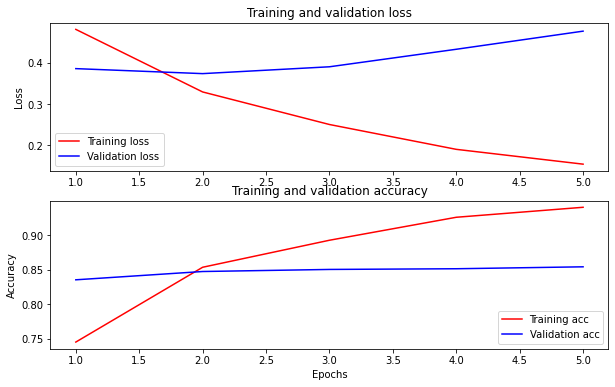

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model, so you can try it side by side with the model that is still in memory.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999298
input: The movie was great!           : score: 0.997045
input: The movie was meh.             : score: 0.984519
input: The movie was okish.           : score: 0.091834
input: The movie was terrible...      : score: 0.001963

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999298
input: The movie was great!           : score: 0.997045
input: The movie was meh.             : score: 0.984519
input: The movie was okish.           : score: 0.091834
input: The movie was terrible...      : score: 0.001963



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999298
input: The movie was great!           : score: 0.997045
input: The movie was meh.             : score: 0.984519
input: The movie was okish.           : score: 0.091834
input: The movie was terrible...      : score: 0.001963



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu), which runs on a TPU and shows you how to work with multiple inputs.